In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import requests 
import re
import networkx as nx
#import plotly.graph_objects as go

# Set Up Sequencing Data
1. Load Excel data into Pandas.
2. Create lists to isolate columns in various ways.


In [2]:
def load_data(filepath,sheet):
    #df = pd.read_excel(open(filepath,'rb'),sheet_name=sheet)
    df = pd.read_excel(filepath,sheet_name=sheet,index_col=None)
    
    return df

df = load_data('published-data/development-of-the-mouse-and-human-cochlea-at-single-cell-resolution/media-2.xlsx','epi_data_matrix')

# Rename the first column to something useful
df.rename(columns={'Unnamed: 0':'Gene'},inplace=True)

# Isolate groups making up the cochlea floor
# Use list comprehension to join suffix to groups
mean_suffix = '_Mean'
diff_suffix = '_Avg_diff'
all_groups = ['10.1.0','10.1.1','10.1.2','10.1.3','10.2.0','10.2.1','10.3.0','10.3.1',\
             '10.3.2','10.4','10.5','22.0','22.1','22.2.0','22.2.1','22.3',\
             '24.0','24.1']
early_floor_groups = ['24.0','24.1','10.0','10.1.0','10.1.1','10.4','10.2.1','10.3.0']
cycling_floor_groups = ['10.0','24.0','24.1']

all_group_means = [group + mean_suffix for group in all_groups]
early_floor_group_means = [group + mean_suffix for group in early_floor_groups]
cycling_floor_group_means = [group + mean_suffix for group in cycling_floor_groups]

all_group_diffs = [group + diff_suffix for group in all_groups]
early_floor_group_diffs = [group + diff_suffix for group in early_floor_groups]
cycling_floor_group_diffs = [group + diff_suffix for group in cycling_floor_groups]

# Get just the columns we're interested (average differential expression)
df[['Gene']+all_group_diffs].head()

,Gene,10.1.0_Avg_diff,10.1.1_Avg_diff,10.1.2_Avg_diff,10.1.3_Avg_diff,10.2.0_Avg_diff,10.2.1_Avg_diff,10.3.0_Avg_diff,10.3.1_Avg_diff,10.3.2_Avg_diff,10.4_Avg_diff,10.5_Avg_diff,22.0_Avg_diff,22.1_Avg_diff,22.2.0_Avg_diff,22.2.1_Avg_diff,22.3_Avg_diff,24.0_Avg_diff,24.1_Avg_diff
0,Apoe,0.573273,NaN,2.344031,-0.634721,-0.264827,-0.764717,-0.746512,-0.863166,-0.794029,-0.458542,-0.510721,1.026082,-0.65547,-0.769283,-0.452768,-0.39749,-0.731901,-0.419621
1,Bmp4,2.097418,0.597864,2.158739,0.602210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Npnt,0.781121,NaN,1.805320,NaN,NaN,NaN,NaN,NaN,0.831003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Lmo3,1.310493,NaN,1.802306,0.328455,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hs3st1,1.401558,0.989634,1.587325,0.353646,NaN,NaN,0.358710,0.408011,0.675554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Retrieve sequencing info by gene name.

In [9]:
df[['Gene']+all_group_diffs].\
loc[df['Gene'] == 'Bmp4']

,Gene,10.1.0_Avg_diff,10.1.1_Avg_diff,10.1.2_Avg_diff,10.1.3_Avg_diff,10.2.0_Avg_diff,10.2.1_Avg_diff,10.3.0_Avg_diff,10.3.1_Avg_diff,10.3.2_Avg_diff,10.4_Avg_diff,10.5_Avg_diff,22.0_Avg_diff,22.1_Avg_diff,22.2.0_Avg_diff,22.2.1_Avg_diff,22.3_Avg_diff,24.0_Avg_diff,24.1_Avg_diff
1,Bmp4,2.097418,0.597864,2.158739,0.60221,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Set Up for Querying STRING

## Initialize

In [3]:
# Retrieve STRING version
string_api_url = 'https://string-db.org/api'
output_format = 'json'
mus_musculus = 10090 # https://www.ncbi.nlm.nih.gov/Taxonomy/TaxIdentifier/tax_identifier.cgi
request_url = '/'.join([string_api_url,output_format,'version'])
r = requests.post(request_url)
current_string_version_info = r.json()[0]
current_string_version_info

{'string_version': '11.0',
 'string_stable_address': 'https://version-11-0.string-db.org'}

## Function to retrieve standardized STRING IDs for gene names

In [9]:
def get_string_ids(gene_names_list):
    ## Tested: working 2020-09-20
    
    assert type(gene_names_list) is list,"First argument must be a list."
    
    method = 'get_string_ids'
    request_url = '/'.join([string_api_url,output_format,method])
    params = {
        'identifiers' : '\r'.join(gene_names_list),
        'species' : mus_musculus,
        'limit' : 1
    }
    
    r = requests.post(request_url,data=params)
    gene_id_json = r.json()
    
    # Convert into dataframe
    
    string_id_df = pd.DataFrame.from_records(gene_id_json)        
    
    return string_id_df

## Function to retrieve protein interactions from STRING for a gene list

In [10]:
def get_string_interaction_partners(gene_names_list,score):
    
    assert type(gene_names_list) is list,"First argument must be a list."
    assert (score <= 999 and score >= 0),"Score must be in the range 0 to 999."
    
    string_id_df = get_string_ids(gene_names_list)
    
    string_ids = string_id_df['stringId'].tolist()
    
    method = 'interaction_partners'
    request_url = '/'.join([string_api_url,output_format,method])
    params = {
        'identifiers' : '\r'.join(string_ids),
        'species' : mus_musculus,
        'required_score' : score
    }
    
    r = requests.post(request_url,data=params)
    partners_json = r.json()
    
    partners_df = pd.DataFrame.from_records(partners_json)
    
    return partners_df

## Demo interaction network query

In [11]:
genes = ['Jag1','Bmp4','Sox2']
score = 970
partners_df = get_string_interaction_partners(genes,score)

partners_df.sort_values(by=['preferredName_A','score'],ascending=False).head(30)

,preferredName_A,fscore,tscore,score,ascore,ncbiTaxonId,pscore,nscore,dscore,stringId_A,escore,preferredName_B,stringId_B
13,Sox2,0,0.974000,0.991,0.114,10090,0,0,0.0,ENSMUSP00000096755,0.644,Pou5f1,ENSMUSP00000025271
11,Sox2,0,0.704000,0.985,0.000,10090,0,0,0.9,ENSMUSP00000096755,0.552,Ctnnb1,ENSMUSP00000007130
12,Sox2,0,0.968000,0.985,0.082,10090,0,0,0.0,ENSMUSP00000096755,0.529,Nanog,ENSMUSP00000012540
0,Jag1,0,0.608000,0.973,0.061,10090,0,0,0.9,ENSMUSP00000028735,0.364,Adam10,ENSMUSP00000063839
1,Jag1,0,0.259598,0.973,0.086,10090,0,0,0.9,ENSMUSP00000028735,0.637,Notch2,ENSMUSP00000078741
4,Bmp4,0,0.917000,0.994,0.000,10090,0,0,0.8,ENSMUSP00000073720,0.712,Bmpr1a,ENSMUSP00000035900
3,Bmp4,0,0.885000,0.992,0.000,10090,0,0,0.8,ENSMUSP00000073720,0.712,Bmpr1b,ENSMUSP00000029948
6,Bmp4,0,0.733000,0.983,0.000,10090,0,0,0.8,ENSMUSP00000073720,0.709,Acvr2a,ENSMUSP00000067305
9,Bmp4,0,0.808000,0.983,0.000,10090,0,0,0.8,ENSMUSP00000073720,0.600,Acvr1,ENSMUSP00000088453
10,Bmp4,0,0.722000,0.982,0.000,10090,0,0,0.8,ENSMUSP00000073720,0.709,Acvr2b,ENSMUSP00000126108


# Cross-Reference scRNA-Seq with STRING-DB
### For each group:
1. Create a set of nodes for transcripts that are present (i.e. log-normalized mean expression > threshold).
2. Query STRING for interaction partners of all present transcripts.
3. If A and B partners from STRING are present in the group, create an edge between them.
4. Add edges to network according to As and Bs that are present.
5. Query STRING for networks of all present transcripts.
6. Determine if a path between any present transcripts exists in the network.
7. If a path exists, determine whether intermediate nodes are confirmed not present.

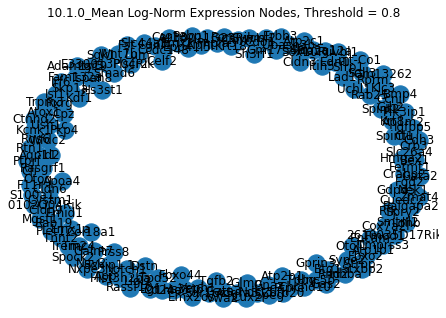

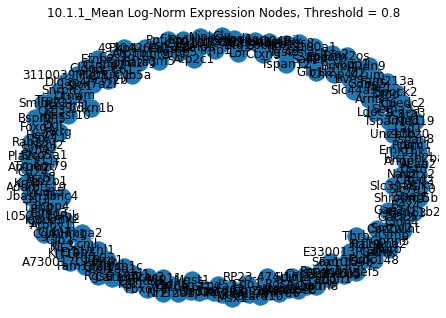

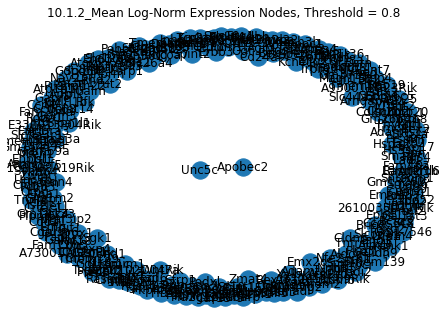

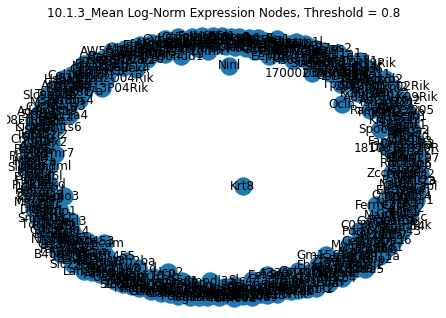

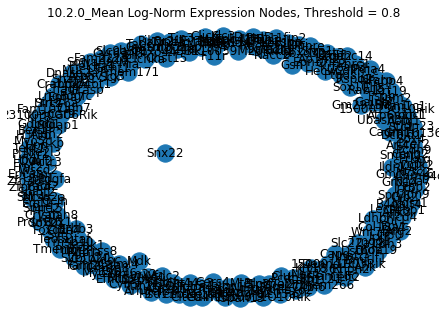

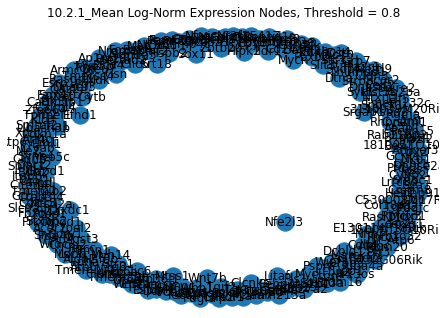

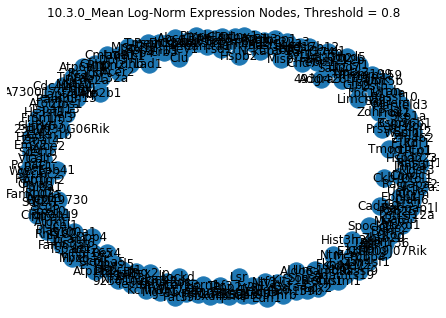

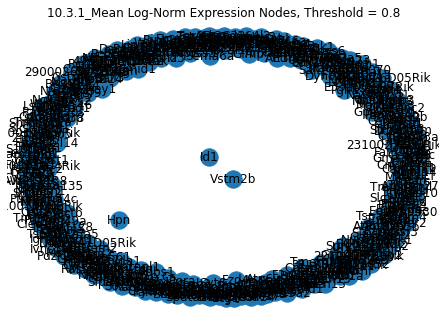

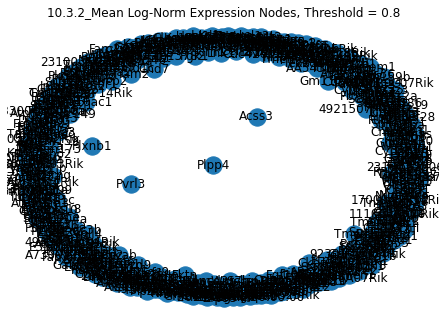

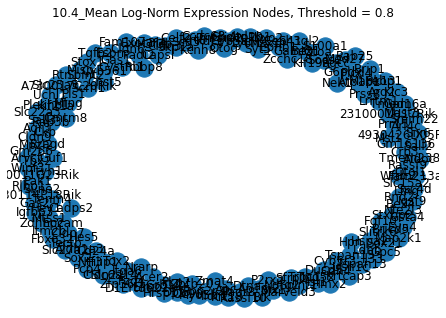

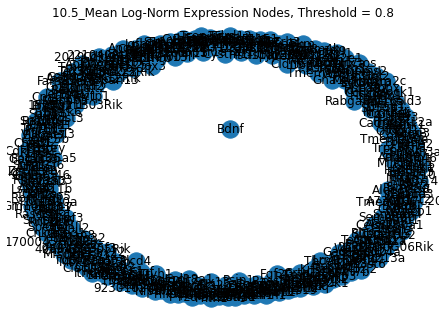

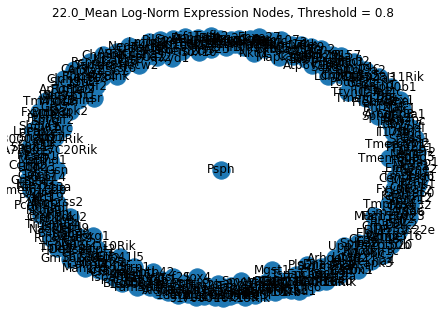

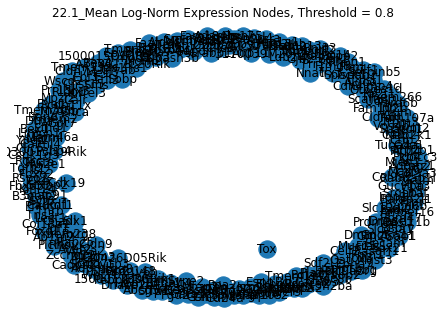

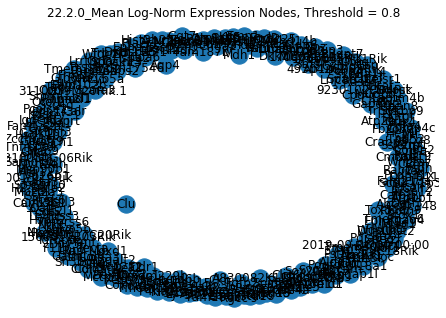

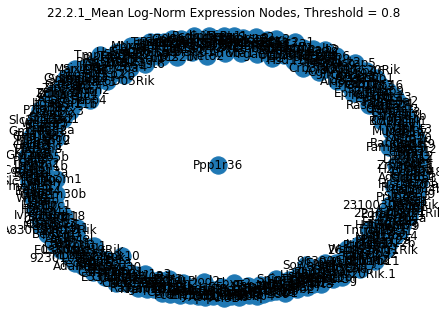

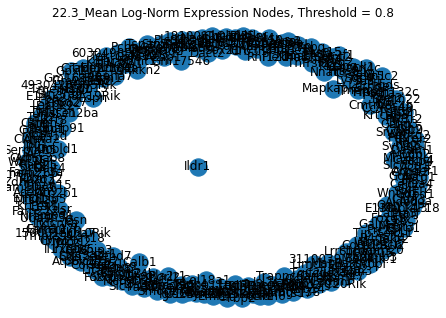

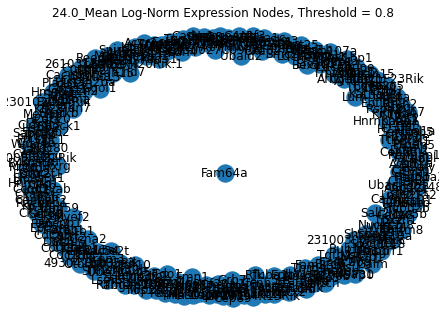

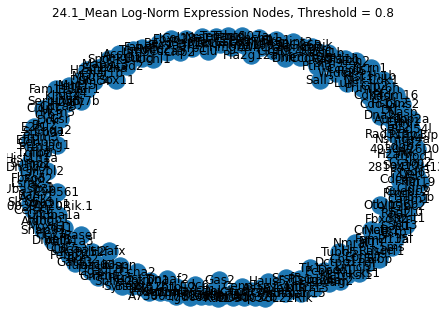

In [12]:
# 1. Create a set of nodes for transcripts that are present (i.e. log-normalized mean expression > threshold).

# Let's start with just one group. And maybe let's do this from the main dataframe with all data.
mean_thresh = 0.8

for g in all_group_means:
    group = ['Gene',g]
    g_df = df[group].loc[df[g] > mean_thresh]

    G = nx.Graph()
    G.add_nodes_from(g_df['Gene'].to_list())
    nx.draw(G,with_labels=True)
    plt.title(g + ' Log-Norm Expression Nodes, Threshold = ' + str(mean_thresh))
    plt.show()

### Uncomment above to plot graphs

In [13]:
# 2. Query STRING for interaction partners of all present transcripts.

group_no = 0

group = ['Gene',all_group_means[group_no]]
print(group)
g_df = df[group].loc[df[all_group_means[group_no]] > mean_thresh]
gene_list = g_df['Gene'].tolist()
score = 700
gene_interactions_df = get_string_interaction_partners(gene_list,score)
gene_interactions_df.head()
#gene_interactions_stringIds_list = gene_interactions_df['stringId_B'].tolist()




['Gene', '10.1.0_Mean']


,preferredName_A,fscore,tscore,score,ascore,ncbiTaxonId,pscore,nscore,dscore,stringId_A,escore,preferredName_B,stringId_B
0,Slc26a4,0.0,0.704,0.704,0.000,10090,0.0,0.0,0.0,ENSMUSP00000001253,0.0,Slc5a5,ENSMUSP00000000809
1,Slc26a4,0.0,0.820,0.825,0.064,10090,0.0,0.0,0.0,ENSMUSP00000001253,0.0,Atp6v1b1,ENSMUSP00000006431
2,Slc26a4,0.0,0.753,0.755,0.049,10090,0.0,0.0,0.0,ENSMUSP00000001253,0.0,Slc4a8,ENSMUSP00000023776
3,Slc26a4,0.0,0.834,0.834,0.000,10090,0.0,0.0,0.0,ENSMUSP00000001253,0.0,Gjb2,ENSMUSP00000054343
4,Slc26a4,0.0,0.715,0.715,0.000,10090,0.0,0.0,0.0,ENSMUSP00000001253,0.0,Kcnj10,ENSMUSP00000054356


In [14]:
# 3. If A and B partners from STRING are present in the group, create an edge between them
# Get a list of the stringId codes for genes in step 1.
network_nodes_list = g_df['Gene'].to_list()
network_stringIds_df = get_string_ids(network_nodes_list)
network_stringIds_list = network_stringIds_df['stringId'].to_list()

# Add a column to the interaction data frame for 'B is present'
gene_interactions_df['B_is_present']=False

# Check if each 'stringId_B' from gene_interactions_df is present anywhere in network_stringIds_df['stringId']
network_stringIds_df['stringId']

idx = 0
for id in gene_interactions_df['stringId_B'].tolist():
    tf = network_stringIds_df['stringId'].str.contains(id)
    total_occurence = tf.sum()
    if(total_occurence > 0):
        gene_interactions_df['B_is_present'].iloc[idx] = True
    idx = idx + 1
    
sequence_network_df = gene_interactions_df.loc[gene_interactions_df['B_is_present'] == True].reset_index()
sequence_network_df

/home/thompsmj/.conda/envs/cent7/5.3.1-py37/ThompsonEnv/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,index,preferredName_A,fscore,tscore,score,ascore,ncbiTaxonId,pscore,nscore,dscore,stringId_A,escore,preferredName_B,stringId_B,B_is_present
0,3,Slc26a4,0.0,0.834,0.834,0.000,10090,0.0,0.0,0.0,ENSMUSP00000001253,0.000,Gjb2,ENSMUSP00000054343,True
1,7,Slc26a4,0.0,0.758,0.758,0.000,10090,0.0,0.0,0.0,ENSMUSP00000001253,0.000,Tmprss3,ENSMUSP00000110196,True
2,13,Crabp2,0.0,0.316,0.929,0.000,10090,0.0,0.0,0.9,ENSMUSP00000005019,0.048,Rxrg,ENSMUSP00000015987,True
3,79,App,0.0,0.291,0.927,0.060,10090,0.0,0.0,0.9,ENSMUSP00000005406,0.000,Edn1,ENSMUSP00000021796,True
4,85,App,0.0,0.732,0.978,0.099,10090,0.0,0.0,0.9,ENSMUSP00000005406,0.197,Clu,ENSMUSP00000022616,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,5395,Gata3,0.0,0.781,0.783,0.000,10090,0.0,0.0,0.0,ENSMUSP00000100041,0.049,Rorc,ENSMUSP00000029795,True
90,5581,Tmod1,0.0,0.303,0.934,0.139,10090,0.0,0.0,0.9,ENSMUSP00000103402,0.000,Tnnt2,ENSMUSP00000107717,True
91,5740,Wnt7b,0.0,0.685,0.894,0.000,10090,0.0,0.0,0.6,ENSMUSP00000105051,0.228,Sfrp1,ENSMUSP00000033952,True
92,5795,Tnnt2,0.0,0.303,0.934,0.139,10090,0.0,0.0,0.9,ENSMUSP00000107717,0.000,Tmod1,ENSMUSP00000103402,True


Slc26a4		--	Gjb2
Slc26a4		--	Tmprss3
Crabp2		--	Rxrg
App		--	Edn1
App		--	Clu
App		--	Igfbp5
App		--	Notch1
App		--	Egf
App		--	Tgfb2
App		--	Bmp4
Rab25		--	Rab19
Rxrg		--	Crabp2
Cldn7		--	Epcam
Cldn7		--	Cldn3
Lgr5		--	Egf
Lgr5		--	Epcam
Id2		--	Bmp4
Edn1		--	App
Fst		--	Inhba
Fst		--	Bmp4
Clu		--	App
Clu		--	Egf
Clu		--	Apoa4
Clu		--	Tgfb2
Spry2		--	Egf
Krt18		--	Krt8
Krt18		--	Epcam
Krt8		--	Krt18
Krt8		--	Epcam
Igfbp5		--	App
Igfbp5		--	Bmp4
Notch1		--	App
Notch1		--	Gata3
Spint1		--	Prss8
Egf		--	App
Egf		--	Lgr5
Egf		--	Clu
Egf		--	Spry2
Egf		--	Tgfb2
Egf		--	Erbb3
Rorc		--	Gata3
Rab19		--	Rab25
Prss8		--	Spint1
Prss8		--	Spint2
Sfrp1		--	Wnt7b
Sh3rf1		--	Fbxo2
Sh3rf1		--	Skp1a
Sh3rf1		--	Fbxo44
Apoa4		--	Clu
Smad6		--	Bmp4
Fbxo2		--	Sh3rf1
Fbxo2		--	Skp1a
Fbxo2		--	Fbxo44
Skp1a		--	Sh3rf1
Skp1a		--	Fbxo2
Skp1a		--	Fbxo44
Lum		--	Tgfb2
F11r		--	Cldn3
Tgfb2		--	App
Tgfb2		--	Clu
Tgfb2		--	Egf
Tgfb2		--	Lum
Isl1		--	Bmp4
Syne2		--	Hist3h2ba
Inhba		--	Fst
Fbxo44		--	Sh3rf1
Fbxo44		-

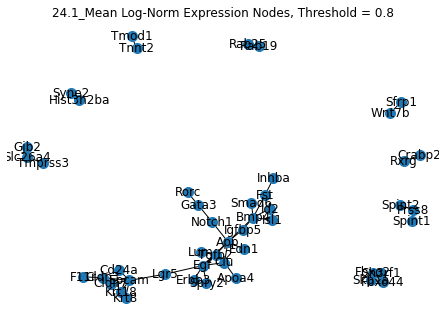

In [15]:
# 4. Add edges to network according to As and Bs that are present.
sequence_network_df

list_A = sequence_network_df['preferredName_A'].tolist()
list_B = sequence_network_df['preferredName_B'].tolist()

idx = 0
for gene_A in list_A:
    G.add_edge(list_A[idx],list_B[idx])
    print(list_A[idx] + '\t\t--\t' + list_B[idx])
    idx = idx + 1

# nx.draw(G,with_labels=True)
deg = G.degree()

to_remove = [n for (n,deg) in deg if deg < 1]

G.remove_nodes_from(to_remove)

pos = nx.spring_layout(G,k=100,iterations=100)

nx.draw(G,with_labels=True,node_size = 100)

plt.title(g + ' Log-Norm Expression Nodes, Threshold = ' + str(mean_thresh))
plt.show()

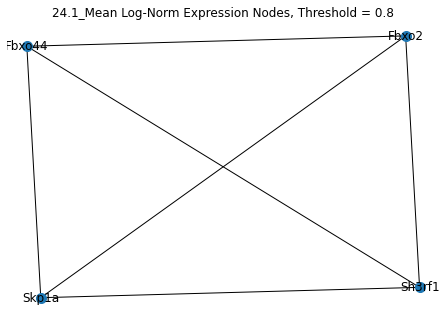

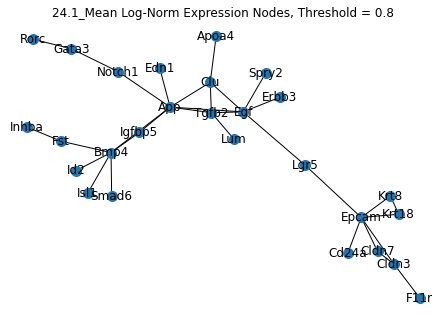

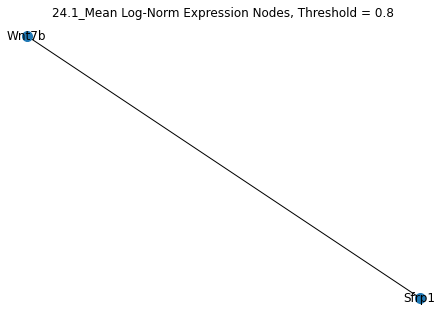

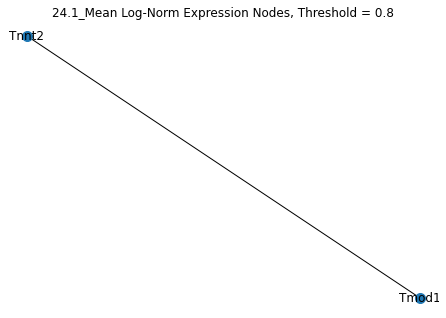

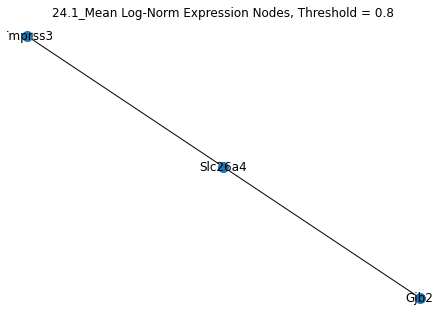

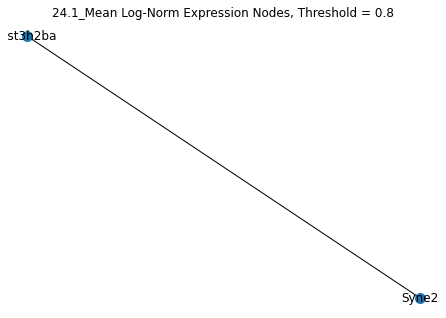

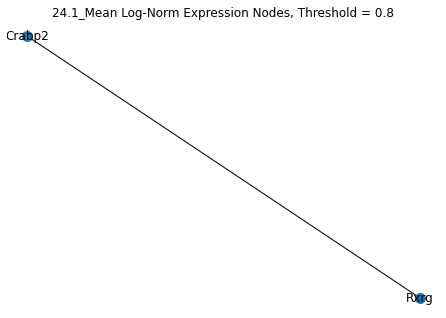

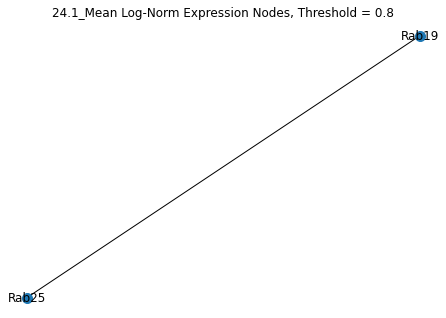

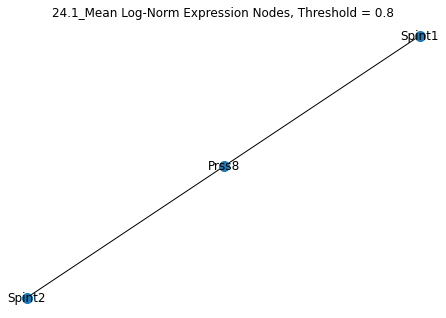

In [299]:
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]

for sub_graph in S:
    nx.draw(sub_graph,with_labels=True,node_size = 100)
    plt.title(g + ' Log-Norm Expression Nodes, Threshold = ' + str(mean_thresh))
    plt.show()

In [54]:
## Retrieve upregulated genes for a groupdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAb4AAAEuCAYAAADx63eqAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4yLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+j8jraAAAgAElEQVR4nOx9d3hVVdr9OvX2luSm3Jvcm0BIAqGF3kJVmlQFgqCoFAEVUJQiIIhtRiyAMjZwBATbgOiIWBEEQVQQUEFA6QEklJBGyi3r98e5OSSCzsw338z8vuGu57kP5Ox99tlnn3P2u9+y3i2QJKKIIooooojiKoH4n+5AFFFEEUUUUfw7ERV8UUQRRRRRXFWICr4ooogiiiiuKkQFXxRRRBFFFFcVooIviiiiiCKKqwpRwRdFFFFEEcVVhajgiyKKKKKI4qpCVPBFEUUUUURxVSEq+KKIIooooriqEBV8UUQRRRRRXFWQ/9MdiCKK/8s4W1qJVTvyse+XYhRXBGE3yshKtGNw82TEWg3/8faiiCKKyyFEc3VGEcU/jt3HL+BPG3/G5wfOAAAqg2G9zCiLIIDOmW7c0SkdTVKc//b2oogiit9GVPBFEcU/iBXbjuDRdftQEQzh974eQQCMsoSZvbNwU5vUf1t7UUQRxe8jKvii+K/Fv8JsqAmpH1EeCP/tyhGYFBEze9e/orD6327vH0XUtBrFVQlGEcW/GM8++yybN29OVVV5yy23/Ga9pUuXslmzZrTZbPR6vZwyZQoDgUCtOq+//jqzsrKoqipVVaUsy3qbn376KTMzM2k0mphUvznT7nqFGbPW0dV1NAWjhRBEQpQp2+N5+6vf8OuffuHIkSPp9XopyzJlWabZbGa7du24bds2rlixghaLhSaTiZIkEQABMO6GB+ifvpbOLrdRifMRipGCYiQkhaLFSVfXUfRPX0vJHk9ICiEIBEBJktmmTRt+8cUXJMnPdv5EW4NOWh0IhCjRkNKQSaP+xORJr9OclUuIkesKIgXFQDnGS//0tfTmzWF8YhIBUBRFmkwmmkwmAuCjjz7KjIwM2mw2mkwmqqpKl8vFKVOmMBwOkyT/uGgJbW7vpb7Z3Ywf+gj909ey3rS3aU5vQSFybUVROHr0aBYXF5Mkd+zYwdzcXFosFsbHx3PBggX689m5cyc7dOhAu91Or9fLuXPn6mWPPvooLRaL/jMajRQEgWfOnPnfeM2iiOLvRlTji+JfjrfffhuiKOKjjz5CeXk5li5desV6zz//PBo2bIjWrVvjzJkz6NevHwYPHozp06cDAD755BOMHj0ab775JvLz81FUVISNGzdCkiQ8+eSTqFu3LkZMfQwfl6Xgl8+WoeL4Hjg7DMPZtfPhumYMwpVlKPn6HYTKLsB/71tQwwFkn92Iu0dcj2+++QZutxt33HEHZsyYgaeffhpHjhyB1WrF6dOnsXr1aiz+aDt2/fUVeMYtgeJMRNG2VTCmNsXFHzej4shuBC8Wwt6iP4q/fhtx192Dcx/+CTE9xkNxJkGJ9aBHg0T0sp3AyJEjUVBQgOTsligOyaj85SASh/0B4cpyXDywBRWHd0L1ZCJYeAoMVsKc1QHlP30FJT4VMd3GIHD+BE4tvRt9pz6D1XNuxRNPPIGXX34Z999/Px577DFs2LABZrMZq1evxpNPPomGDRvC5XJh27ZtmDhxIg5XWfD07PsgKCYYU5vC1vw6VBzdjcINS+Ed+xIK1y9GoPAU7C37w5XZCoN8Vdi5djn8fj8eeeQRNGjQAPPnz8egQYNQVVWF/Px81K9fHwDQoEEDDBw4EA899BCOHDmCDh064MUXX0S/fv0ue94PPvggNm3ahM8+++xf9u5FEcWVEKUzRPEvx/XXX48BAwYgNjb2d+uNHz8eubm5UFUVXq8Xw4cPx5YtW/TyOXPmYPbs2WjTpg0GDRqEUaNGwe/3A9CEa7wvHZ9W1kElJTjaD0Og4DCKd6yFtcm1sDboBHtOb1ibdAcD5SCBSkHBj54eOKb6cO+992LEiBGoU6cOMjMzUVVVhf379wMAEhISMGTEKOzbtR0AIEAAADjaDIIhMR1lezbA2XkELBntECoqgK1JD5R+/6lWV1KgxCYDELFhfwHKqsIoLCzE0pVv4NzpkzAkN4AxJRtKbDIMnnqwZHdB1dljCBadhjmjDSCIEBQDzBltETh7DABQfvhbGFOysQ9eFFWEMG3aNJw4cQLPPvssRowYAZ/Ph7i4OCxbtgwTJkyAzWbDL7/8gnvvvRdPLnoRzz7xB1ia9ECg8AScucOhuDywNe0F1e1HyY73cfGnr5CQ9zAs9TuiSjRizWknMjr1x5YtW/D000+jR48eGD58OAwGA2w2my70AODIkSMYPnw4JElC3bp10aFDB+zZs+eyZ00Sr776Km655Zb/4VsVRRT/BP7DGmcU/2FUVFRw5MiR9Pl8tFqtbNq0KdetW3fFuq+88gpFUaxlrtqwYYPezrCbb2FMgoeK0cwYXwb7T3uWz2/8mWdLKrhnzx4mJiZSVVU6nU5269aNe/bs0dueN28es7OzabVa6fP7OXDcNNZp0ZmNeo/gpDe+5UMr11MQBCqKQkVRGBsbyzvvvJNTp05l9+7d6XDGEJJM0WijqV4beu9cSiXOR8nuZlz/qYwf+gjVhLoRsyIY02si/dPX0j99LVNu+gOzGjam1WolAI4bN44Gg4FPr93Jia/vYKPeIygqqm7qlByJjB/8IP3T11L11icACoqBEAQKqpmiNUY3IV7pl5iYSEmWNfOlFGlXlGhp0oPGtGYUZEMNE2mNdmSVrh53UnYmRkyfJspmGxWTRa+nqqpuRqw+z2w289Zbb6XBcOkYBFG7F4uLtmbXMXnSG5RjkrXjgkhDSjZFk52K28+4AffT1rAz7Q4nRVGk2+1m48aN6Xa72adPHw4bNkx/HxRF0d+Rffv20ev18uuvv9ZN1GazmXXq1OEzzzxDi8XCJUuW1Hqfqs2127dv19+N3zOtkuSCBQuYmppKs9nMrKws7t+/nyS5du1atm/fng6HgwkJCbXMtVFc3YgKvqscpaWlnDNnDg8fPsxQKMT33nuPVquVhw8fvqzuK6+8wvbt2192fNexQt66eBNjcocx7a5X6Jv2V7oHzaagmlgn4me75YXPmHfLaI4YMYLBYJALFy5ko0aN9DYef/xxvv7+Ro565Uumjn+JoslGwWhl8sSV9E9fS0NiOgEw1p/J2Y8vpN1uZ8uWLdmuXTsOGTKEdVp3p73NIPruW0N76+tpSm9Fg7c+RZOdMT3upGh2MH7wg3TfMJsAmHDjH+ifvpa+Ke9QMJjZfsRUdu3albnduhOCQGfLvsyYtY5x/adRtLioejIpJ9TT/WGCaqJ33MtUPZkEQHvbIVTcqfSMfYlxA6ZTssczPu9hmrI60JrTi85OIwjVRFFW2LJlS9bv1Dci8GSasjrWEozuIXPpGf+yLpwA0OBvTGe3MQRAW+vrNcEoKYzrO4X2DsP0er2mPMNdxwpJkqIocuPGjZwzZw7379/PIfNW6/UE1UJBMTJ54koavPWperIo2eKouFO1OoqB7hseYMKwP+g+yKZ9bmV6ejpNJhMTEhJYVFTECRMmsF27dvpz3LJlC202G4WI4J89ezY//vhj+nw+fvnllwyFQszPz2deXt4V/b2vvPIK69Spo/siz5w5Q7fbzRUrVrCiooLFxcXcu3evXn/x4sVs1KgR9+zZw3A4zJ9//pnnzp0jSa5cuZIffPABy8rKeP78efbs2ZNjx479H30nUfx3IWrqvMphsVjw4IMPIjU1FaIook+fPkhLS8OOHTv+rvNXbDuCoYu3YeOhYtjaD0PY6oYgiDCnt4LsSEBx/gFUBsP4/OhFfHqwFIfOloEkJEnCzz//rLfj6TgEc7eVY/2Bcyg7fRThQCVMac0gmR0InD+ByjNHAABCw954qzQDiWkZaNq0KQ4ePAhBVnE+bES48qLWmCAiWHgK4aqLEBQDyn74DLamPWGq2wIMBwAASrxmIg1XlICVF7H76y04VVKF7QdOQDTaICdloTIYRrDoNIwp2QiXF8Oe0xMAECorhOxIQOUvPwOC9gmV/rAB8YMfhOLyABAgGkwweLMgSgqCRQVwtB0CIRxCOBTEuXPnUFFZCcmRACXGi6r8H+C9YykgKRCMNpz/6DmcfWceBFkFACSOfBaKy4PSXR9AssZAtrlhy+kNQRBw/pMXwPISQJAAAN8cOIGhi7dhxTbNP2kymdCzZ08MGpKHbfvzISjGyIgTosEMyeyAreUAVP3yE9SEuhANZkCUYW/RD2V7N0KQFIBhQFZR1mQwDEYT8vLyoKoqtm7dijlz5mDr1q2Y//4ujHt5Izp3uxYXKyox8cll+G7fz/joo48wduxY3UQtiiJiYmKwbt26K5o5ly1bhhEjRkAQNHPy75lWw+Ew5s6di/nz56NBgwYQBAF169ZFTEwMAGDYsGHo2bMnzGYzXC4XxowZU8t0HsXVi6jg+zdj0aJFaNGiBQwGA2699dbfrPfGG28gMzMTDocD8fHxuOWWW1BcXKyX33TTTUhKSoLdbkdGRgaWLFlyxXbmzp0LQRDw6aef6sd69eoFq9Wq/1RVRaNGjQAAp0+fxoEDB7Bjxw6kpaXBYrGgfv36OHDgAABg586dsNlsUBQFsqJg3IihKC2+UIt/Vn5kF04uuROBM0dw/uPnUfbjZpBAReFpfLFuNRRFwV133YVgMAhBEDDpD8/j0XU/oujkQZz48ySceftRIFgFo68hACBw5ihkZyIgyTi77hns/+NAHPh+J5a9ugIAcPTcRUjWGJTu/ADHnhyI4m2rQADBwlNQ3KmoOnsMpXs/x9E/9sXZNX8AAOQ/czNOvnwnRLMTkiMB5Sf248fd36I8/0eEK0pQeeonAIClfkdUntiHYOEpnP/4Be0GwyEEzh6H6vYhXK49E1aU4Oy7j6Pi6Hco//lrBM7l4/jTg3HxwFbYW/ZHsKgADFZBEEQIggCrzQkBABmGaLBAssUC4RAkiwvhilJUFRzWhdTpFdNQVXAYwXMnAFFC8TdrULpnAyDKiO09Eca0ZgBDgCDh3Mcv4MCTeRg7/Ho44j3YvXs3gsEgfvr5Z1SePgzF7YdodoDBKoTKSxCuvIhwoAIIhxC6eAFqYjoAQHGnoerUzyhY/TAkiwuyww1REGBNqgNBENC4cWN8smU77nlrFwDgTxt/wrubdyEYDEEwu/DB+VgMWnEAQt22OHLkCM6cOYP09HQkJyejX79+cLlc6Ny5c613defeA/h80yYciWmOkcu+wd1v7sTqDzfAbHOgXbt2iI+PR9++fXHsmObrzM/PR35+Pn744QekpKQgLS0NU+6fiec2/IS739ypt/HC5wdxrrQSmzZtQnZ29m9+c1FcRfhPq5xXG1avXs01a9Zw3Lhxvxvaf+zYMT3Mu6SkhMOGDeOECRP08hkzZjAnJ4eqqnLAgAFMSEio5RchyZ9//pnp6ek0GAy02Wz8rcfdqVMnTpw4kaqqMjExkR07dmSjRo347rvv6vQCu93Odu3a8aWXXqLFYuHcJxdRMjsumeMkhY72NzJp9HMUTHYqsSlaWbW/qtqXJQgUDFa2at+RQ4YM0U1iGtVAqmXygyDpNAHtmObzUpMyaWvRn5LZQaPRVKNM+1cwOyi5kmqZCmu2qV/rSuU12jKlt/6NcvE3zq3pj1Momhza9XC5v082mvT7+XXbgqxS9WZRsrmv2LYSn0aI8hX7ZkxrTlPdlhRMdp3qIAgCVZOVsjOJMT3uoGiNvWKfBIOZ3juXUXYmUTDaLo1XxPTpn76WN8x6kU6nk/aYOELVxl5x+zVf6T1vEYJIU0Zb+qb9ld7xf9afXVpWI548eZI7d+7U+1Xt1wPA1jdOYmynm6jGp1Fx+ykYLBSNNgqKkaJq5oC5S/nVgVO1TKtbtmwhAPbu3Zubvj/CoU+9SyXGw/jel/y3/ulrmTlrHb3DHqFqtvHdjd/8k19wFP8NiGp8/2b8vRGOKSkpiIuL0//+tWmwefPmmD17NkaOHAkAEAQBBw8erNXGXXfdhSlTpsBqteK+++674nWOHDmCzZs3Y8eOHbDb7Xo78+fPR8eOHbF69WoUFRXh/PnzyMvLw8yZM9GvXz/kx7eGYHIAkgwIAoxpzVC2ZwPOrp0P2eyA5IiH77634b9vNeytrwdCVdoFSbCyFGeqFLz11lsgAM+Y52CunwvRaAUiEZORm4IhJRsGTwYE1QTFkwlDSjYCZ4+i5Nu1CF0sQkVFeaQyIbm8gCSDF4sQKioAGIZgtGrFYiQtLUOa6S4cghLn+43R19TX8oPf6KbM2ghrbej9lCKmRu08QTHC1WU0whXF2vVQrQ5r92ZrOQCKpz4kh7tGGbRrCYQgqQicOwEKtccCAOQYLzwjn4Vsd9caK4OvESCIMNVpph0Ph7SeElAUBaFgFULlxZCcHoRLz0FJTAckpVYbsT0nQrbFwn3DLLCyLDIUYUCUgGAAJ5fcAUd6DvqOnITiC4VAKABIChxt87RrVZYBJIKFp3B8wVCcXHKHZjoFUJFxLdYfrYTb7YYoisjMzERpaSkeWv4BIIjIdzZG0XfrYWl0DeKHPATfPW8i+a7lEBQDBIMZuyricMuru1D/utuwdetWFBUVwWQyAQCaXnczbn/rR2w7K8HapCdKfvq61tMqOroXp9bMg6v/NExbfxYrth35jecexVWD/7TkvVoxc+bM39X4SHLz5s202+16ZN5HH31Uq3z8+PGUZW3ln5OTw5KSEr3srbfeYr9+/UiSfr+fS5cuvaLGN3fuXGZlZTE1NZWpqans21cLuliwYAGTk5OZmprK2bNns7KykosWLaIoinxg7iPMmLVOiyqM8RKiTGPdlnTk3kwIAiV7POW4FEoWFy3ZnensOpqS3U2Dr5G+Cne2GkAAjO89gf7pa+kZu1iLVDRYKJqdWsBIuzx6xrxAKJrWqEaCVUSTnYJqohznZ3zPO5iU1YzG1Ka0NOhMCCITbppXKxISAB3tb9SvLRg0Mrt/+lrGDZhO0eygEp9GwWCh69rxEc1T0DVZU3prTcMSLml6jg7DtShKbxatOb21QJmp72qarijR3KAT7W0Ha5GZolRLwxSMVkoxXpqz2mt/KwZaG/egtWlPmjLa0eBrRKlGZKhgdjJ+6CMUVDNll5dqYjohCNrYR7TBuH5TCAiUHPEUDRYKkfs2123OsyUVnPjadkKUtIhRgJI1hrYW/Zlw6wJNAzM7KZqdFGRV07IBCqqZ/ulrGZ/3ECVbLL0TVjCtdXeKBi2K1OBrRMkWy4QbH2Nc/2mU7G5CEGhIaUjPuCWUY5MZP/hBQhAZe909zHrgAz789HMEwJSUFL765WHGdRxOJbEe1aQM/ZlVPyfffWu0BAGqmaZ6bTQCvy2OAFhYWMiysjJKskKTr6GWLACgtWkvmuq10dtIunUhBaOVSpxP0x7NTsZ3v52vfnmYR48erRVRWq19PvnkkyTJzz77jA0bNqTD4WBMTAwHDBjA/Pz8f/LLj+L/B0QF338If4/gq0Z+fr4emfdr3H///ezZsycffvhhVlVVkdRMo+np6Tx06BDJ3xd8aWlpNJlMzMnJ4f3338/u3bvr5qPCwkIePnxYN5cBoM/n4433PMTUcS8Sgkhrk+4UVBONqc2oJmlRj6Itjp7bX2TK5L/QnNGOkiORkBRKEROa6q1P0WglBIF1p62hf/paxva9VzMBxvlobdZHa8do1WgCsqoJK0mmFJNMa4v+ugnNP/4lGt1+Whp2IySVsjuNpoy2NcyjNUx5JjvtbQZrtAeTnSn3rooISYHGOi1+VdehT/5yjJem9FaE0UbB7Lhkmq2ub7DW+tvS8BrKcX7a2tyg3YfFqdMexOrza/wMdVpQifPR2WUUBdVE0WSntcUATVhGzIm64IVAyRYb6YNA0RpDNTmbanI2IQh0D5nLlHtXU6xhJjWYzJQVbTwkRwJFi4txA+6naLJfEq4Gs1bX15juQbNrj4VqpmC0UXEm0lmn0SUza7Ugl1XG9pmsmbNrjrsoadQLWaWaWI+x191NUdLOFUQtEw0kmZYmPSk5EnShXC209Z8g1mj7kol27lN/oi27C5XYFFpzel+ikAgioRi0BYLBQkE109ZmkC7Qqxc0/jrpJLVsM82aNdMpIMOGaVGyb731Fm+66SZaLJZamXsALZtNw4YN2alTJxoMBsqyTEEQKIqinvmH1LIJ1a1bl6IoUlW1+6qOmJ4zZw5lWa4leA8ePEiSf1MoR/HPISr4/kP4RwQfSX755ZfMycn5zXbGjh3LhQsXkiQnT55cK1XUbwm+zZs36xqjwWCgoij6Bz5z5kz945s5cyb79OnDbt26UZZlipJM2ZFAxe2nsZ6mDalJmTUmPJlCJI2XI/emS5wxa0zkuDbB2fzZ+spcciRcJhBUb5Z2fsTXpMSnEVJN35agT8KCaq5xTLrkm6qe/NOaXSr/1XXEiBZRU6Or+bdQLXx+/VPNmkCuFkzVmt2vBa5iZFz/aZcLzH/gJxptV/CBinoatlrHRZGKrkEJtMd7a5XXHusr8w3VpHpMvvtNWhpdc/n9ywoN/iY0JGdr41zj+rbWgyk7E6l46tcQ1jXuO1I3Lq1+7XZFSadlqN76muZvcdXqn6AYqcT5aEhuQFGSqRjNWhu/EmjmBp2v+By0RYiLyZNeo3fcYo599RtWVlbS5/Px6aef5qxZs+j3+6koChMTE/nJJ5/o30pFRQWnT59Oh8PB2267jZ06deLcuXPZqVMnPvbYY3zqqad48uRJBoNBvvjii4yNjeXhw4dpt9v50ksvccGCBbpArSn4hg8f/nd9/4cOHaIoilekGUXxjyPq4/s/gmAweJkP77fK169fj2eeeQaJiYlITEzE8ePHMWnSpMvOefrpp2GxWFBZWYmKigrMmDEDgwYNgqqq6N69O3w+H0pLS+FyuSDLMj7++GPIsoyUprnwjn8ZCcP+CJBAOIiqc8dhb5en+Xza5cF37yr47l0FU90WAAnR4kTyXcvhu3cVkkY/DwBQYjx6X5LHvwyIEuT4NHjGvqTd04VfEC4vBUQZ1sbXwOhvAv+UdyBaYyAoRhjrNIOr60gYUhrCmtMLgmKEd9JKQBBhzmqv0wEAIKbbaBjTmkG0ugAAjtzh8N23BsmTXoNsjwcAxPW7D2AY5gad4Ow6CmpSPYBhMBiAaHZAUE2RtjV/ZFzvSWAoCGPdFnDfMBMIhxDbfyog10jurBqRcOOjKPtxEwDAlNlOLxJMdgCApUlPqInpkN1p2rmCCMnuhql+LqCaNR+bKEI02iC5kmBIaQjIKiAIEGQVki0OkFTE9psCY1oOEA4jEIlKhaSgtPAsBFGEaI2DaI1FqOg0AEA0WmHJ6R2pJ+v+TEE1QhBlhIpOQ02oA2vDbtU91q4bDiNw+hAERQUYgrXxNYgfPAcAUHVyH4Kl5+HqMFS7fU8mAMCc3RmCYkRiv8kwmCwQ0nPBqgoonqzI2E+FNbszAMCa3RlKnA/GlIawRCgkEETYWvSFZ/RzMNVrA0oKXF3HwDf5L3C0GaT5QBUTDJ5MmPyNgXAI7sEPaqfKBm1cRQmS2QFWVUB2JmHD/jP46wcfIxgM4u6778Zrr70Gm80Gp9OJcFjz4R47dgxOpxMmkwlPPPEEKisr0b17d2zevBk333wzAMDtdmPy5MlISkqCJEm4/fbbUVVVhcWLFyM7OxtjxozBpEmT8NxzzwHA737Hv4Xly5ejY8eOSE1N/YfPjeJyRDei/TcjGAwiGAwiFAohFAqhoqICsixDlms/ipUrVyI3NxcpKSk4duwYZs6ciW7dtAmooKAAn332Gfr06YNwOIwTJ05g69ateO211wBogi8QCOhttWzZElOnTsXEiRP1Y+Xl5XjvvfcQCoVgMBhgNBohSRJCoRAsFgvmzZuHnJwcFBUVYfHixWjSpAk8Hg8qKipwbOcmuOt1g8GTBclghhybAslkR+nOdUA4iKKtb0CO9cKc3gqFG14BQIQvFuP4/Dxtgo8ElYQuFun9qTqXr4XUF50GQ0HtIAFExiVYfAYVh7+FIMkIV5YDgQpUHNqBylMHwMpyVB7fA4AoP7wTCAVwcf8WndsGAKeW3AHBaAUrtKANW7PrUJG/Fxc2/BlVEY5g0bbVgGxA+aEduLjvC03gAEA4iPDFIm1yJRAqPQ9TvTZAOAiEQ6g4uB2Vx37QBJbZBQQrNSHCMBCowtkPFyF45igEkw2hknPQAkoIRqgQsi0GxpR+OLd2Pmytb0DJV6sQKj6D8uIzev/D5SWRYBzCkJyNypP7gXAIxjotUP7z17C3vh7WBp0QOHsMVacPwdF2CMr2boTsTEKbjl2x6Y3nECwrguyIByvLwEAFbM2ug7FuC5TtfB+SNRYMVoLBAOytBkIQRZx6peZiSeuzZHNDNDsQOP0zKg7v1EuNac0AAJUn9gLhEAreigjCEz8CAC7+sAHG1KZQ0logGAojWHIOEADJYEFAlCCabHpbZT99BVaVQ/VkoPS7SOo3WUXJN++idNdHGh0jTFDUAnMM3vraAkwQECw5h0DRaSjxaag4uhuCYgQDFRAMFgBA4MwRnHheW9QkdBuJNwuL0bhxY3zxxRc4ceIEunXrBr/fj61btwIAfD4fLly4gPPnz2PcuHHYsmUL9u/fj9zcXKSlpQEA7r//fkyfPh2ZmZl49NFH4XQ6UVVVhXPnzqFJkyb6fVksWh8OHDigf8vvvfceYmJikJSUhLvuugvjx4/HlbB8+XI88MADVyyL4n+A/7TKebVhzpw5l5lf5syZo5sVjx49SlKjK3i9XprNZnq9Xo4ZM4Znz54lSf546DjTG7egarZSlBUazFYOnfQgfyksvex64XCYPp+PS5YsIQCWl5ezoqKCr732GmNiY3nT1D8wq2Mfpra8hs2uu5k5HXtw++69zMvL0zN0DB8+nG63m8OGDWNCQgITUupQUE0UZJXG1Bwa67UhJIWCwcyE2xbS1qI/BaOVoslONSmTgslGiArdQx6iq9toPYhFUE1MuumPTJm8irIz6YqmKckWR8Hs0s1Yl6VGd2kAACAASURBVEyFAqEYNZ9VJHRfrwPQ0qQHDf4meli+FJNcu23FSECgIakeBaMtYlbTTHGi2UFz/Y7aMUG4FNoPza9maXwtnd1u164rGSg5E6mYbZTNDopGLfDDktObAGhu2FWjdOjmVkEL3pFk3YwnGm2UYrxa8EnEZCuIEv1dhxFyxDdnj9doCIqJpnpttIAfgLaWWpCQZ+xi+qevpb1dHuUYL605vWhIzaEgq3Qm16vt/5JUQpQYe909VBLq6PdVfY+GlIaMve4eyjFexvabSlNme72Owd+UlqY96Rn3ci0zc0zvSfr5ckI63dfPomSLu0RjkRSa6+fSN+09qq5E/d61gBMHE258jJ6xL2njYY29ZN40amnkJKeHrmtuZ8q9q2is05yAQDnWpz9v2eX51bsjUHIkUI5NjlzHwLgB05k46k+aOTWxHgXVxJxew5iXl8cRI0bQZrPx0KFDHDZsGB0ORy1TJ0l26NBBT7n2yiuvkCS3bdvG4uJiVlRUcOnSpbRaraxXrx4fe+wxjhw5ktOmTdPPDwQCBMAnnniCJLlnzx6eOHGCwWCQW7ZsYWJiIl977bXLvuFNmzbRYrHUCl6L4p9DVPD9H8KuY4Ucs/wbZsxax5jcYb/60MGY3GEcNv89msyXBOjhw4cvq5eUnKK3kzFrHe3t8mhp2I2O9jfS1rALM2at4+2vfsN5z73CzMxMSpJEk8nEXr16cffu3Vz93jpKFtelCbHGz9H+RnrH/5mCYqR3/J9pTMuho10e3QNn6EEuEAQmjfoT4/rep0UCytpEbPA2oGSL1aIj3amaMI0Ee1RHYoomO2O6j6dn3BL6pv2VibcujEys2iScNPp5yo4EOtoP1YRIDZ+aEBGUzq5jLvl8Ij7NmJ53EYKg5/CM6XnXJf/db/nDfpWPU4wIKUiKLuxqnVfN6RPES77KWvWgC7r77ruPsbFxjLtm9JWvHeESmjLbU1BNuq/U3i7vCv0G1aQMesa/Qmvzvr/p/wIEKu5UWhp2jQSCCFr/qtsTRBpSGtLeLk+PorzST/Vk0j99LU0ZbWlp0vOSwNUXHJG/ZZX2dnmEIDBuwHRd8AGC9uzNDkoO7TpyTDJ992mBUJbsLoQo0ta8H31T3qGteV9tEaIYKMcmM7bPZIpmB11dR+uC0da8D/3T1zJ50uvau2Cw0JjWjM4G7elp2JqirLBNj+t5tqSCffr0ocvlqiX4jh07pvu/zWbzFYXQxYsX6XK52LZtW5LkxIkTOX78eL28WvA999xzV/y+//CHP/D666+/7PioUaM4YsSIf2ruiKI2oqbO/yP49S7dtvbDYGs/7LJ6WwsA/72rsOlkGDf5gNTUVLBGWpXqdj758fRlu307c4cDACqDYXy89zQ2yYmYtfRDPDG2P2bMmIG8PI2v5fF4ECorRFzPOyH0n4pjT94AZ+5wlO7+GKXffYxweTGSJ66EqBiQkPcwAODY/Dywqhwg4cgdDtXth+r2w5LdGQV/mQtr42shGq04u/YpCKIEz6hFOPfhIogWFy7u/RxJty3E+Y9fgGSPg63ZdXqfK47ugjGtGcIXi1B1+iAESYL7hlk4/8mLAAnRaIXR3wgQFYRKz8NcrzXsLfujVd/hkDY+i9zWzTFjxgwozkSIJjtMaTkAgNLvPgHCIRh8jRA4cxSCYoBkdoKBCiSNWqTfc9G2v0AC4bCaAVs8kN0T1kbdECovRv7CYUi85WmU/bgZJV+/A9EWC0tGG4TLSxAOVqHi6G6kTHodp16ZBIMnA6W7PoQgSIAYxtKlS1FWVgpu+wsgCJAdiRBNVsT2uRdlezag+Ku3gXAI5vRWCJw9CgAoP7wTodJCSBYXjPVzIUgKKvashys5HaZBj+HC1jdRtvdzCLIKVlVCdiXAlN4KFUd2I1xZpvkwRRGQFDBQAdFkg6vb7SjZ/TGqjv8AQPO7qsn14eo6EmffXwCBYY0jGQ6B1SZeQQKDVRANFoiyAkNKQ4iqGRXHf4ASm4xg8RnYW/RF0ZY3YM3ujOJtq1B1+hAC5/IBAHED7oc5vSUEWUHhhqUo/moV5BgvGA6hMv8nXPz5K503KUgyGApCUAxAZRmMKY1gyeqA4q/XaP0JBQAIYDgEhoIo2vIGlPg0jecpCAgaHPjlx00Ih0L4+vNPkJCYpJm1QQwYMADjxo3DvHnz8Pzzz8PlcoEkevfuDavVWuvbqaysxIABA2A0GvXvJDs7G8uWLdPrlJVpZvaMjIwrfuOCINT6VgHNJfGXv/wFa9asueI5UfwP8R8WvP/f4+/dRPX7779n9+7dGRurmWn+kXb27NnDlJQUfUWZlJRUa+eC4ZMeoOJMpKCadP6Vb+q7NPga62YwnX8lalF+ompiYkoqFy9ezIKCAt54441UDZdW24Ji1MPHZZeHECWKZidVT6bG6TJaaarbknUnLWe818fJkycTANPT0/UsMM5W/Wlt0a+29lO9q4Ao0XXteJ1/JZrslJwJ2kawcX5dQ3EPnKGbOZ1dRmo0B4CunndFEiYLFBQjLU16aCYwUaMiSLY4CgYra0Z2AiBk9dJmrXcuo2iqYaYUJZoy2tJ713Le/cZO/vWvf6XZbL5ULmnRqM5Ot2j3IUqMH/wgnV1G1grTdw+ZGzGXpVOyxdJqu2RqFUwOihantvFtRLPQtLrf2K1BVgkIjOlzb0RjHsa6LbsyISGBsizTaNa0ViU+ja5uY2hvN/TyNgSRKfe8pXESI/crKEZa0lswyZvCa8bO1rVwXeOSVcoxyUye+BoNqU21cTZGxjPS1/i8R2jN6aVriLpGCxCKiUpCHVqyu1CyxtDcoNMV+2Vr0Z8QZcYPfYQQRI12ISlUU7KpJmUyPu/hK46LZHfT1f0OCoqRckyydp6sUrTG0pzVQTPVdhtN331v1zZF13iWiNAlzFkddA3TkJpDY50WWuSoYmDSyEWEpNDga0Tv+D/T2XEEJVssJVssc68bRL/fT7PZTEmS2Lx5c9psNq5fv54kWVhYyA8//JDFxcXs3bs3mzVrRrPZzH379pEkCwoKaLfbuWrVKhYWFvKee+4hAO7bt4/l5eV85513eP78eYbDYX711Vf0eDxcunRprblh5cqV9Pl8etLuKP538F8r+P6R7XZqokuXLgSg7/y9evVqLl++nKmpqZQkiT6fjytXrtTrV1ZW8oYbbqDHo/kYHn744SsKvjfffJMej4cWi6WW4OvcuTNjYmJoMBjo9/vZvXt3tmrVSt+5YNrcxynbYgnFSDUxne5Bc2jwNaa5QSctnByaXwqSQskWR2eXkbpJKKHXnZQkiaIoMi4+gf7b5tM35R0m3bqQSaMWaeTgyERhrt9R8xcJIuP6TaG5fkeNTyVq4eoGs5WSrNDbuB1Hv/jJZRONsV4bCqqRakJdxvWbqk3AkqKR29Oa0d5+GAVZpaWp5vsSjFZtEhYlihYXRYuTpoz2NcLfL6Ugc3a5jRAlSnY37a1voPv6mYzpOYGmjLaXhFTkPM/Yl5g08ln67nubSqxPJ7DHD32MlsbXUrK4aEhuwIGPvkGTyUSfz0e32815b3xKJcZDW6uBFC1OGn2NafA10rYBivPR0ri71gdnEi2NrtHGLK0pBUHkzp07OWWKRiA312lGz+gXaKjm7ZnsjOk1gebMDjTVa0PP2MV03/BAZLd2FyVbHBNHzKfsTKTkSKAjpxef/WQP9+7dS7fbzU8//ZQmi5WyLY6qJ1PjMP5aSFhjaWnSnZANNKY1I0SZdSYt46zn36Kqqrzr8ZcpOxJob38jzVkdqCbUZfKk12msJub/mjenmyINEdNlBtU4H68fP52u5Lq1KAqiI5HOLiMZN2BGjYWPGDFXylQS6jKu/3SNpykpGpVClCLmYJVSjJei0UrR4rxEsK9hnla99ekeNIeKO1WjwVzBTGtrPYi677RGogDJkcD4IXPpn76WtlYDL1FcRIlKYjrj8x7WSe5qQl0tVVxCXSbdupCSPZ4pwx/lq18e5tatW2k2m/nyyy/XEkIFBQVs0aKFvpWSIAg0Go06727Tpk385JNPmJmZefn4Ahw6dChjYmJosViYmZmp05Fqonv37pw1a9Y/NPdF8bfxXyv4/pHtdqqxYsUK5ubm1hJ8JDl06FDWr1+fw4YN07Op/PDDDyQ1wTd//nxu3ryZiYmJXLFixRUF3yOPPMLc3FzabLZagm/37t36tbZt20ZFUZiTk0OTycRt27ZRVo1MunUBfdPeY0z3OygYrTSkNKRgMDOu733a5Gp2MH7IXCZPek0PcvDc/qLGezKYGRcXxxaDxlF2JtE39V2tfMwLlGO8OlnY0rAbrTm9qHoyaa6fq/ngBs6kHOPV/HCiFozh6DCccf2napqiI57WpLQIEVrS8kNKCs3ZnXWNKWnkIlqyu2j+nuwuNKTlEBCYeMt8Jt32TI2J9tf+M0nrn2qqQTzWtD/Zmahnd9G4bJfOFU12muq01INE5Pi0SwLxtmf0+xBlhbIss3HjxrpfpceQ2yiqphqZVq6spUn2S+TwG2+8kSS5atUqxkS0fUE10Rzxfzpyh+u+pWrtV7K7aUhpSEgyPeOW0KFvK1SDsyYIfOGFF0iS9erVY0aTlpcRu6u1/Li+U67oc1MUhW63mw5HDdJ8Ta6iaqJgsGpatlQjM00k+Mje+vorBx0JIuWYZDq7jvpNX58luzOVhLra8zNYLiOfA8LlRPXqZ2h2UjS7NEEYWRxdXk/QeHwGi/acauaDrR4fxRi5Ro3rRrT+aouDZ+ySyD1omq4S56f3zqXaM5uwgtYGHWk2W3RyekZGBgsLtW2fXn/9dWZkZNBut+vk92+//Zbk3154Vy+Y/X4/Aej7Wlbj98jtpMbNrSlkr732Wr1sw4YNFASh1rm/1iSvdvzX+viqt9upRs3tdq7EhSkqKsLcuXOxfPlytG3bVj9eVlaG1atXY9SoUSgvL0eHDh3Qr18/vPrqq/jjH/8IVVVx9913A9DyaV4Jhw8fxooVK/D000/r9v9qNG7cWP//Nddcg0AggJ07d+Lhhx/Gd/t+ghTng5qYjrI9G1G48RWwqhyVJ/fD1qwPyn7cDEDjKZ1dOx9gGGpCXQgGC8p/2qaF4VtdqFc/Gz/s24fghVM4ueQOxPa8C7IjAcHzJy51hGFYsrug/MhuhCvKIDsTUPTlW1Dj66Dy5D4gHIJgMKHi+A+4+NM2QFI1P1WlAluDXBR9+4EWni9KuLh3EwSDFQhUIFRWCCWxHkq+XQtrw64oP7QdECWobj/KDmyDmpSBqtOHIKgGCJKq9bnyIiCIiOlxB9RYH859+hJQXoTyo99BYBiyxQXX9XeicP0SVBz/QaMVROgDkjUGtuZ9YPA3RMk3f4UpORslBYfBYBVKdn0IyRYLxerEzCeewx/H9EPTpk2xZs0aOBwOlJeXo+d1/ZFywzR8tHUnji6+CwxWwdl1FIq2vAEGKuBqOwiDb58MfLsKby1bjPT0dBQWFmLBggXo26cPli1bhviB9+PcR8/B2eU2OFrfoL0bJhvib5gFACjdswGFn70Mz23PQnEmwtlhGFR3KiAKcJ76FukO4J133kE4HMYTTzyBwsJC7PvyS5wolzDpofnY9sEq+G99EhXBS/lCY5t0AQGUrJqF20feggenXKKuAMDtr27HJz+expm/PgmGQ4i5dhxEoxVVBYdhiOzIULLzAxR/8w4Shj4KCEDBGw/AmNoYproj4S7ch4LvPsfNN9+Mhv1uxwN/ehWn3lsI79iXIJkdKPrqbYRKzsLgzcLZd+chVF4CQ1I9eG5bCAA48+48gERs74moPH0QBSvvh71dHpzt8lD8zTsInDsBe5tBEI1WnH5tOoKFJ+Gf+i4AjfZycskdcHUbDUtmBxR+sBAtU6x4+qVXMXTxNpQHNP/dqWX3QBBlVBUcQsLQR2H0NUT5we04/9kSGP1N4Gg3BIUblyF4/qQ+LgVvzgID5fDe8WeESs/jl5XTcObdeUi6aR7CgQoELxbB4U3H9x++jU8++QTTpk1DMKjRbdq3b48tW7Zg3759mDZtmrY90/z5WL58OYLBIFJSUvD555/D5/Nh3bp1GDJkCL7//nt9/unQoQPuvvtuDB48+IrzRl5eHlasWHHFMkCjQlxzzTVXLPN4PMjPz//Nc692XDUE9urtdn5rW5IZM2Zg/PjxSExMrHX8wIEDkCSpVlLpJk2aYM+ePX/3tSdMmIDHHntMT6r7a/Tp0wdGoxGlpaVITU1Fq1atkJOTg1J3QyAcRuXJ/TDXz4Wz4whIjgQIBjPsLfuj6nSECBtJYGxMbQLVk4HK/B/g6DAMqicTsi0WX27+HCZfI0CUYUjKRMHqR1C8832I1hi9D2V7NuD0iqlAKIjg+Xwcf2oQLh7cjov7vkCo+AwkawxYVYHKo7sROH0QCFXBkJwNY1oOina8Dy1pswDRYIGxTnMwUA4KRKisEEWbX0Wo6LS2XVCwCoo7FQWrH8G5v85D1akDMPobgVWVMGe2g5ZgOQyEAij7cAEcB95HrFSBiuPaeN81cSKsWW1xZvXDiB8yB757V8HVbTScHW8CAFiyu6DgncdQsmMt4gc/iGCErP3LiqkIFBxGuLwEcd1GYXzf9vjzn/+MrVu3IhwOw2azYciQIdjx5WZ0kn7C9nkj0O+2CQCAoo1LkZhaDxMeXwLXLzvQonI3Fj3xKJo2bYpHH30UGRkZaNCgAc6c0Xh3Ffu3IHjhFxR98TqOPTVI/1XjwqYVCJeX4NSye/Sy8sPfIrZBBzROjce2bdvgcrng9Xrx4Ycf4oMPPkBsbCwaJztxS7s0NEl24J5rMzCwqRfdsuIxsKkX91ybga3TuiIjwYZkl/myd+zOzukQLpzCxZ++QmzPCZDMDgiipAs9ACj7YT3srQZCtsdBtsXB1mogqgqOILZBB2R7HTh//jzmzp2LkZ2z8Pi9Y2CMT9X4kgAcra9HzDW369sa2Zr0QGWEwxeuqsDF/Vvh7HgTRNUEIcK5C5eXAADsLQcgtuedUJwJkIwWuLqNAQOVCEV4jsXfvANTWjNYs7vAKBGBw99g9vT70CTFiZm9s2BSRBR/vQamtBwIsgJBMcKQEvnORREMVCHmmtshW2Nhb9FPDwYKV5UjeOEXmOt3hGx3w+DJhNHXGIGCw9qpRisqT+yH6dqJcMR7MXbsWITDYRw9qp2fkpICp9OJCRMm4KmnngIAfcukv7XPZfWCuUOHDr+5YI7iX4erQvAFAgEMHz4ct9xyC7Kysi4r3759O7Zs2YIJEyZcVlZaWgqHw1HrmMPhQElJSa1jixYtQkFBwWV77K1ZswbBYBADBw7U+1KtYVTvs/faa6+hpKQE69atw/Hjx/Htt9+iT58+mHp9W1T+chC/LL8Px54YiAubX0X44gWgqhwnXhyNUMlZAED84DnwjluMwNnjKPnmXYTLilD81SpU/fIzAmVFkE02VJacj+xIkAzRaEXJttVQ3X69n/7pa2Fu0EmbECMZ9dX4NAgmGxKGPw7RZEV1pn5BMQKijPL9W1C6Yy0gqbC1zYNkjdEiFssKtQ1ZgwGce38BJEcibM37AoIIBqsQvHASosUJR/sbET/4QYRKCwGGULrrQxj9jRGXmgWj0YgVf34JMeUnUHXmKFRFM0589+12dOvdH6GKEgTOHkfx9ndRuvtjXNi0AqLZCQiAqJhgSG4INSENzo5adg2EQ6g8uQ+m1Ca47touiLUakJubi/r168Nut+PEiRN45JFHcPfdd2PVqlWItRowZ7wW5brhs/U4uW8nnrnvVtwxfhzWrVsHRVGwfv16zJo1CxaLBe+//76++p774GxkPbBOz15T/atG8viX4Z/6bq2y5L4TMbN3FrLStP3qysrKcO7cOaxfvx4tWrSo9U59/91uzLy+Nd5/YAhSj32IJ25oiLEd6yLWqmWMuf/++xEXF4f27dtj48aNAIAmKU50jyuC6ojHhc0rcXzhMJx8+U6U7bu0MWvV2WNQ49P0v9X4NATPHsPM3llgeTGsVitsNo1oflObVPTr2hZJ4bMwyCKMcu2ppOL4D/ruF8HzJyCIIpQYr/ZNfb8eakKd2haHGijbs0HLshLJbFN5Yj9EkxUFK6bg2LM3Q2BY15puapOKsTk2lH3/KZwdbkSg8BRUd6q+kW3lif1QYr049/58HF9wI86sfkTLdAOgOqy56uQBBEvOIRyoQKDwpLb5LoBAwRFAlFC67wvU8SfD7/ejvLwc6emXFgsTJ07E3r17dSuRUr/zZfsAAn974X0lVJPbs7Oz8fzzz19WPnz4cLjdbnTv3h27d++uVVZQUICEhASkpaXhnnvu0SNKo9DwXy/4wuEwbr75ZqiqikWLFl2x/I477sDChQsvy54CAFartdYGsABQXFysTwDV8Hg8sNls6NSpk36srKwMU6dOxbPPPqsfkyQJvXr1QlFREQ4dOoRgMIhZs2ZBURT06tULfr8f7du3h9FoRFZXzQQS23cyfFPfga3ZdWCgEqyx7QwAnH59BqpOH4Qj9yZAECHHehHT/Q4oMV6ES88jWF6C8MViKHEpEC2uSPYQQHWnQTRfEuqBgsN6uiogkqujvBhn1jyGwFltJSsoBhhTm0BUTZAcCZBjUxDX716UfPmmpnWpJoQqLyJQqJmTkkY+CyXWi5Id78HobwxDalOIqhkX932Bkm/fx9l1CxA4c0SbhMIhXNy/FeeP/4RAIICFCxdixowZKCgoQGxsLFq2bIkWLVpg74qHLm2mQyK2z2QtbVmja1CyYy3C5UUo/3kbjj97E04t1czQDFTCVK8tKk/uQ4MqbVNdURTRs2dPrF69Wh+DmiHlmZmZUFVVn0R/DVEUMXfuXBw5cgT5+fnIzs6G1+vFhL5tMLN3fZgUCb9xao3rASZFwsze9XFTm9TfrwygY8eO+OGHH1BQUIDVq1fj9ddfxxNPPKGXP/744zh06BBOnDiB22+/HX379tVTZPmMlag8cxSq2YqUCcsQc+04nHt/PgJnj2tjVFWhbyMkCIDZYkO4qhzDW/tRVVUFVVVr9aWuNx4tPCZsndYV91ybgRTXJYtG2ffr4czVtPBwoFxfTIUDFbi4fwsMKY0QrirHr1F+aCfKvvsUjrZDAABGWUS49Cwq927AkucXoXXLFmjUqBGGDbtE5dmw9Ak88vBD6JBsRLisEMaES8I7VHIWFYd3wuBrjPihDyNcUYJQ8RmELhZBNJihejIRrizDiT/dguNPDUaoqABiJMtLqOQsWFmG8rP5yHvsDaiqClVV8fXX2rZHx48fx9p1H+LGZz5C2sTlAIDvCmV8tq8A7+w6iQWfHkC7xz/DmKXb0P+GvN9ceF8JQ4YMwY8//ogzZ85g8eLFeOihh/D666/r5StXrsSRI0dw9OhRdOnSBT169MCFCxcAAFlZWdi1axdOnTqFzz77DDt27MDkyZP/ruteLfivFnwkMWrUKJw+fRqrV2s7f/8axcXF2L59O/Ly8pCYmIiWLVsCAJKTk7F582bUqVMHgUAAZ86c0VOM7dy587KVW+61vRESZBwq1Padu+vVbXho+Uc4cuQIcnNzkZCQgIEDB6KsrAzvvvsu9u/fj2AwCEmSsG3bNnzzzTcoKytDIBDA3r174XQ6UXhkLwTVhHCgEuGLxXB2HAHZmQTJaIG1cQ/ILi3XZUyPO6Em1IEgimCwEuGLRVAS6mj8KhKiaoQSm4xAUQHK928FGIJkjwdkBeYMbaUaqiiF5PSg8tj3sLfRBK4S54dodsIzchEkmxsAYK7bCmpCOlRPBhAOglXlCJ47AcFgQdmBLyEwBIbDQCgI0eJE0dY3obiStNReR3fD4MnUhC2JpFsXwnPbs1A9mRBUM4x1WsCa0QapWY0wYMAAnDx5Eu+99x5EUcSpU6fQtm1bPPDAA/jx+90wmwywxiXC2ugaXPxxEyrz98Kc2Q5KbDIAAfGDH4Tntmf1tGPWZtch5fopaNayDcpOa6aqhIQEeL1efQW/a9cuPPPMM+jfv792r2Yz8vLyMG/ePJSUlCA/Px+LFy9Gnz59AADnz5/HwYMHQRJ79+7F5MmTMXv2bPw/9r47LIpr/f8zs70vu+wudWlKRyzYRbFFsYu9RGMvsUVjiz16jdEYvUZjiRpr7B1LokaNGjWW2LGjiIJKkbLswrL7/v4YGNlATO69+eWWb97n2Qd26pk5Z/Y9c86nsCyL3nX8sW1wHbQIN1X4RiQVspAIWbQIN2Hb4Dq/K+kBQGBgIAICAsCyLKKiojB9+nTs3PnmbbJ27dpQqVSQSCTo27cv6tevj0OHDgEAZDIZRCIRvlu/GC2jfKAJjIbcvwqsyVcAcBqdwmIbX66/tQ6CUqkEwzAQi8UuMnilz45KpYJeKcGQhkGobFKhKP0RAMC942T+DY8VyUCFXJIruHuO0xxVuoEVuw79Fz6/i5c7ZsItogE6DfqAH8IN9tKjZ9fOiI2ujDNnzuDLL7/kPfkOHDiAvLw8TBjeH2H5V2EwGlEv3MwPAyvkcgg0JkjNkXi182PoWrwPodaEwlRuGJaVa+EsLAArU0HsUQlij0pwFHAJpFTrVV07AQcWjUdcXBz69+/P38+EPoNRHJ2AU08scMq5aYPs46v467EVO2GzF+Ob+RNw84UFdd+t2BOzoggPD4eXlxcEAgHq1auH0aNHu9Rz/fr1IZPJIJfLMXnyZGi1Wpw+zc35e3h4IDw8HCzLIiAgAPPnz3fZ96/4H9fqHDZsGJKSknDs2LFfnV/TaDR4/vzNZPfTp09Rq1YtXL58GQaDAXPnzkVxcTFWreIa9KZNmyAWi3Hw4EEolUrsPHYOO27n4fjFm8jJfImczJcAgGV96kKoMcI8Yh3qBenBXE/Exq+WAQBsNhvf85NIJBgzZgzi4+ORmZnpUjaltRBgGGR/+yVyTm3gesgOOxRVmkHXfDBe7vkExdnP8frk79OMqwAAIABJREFUOmTmZoCcnMmq05qH9NXDAYaBW72uqFajJk6unA7YC2F9fBUQiCHUeQNOB5TV4pF/9QiefdkPcDrBytTIOb8dAFD4LAmGhCkoevmoZFiVgeX2qZLSEaSVakGocEPOue0guw22h5c48nJ+FgCCMrIp7JlPkXt+N7dHkRW5Z7fy15f9wwbIAqqjKP0hWJkKrFQBpy0Pbioh3nnnHbi7u2P58uVgGAbt2rVDYmIivv76awiFQujUKjxd1g9FDgI5HADLIn3rVDBOB6dBWTLHI/GsjMLU28i/9h2Sbx1HcVEhbpw7gcmTJwMAtm7din79+gEAxo0bh4kTJ6Jv3758GZcuXYrBgwfDy8sLWq0WgwYN4s1/MzIy0LZtWzx9+hQGgwGjR4/G4MGD+X2r+GixoncMMvMLsfNKKu6k5SHXZodaKkKopwqdq/vww5P/bFREev619aVAqrLlanx8AXTeWgSFGnHYXAmxegv+PrEJ9EoJ1q5dy3fw3N3dkZeXh7y8PH6049q1ay5vXra0B8j8lhtVkflX5ZeXks/tWc9guXkcysgmsL9MhqjMUHvhy2Skb5oIqX8V9J22BIu6vdn/TNVoMAyDDRs2oF69erxGJhHh+PHjuHTpEjw8PJCRkQGWZfHD7vUQ5aRi3759aPZjFE7ePI0XW6ZCU787lJFNkHvhzRu+43Ua9C1HQB5cBwDwas9cFKXdg6MgB6KSYd+sI0vh7+uLlStX8mLvm84/xpVzpwHBeeD4Gv549oynsNw6CUVEHIgImYeWwGF5DWOXmfj0uwcQCkW/u5Pza/X4j67/rX3/T8a/C076/zseP35MAGe3UxbWu2nTpnK6mGWjVOKrLJ0hMzOT2rdvT3K5nHx9fXke38ZzyRQ67TAvq1T24z10DQ+Z9p+cSKHTDtNHy7aQt7c3f9wTJ06Ql5cXyeVy0mg0FBMTQ7t37yYizo+LZVnSxLQlgdrAGa+WyDH5TUokz/5fECtVkiKyKW/OqohoTD5jtvJ0BoHKneP/yVWkrtaSpEEx5N5+AvlNSiR5cL0KYOoC8h2zjXxGbX4DdxfLSGTwI3XdruQz+hsyT9hHxi4zOE6WUl9CqueI5aYec8k8fg+p63QugZNLiJEoSOwdRvLQ2Ddw+hJyMSNRkNijMhk6fkR+kxI5abOAMPLy8iKZTEY+Pj4UFhZGH3zwgUsd1atXj9dKvPY0m4Zs5OTX9LE9SWTw53mMIVMPkW/fz0ht9OHFAaZPn16uzkulpP6dli92u52sVitNmjSJevfuTVar1aUNlsahQ4coPT2diIiSkpIoIiKCZs6cSURvCNWl+27atMmFUF1UVERBQUH08ccfk91upzNnzpBSqaSkpCQiIlq+fDmFhoZSamoqPXv2jMLDw2np0qV8ufR6PY0ePZry8vJo9+7dpNFo6OXLl0REdP36dVJqdeTedAABIPOHu/l68JuUSPKwWBIZ/Ph2BlZAngOWcW150AqORO4dSiFTD9GKUw/o4cOH1Lp1a1IqlaRWq0kikZCbyYuaDJxCIY0TSKrUkFgqIy9vb1q2bBnt37+fZDIZtWjRggBOVkyhUJBIzNEM5KENyDxhH7m3Hc/JocnUHH9QriWJX1XyGbmZ9K3GvPEnFMtKuINSEmqMtPjwdVq+fDmJRCKSyuUcH9Q7jIw9PyHv9zeQR59F3O+NbyR5DV/HPZMKNxJ7hZDv2B38fShrxvvll1+S1Wolb29vatWqFcnlcr7cpVSGUnK7yWSiqKgo0mq15O7uTgkJCWSxWMhqtdL8+fNJo9FQpUqVSCaTUXR0NJ09e5acTielpKSQTqdzoUaUegmWxtuoEURES5YsIX9/f1KpVFSjRg06ffr0H/8A/MnBEP3VFfhngpP+SoLV7nRZnv3DRjhyM+De5oNy+8hEbLm5nPPnz2P48OG4cuWKy7Zz5szB0aNHETJwYTl5MXv2c7zYPAnauPegjGzyq2W03D4Fy50zMHWaAuv9C3j90z549JwLAMhIXASB2h1uJeCPV7vnQla5NpRRnGr8k3lt4DVkFQdSqSAyjywFI5JC13Qgd647Z5Bz5hs48rOhjIyD9fE1qOt0hjKyCbJPbUBhynW4t58EgdINlpsn8PrsFngNXAZWJOWPmX9mE+p7MNi34xt+2ejRo2G323lLFwCIiorCzJkz0alTJ37ZpwsXY8FnC9Fh2mqQQge1VARfhQMzejbGsqVL0bNnT6Snp6Nz587o06cPhg8fzu9bXFwMkUiE5OTkf5vty8yZMzFr1iyXZTNmzED//v0RHh6O27dvw2w248MPP8TGjRuRn58Pk8mE3r17Y9q0aRCJRHj16hVatWqFO3fuQCAQIDQ0FLNnz0bz5s35Y966dQsDBw7E9evX4efnh7/97W888IqIMHHiRKxevRoAMHDgQMhkMnz88ccu5RIIBDCbzUhLS8Pdu3dhNpvRuXNnl7lSAAAreENJsOYhbe0IOPKywIgkEJuC4NH7UwDAy11zOPrNL2Lq1Klo3XsoVp15jJ1/n4G8G8fBSBQl+1eCb6eJsKU/QvqOmYhr3BQmnRpWqxW7du2C3W6HUCjExCnTMH/uHJS6S5SGz8iNYCUKpG0Y92aOmWEh0HrCvfVoSH3CkXflILK+W+6yr1AoRPOxi3CzyIDn68bAacnmLlWqhCMvEx59P0f+1SMoepGMovT7gEAEhn2D2nRrOhDOawfgrVMiPT293ChPaRsMCAhAWloahEIhfHx8wLIsatWqhRUrVuDChQto0aIFiAhKpRIRERG4cuUKvv76a7Rt2xbx8fE4e/YshEIh9Ho9OnTogLlz5/Jv6nFxcWjSpAmmT58OgJM1XL16dYXUiAsXLqBJkyb44YcfUL16daxYsQLTp09Henr6fzUa9U9NfEuXLsW6detw48YN9OjRA+vWrfvVbRctWoRPP/0UVqsVnTp1wvLlyyGRSH7XcVavXo158+YhPT0dDRo0wNq1a+Hlxf2AFxYWYvTo0dizZw/sdjvq16+PFStWwNubm4+YNm0a9u7di6SkJEydOtWFC0hEmDt3LpZ+uRwvM7IgDYqBvuVIHhAAAK/2L4Dt0RWQowisVAW3JgOgCIsFABS9eISsw0vAvH6G8PAwrFmzBvn5+WjdujXOnj2LcePG4fLly8jMzETlypUxadIk1GiewHOVLLdPcYn1dTpYmRqGhI8g9Y0EAORd+xa553bCYcmGxCcc+lajYXtyHbkXdsGz/xdIX/8BitIfAGBKfNS4B13qFw2x0R8557YDRGBEUjBiKZyW12BlaiiimqHo+R0UvXoCRiiCvFItuDUZiOyTX4MRiqFrOqhc3UXoWByZ2gkefT+HSO+LlztmQepfFeqa7fltUhZ1g6n7HEg8KwPgOgXBTw/CjfJd6nPVqlVYv349zp7l0IcWiwUGgwFXrlzhh4vXrl2L6dOn44cffkBgYCC/76VLl9C8eXNkZ2fzyxYvXoxjx44hMTGRX/afkPj+V6KUL/i2X5Vf6xwyDNAi3ITqBVewceNGDFmw0UWfFuCoEU8Xd4fXwGX8HGLGgYWQaNzx94Xz0cADCAgI4BPfL8uU+e0ysGIZ3Bpzw9UFDy4i+/vV8B68slw5C5/fRfrmSfDoNQ9S7xBIhQKMbloJi47dR2GxEwV3f8TrM5vhNWDZm32eJSHr+GqoqrZE/vWj8Og93+WYmUeWQu4RiEr5N9Cvbx8MHDiw3HktFgs8PDyQmJjIg+XCwsKwcOFCtGrF+SeOHz8eubm5WLlyJVatWoV169bxVkoWiwXu7u74+eefy4FpHj9+jKCgIDx48IAfMn5b4tu2bRsWLlzIA3osFguUSiWeP38OT0/Pctv/18Sf+Xq5a9cu2rNnDw0dOvStupdHjhwho9FIN2/epKysLGrUqJGLvcfbjnPy5EkyGAx08+ZNKiwspKFDh1LDhg2JiNPL9Pb2JoZhqGvXrmS1Wql3797UsWNHfv9169bRoUOHKCIighQKBanVaurXrx9vOxISEkI1EoaQ2BRIAENCrQf5TUok84R9nFOAUEIScxXyHbuDk0kCyNh9DpnH7yGB2kAiUyBpTL4kkUhIIBBQQEAAdezYke7cuUOrV68mg+GNKkjpsMPGc8nk22vOG01CVkiMUEKMUEL61h+QqecnxMo1pK7Xjdcx5KTAtKSq2Z50Ld4ngZsnyYLr8qojArWBVDHtyWf0FtK3/oCUVVtybtaskAQlFj2mXp+SvtVoMnadRdqmAzltUFbADVWyAl7yyW9SImka9SWhzocYkZSkciWFRNek0GmHyX9yIgndPDl7H5GEU+IokbTyHbOV/CcnUuD7ayikai0SCoWkVqvp4MGD/DBfWb3Dd999lwBQdHQ0X1+bNm0ik8lEt2/fLteOcnJySKPR0ObNm8nhcFBaWhrVqVOHPvroI34bq9VK+fn5BLzRUPwrfj1+S7v2ako2hU47TH6TEsmtyUBOt1QiJ0VUM37os9QNpHRIHgIRKSLiKHTaYbr2NJs6duxICrWWV2xhJApyT5jCy4tBICSJOYoYiZwEaiNpG/cnWVBNCp12iD7ffZpTf2FZYhiG3NzcaPaiFXyZPPouIqGbF7FKHSeZptSTsmpLvh2bP9zDTRGUPINCnTeZJ+7nJAB7zePUYEo+peVz7zCZc42IbsEpwAjFvPtGqXOG+cM9JK1Ui1MOEklJIpXTqFGjXO7dtm3bKDQ0lCQSCYlEIn7ag4ho4cKFFBgYSO7u7qTT6chgMPDrR40aRUOHDqXFixeTv78/yeVyEovFtGTJEiLirMnmzJlDvr6+JBaLyWAwUE5ODn9sPz8/MhqN5O7uTs2bN6erV6/y63Jycqh69ep0/vx5Ki4upiVLllDVqlX/67VD/y1zfFOmTHlr4uvRowdNnjyZ/37s2DEymUy/6zjjxo2j4cOH89+fPXtGAOjBgwe0a9cuatGiBUVHR/P7JSYmUnBwsMsxjhw5QlKplIYNG+aSeDt16kQzZs8lz85TyJAwhfNFYxjyHbeTNPV7VCC9pCFWriEIRKRvM5YESh1JzFEkkGtIJpMRy7IklUpp1apV/Lm9vb0JAPXu3dulTJUiq5PUJ+yNFFOZj7pWR1JWb82JOpfqIJZIWhk6TSWJdyjpWo4gXfOhZOo+h4RqI7dfvW78A697ZzhJ/auSum5X8n5/HQEgVa2O/HpWqnxzbFZIApU7uTUbXCIGzW0PoZgYiYKaNGtOMpmMvv/5Hg3ZeJEqTdpL2hqtSaBw4yXI1FGc/dGQjRfJ5PlLLzXOlqc0jh49Sr6+vsSUzL+UlXfy9/cvJ+00ZMgQfv3x48cpJiaG1Go1mUwmGjhwIFksFn79L8/7J/cF//D4vaLqTqeTpkyZQl5eXqRWq6lRo0a8DB8RudxPhUJBLMvSiBEjynU6Z86cSQBcLHzWnrpDiko1OVkysZykAdVJ7BlC6jqdSxLEO8TKNcRI5NxcsdpA6sjGtPFcMn3//fckk8n5pCGrVIuk/tUIrJDM4/eQNLA6V08CES+D5tZiOEl8I8lvUiIn1SYWk0KhILlcTp6eniQQCOiLAxfIo90H5WXoRFKSBdfhEnXzISW+jAzJQ2NJ1+J9YsRSXu/T2H0O17kTSkhkDOC0TEUS8h27k0/0iugWJNT5lMwfakgR1YyTPxuzjQQKHWka9CIAJFO7kUQi4eeVP/74Y265TEYqlYqaNWtGMpmMXrx4QUREHTp0IK1Wy89VK5VKWrNmDRER9e/fn1q2bElRUVF069YtcjqdVL16dfriiy+IiPgOe0pKCgUGBlLVqlVdbI7OnDlDBQUFZLFYaO7cuWQymXhZNqfTSX/7299IKBSSQCAgvV5PP/300x/SVv+d8R9JZ7h165aLc3F0dDRevHhRbjy8oiAumbt8B4CbN28iISEBc+bMQWZmJgoKClBQUIDNmzcjPj7e5Rjr169HUFAQjEYj3NzcMG3aNKxbtw5EhOupr6EKrQ95cF1uiJMIxVnPoY3tBaHGBE29bhxaTSCEyN0MRiCCscsMjkdnDIBHz09QaewWLDpyA/Hx8YiJicH169fLXcfGjRv5/x0OB57cvYFWsTXBsAKwUgWUUU3hM2ozzON2ctdIBKc1lyezA4AsqBYst0/xxGRVjTaQ+lcFK1WAISc8mvTlYfaq6q0gUGjBCgQQqtzh1mQAijPfSB6xCi2MnaZCVS0e8pC6UIQ15Ll9jrxMsHIN/MfvxuDVJ3H86HdQKBSQWjOwoncMzk9piXmf/x0j13yPzn/bAhQXYcKU6fhxYhOMraVGdmYGcnNz+bpr0KABgoKC+HPHxcVBr9fj6tWrADiqSWkkJyfDbrcjPz+f/6xYsYJf36RJE1y8eBE5OTlIT0/HV199Bbn8zdB06TnLfv6bw8vLC1OnTuWRp78WO3bswNq1a3H69GlkZWWhbt26ePfdd/n1Ze/nixcvIJPJ0KVLFyQkJKBDhw7Q6/XIzc3Fzp07yw15vTq/D5R+F24128F39CZOFEEgQP4Nzk3deu88BAo36N4ZBqlfFThtefASWdC7jj/Cw8OhC4qC1BwF31HfQKjzhiM/C3AWw57xFAwjBBgB/MbvgbHLDAjUBqDI5kKN6DR3K/Lz82GxWLBmzRo4HA6Ey/PRtooXGIEYApUePqO3wPzhHqiiW8B67zychQUQKvWAww5ZUAwYoRiqavEQyLV4/eM2OApy8GrPXGgb9oax60zYs56BEQigCI0FK5aiOC8TuZcPQCDXQCDXgIjgtObxc+aWm99DElAVBfd+hNgrBKxQAnd3d1y+fBkXLlzA3LlzodVqcefOHeTn5+PS5ctgRRKMXHkI/b6+gL379iGqYSukvMhCRkYGfHx8+Dk6hUKB06dPY9GiRQgPDwfDMCgqKuLr5cCBAxgwYACePHmCFy9eYMGCBdi2bRsKCgoAvJ0asXr1aqxduxa3bt1CUVERNm3ahDZt2rgg4f8b4z8y8f1SLaX0/1+qpVQUrVq1wvbt23H9+nVYrVZ8/PHHYBiGr+Tg4GCo1Wrs2LEDarUaSUlJfAMqjVu3bkGr1fLfSxNvbGwsTuzbCktGGpw2Cwqf3QEAzvcLQHFeJvJvnoAyugWk/lUhkKrgtHFldtqt/FygrdiJO2l5UKvVePDgQYVqDmUVGV68eAG73Y6bl8+DZRnAYUfete/w4ptJcBbZIAuKgSXpNBz5WRC6eSPn7FYADAQqHewZKS7EZABgWAGcxUU4O6Gxi/SVr5scVXy0kApZ2J7ecoGbq2PaIfenvci/fgyq6q1hfXQJsoDqAACxRyWI9L6wP7yIIbEB2Lt3LyQSCQ+fL+V5LepWFZEF19CwYSymdIuDXinBrVu3EBgY6CII8EtJuEWLFqFhw4YuuqZ/RcVRNjG9LZKTk9GgQQMEBgZCIBCgd+/euH37doXb7ty5E0ajEbGxsS7Lf/rpJ3z66afliO3JyclQyCSY9F47xFfxhSayEZyWbDgtr+Gw5sJZaIFIbUDu2S3oNGomAvz8IHFyz5BAoYVVGwACg5QlvZD30x5OYqxETYWRyAFywl5G9aXoF9SI84+y8E7LVpBKpfycWLVq1VAvyB2M0w7/qFoQyFRghCJoG/QAABSm3YPErwqctnwI3d4kckYkQXF2GgrunYPY3QyR1hOv9s6DvuUIUGEBpGZujr0o7R4ceZmct+Crx6BCC0BOvNr3KaiEw2pNOg179nMUvXwES/YLPHv2DLt378bjx48RGRmJKlWqYNjoD2EIisTr7GzYHAzOvVbh2NWHABGSVZFovPgsPjqcjIDQSKSlpQHgOjsWiwU3b96Er68v/Pz8cOfOHYSFhQF407lbv349EhISIJPJUFhYiPv371dY32XpD9euXUPbtm0RHBzMCz54enry84n/rfEfmfh+qZZS+v8v1VIqiqZNm2LWrFno1KkT/Pz84O/vD5VKxb8lDBs2DMXFxejevTssFgsSEhLKvfHl5+e7PMylibddu3bwr/0O0r+ZjOdrhkOoNgIAL4HEiMRQRDRC3uUD0DUfCnW9riA7R2hnRTJOfLn0mmx2XLp0CQzD8DwyALzmX1lFhqIi7hjDhw9Hj3lb4T1yE9yaDIQ94ymyv18NWRngSNr6DyDUGMFIZBCoDXAWWjmwSplzO50OCIRiuKukfEJa07cmavi5oXGIEQ3pJuzp96Gu1ZHfh5UoYEu5AbLb8GLzJIg9KkNWQn5nWAHcopsi48AC1AwyoWfPnli5ciUUCkW5+tmwYYOLrNtvScI9ffoUK1euLIcs/Cv+tejevTsePHiAe/fuwW63Y/369WjZsmWF265fvx59+vRxUbBJSkoCy7J8YikbAwYMQG5uLrw1EnyeEI46ztto0JgDTtQyCeERFAG8uoexQ/pjcrMAvEp/A5TYeTkVcv9oFKZcB4qsnKC5RyWwUiVE7r4cQpIV4Pnq95F1ZBmctnwUPLgARURj/vxP143DhZ8uokmTJqhZsyaCgoLg5uYGgEsCyee/w/OVg/D69GbkXk4EGAYMw6LoBUe+LxU8z795gjfHtb96AoHKHS+2z4Cu+RBuu1L5PgCywBhIfSOhbzkS+vjRHEJUqYdXvy/AsAJoY3uVfF8KeVAtgBXAGBSJYR/NRXx8PJxOJzT+kTi0dwdePrgBgIFby5FgxVLujVkkRfq3K1CQl4MDx8/iyMEDPOAnKiqKr6eLFy8iPj4eQqGQB4TFx8dj1apV2LZtGzp37oxPP+XQtAUFBUhJScHZs2dRVFQEm82GBQsWICMjA/Xr1wcA1KxZEwcPHsSjR49ARDh69Cju3buHyMjI39/Y/gPjPzLxRUREuGjPXbt2DSaT6Td7saXx/vvv4/79+3j58iU6deqE4uJivqKuXbuG6OhoSCQSSCQSjBw5Ej/99BMyMjL4/ZVKpYtKRWni1Wg0aNRjOHyGr4XP++vBKtRghBIIVFy5xAZ/2J7cgCKiCURaV7FrkcEM+6vHfE/q0cldePToET799FMerQoANWrUAACXYYezP12Bm8EDh+7l4rZVDYZhuWFJpQ4FJVqLqhqcmoj3wC8hD6kPOB1gZWqwEhnE7mYUlQjvAgDZbZC7GSq8d3fu3MG+rz7Dx19uglKjA8MAhWn3kXHgM8jDG8I8bhd8Rn8Dpy0fr09+DYYBnE+vI/+H9TjzwykUFRXh1KlTGDhwID80WRpnzpzhKQVl7/XbJOHGjBmD6dOnl0uOf8W/Fp6enoiNjUVISAhkMhl27NiBRYsWldsuJSUFp06dciH15+fn48SJE7zK0S8jODgYUqkUvXv3hlqtxqP797DqU25UZfdHXZF+/zoKcnPw6SdzEBkZifDwcBw7dgwpKSm4k54LgU8UDB0/4tSFGAbkdILshXDaLFDFtIXnwC8hDayB4tyXoKICqGPa87qzmvrdQUIJLJY8nDp1Cvfu3YO3tzf279+Phg0bIjY2Fm4+QSi25iHnx63Iv/YdIBCDkcg5F3cAeZcPwJJ0GnmX9kMV0x4CuZrT8cx8CmdBDjIPLUHmwcWA04HsY5ywhfXhRYBloYxuDpCjxCnEDQIll3Bf/7AJ2rg+ELqZUJh+HwCD4kqNMGhbEvbdyoTSMwgHNnCUHVaqgr71aGQf+YJPxoYuM+AsyEHq33sibf1YCNQGCNR6bDr/mEesZ2RkICAgAHfu3MHYsWN5hZn+/fsjOjoaBQUFGDZsGBo35joJPj4+yMvLw7BhwyoURQeAPn36oHv37oiLi4NarcaoUaOwcuXK3y299p8af2riKy4uhs1mg8Ph4OW/Si0+ykafPn2wZs0a3L59G9nZ2ZgzZ47LW8LbjmOz2XDz5k0QEVJSUjB48GCMHj2a7/HVrFkT169fR1FREc8P8/Lygrs799Zmt9sRGhqKrKws/jxXrlyByWQCwzDQO7IhFjAoykiBLfkqRMYAMAx3G5VRzVCU/gB5l/bh6ZLeSN84HgAhY+88FKXdBxgWeZf2w3rtW1zY+SVMJhNvU0REsNls/NudzWbDxQcv8CK3EBN2XQMT0hgnd2/Ey5cv4bDlI+/SPkh9wgEQqLgIjrwMCJQ6WJN/RubhL6CKaQdHdhpE7mYoIpsg9+JeFOdloDgvE468LPiEVuPvp91uh81mQ2pqKg4cOICdO3diQo/m2Da4Dmqq8vByxwxOE7P5MDBCEQQyNdyqNYft0WW0CDehi38xmjWJQ0xMDFiWRc2aNVG7dm0cO3bMpV5Lh1qUSiW/LCIiAo8ePXIZxr527Ro//Hv8+HGMHz8eHh4evHNG3bp18c033+Cv+Odj1qxZuHjxIp4+fQqbzYYZM2agSZMm/JRAaWzYsAENGjTgoe8Axy+Mior61RGYYcOGQaVS8eLICQkJaNu2LUwmEzIzMyGRSCAWi2E0GuHu7o6LFy8CADp06IBcG/ccy0PqwWf4GvgM+xqO/EyQww5HXiYkHpUg1nnB1HkajF1nAQIh8n4+jCcLOiAjcRG0sb3hO3wt+q46jdzcXNjtdhQWFuLMmTMYNmwYLl68iMyUezCP2Qr3th+CFUt5Ob3s7zghaIHKHYrwRvB8bxFYoRgivS8KU26i+PVLAAR9PGf5JNR5w63ZEBTnZSDj4CIUpt3D0yW9kHNuByAQwvO9xSjOeYknCzrC+vAiMg7+HSnzO8KR8xISr1CoqsUj+8HP6PdODH44uANgBJBWqg23ZoOQfWIdRMYAvNg2HSkLO+PVjlkgO6fkJAusAXlwXYi9wjBp8Tp06todAKBWq3H58mWcPHkSOp0OqampCAkJgZubG06fPo1evXohKSmJ15S12+0YP348nj59CpVKhR49euDbb79FTEwMioqK0LlzZwQEBGD27NnYsGED8vLykJSUhHfffRcLFixAZGQkVCoVAgICXPRiy8apU6fAMAymTp3KLzt48CAaNGgArVYLDw8PDBo06HdNY/2h8WcoeoBRAAAgAElEQVQiaWbMmFEOQTdjxowKlVQWLlxIRqORVCoVvffee2Sz2X7zOEScekVUVBTJ5XIymUw0adIkKi4uJiJOHSM1NZXCw8NJIpGQWq2mevXq0YULF/hj9+3bt9yxQ0NDaeLEiXT37l0KqlSZIBATq3InqV8VUkQ05lQqSgxeVbUSiJEqiZEqSRZcjwRKHbl3mES+Y3fwzs4AqHJIKG9aSfRGMabsh5UqiJWpOcWU8Xs5x2yxjJgStJjEN5IUUc3Id8zWN4hOVkCqmHbkOWAZCRRuZOw6i8wTD5C6dgIxEgUxEgUJVHrq9eEcslqt5HA4KrzmUmWU9957j0NTMgyxAiEJxFLSevlRdIPm1KlrNyLiKCR6vZ5+/vlnIiK6cuUK6XQ6+vbbb/nrKygoII1GQ8ePHy/XLmrXrk3jxo0jq9VaThHkxYsXlJaWxn8A0Llz56igoOBfaYr/8/FbyOnWrVvT4sWLXZZpNBq6ePGiy7LKlSvz6EEi7hmqUqUKyWQykkqlZDKZiGVZcnNzo3nz5hERUUREBE2fPp1MJhPdunWLb9sjR46kixcvklardanTypUrk1AoJJFIRGEN25Kx22zyfO/vZJ6wjzwHLueeBYWWdC1GvHGGF0p4hLE0KIYUUc1J6ObJoTKFYnI3V6Y9e/aQRCIhoVBIixcvJj8/P94tXWwKIk3DPsRKlSQPiyVNg54kdDdTqWmtPKwheQ1aTgKFGxk6TyOh3odHS4uMgST2CiNGKCGvQctJ7BVa5tkpY4qs0JL30DUk1PuWe74YoYRklWqTz8iNJPGL5qhE4IyUJeYoErp5EyOSkqHzDFLFtOfQ4SIZQSQlZUx7YmVqMnSeQYxISnq/EP7+GY1GSk5OppCQEOrevTuvBiOVSollOQPiwMBAWrlyJcXHx1Pfvn0pJyeHgoKCSCgU8i7whYWF5ObmRmKxmHeWL6voMm/ePBo+fDj5+PjwCNqy7YSIUwqKjo6m2rVr05QpU/jlmzdvpsOHD5PFYqGsrCxq2bKlCxL7z4j/buz2Pxh/VOKt3mFQueNo6vfgof9lPwK1kYzd57z5rjERwwpIIpWXg9/fvHmToqKiSCyVEStTkdSvCnn0XcTv69ZkAAmUOmKEEhKo3ElVvQ35frDdhYOkiGpGjFhGrFxLbk0GuJRF4htZrtyl1IC4uDgSCAQuEPaWLVvy1/zzzz9To0aNSKvVkl6vp86dO/NQayIORh8UFERKpZICAgLos88+c7n333zzDZnN5gr5P8nJydSoUSOSSqUUHBzsAo3/ZQCg+/fv/2MV/38ofq/02cyZM6l+/fqUnp5ODoeDNmzYQHK5nIexExGdPXuW5HI55ebm8ssqeobUajV9+eWXJJfL6cmTJ/Tee+9RQkICzZkzhwwGA4nFYpLL5WSz2SrkVur1evL19aWhQ4dScNXaZGg+mARu3iXJTUiMWEae/b8gfasxJNT5kKFz+TIIVO4k1HmT2zvDSeJZmYQizo1dLBbT9u3bKTs7m77++mv68ccfS6gScp6n5zN6C3n0WUi6VmNI7FeVS16sgBiZhrRx/bhnr9kQYoQSrnMpkpEssAZJvELIb1IiMRIF6duMI58RG8m940d8AvQZsZHME/aRPKwRyaOauSZGVkAQSkjbuD9H6VC5k6pOFz65AiB1rQTSNOhJEp9w0sWP4ihFJTQpY9dZ5NZsMDFCCRmaDaQHKWkUFxdHAEin09GsWbP4Z+3u3btUqVIlnttY+myGhobSwYMHac6cORQbG0tKpZIGDx7M17Wfnx8dPXqUvL29yznEl6VI5OXlUUBAAIWEhLhs88knn9D48eOpb9++Lonvl7Fr1y4XCbU/I/5nEt/v5S99/fXXxLKsyw98aaXabDbq378/mc1mUiqVVLVqVTp06FC5Y1xNySb3hr0JgEtSkwbW+AXBVUgigx+/3tR7AYk9KxMjlpHY6E++fRbQ4I0X6WpKNp04cYIYhiGZXMHvr2/9Ab+vz+gtJA+N5XU55eGNXJKesfvfSGwK4jQ9NSbStRzBr1NWbelSLlYoIqVS+bvu3blz56hZs2bk5uZG7u7u1LlzZ3r+/Dm//vvvv6e4uDhSq9Xk5+dX7l7FxcWRu7s7qVQqqlKlCu3du9dl38jISNJoNKTT6ahDhw6Umpr6+yr8r6gwfm/nzmq10vDhw8nDw4NUKhVVq1aNDh8+7HKswYMHl+OTVhSlP5ClkZGRQT179iSDwUAajYbq16/vMqrya9zKKVOmULUaMSTUmIgRSYhVaEkeFkvew9aS36RE0rcaw/FAJXJeS9O93XieFC/1r0ZCnTcxIgm5uxtIrVbzXDYijuOr1+tL3qxUBEZA5vF734gwVMDFLduhNXafwy1nWJKZo2jOlhMUOu0wsTI1efRZyHc+RQZ/AsDvp4hsynNmhVoPkniH8d/dmg8hsW+kS8IDQKranchvUiKJPSqRe4dJ3HGimpHEJ4IEKnfumut0JjAsBU85SCtOPaDi4mJiWZbeeecd/ppPnz5NarWau2aWdanP5cuXU8eOHSk4OJg2bNhAQqHQhTT/tsTXqVMnmj9/PhFxXL/St/ZSjuzjx4+pcuXKlJeX95uJb/To0dStW7ffbGd/ZPzPuDOU8pe+/fZbWK3lfb7KRt26dXHmzJlyy4uLi+Hr64tTp07BbDbj0KFD6Nq1K27cuOEiZaUsyoQ09SKEZRzMAcDU1VVrMX3zJEj9OD6iw5qHV7tmQ9diOOTBdWG5/QOebZuJw7o1+OFeBhI8XsPLywutPtlboeTT6x82wmnLh/fQ1QARXu2Zi9dnNkPXdBDIUYxXe/4Gt7h+UFZtiaL0+3jxzUeQeAZDbAqEvuUI6FuOAMB5vwUnbYBe9UYj8233Ljs7G4MHD0aLFi0gFAoxYsQI9OvXD0eOHAHAcYj69++PHj16YO7cueXu6d///neEh4dDKBTiwoULaNasGe7duwdPT0+Eh4fj22+/hZeXFwoLCzFt2jQMGzYM+/fvf2v9/RW/HjNnznSR2Ssb+fn5/P9SqRTLli3DsmXLKtwWAFauLC/jVVE8fvzY5bter8fmzZt/dftSbmVFUSUyAjGjl/+67Bk5wQgkYKVKyEPrQx7agF8lUOrg0WM2WoSbMKs5B+svK8P12Wef8dfktOVDG9sLjODNT6A2thfs2c9hvX/BxTi4NGT+VcEIxZCHNkDviZ9iSvcYtE19jU7H6+HZmc2wpt4BikrmSFlXHcv8KweRd2k/yG6DpkEvKCNLUKgEsCIJ/MbvgcOah/yrh/H69OY3vy2lHN0SH0NVjbYoTL0Fp80CiVcoQE68fnQNt54aMHfuN3A6nUhNfcO/bdCgAXJycnDhwgXUqVPHBSvRqFEjTJw4Efn5+ejTpw/kcjk6dOjgUu5evXohIyMDH374IdasWcPzq6kM53XmzJlwOp0oLi7G/fv3ER0djVGjRmH27Nku8/kVxdGjR7F+/XpcuHDhrdv90fEfier8Z+L38pfeFgqFAjNnzoS/vz+yCuxIVYVBovNA/8+2uTgqjxgxAiu/+BxapQwSAVuh2Wjx6xcoTL0NRUkDL3yWBIFCC0VoAzCsAMrIxmDlGlju/gir3YGN55/AUliMU/deVfjAF+e8gDy4DliJHKxUAXlwXZ5A7rTlgQoLoIhsDIZhIPEM5nh1mU9djiETsRjX2IzvjxxwQem97d7Fx8ejS5cuUKvVkMvlGDFiBA+TBoBatWrh3XffddHILBtVqlThNRMZhoHdbsfTp1y5TCYTj0gDOPHjBw8eVHicv+L/TrwfVwlSYXkBZIk5Ep4DlsFn1CYYOn6Egts/uFgMAYBUKMCg+n7o1atXhcavP//8MwBg8uz5UHpV/qfKJ2BZDI/jPByr+Ghx4cBmeHsYwIo4uy+JuQoE8jc8YFVMW3gNWQV5SH1IzVWQ9d2XsKVynElZQFUUPr0J25PrYMVSOGz5gNMBp53rgEqDYpB3aT/ybxwHK1HAmsyV31lcCFlQDFi5Bhn75mPVkGa80D3Llv9Z/+6771CtWjWMHz+e29/pRMOGDWE0GlFQUIC9e/fC6XRi4sSJ/D6lZrceHh6oVq2ai9ltfHw8Vq9ejVmzZmHdunU8+KmgoID3SCwF7v1anD9/Hj179sTOnTsRHBz8j1fEvxD/MYmvsLAQAwYMgJ+fH1QqFapVq4bDhw9XuO369etRo0YNqNVq+Pj4YMKECS7o0MLCQnTs2BEKhQJ+fn4uCMBnz57h3LlzYFkWAoEAQUFBLsop156+RsLsTTCH18Dw5hHITHmAy1cu847KUX1nIellAdIshIz0Z4i0XHExG3UU5ODV/gV49tVQANybGgCu12azIH3jh0j5rBPSN08CQLC/4kxR858/xOuMF7g3pxWezGuLJ/Pb48m8NrCU0BWU1Voh56c9ePrFu0j5vAuyf9gIsZFLNgKFG+ThjZD13Qo8WzUUKQs6oujFQ86IFq4u3weXTEF+fj6PHuWKxqnyf/7559i6dSsmTJjA9+ZevnyJHj16wMvLCxqNhudHlkZaWhratWuHbt264cmTJ+V6/wDQpk0bSKVS1K5dG3FxHPqzNFJSUqDVaiGTyfDZZ59hwoQJb28of8X/fET7ajGlVShkItefJ5HWAyKtBxiGhdjoD0397jydBwAELIPJLYOxYPJIiMViLF269FfPMWfyWLw+tAiiotxf3abiYFDFR4MqPm8Sm06nQ+zg2fAduQneg1dCbPCDw5rL+WMCkHhUAiOUoODej1DX7QpFeCMU3OUI4CK9L/StP0DW0RVI/aIPnAVceVgph5jV1O0KsSkQ2ce/grPICkVIXYAVlqjhCGHqPgcivQ8YhkFOTg6EQmGFSWTDhg1o0aIFHj58CIDjx2ZkZGDbtm2QSCTQaDSQy+U8BQJ4o+jCMAx69erloujSv39/3v2jsLCQ53P6+Pi4eCR6eHhg27ZtWLx4MW/wDHAdkHbt2mHt2rVo2rTpP1gH/3r8xyS+ssOMOTk5mD17Nrp27VrhD2lBQQEWL16MjIwMXLhwAcePH8dnn33Grz9//jzEYjFevHiBzZs3Y9iwYbwSSOvWrXHy5EnY7XZcvnwZFosFLVq0AMBZDXX++7fYN28E5FXegdgzGIqoZlBGNCk5rwWvTqyDPaYn3h85CkKRCG5yMVb0jsGPE5vgg+bByNn/CQQKLQRKHXQt3oemVgIAQOITBkehBWKPylDXToDD8hrF2em86osirCE8B34J88T98Br6FUQ6X4AVQBbI8foceZlw5GXAackGFVnBSt/0/gBApPOB5eZxFGc9AzmKoW3UB2pzmIvLd12DA0ePHuVdtUtj1apV2Lt3LwYOHIi2bdsiMTGRHxLKz89HzZo1eZj0y5cvkZqayg+blao5zJgx41frNjExEXl5eTh06BBatGjh0iM1m814/fo1MjIyMGfOnP96ftBf8cdE7zr+mNIqDDKRoMIRFQAcx48I5CiCEIRITyWOLp+BtLQ07Nq1CyKRiN+UfkEXKigogL3Qir5V1JCJBAA5QMVF3NBiCUWoNHEBABx2SBgHRAIG/joZbDYb3zl8+PAhRPZ8kNMB68NLsNw6ATjsLqIR1nvnwEoUkPpV4XqiJTZHBXd/hNjgD88BS+E1eAWctnyOsuDHqRSxIgnUdboATic831sMVqaG2COItzoipwPmdz/B7M3fwWAwQKPR4J133gHAvbGlpKTgzJkzSE1NxenTp/kkU+pY0qhRI5hMJnTo0AFZWVl4+PAh/5tbWFgIm80GACgqKuJk2JycDduWLVvw008/4caNG0hPT+cpEt7e3pg9ezbu3buHq1ev4urVq2jXrh0GDRqEr7/+GgAnH9myZUt88cUXaNu27T/aNP6Y+FNnFP/BiIqKop07d/7mdgsXLqQ2bdoQEdH48eOJZVm6e/cuv753794u7g6lYbfbqV+/fsQwTImp7CFS1+1C8og4kofFkjSwhsvkt6pmB9I06EXaRn05eoBISnXfaccfb/veAyTUGMnY4xNiRFIXA0q/SYlk6vkJiT0qEyOUECvXkNS/Gmlie1WIBpUFxRAEwjLoUAMJtR7kO3Yn+Y7dQbKQ+gSG4RTuBy0ngCFVTDsyT9xP4aPWkNbDl96f9xVl5L1Bo8bFxRHLsuTt7e0CRqhbty6tXLmSh8CvXr2aateu7XKv7t+/T15eXrRhwwZSqVR06dIll/VHjhwh4LfNXFu0aEH79u2rcF1aWhoZjcYKUYh/xf9uvA2JWtZo2Lv7LPIZuZFv82KDH8nMUeUAKZMnTy4H5tmwYUN5JKhAQFarla49zabqHQaWR6vW60YhUw9R8NRDpNR7lFv/4MEDIiIaO3YsKbUc2lrkbiaJTwSJTUH8s+veYRJJ/aJJXbcrGbt9TIxYRqYec3m0qECp48A8cg0JVO4krVSb39f7/XWkrtOZJD7h5PHuZyRQuZOx28f8epExkJgSs+moajFkNpt5BPpHH31E3t7eJBQKSS6X06BBgygjI4O/50ePHqW6deuSRqMhlUpFUqmUbty4QcXFxfTkyRPy8Ch/zaUULLPZzIvDlwrul7rg/DJ+CW4ppUiVBRiGh4f//2lcvxL/cuL7vWhKInJxVdbr9TR+/Hh+XXJyMsXHx5NWqyWTyUT9+vUjiURCSUlJPA+o7I36+OOP+X3r169Pvr6+pFarSalUkkAgcDnvggULqE2bNnTy5EkCQFOmTCGNRsMrnQsEQmIlCmKlKmJlahK4eRIjlhMrU5NQ60ECjZHj2QhEHMSaYYmRa7jGIBBRzXqxnAq8UMQ5kmtMBIGQ+wvGBVFp6jGXdPEjSeIbSaxSR2KPyty5FVpSVW9N5gn7yHfcTs52SCTl0GYNevKQba/BK8k8fi8pIpsSGIYkPhGc1QlAsqCaJNR6klJnpMqVK5OHhwep1Wry9vamrl27UmhoKMXGxpKfnx+999575OvrSyqVikQiER0/fpxPfBcvXnRBfT5+/Jj8/Pxo+fLl9PPPP5NEIqHXr1+73OPfm/iaNm1Kn3/+eYXrnj59SgAoMzPzrcf4K/634vcgUTPybNSs2wCSa3QkFEtJbfSmVn1GUFpWHhFxbRQASSQSl9+JTZs2ERHR9u3bKSQkhBQKBbm7u1N8fDxdu3aNL8OJEyfKlcE7rAatOPWAMvJsb+W6LlmyhMx+fhUiUf0mJZLEJ7xCJKrLerGMWKmSlFVb8m4PXGd5HgnURmKEEhLqvEnfdpzLvupaCcRKOCS4IiiGPtt+wuXeWq1W0mg0dOzYsbfWwYkTJ8jb25v/XkqtksvlpNPpqEmTJi4cz7t371JwcDDJZDIym820cOHCf6UJ/OnxLye+3+uxV1hYSIGBgbRw4ULKz8/nelplGl4pmdJqtVJKSgopFAqqV68eEb0hd1f0JrB27VoyGAy0ZMkSWrp0KU/WLNtrXLVqFTVs2JCio6MpJCSExowZQ0REly9fJqPRSH7V48h/MgdFLvXRMvb8hMwf7iaxZzCJTIFknrifDN0+5gjitRLIZ8TGksboQ54h1ejx48cU0aRjSTIUk6Hrx6SsGk9gWPIZtZn3EjOP31vSy9MTK1GQIrIpmT/cTe4dJnM8pKaDyK3pIIJARPLIpuQ15CsSGfwIrKAkkXJw6lJfO33bcWTsMZdLjGojBY7aSJNW7CaGYSgoKIiKi4vp2rVrJBAIyGg00po1a0iv15OPjw/PwQFAbdq04XvcN27cIADkdDopNTWVAgMDaf78+ZSTk0ORkZE0d+5c/v47HA6yWq104MABAjhPu8LCQiIiSkpKokOHDlFBQQEVFRXRxo0bSSQS0eXLl/m2c+fOHXI4HPTy5Uvq0qULVatW7V9rkH/F//no1asXT9OoXLkyffXVVxVut2XLFgoODia1Wk0Gg4H69Onj4lP3y874+++/z/+mVETz6bWE85/0m5RIph5zXTwDyyYrn5GbSB7WkHvTk8hJ4h3G0yH4t8S2H5JAbSBGJCFZ5TrkM3rL76I2hU47RB/M/4r3E61bty7dunWLv6ZXeTZafvIBjd56hTzCahAAWnrsjsvIEBHRvXv3SCKRUK9evVyWWywWGjZsGOn1elKr1RQbG8uvmz9/PkVERJBSqSR/f3+e7lAaZ8+epZo1a5JSqaSoqCg6ffo0vy4xMZHq169PGo2Gp7iU5Y/+0fGHDXX+llLEypUrqUGDBr+6vpRM6XA4qFu3bhQQEEADBw4kol9PfHv27CGj0UjXr19/a69RLBZTUFAQjR8/niIiIng1g4CAABo7YRKxUhX5jNzEmWKWKiuUcvGEEgJAvmO2kaHTNGJlKnJr3J/z/ip5+/MfvoYy8mwU1rwbN1yhNpB54gGOdySUkCFhKvlNSiR5WEPOg0woJlamIaGbFxm7zODJ6bxJq0BEYo/K5PvBdpIG1iBjlxnEiDgfu1L1FUamJkYoId9xO8lnzFYu8Sl1HNnXy5tYlqXQ0FAi4oZi/P39SSQSUW5uLj/sURoikajcvROLxUREvN+aXC4nlmX54Y3SqKin3KhRIyIiun37NtWqVYuUSiVpNBqKiYlx4QktWbKEN840mUzUrVs3evz48e9rcH/FX/ErcfPmTX64LykpiUwmU7mheSKilJQUevXqFRER5eXlUc+ePWnkyJH8+rKd8bS0NIqMjOSVTQ4dOkTbt2+nnJwcslgs1K9fP6rXqOkbw9s+C0nfZizpWo4ol/i8hq4mtyYDyHvEBjJP2Ee6liOIlamp0oRdXAd5wDJuOLTnPPIdu4Pk4Y1IHhb7hpdbrRVJ/auR7wfbyXfMNpL6RZOqZnve2JcVy+jrXYfIbrfT3LlzKSgoiC49ekWDNnBDxsFTD5G+7ThutAig4I8OUPDUQzynmIioefPm1KBBg3KJr1evXtStWzd6+fIlFRcXu9zXTz/9lC5fvkx2u53u3LlDZrOZtmzZQkREmZmZpNfrafv27VRcXEwbN24krVZLWVlZRPTnq7n8aeCW8+fPw9/fH/Hx8XB3d0dcXBxu3LjBrx89ejS2bNmCvn37IiUlxcVSpDT8/Pzg4+ODfv36Ydu2bRg0aBAOHDiAqKgozJw5E0ePHoWvry9EIhHu3buHmTNnwmw2o02bNsjKysL06dMRExPDawg+evQIge+8B7LbkLpiIJ6vGgqAgcQnHOZxO2EetxM+768rOTvBmnwFTmsecs5tx9MveqNUjPb59pkI9PPB4wtHAXLCZ/jXPHiEiouQkbgQz1YOhsjdF76jt0DXfAhE7r5Q1+oAy+0f4LTbIA+LhVBjhO6d4YDTAff2E2BNvgKGFUIWVBNEDigim8D8wTaYP9gGscEfRA6kbxiH56uGgBGIoK7VEYPX/IDnz1LRvn17ZGVlwW6349ChQ0hJSYFKpULlypVRUFCATZs28SrtISEhAICrV6+CiLBmzRpUq8Zpec6YMQM2mw0NGjRAt27dUFhY6MIHi4uLAxHxot7Jyck4efIkACAsLAwXLlxAXl4eXr9+jYsXL6JjxzeODyNHjkRycjIsFgvS09OxdetWF8ToX/FX/DMRERHBC78zDAOGYXg0Y9nw9fXlNXqB8nSa5ORkdO3aFVKpFB4eHmjZsiUPkquI5nP98gUejSrxCoEysgmEvxCrBzh0qrpWRwiVOjCsAMaarSBmnOgTJoJMJEDB7ZOQVaoFqTkSrFgGbWxvFNw9x4Nl3kZtsiZfgcQ3AucLDBAKhZg4cSJSnqai4/SvcDTpBQqLnbDm5yHnzBa4NeZcYWzFThQWO/Hd7Rfo/tV5vD/7C2i12nJoy7t372L//v1YtWoVDAYDBAIBL6oPABMmTED16tUhFAoREhKC9u3b89SnH3/8ESaTCV26dOFtsAwGA3bv3g0A6NmzJ1q2bAm5XA43NzcMGjTIhTb1R8eflvhSU1OxdetWjBo1Cs+fP0fr1q3Rvn17HmXVqFEjHDlyBJs2bcK5c+dQq1YtnkxZKmT75MkTXL58GQ8fPsS7776LXbt2oVatWq4XxLJISEjA9OnTYbFYcPbsWezfvx8fffQRlEolnj9/jvT0dDgcDuTm5uKrz2aClalgHv0NfEZ/A0X0Oyh6mYyiF49AjmLknN0KiU84WKkSTmseJL5R8BzwJbz6fQGxiTNLFRqDEDF2AxoOmwunNQ9Z368FOR1w2m1gJDJ4DfkKhv/H3nuHRXW168P33tMbdShDRxBUEAvYUbAkQUUwQcWCGrtijSWaxIgaTSyJsUWjxkaMJdFEY1fsGmssiWIXkMGCdAYYmPJ8f2xnywCiec/7/s453+G+rrkunbX7Hvba61l3ef9TlNw6hcLzPwNmE0AEiaYBKl5kIHNJH2R99yHErvUBfRGkHg0hUNih4NRm2HcZAQBgBCKUZ96EqSQfRGbuh24ywr7LSHgkboTI2QcFZ35CfLAt8vPz8fDhQxgMBshkMty5cweTJk3CrVu3cP36ddjb28PW1hbR0dEoLCzkO+mMjAw8efIE33zzDS90NRgM6NWrF2QyGZKTk2vUCOn1epSXc+zUykywOtThvwuJiYmQy+Vo0KABNBpNjfFJAJcYYmtrC5VKhV27dmHSpEl828SJE7F9+3aUlpYiKysLBw8efG100+nTpxEUFPR2bNSXsMiMEvwJZDJgwvsdsGNka9iUPYPY+ZUpuMheA0YghCGfC39VNe+O0geXYNLrYNLrUHL3D8jqvZQIEcdgPXH3BXJ15dhyPg1Gkxm6p2m8Pjj/dDJUzbpBoLC3Oh4ioERXjHVLF6DdgEmoiosXL8Lb2xtJSUlQq9Vo3Lgxdu3aVW05bluEM2fO8GbzVEPIMxHh5s2btV7P/xj+XUPHN5U6Y2JiKDIykv+/2WwmGxsbun79OplMJtJoNFaT0wKBgEQiEW3ZsqUaQ6tt27bVyC5RUVF09OhR8vb2ptzcXIqNjSW5XE5qtdqKMRQREUGOjiv7vy8AACAASURBVI78JLd7SFvSDF3xqn4+7kdiRDISKB2IlShI5teC3BM3kk3LD0js4mdlEyZ5ySizTGQHfLafZAFtiJWpOKaVqz+5DFhQyTqsa7WyoMilHnlN/Y08Jm4lmX8rYqVKGjjtS7Jv/T7Zhr9ifLIqJ5L5tyKBwp4j2gjFJPFpyrf7T9rCMdFsbMjZ2ZlEIhGtW7eODAYDZWZmUqtWrei7774jIs6KKCEhgby9vcnd3Z2++eYbzp7J1pbs7e1p2rRpvM+fhRAkk8msrvfp06f5a1r1nP6NP6s61OFfhtFopDNnztAXX3xBFRUVtS6r1WopKSmJZ4OvWLGCgoKCiGEYzqQdoMGDB9foNbt//34SiUQkk8l40p6FjcoIxVYENzAs2YX1oICZB2jUj5fpXGoGBQcHU+fOnQkAHT16lAKbtyGnqLFWFogA5+8pcvIm97GbSerdpBoD1cJ2ZUQS8kxYQJPWHyOJM2efxgjFJG8UQa6DvyWRsy95fbyHHKOnvJzW4bx/1bHTSRXag5RNuxIjkpJQJOKnNgBQv36cpVtoaCgpFAqSSrnjEomsLRAjIiJIIBDw1pABAQGUk5NDtra2tHXrVjp06BDPGNVoNFbTG1FRUfx25XI5iUQiKx/PmTNnUnBwMAkEAj6YwIKq84S14f/ZiC8kJMRKO1YZeXl5ePr0KQoKCqDX66HT6Xg1/4ABA+Dl5QWdTgcvLy8A4IfHWVlZ0Ol00Ol0VmJ3BwcH7N69GyUlJRgwYAAyMzN5MeXFixeh1+vRuXNnvHjxAr0+XWn1dkVmE8hQBs2w7+D50Q44906C7sYRlD26Aue+X1glmVviSSwoNxGESkcogjrBa8pOaD5cCqnnq8BGqXdjiF384D1jHzwmcJZOrv2+4qN+lE26wNbRGcmLPoEq9w50f+5F5ooEZK5IgFmXi3LtLahaxMJr8i9QBLaDUKXm3xqnRHFvRxkZGdi/fz8UCgWGDx8OoVAIDw8P9O3blxenpqen48cff0R6ejq0Wi2Cg4Ph7u6OvLw85OXlYdGiRfy9ioiIABGhtLSUv9Y6nc4qjZtevs1V/tShDv/dEAgECA8Ph1arxerVq2td1t3dHVFRUejbl4v4cXV1xbNnz9CiRQvetis/P9/K2QQAUlNTERMTg169euHFixfQarVISEhAiIcdvk8Iw85ff4ODqxsm/ngeCSsPQySWYNigfvhjeid8GxeET0YPRKNGjfD8+XM+jNfAiGHQl8Clzxx+yoURyyBy8oE8MBw5uxdA6OAOh/fGQf0yt7CqIP7ZoVVYOuJdmBkWQgcP2L87BjYteyLvyCo4dBkJQ14WnyXoMXEbNEOXgxGKoc+4AYd3RsJ76k40if4Q8fHx2LdvH5RKJUJCQiASiXDhwgXodDqUlZUhOjoaTZs2Re/evflrkpWVBTs7O2RkZECn0+Hu3btwdHTEnj17sHDhQkRFRaFevXro1KkT6tWrZ+XwkpSUBKVSiZSUFJSUlKBt27ZW2/b398eiRYvQvXv3avewsLAQM2fOxJMnT3D79u1a7/d/ueN724y9hIQEXLhwASkpKTCZTFi6dCnUajUaNmwItVoNX19frF69GkajEQUFBdi8eTPvC3fx4kXcvXsXZrMZubm5mDBhAiIjI/lwUrPZDL1eD4PBUE2o+iYxZdm982AKn4DIDFNpIfKP/wCxix8EMs45ofD8zyhJPQnnvvMgkNlYnZPIXgOJRxAKz/8MMhpgyMlEyZ0zkPlzAZ1lD6/AVMIJRQ25mSg8tx2y+q0AAAK5LYS2Lii+doAri+p1KLt5HG1aNAcAXD1/BkfOXsKABdvgM2IlhEoHOESNg6o5d8Ptm76DsvsXEKoowJYhobh7aDOfcRUQEAAiwtatnHffs2fPsGPHDv56WoSqRITU1FRMnjwZs2bNqrGMWYc6/G+H0WiscY6vtuUiIyORm5uLDh06QCAQwNHREUOGDLFyNsnIyED79u3h4+ODrVu3QqFQQCqVIiQkhF/GRiaGSiLEt/FN0VmSBg83Vywe1xdKEZc/6O7ujsLCQixcuBBisRgAoNT4WgVHGwqegQwVMGQ/giK4Iyqy06BqGgVVsygoAttCpPaC8WUZFAAUDcJh33k4hCpHuMTPg0mXC6l7A4jsNKh4+gAv9izE040TYX5pnpG1eigMOY9hLHgGY+FzaFcNwePlCbi670fs2rULcXFx6NWrV43Bw0ajEX/99RdvgbhhwwY8fvwYU6ZMgYeHh9WyERERSExMRJs2bXDq1Ck8ePAA06ZNw40bN3Dnzp1qbi7p6ek4c+YMBg4cyG9j8ODB6Nq1a41ZkFXnCWtFrePBt8CbNDhz5szhdX6RkZHk5+dHKpWKIiIi6ObNm/x2Ll68SO7u7nxpoV69erxT/9atW8nBwcEqT+rp06f8uhs3bqx2DGFhYdWOtby8nGxsbEilUvHffbl4CQkU9oSX5QxGIufd0L1n7OPlA3ycCMOQssl7fLtm2EpiFXZ8m1hTny+H2rR8nxiZLRdBwrBcWoOzL3lO2s6tO2Q5p+eTKLhlAMrKyiIi66QIhVJJAqGI2saPpaGbLtGk7dfo+1MPaMCgD0ko5OQXSqXSirY9cuRIvmTAsiy1bNmSd06/e/cueXp68tdao9FYUYuJXjEuVSoVhYaGVmuvQx3+J+L58+e0bds2Ki4uJqPRSIcOHSK5XG6VCmKBZRrFbDZTeno6dejQgd5//32+3dfXlzp27EgDBw6k/Px86tmzJ/Xv35+IiJf5hIWFUUJCAkVFRZGjoyNFRETQX3/9xct8Dhw4QF5eXlRWVkaRkZGUlJREFRUVFB0dTbGxsbRt2zaKieFMMCxpCAmLf+FYnQMWkOfknaQIiuSE8Z7B/BSLqnk0eU7ZRZ5TdpHQ3o1PbPCesY9cP1xKtu36kdSrMQlsnAgCIYld65Nzvy/JY9yP5DHuRxLYOJEi5B3u+SC35fIHEzfy7R7jfiT71h9Qk/AufIJNRUUF+fn50dy5c8lgMNDZs2dJIpGQh4cHmc1m2rJlC7m4uFCLFi1IrVaTo6MjtW3blk92uHr1Ko0bN46GDh1KEydO5OVqQUFBtGTJEnJ2dqbt27fz13/OnDk8Q7wqBgwYUK3U+U/wH5+MeVud3+zZsyk8PJxyc3MpOzubWrVqRbNmzXqr7eTn51NaWhqZzWZ6VlBCvcd/To5e/jRk0yWauP0qrT7JiVAtuVOVhZq5ubkkUdqSU88ZfN2blSjI42Xn5DroG2JEEnL9cCl5Td9LDu8mEiuz4YNna6MWW+JSJF4h5D5mA3lN30uaYSvJa+qvfLvPJ/tI03MaBTZtYSXZ0Ol0lJSURGlpaWQymWjv3r2kVCp5gbhWqyWRSEQHDhwgs9lM+/btI5lMxmfk/VeoxRcuXCC5XE5Xrlwhs9lMq1atIrVazQf61qEO/1ORnZ1NHTp04N1IgoODae3atURE1bgCFmcTuVxO7u7uVs4mRFwGpZeXF4lEomoZlBaZj+VlXCKRkFwup6QvviRHjSe9/+mqGue+Hz16xM+bS6VSLors5fy5q6srHT16lFaffECuPae90vH5tyKBrQs5dpvEyyFkfi04ww2pkliFPSmbR1sJ4i0v0hLPYPKYuJ3UMdOIkSh4TTFYIQmUXESTx6TtJA9oS/JGEVayC9t2/UgT0IR8fHz4uc2bN29S69atSS6XU8OGDalx48Z8B+Tj40NCoZCkUikvGYuMjCSlUkkPHjygvn37kkgkIrFYTH369OGvZdu2baldu3bV3FxEIhFvElAVb+r4jhw5Uuvv5D9e23rb1IS9e/diwoQJcHBwgJOTEyZMmIANGza81Xbs7OxQKLDDqC1/ov2i4zh1Pwd5TzJx/E42by7dYsZWfL3qB8QPH2+17h9//AF3jQaOjSOsUhMsNXNj4XOI1F6c0SzDQBHcCeayIphKC/n211GLTXodii/vgWPX8VA4uoJhGIidfMAIxZAKWUiELCJ9FBDd+BWbVi+3Oq7KSREsyyI6Ohq+vr74888/AXAsWTs7O3Tt2hUMw6B79+5QKBR8qea/Qi1OT09HUFAQQkNDwTAMBg0ahJycHGRnZ7/dTa9DHf6b4OTkhFOnTqGgoABFRUX4+++/MWIEx4yuyhWYP38+tFotSkpKoNVqsXbtWqvnS9OmTTFw4ED0798fOTk5+OWXX+Ds7AyAm4siIkRHRyMyMhIX7z/DgO9PYau+CfLzcnHhqRHeM/bBe8Y+BM48AMeIgdAENkOR0J6fN09MTMTs2bP5+XOLBKNXqAdsgjvCI3EjvKbsgk2rD2AuLYS8QTsAnBzCuXcSPCdtg+ek7ZD5NOGnZgDANWERx9q0dYHrgAUQyJRQNIqA0EaNci0398WIxFA2fQ/eM/ZBIFXCpm0f6B9esbqWdu0HAEIxBg0axM/5BwUF4fz58ygpKcHhw4eRmpqKQYMGAeDkHwaDAWVlZSgpKUFJSQlOnDiBdu3a4cCBA9i2bRvGjBmDYcOGYceOHfy1LCoqwkcffQSz2cxzCA4dOgSxWIxevXr949+AJfWhNvyPmdShKqQIIoJWq0VhYeEb191yIR19113ADyMicf+rWGQf+h42bV5NiOqNZjw7tBqi1v2xMCUNpRWvzGeJCBIhU8UN/lVqgqxeGGA2o/zJXZDZBN1fRyFyrsdTgWujFhuy0wFWgIp75/B4eQIKNyVCoz2F95u646N3AvDH9E6Q3/gFk8aPhatrdb1PZTx//hz37t3jKb5hYWFo2LAhfv/9d5hMJuzevRsSicRqfqHyOf4TanHXrl1hMplw8eJFmEwmbNiwAU2bNn3jMdahDv/XEBISgufF5ei77gKvk6tK7dIbzSj86xgq/Nqj77oL2HIhHQBw7NgxLF++nCfeZWZmok+fPlj/3VJEBDjxcoiSm8cgD2gDVix76+MSOfuiNjWF2MkHqHUJwFj0As/uXOU7tqpITk5G27ZtXxtJZgHz0kwc4DrOGzdu8G0lJSV4+PBhNenC5s2b8cEHH7wxz68qKs8T1ob/MR1f165dsWzZMrx48QLPnj3D8uXcCKi0tLTW9bZcSMf8A7dRZjDB66Md8PzoZzi8O5rX2AGcAzqZTZAHtEWF0YRivYH/8bVt2xZPnjyBIO08pr/rj4rU41apCYxYBnlgOzzb8jEeL34fhee2wbHrOP4NSOziB5iM0C7tB+3SfmBYFqrmnGbIVJwDKi9BWW4Whq/cj1OH9+LBoY3o5vACozr4Ie3O3zh37hzGj7cehVaFwWColi8mEAgwaNAg9O/fHxKJBP3798eaNWugUCiqrW8JihwyZIjVOW/btg0GgwGbN2/Gw4cP+WutUqkQFxeH8PBwSCQSzJkzB2vXrn0tK7cOdfj/G96WtGcTHIk7N64i7/6fMJtMKL68BwKZDURqT34ZvfY2TLpcyAPDUWYwYf6B29hyIR3Hjh3DzZs3eeKdm5sb1qxZg7Fjx/KZhGZDOUrunIOicZdq+yaTkUuRIAKR2SpRQh7QBma9Drq/j4HMJpTcOQtTcS4kHg0BAMrGXaD7OwWGgmcwG/QourATMn9rTXR56kn4BTeHn59ftX0DXMdXOdgWAAoKCnD48GH+ev300084ffo0n4Dz/vvv4+bNm9i1axf0ej3mzp2LkJAQq1SWsrIy/PLLL9W2DXDPQr1ezwffWu4R8A9TH2qrg77Jy86Cmnzdbt26RaGhoWRnZ0d2dnbk4+NDsbGxfHtVX7f58+fT2LFjyc3NjZ9UBlBNr2HRC2ZnZ1NUbBxn8CxRWNWnFcGdeH0Kp4FhSDN8Ne+hx8psSOLqRwqlinx9fWnKlCkUFhZG9vb21C6yM0mUtsS8tCpziBpHQjsNZw49/Xdy7jOHWLkduQxYSBCIiJXZkLJZN/KcvJM0w76z9tIUiHid39BNl2jRokXk4OBAIpGIfHx8yMPDg06ePElEr2zZ1Go1qVQqCgkJod27d/MWbgEBAVb1b7FYzOt+TCYTXbp0iVxdXenatWtW92bFihXk4+NDmZmZVt+fPHmSP+e+ffvSO++8wxt/r127lvz8/Oju3btkMpno4MGD5OzszBNv6lCH/woqE7eUSiU1bdqUDhw4UOOyZrOZPvvsM3JzcyMbG5tqpDgi7jnVoEEDksvlVK9ePSuNqQWWObnKqSQWT0+lUkkikYjs7Oz4tppIeyzLkkwmIwAUHx9PMrni5d+58NVyrIjsO48gdex0krg34JJYFPakCOrIm807951HDT4/SDcy82nTpk0EgFavXk1CoZAcHR1Jr9fTpEmTyE7t/HKujiPW2bbr98rLM2YaZ39Y1WrQLZA8p+wkZbNunN7X0sawJPFuwhPvvKb9ZtXOymzIqVfSKw9RsZzAsiRXKGq87kFBnN2ZUCi04lxkZ2dTWFgYSSQSYlmWWJal0NBQq2fH4sWL+esokUiqGds3bNiQWJYlpVLJPwctsOgdK39Wr15NRNVTH2pDrR3fm7zsLKjJ160y4cRoNNK7775L9vb2fHtt5AvLSQQGBlJMTEyNHV94eDgFv9efvD7aQV7TdpPmw2XWHR/DkubDZaQZspzACohV2BGrsCNGwokxGbGM+n2zmy5dukQKhYKuX79ORNzkrYODA02b8RknsGwTS6qwWKtJX5GzL4mcfLhJZIYlzZDlXITI6PXczRBKuEnoUev4jm/S9mu0cOFC6tOnD02YMIEuXbrEi8ZdXFxIrVZzfxTOznT69Gm6cOECKZVK6tOnD0VGRlJpaWm1a65Wq62+i42NpcWLF/P/X79+Pbm7u9PDhw9ru81kMBjIy8uLDh06REREY8eO5Y28LWjSpAn98ssvtW6nDnV4G7yJuFUZO3bsII1GQw8fPiSj0UgzZsywMjI/cuQIeXl50fnz58lkMpFWq+XZ4BY8ePCAgoODSaPRWHV8Fk/PefPmUWhoKLEsW83Ts6Kigjw9PUmpVFpF6xARjUi+TN7T95DQ3o2kPs1I4tWYnPvOJ0YkIcduk0gdO51swweQxDOYN5sXKB3Iue888vlkH334/TEKDAykoKAg6tmzJ0+8q0z0G/jRbBI7epDQwZ3v+JzjvyCBjRO5DvyaxO4NSdHkXdIMX80/BxUvY9UUwZ1J4t2U8/ysQrxThcUSGJYn6tlFDCKByonsOg4l93HJpI6dRmKZkuzt7amgoMDqup85c4YaNmzIi9qrkg1PnjxJTk5OdPPmTSovL6fRo0dbRRZdvHiRkpOTac2aNeTt7V3tnt+4cYMn+Vmeg0+ePCGif5+nZ62lzjd52QHA9u3ba/R1s7Ozg4+PD0wmE8rKykBEKCoq4ofAVckXnTt3xpEjR0BEvN5v+fLlvF6j8rA2MzMT6RkZ0DfrA0aigP4x5/lJZhPM5aUof3oPjFAMkdoTIidveCRugtuQFXAbsgIOnYYBADRDVuBKrgD1GobA29sbf/31F2dhtm4d/OoHQBnckTsP7wYoe3iZ09IQoSztGgw5mRAoHSD1bgJWZgPdjSMwG8phNnLaQYsg3qLz0134BX6OYvTo0QMnTpxATEwMwsLCMGzYMMTFxeH69eu8Pujq1ato1aoVGIZBWVkZbt26hb1790Ime1XfJyLcunULZWVluH79OgCutn3mzBl+ju+nn37Cp59+iqNHj9ZYg7927RoMBgOKioowdepUeHh48OWIFi1aYP/+/Xj06BGICEePHsW9e/cQHBxcbTt1qMM/xZuIW5WRlpaG8PBw1KtXjydipaam8u1JSUmYNWsWWrduDZZl+TDUyhg3bpyVTs6CoKAgPHnyBFu2bMGoUaMAoJre75tvvkFwcDDkcrnV9zm6cpy69wIVOZkwFufCWPAUysZdIPNpAol7IxgLnkLRsD0EKgcAQN7R72Ef+SHACgFw9mC/rf0aw0YlQqlU4sKFC/jkk08AWBP9kpckYU7SLECXCwHLQCpkUXj2J9i26wdzRSlMxblwfG8sxGpPMAIhGJEEpfcvwjFqPEylBVAEtuE8PysR7wwFz1By+xTELn5ghCIwrAA2rXvBXFYIsUs9zkO0OAeRnbvAaDTiwYMH/HU3Go0YP348tm/fDoB7zlfF3r170bt3bwQFBUEsFuPzzz/H6dOn+WvbsmVLDBw48LVzgyEhIRAKuevEMAwMBgMyMzMB/Ps8PYVvWuDs2bPo3r07ioqKIJfL8dtvv/FtRUVFmDVrFo4dO4b169fXuL5SqeR9HAFAJpMhKSkJQ4cORaNGjZCamgpPT0+cOXMGeXl52L59Ozw9PbFgwQK8++67SE5OBgDMmzcPc+bMsdq2eP0kGItzwUoVIJMJZn0xGKEYEIgAhoV25SAIbV1g06YPFC8ZUUI7V86h4NEVKB27Y1Hy73j48CESExOROHYsnBu2AtpNwMY/0gEAJd7hUDTMwPOtn8Cs14FV2IOVKeHYdTx0N45A4h4IY+FzZH33IV9fNxY8g/a7wZD6NIP9u6NRdHITZvRsCWdnZ3zxxRfo3LkziAh//vknRo0aBVdXV97fcuTIkTh27Bh/ze7fv29FKlmzZg08PT1RWFiIOXPmoFevXnj+/DmcnJzw6aef8unLM2fORG5urpXoNCEhAd9//z0AYNGiRXxnGxUVZXVfBw0ahIcPHyIyMhL5+fnw8PDAmjVr6tLR6/AfQVXiVmX07dsXO3bswL179+Dr64vNmzfzfpkmkwlXrlxBTEwM/P39odfr0bNnTyxevJh/Ufzll18gFotf69XZsWNHPH36FCNHjoRIJLJaLiMjAxs2bMDkyZNx5MgRLFmyBD///DMGDhwIh7Z9uIU4gz6YSgogD2wLy5cVL8lxAGAqLYTI3g0yvxYAOAeZ8id3oX96H8pmy3B/3hzEx8fzx0xVyGeeDnIYK/RICNOgQSc/jPvqAXzbdMZfexfDVK7Hkx/GwFRSBJG9BlKfphDaOqPgzE8o16aiPPMWIJJCXr8VSu7+AXn9Vsg/ugYyv5aoeJH+6kK83KfhRQbs/ZuhTXRPHF48ESVleqy5Woj042vQqcu7+Pbbb9GhQ4caSXSvNlWdqAhwc3Cvmy+siujoaKSkpKC8vBzvvfcewsLCalzuX/X0fGPHFx4ejsLCQmRlZWHdunXw8fHh2z7//HMMGzYMnp6er11fr9ejpKQEmzdvhre3t5XVjMXlPykpCXK5HDdv3uQpvVUxe/ZszJ49GwDXOaxbtw7KsBgogzuh9O455B5eBfcx6yGQ26L82QMIbZ3BShTQp13Fiz2LIFDaQ+rRCFLvEKhjpyP34ArkpazFYobBmu9XQ9b4Hcw/cAd6owlEgKGUOzaGYWDXIQF2HRIAAHlH10CgcoTQxgkAwIplUPeYCgAwV5TBkKuF2KUezGVFyDuyGgUnNmDw3LX4PiGs2vlUJpz4+PjwPxCDwYCUlBTcuXMHH330UbVrMWzYMPTq1QtTpkzBlClTarxeaWlpNX5vwbZt217bxjAM5s6di7lz59a6jTrU4b+KmohblaHRaNC+fXsEBgZCIBDA09MTx48fB8B1mAaDATt37sSZM2cgEokQGxuLefPmYf78+dDpdPj0009x5MiRGvf922+/oUGDBnj48CFWrVqFmTNnWj1/JkyYgC+++AItWrRAz549ERgYiL59+yI+Ph72qdko94mCyNEDDMtC6OAORiBCWdpV6B/fhNS7MQCAjAYYC5/DuXcSv10ym5F3ZDUc3hmFA3v3gojQvHlzvt1C9OvYsSNMJhNP9BMyhNhAJRJNRiDtAuo1C8fdcwcBM0HVLApiZ1/k7F8KmAyQB7SFZuhK5Pz2JfL2f4s8AFKfphAoHUBmE2xbvY8nGyaAFctAJgMKL+wETEbAWA6jGbikLUVhfi7MRgPWjXoHIhsnuMZOw7mvl2L/8bO13tNu3bohPj4eo0ePRv369TF37lwwDPNGomJl7Nu3z+o5WJOr1NGjR7F582ZcvHjxrbdrwVuzOqt62V2/fh0pKSk1PpirQqFQYPTo0Rg0aFA1LdjKlSuRnJyM/fv3v7bTqwqZTAalWgNVk3fBCITVNCoSV38IZDZgWAFkfi2gaBTB6/IMuZnI2bMI6uiP4PXxbnwwfzs+n/slPlm2GWUGE6qw/K1Q8fwR9Bk3YNMitsZ2ViyDRFMfDCuAQGEPh3fGQJ92DYNCnf/ROYtEInTt2hWHDx/G77//btVmYTxZLILqUIf/rTCbzRg4cCDEYjFWrlxZ4zJz5szB5cuXkZmZCb1ej6SkJHTq1AmlpaX8CGn8+PHQaDRQq9WYPHkyX8lISkrCwIED4evrW227JSUl+Pjjj7FixQoIBAI0btwYJpOJ9/Tcu3cviouLER8fj3r16kGpVIJhGDRu3BizZs3C3fMpAMBXeWA2QbtiIIou/QZFw3AIVNwUUen9CxDI7SCqFE9U9uAiRE4+EDn54vRPS1G/fn2rY/vss8/QrFkzNG3aFG3btkXPnj3BsiwUCoXVObNyGwhsXWAX+SHKHl2FolEEWKkSYFjYtuuL3L1fQ+wWCGm9UNhFfgiBSo3cA8u4WDRHT668WV4C7YpBoLIiiNSeEKjUqCjXI2PdBIBl4Z64CV7TfoNNu37I3PoZhKE9MWLHbZ4VXxM6d+6MOXPmIC4uDt7e3vDx8YFKpapmYfYm1PYctGj1LJ7O/xj/ZELwzJkzZGNjQ0QcM0coFBLLssQwDLEsS2Kx+LUJ2osXL+YTFYYMGUJ6vZ4nX1R1/mdZlsaNG0dEHPNq4MCBFBgYSDKZjCIjI2nhwoVk4+zOuwvwzCeBiBiRlNxG/8CRTcZs4FhXrIDACniXc4HSgSeqtB85l2M3saxV0rHbqLU8A0vs4scxRCUKjslpIcq8dF4HGBK7+PEkFy6JIYoPsZXL5SQWi0mpVL7VOVsYsRYXhM6dO/MpyhZboIiICLKxsalxcpiIaOnSpXzIa4MGDXjXebPZTPPmzSNPT09SrHQZXwAAIABJREFUqVQUHx9fI1O3DnX4T8JsNtOHH35YI3GrMrp3705Lly61+s7W1pYuX75MREQeHh60efNmvm3nzp3UtGlTIuIIWY6OjuTi4kIuLi7EsizZ29vTggUL6Nq1ayQUCvk2e3t7YhiG5HI5paWl0cSJE0mlUvHtUqmUFAoFxcTE0Pbt28nJpwF5z9hHjj2mkMDGmbym733lnOLegBzeG0veM/aRQKW2Itdx1oUCYoRiYmUqnpnIMAzPhHRxcbEi+qxZs4bUajVP8rOcc+eRs0ho60Lqnp+QyLketz9bZwLDktfHe4gRSUkzZDnJ/FpwTNOYjzkG58tjYaVKAsOSSGlP3iNWciHWQ5eT1LcZCZQOZNdpuBWpD8BLpxg7zubx5bOtcgp7Tbh79y7J5XLeGcoCS5rOm9C5c2dasmQJ//+rV6+Sk5MT/f77729c93WoteOrzcsuOzubpkyZQpcuXaKsrCzq2bMnCQQCnhV15MgRunr1KhmNRtq1axfJZDJycnKiJ0+eUEREBEVHR5OLiwulpqZa7VOn05FCoaBjx45RWVkZffDBByQWi2nLli2k0+lo6tSpFBoaSjKlDbn0mMxZgnk0Ilaq5O141D1nkOfkXzj5QTzXsbn0+5LcRv/ARYQIJeTcdz55j1xFrFhCAqUj2XcZRfJGESRrEE5eU38lzXDOcoiR2ZDTBzPJ6+M95Ja4kVwGfk0e437kOlWxjEROPuSeuInsu4wkVm5HmmEryXvG71R/yg5q1bk7H8U0ePBg6tChw2vPWSaT0cKFC6m0tJSys7NpyZIlJBKJ6NKlS7Rs2TJq3LgxEXFszqFDh9bKilq3bh01btyYbt26RWazmR48eEC5ublERLRp0yYKDAykx48fU3FxMcXExNCgQYP+hZ9OHerwr2PUqFHUqlUrKi4urnW52bNnU7t27ejZs2dkMpkoOTmZ5HI55edzSeGff/45hYWF0fPnzykvL4/Cw8Np5syZRESUk5NDT58+5T8eHh70888/U3FxMWVlZdHq1avpwYMHpNVqaebMmcQwDG3cuJGMRiMVFRXx623ZsoViYmJo0qRJdP78eQoKCqKgVhEk0fgTwJDQ3o28pv5KnlN2kl3HoSSwdSHPyTvJa+qvJG/Q/iXTW8x9AFK1iiO3UWup3oRk8goIJoZhSCQSkUQiIYFAQFevXqXHjx+T2WymM2fOkLu7O3l7exMA2r9/P3322WcUFhZG7/Uf/bLj5GKPpH5hBLGcBLYupGrRk3spZ9hX+weIVTqSx7gfyaZ1bwIrrNTGSSakPs1IVr81qdr0JlZuR4xISqzCjuSNIghCMbmN+J40w74jkas/L2dwdHSkY8eO8UzM0tJSGjFiBLm5uZFKpSJbW1saPnw4EXFSliFDhpCnpyfJZDISiUS0e/duKi8vJyJO5mZ5yags29qyZQsREX388ce8rESj0dCkSZP4/RIRnTt3jlq0aGEVk1QTau343uRlVxlJSUlkZ2dHO3fuJCKin3/+mQIDA0mhUJBEIqF69erRjRs3iIgoJSWFWJbls54sn1GjRtGmTZvI19eXBg8eXE2vsXHjRtLpdCSVSmnVuo0kdvImsEJipUqr3DuJRyNiJHK+Y1LHTONGh+H9SeLVmNSx00mk9iKwQmKEYrJpFUde03/n5AeMoNp+BTbOVm8+HKV4LjEiKckbRb7KzJOpSKCwI6FYSmpnFxo4cCA9ffqUdDodKZVKcnV1fe05u7u7U8uWLUmpVJKtrS2FhYXRr7/+SgaDgVauXEkymYy0Wi0JBAK6f/8+EdX8xmQymcjDw4NSUlJqvE9xcXG0aNEiqx+KRCLhDazrUIf/NNLT03kNV+W/hZqyN8vKyigxMZFcXV1JpVJRs2bN6ODBg/y2KioqaMyYMbwsaPz48VRWVlbjfi0m0ETVPT19fHx4HV/VY5gyZQpJpVISCoXk6+tLn3/+Of2weQu5RE942fFpiJVwmj5pvVByG7WWHLtNqvYcUQR3JoGNMzn3ncfld848QG3D21NAQACtW7eOTpw4Qe7u7nTq1Cny9vYmmUxGNjY21bazbt06GjNmDClVL706ZSqCQEyMWEbK5t1JM+w7ErsFEiMU83l+jJjT/Dn3m/9KlqX25kdxIhc/Ejn5ci/7Qgnv9QmA0yOzArJtn8BpAKf+Sspm3asd1+eff05ERBs2bOCrVc7OztS6dWu+EqjT6Wp8trdq1YqIiFJTU62egz4+PuTi4sJ7hX7wwQd85VAul/MjZKLqHsS1gSH694SnPX/+HN7e3rh+/Xq1SeomTZrg008/5XOXcnJy4OTkhJycnGrem506dUKHDh14IsvEiRNRUVFhlacVHByMOXPm4HCpN35euwRFl/eAYVgIlA5QNY/mnVOqIuv74bBt2xfKkC5gGKBk71cg5wAoWsbxyzz+phdcBiyAxNUfWauHQREUidL7F2AuLYLUpwnsu4yCQKZC0aXdKEu/Bk38HNRTK9DY3Q7Hlk1Gr+j3MOtT68yu5ORkzJ49Gw8fPqzR/aTqOVtgZ2cHnU4Hs9mMuXPnYubMmVbtKSkpGD58ONLT018d/+PH8Pb2xtKlS/H1119DKBRi0KBBSEpKAsuyiIuLQ6tWrfDxxx8DAM6dO4fw8HBcv36djy2qQx3q8GaM/PEKfv7+axiLcqCOrpnroPsrBbq/jsA1YZHV9wwDvNfIBXd+mIqEhAQMHz78tfvp2rUrxo8fj8TERPzwww/o0uWVi8vIH6/g6O3nMJYWIWf3Qggd3OH4XmK1bRSc3Qr947/h2v8rq+9ZBjCZCU/WjIBtu35QNuZkadqVg+DYfRJkvhzppuD0jzDkP4FTrPWzTSwAkkLKkRAfh+fPn8PZ2RkLFy7En3/+iZ9//hkAcOvWLYSGhvLM9aoICQlBUlIS4uLiqrV17NgRkZGRSEpKqtaWm5uL+Ph4BAQEYNWqVdi3bx+mT5+OW7duvfZa8uf9xiXeAm9iZul0Oj47DwD/7+LiYqvlHj9+jFOnTlkRN6qua1m/uLgYYyP9YduoA9yGr4bHhJ/gEDUehee2oST1VLVj0Gfe5CjHFlkDy0BgKodZZO1/x0rkoHKOfWQszoXu5gk4vf8p3EatBRkqkHeUkwOYDWVgJXKYCWjsbodv45uisa8G5oqyavvevHmzldHrm87ZgoKCAhQWFmLlypVo1qxZtfaaoNVqAQBHjhzB33//jRMnTmDbtm283KRr16744YcfkJ6ezueAAW+2hqtDHepgjbGR/hCyb7bxq3j+EJnL+iNrzUgUnNsGMpsgFQqQGOkPAPjkk0+gVqvRrl07nDx50mrdN8kxfAuu4fE3vaFd1p/P6asJJTePQxlsrbUWsgyELIPyzFtWcgyTXgeTLs8qoFvk7Mub71vwZP043P+qJxLi4zB8+HDedLpv37548OAB7t27x1siWiQoVVGblCUjIwOnT5+u5hW6detW2NjYQK1W48aNG7wGk/5BCHatcobNmzdj+fLluH//PmxsbNC/f398+eWXvLgQ4JhZPXv2xIkTJ/gTr4qSkhJ07doVR48eRZcuXVBUVAQAWLJkCX76iUsiHzZsGFQqFcLDw+Hr64s//vgDkyZNwvXr16FSqRAdHY3w8HAAnH7QbDZjxvjh0B46BACQ+oXBKWYaVGExKDjzEwrObIGppAACpSNs2/RGeeYtyAPbgowVeLZjFgx5WlB5KdisDIicfCD1aMSdT0UZGEvKOplhKsrmtH+sADZt+yB722dck6ECpXfOIocVoKgB9zaXlZWF06dPY9myZQCA0NBQfPLJJzh16hTWrVuHEydOYO7cubh69Srs7e2Rnp6O5ORk/pw7duyImzdvory8HL6+vpg7dy5iY2MxevRonlVm6TxNJhPKy8uriXUtrK+PP/4YdnZ2sLOzw6hRo3DgwAGMGDECQ4cORWZmJiIjI2E0GjFlyhTs3bv3HzOu6lCH/+to4mmHdv6OOHk157XLSLyCoRn2HYS2zjC8eIycPQshFgox/8vZCPGww8KFC9GoUSOIxWJs374dPXr0wPXr1+Hn5/dGOQYAfDJ+BDxbvIOkH1OQez2FN8+vjKov/QAgZAGlRIiCMgN0N49BHtiON8Gmly/vrOSV7y8rUcBcbv1S7zZsJchYgUbldxAe6sZ/X5sEpTLeNGBKTk5G+/btq7Fy+/fvj/79++P+/ftITk6Gi4sLAGsP4l69ekEkEr32utU64istLcXSpUuRk5ODixcv4tixY/j666/5diLCsGHDcP78ed45oSoePnwIvV5v5bJ948YNqFQqHD58GDdu3MBff/2Fffv2YcWKFRg8eDDy8vIQExODadOmYfny5XB0dESPHj2Qn5/Pu3mvWrUKWr0EHokb4DHhJ9i2/IDbOMMADAvnXrPg+dEOqKM/Ql7KWuhun4IiuDNYsQyO3SbCc+JPcG3fGwIbZ7zYORdkNnHuLEYDRPZu0N06AUYkfe21KUu7CrACEAE2UhF/rvPmzUNeXh5ycnIQExODAQMG8A7mCoUCQ4cOxeLFi/ntJCcn86O9ZcuW4enTpygqKsLatWuRkJCAp0+fwmw2g4hw9uxZPrZj+vTpaNKkCQQCgdVxBQYGQiwWv9ZQmmVZzJkzB+np6dBqtQgKCqrR7aIOdajDm9HY3Q4hHraQiQSo6U9OZOcKkZ0rGIaFxMUHTh36Q/HkTyS09gEAtGrVCiqVChKJBIMHD+YjfIDa5RiVkdDaB3MGdoHCxQd5R1ZVay/5+zjkgW2rpDswKCgzwGwoR+mds3yJE+CM+QHAXP6qCmQuLwUrqZ4OwQjFcAvtggULFvCpC7VJUPjtvYWUpfKzsSbUr18fQUFBSEzkSruOjo7Ys2cPlixZwneGr0OtHd+YMWPQvn17iMViuLu7Y8CAAVb2MGPGjMHZs2cRGRmJd955p8ZtjBs3DpMnT0ZpaSkyMjKQn5+PefPmQaVS8fH07u7uiI2NRW5uLnr37m2VFxcXx9WOZTIZduzYgblz58LLywvZL16gPLQfyjL+htmgh8ilHsqf3EXxld9h26Y3RI6e3I/NLZD74bFCSL1DOCszRw8ALNj64TA8uw+zXgdjUQ4Kz2yBPLANQITCs9ugas6J7as6mJeknoLIzgWMQAxTvhZ+jtzNY1kW/fr142M4BAIBsrOzeZfxqlY9f/zxB7KystC7NxehZLHqsViEGQwG3LlzB5MnT4a9vT0aNuSc1U0mE5KTk9GpUycQEfR6PSoqOLs0uVyO+Ph4LFq0CMXFxdBqtVi3bh2io6MBAHl5eXj48CGICKmpqZg8eTJmzZpV40tLHepQhzfDz0mJHSNb471GLpAIWUiF1n9LluzN9xq5YGKXANjLXz8SqRzh87rYIsv0RGUktPbB2EhfSMtyrI7BbChHyd2zsGlsXeY0mrl9lN77A6xUBYlXY75NIFVCoHRARfYrEwxDdhpEaq8aj9lGKoLBYMCjR48AcAOb+Ph4eHh4QCgU4sMPP0R+fj5vNWcZMD1//hy7du2qcWR27tw5PHny5I15fEaj0cpmLiIiApcvX0ZeXl6t673RuaUyKtvDZGRkYM2aNWAYBllZWdi3bx/MZjO6du2K9u3bo1GjRli8eDHEYjFmzZqFpUuXYurUqfjoo48QFxeHP//804pMcffuXbAsC5VKZVWrdXJywq5du9CtWzeMGzcO4eHh6NatGw6dvQzt70tQfPsMYDYDrBBCW2fYtO5l9fZiNpSjIicD8oC2VqOgJ+vHwZCrBcxGMCIpnq5PhNS7KRy7T0L+6WSomnWDPKANii78gmfJU8EwDGT1QmHbYSCyt8+ES7/5YM/tQOnds5jWIxQNGzbE7t27IRaLrUgpQqGQ79iqwpI5ZfEjBTirniNHjsBgMEAgEKB3795o2bIlDh06BKmUG4GuXLkSaWlpWLJkCQCuvBkREcHPD6xcuRIjR46Em5sb7Ozs+BInwBGLevTogczMTDg5OWHixIkYOXLkP/kZ1KEO/+dhNBphNBr52KIAtRQr+zZFod6EnVe1uPO0GEV6A3JvX0S70BYY2qUpXmjT0KvXEv55UFBQgIsXLyIiIgJCoRA7duzA6dOnsXTpUgBcx2cwGPh9tmjRAkuWLEHXrl0BAD/88ANiYmLg7OyM1NRU/LRmOQb3isZn0zvxx3DtxF7kyFWQ+TSBqYbpr5K/j0MZ3KlahUgR3AmFf+yAWFMf5pJ86G4chmP3SQCA8qw7ILMJErcASFgg48RWPHv+HHfNLpi04xqyRG5YuHoTyr1aY0jnEBzasxMGgwH+/tyc5pgxY3D79m2kpKRYeRBXxubNmxEXF2f1bKzpnL/66iveYxjgPIiDg4NRVlYGGxub19/At+Ifv6Souru782kNREQTJkygBQsWEBEnZ6iczlBcXEz+/v706NGjalRiIiKWZen27dv8/+/du0cAyGw2U05ODtna2tLWrVupoqKCNm3aRAzD0MiRI4mIaMSIEVxkUNcJ5DVt98uIDgWv46v8UQR3IqlvcyuBqeXjNfVX8o//lNTdP+K/cx38LYmcfcnr4z182oLXx3v4dlVoD7KL/PClPKIf+beNqvF66XQ6+u6772jfvn3V2t4k3KyoqKADBw5YiTYrY+jQodUc0etQhzr8+7BixQoKDQ0lsVhc499aTbFFAKykEHq9noKDg4llOS2dWCymfv36UUVFBRERabVaXjgPgBo2bEhHjhzh9xEVFWUl9wBAPj4+RMRJLoTCV3FIlm189dVX/PrLly8niVRKYIUkdvUnlwELKz0XO7+Sbr2UPVR+znlO3kkiZ99XsUVKB/KctJ28Z+wjmX9LXveHlzpCCMUUMPMAZxwydjMJbF34NqVaQ98lc8kuZ86cqXbNLDptIqLjx49T+/bt+aSaqnB1deXPVSQSUc+ePXn5ypMnT8jNzY1vrw1vNeLbvXs3ZsyYgZSUFD6twWJZdu3atRrXeVN9WqlU8iQXgCOsWAgcllrt1KlTMXbsWLz33nvo0qULT8CobFkGAIpGESg8/zPKtbchD2jNbzP/+AYYXmTApf9XNc55MUIxmkZ2x+8z+0Lk7AuRM1cjd+gyEgwrqLa8xbJMM4QjrwhZFgFOqmrLAa9s2pycnHD79u3XEn9qgsWqZ9myZfDz80NMTAzfZrEs27Nnz1tvrw51qMM/g5ubG2bOnInDhw+jrKw6U9viHXz37l2cPXsWarUaPXv2hJeXF+9BXFJSgri4OOzduxdeXl44cOAA+vXrh6ysLPj4+MDJyQmzZs1CWFgYevfujVWrViEyMpLfx8GDB632GRkZiU6dOgEAvLy8rEaDaWlp8Pf35y0lL168iBkzZqDrJ2txrcwexVcP4sWv8+Ex/kf+2WbTphfsOwys8fwLL/wCVqqC+5gNENg4wZCTwQUAAHDuNQsAl9/OMED2vm8BMCg3mgEA+cfXQ6IJgOOwlah4/gjZO+fg63O5sKmfjvCXz3CDwWBFkrRAoVBgxIgRSEhIwJdfflmt/fDhw2jUqBGEQiEuXryILl26ID8/HxqNBizL8nZvbdu2rbZuZbyx4zt06BBGjBiB/fv3o3HjV3XgkydPIj09HV5eXN1Xp9PBZDIhNTUVV69exbFjx6DVarFqFTfZ+uLFC/Tp0wfTp0/H9OnT+Qj6li251N8bN25YUVottVqAKyv4+fnxhswhISFgt++q9bgLzvyEskdX4DJgAViJ/LXLOakksJOyYHXZIFtnVDx9gBd7XtbQzdyN1H43GE49Z6Di2UMYC59Du2oIGDAQmstxnMxo3rw5rl69Wm3bZrMZpaWlyMrK+kcdnwVV69cA8Ouvv8LBwcHqD6QOdajDvxcffMCR5a5cucJLhGpCYGAgAgMDq8W1Aa/ilyyoHL/k4+MDsViMSZO48mFVklpVpKen48yZM9i4cWON7cnJyejQoQMfIpCeno7Aho2QalADMEMR3Al5R1bBVFoIodKh1n2Z9DoUX94DzdAVENpyzy2xk0+15QiAqVyP0rt/8J2huYL7v9vw78CKZZB6BkHu3wq5N1Iw/4AXRjareaBgQcuWLdGyZUukpKTU2F45FaJyZJFGo4GLiwsSExNhNBpr3Qfwho7v+PHjGDBgAH777Te+g7Jg5MiR/NsFAHz99ddIT0/nheZvqk8PGjQIS5YsQbdu3cAwDL755huMHz+eX75yrXbaJ59BaKPGwQJn7Nh8GWL4Qa8rgv7WcUgaRqD03nmYinMh8eDIH4Xnf0ZJ6km4DFgIgcy6zlu5Pk1mM3b8sBLFuS8wNaYLfr1bCo/xydwdBWAsfoFnmydD8+FSCOS2ELv6Q9GoA6RCFhM710f6iR1W53z06FGo1WqEhISgpKQEM2fOtCKlmM1mVFRUwGAw8KQUlmUhFotx584dpKWlITIy0qrev2iRtfC1Nk1gHepQh/+5qKpZW7lyJTZt2oS///67xtGPBeXl5ejXrx+EQiGaN2+Ofv36YdmyZTwpJDIyEqdOnYJYLIZSqYS7uzsuX76MabO+QPm1wyi8eRIVWbcBhkXeke/h8O5oAIDu6n7oru4HGBZkMoJhWUjcG0IR0gVgBSi9ew5FF3bCbOAi0kQO7nB4dwykntzxlz64jPxj60AVemTvXgBF/VZQBHcGw7IQOXAs8bL069Bn/AVTST5Kbp3Egrbc/Ka3tzc/T1paWopGjRph/fr1aNq0KQBuZJeRkWGlBti3bx8iIyMRHR2NgwcPwmw2QyAQYMCAAZg+fXqtJgBVUWvH98UXX6CwsNBKPNm+fXscPHgQcrncKpxRqVRCKpXCyYmL66nqyCIQCGBvb8+fyKhRo/Do0SN+FDl8+HBeiAhweXH79u9HudEMiW9zOL83FbuvP+HbneNm4vmhVTAeWgWRowec4mZCIOeE7gWnkgGBEE/WvCJt2LbpA9u2fUAmA/KOroGx8DkYVgCRkw8c42bht3tlGNLWB2m5Tjhx9wUYALqXwbIChT1kYhEIQMem3kiM9EeIhx1mX95vdc4FBQUYP348tFotZDIZWrRoYUVKOX36NDp27MgfU2VSChFh9uzZSE1NhUAgQP369bFjxw6ruJKsrCwcP36cH0XXoQ51+N+BmjRrlcupltzRmrBgwQJcv34d33zzDeLj49GjRw+rfNKCggJIJBLk5OTwz1cigkezSJz/eQUAAitRwil+Lkr+SkHu/qWwixgE+87DUHztEHTXD4GMRXB6/zPo/kpB4flfQOUlqMhOB4GBXYeBKLqwE9J6oXixay48Rq8HI1WCykvAiCSwadMLNq3ikPP7YhRd3MXroCtyHiPn98VQNOyAiuw0OH3wKUy6XHwwZzN+nNoLAQEBcHV1hbOzM3r06IHY2Fjcv3+fDwyWSCR82bgy9u3bh+vXr+Px48d4+PAhunbtisjISDRr1gyhoaFvdT/+bZZl/25suZBulY/3/wIyEYvPujVE12CNFTPLRipCA40KvZp7wFH5dtFJdahDHf73Y+bMmdBqtdi0aVOtyz148AD169ev0TnEbDajf//+KCoqwp49e6rR92fOnIlvv/0W+/fvr3EKo0GDBkhPT+c7tq1bt2L69Ol8KrlGo+FNPyxYt24dpsycC1XPzyG010Cfdg05+76FY/RHyNm9AF6TfwEA5B7mSpLm8lIwIimk3k2Qe2gFzLo8OHSdgOLLu+E2fBUKU9YArADmjD8hDXsfssbvwlj0Almrh8Ft1FqI7FxRevcP5J/YCJMuD15Td+HF74shsnPlclEf/81nEkqELOaHmTAxcRSuXLkCNzc3FBYWIjg4GGvXrkVUVBSmTZuGFStWvNbmzIKoqCjExsZi7ty5WLZsGfr06QOj0QiRSFSri8u/LN769ttv4erqCltbWwwdOtQqZV2pVFp9BAKBVRnzhx9+gL+/P5RKJaKiovDkyauR3OzZsyEUijCoQ0PcXfA+Mr7uBUPBM7694PSPeLJ+LDIWcg4tlWHU5SF751xoVw5CxoJoGAue13jsprJiZC7rj2dbPrb6vsxgxvwDd7B63QaMjvBHUPEVrB/cAt/GN0U7hzL0j4uBWq2utcx4//59SKVSJCQk1Ng+Z84cMAxTYw27oqICDRo0qOai0rFjRzg5OcHGxgZNmjSxIrYQEebPnw8vLy/Y2Nigb9++VqShOtShDv99oLfQrL0JOTk5aNmypdVoTqvVorCwEGVlZXjx4gVu3bplZXt248YN+IV2gMjBHQzDQlYvFAKlPUpTT1vp8ZQh76JcextkKAeZjShJPQmZTyV7RCJ42svQ1NMO8S08IRGyqHjBWZeV3DwOiXtDPmtQn3kTIhdfzgwkLwsVWXcAAAV/7ID+8V/I2fs1TGXFYADsOHqe42q81A8TEUJCQqx8NisqKqBWqxEQEIAvvvii2txdYmIijh49isTERGg0mtfautWEWju+13Vabm5umDJlCvz9/XH+/Hk8evQISUlJOHHiBDp27AiBQAC1Wg2dTseLzy3C9IYNG2LkyJFgWRZ79+6Fr68v+vXrB4DzYPtmybcwmc2Q+jSFe+JGeE3ZCZGdK/KPr0fWmhEovPgrzHodRFUmW8vSbyB7x+coS6vOMtX9fQxPN07E4yW9of1uMJ5v/QRCh1edS9Gfe/F00yRkLO6Jxzu/wjeLF/J1+NTUVISFhaFdu3Y4e/ZsNYeTxYsXIzg4GCqVCr6+vujevTv+P/beOzqqqm/7/0zL1EwS0kgjBBAIvUpN6CY0kQ5SpIggICJCQAQjoIiACKIiSBEIAiJSBWkiIBhQ6b2mkkJ6T6bs3x/jHBgSos/9vO/vud/7mc9asxaZPefMKayzZ+/9va6rZcuWUvuTnVZoaCjr16/Hz88PgIULFzr8QNDr9dy6dQuLxeLwHc9ydAHbovbmzZslwWdxcbHD/XLixMl/HbPZTElJiaTTKykpqbBoQjxlIFFSUuIwCLBr1vYZFlcJAAAgAElEQVTt21ehZq20tFTab1lZGSUlJQ4jleLiYgoKCsjKyuLRo0ekpqZKiexFRUXs2rULb29vEhMTSU5O5rXXXqN3794EBwfz8MoZZPlpCCEofnABU2YSRbd/w6PTaApv/oq1rBilhx/IFRReO07Bnz9iykjEo8urqAPrU5p4FXN+Jr4PjnDt159w02t59DABc5ltFFZw9WdJM1384AKFV47h0eEVdHXakHNqC+a8DPIvHgKrBd+hHyFMZTzas5j8tASS0rLQaDRMmTKFjh074ubmhpubG3l5eZSUlBAaGoqfnx8JCQls27aNrVu3MmPGDA4ePEhxcTEmk4m2bduiUChYu3Yt/fr1Q61WU1JSQmZm5t/f4Mq0DvZsvBMnTgghhPjll1+Et7e36NGjh4iKihITJkwQ4eHh4ujRo8LX11ecPXu2XE6cPWYoIyNDeHp6il69eokJEyaIzZs3C3d3d3Ht2jUBiAMHDgiDwSCea99L6Oq2F7p6HYQuNEzSlbi1Gyr8x60S1WbuFVVHfiKQK4W+YVebHm/GbiFT60SViEmi2sx9wnfEUpsOZMD7InjWflHlhYnCd9giUW3GLuHdf46QqdRCV6etUAfWE8Gz9gvvvrOFd793haFpd6H08Bc+kRNF2/Zh4uuvvxbZ2dniwYMHwmq1CrPZLObMmeOgEfn444/Fn3/+KUwmk/jkk0+ETqcT/fv3lzSNly5dkvKiWrduLbRarQgICHDQNAohxP3794Wnp6do1KiRCAgIeOY9OXv2rFCr1eLs2bNCCGfMkBMn/zeoSKcXHR1dLrLowYMH5T5nf/ZVFr9kx56z9+TryRDab7/9VgQFBYmJEycKf39/ERISIhYuXChUKpUwm83ihRdekPIH7URERIgVK1aIt2e+I5RGbyFz0Qqle1UhU+uFZ69pDtFtyBVC5qITVSLfENWm7xJuYcOEi19tETDpG6EJaSZkShfh4uIidDqdGDJkiPCv30q4hQ0TVUcsETKVWgS99Z2oOmKpkGuNUtxS4Jtbhfa51jZ9oVonvHpPt2mkRy0XMqVaKNx8hVyhFGq1WopuE0JIfcPT16NDhw5i69atIjQ0tMLoNiFs+Y4rVqxw2K4yKi1u+f777/Hx8SEsLAyAffv2MXDgQH799VdGjhxJWFgYAQEBGI1G0tLSqFmzZrlSVHsV4m+//Yavry+1a9emuLiY4cOHM3/+fMmXbt26dbzQvQe/pCopfvAzCBBlReT51cH4/Eu4hw2T9qn2r4NC74Yl32YOay3JR5QWoW/QCZlMhtrvOQBM2Q/RghRTJKwWcn/diqFJJCXxlyXvOrsredGds1iL83Fv3oNHP/4BIBk9//UjoVzZsT3eJy8vj6+++opBgwZx7do1ateuDTwuv92xYwcqlQqr1VpuRAc2azelUkn37t2JiYkp196rVy+OHj1KaWkpERERtGjRQjom8cQvRCEEpaWl3Llzxxkz5MTJv4hdp1cRTxZcVK9e/ZlrScHBwX+bFhAXF1fpOuLQoUOlGbEvvvgCgDVr1tC8eXMUCgWHDh0qt419KWbpooXk1e/HwdgrpMTMwqPjKxga2HSA9pikh2sn4h4+UtI/G5v3JvfUFmQKFVWHzCeini9fDbc9a8xmM1X8gtDW74E6IJRqb++kLPUe6TsX4NnjTbTVbRWZCq0rPv3nkBoThaZ6U/T1Oz4+NoWSwNfX0UyWwLlNH7Jx40bpeC9fvsykSZMcIujsbN++HY1Gw9mzZyu8jnbplxCCJk2aVCpBgb+Z6ny6dN7+kLVHBdlvakKCbc63spgh+7Y9evTgu+++4/Lly1itVunE4+LisHoE4/pXzFDQ1K3IlC7kntleLmbIairFWpyP/K8qToXeA129DhRePgpWC6V/zS27/NUB2sn/Yx8u/rUx56ShMDhWnQqrheL7f+LiX5tSCxSVOnZO7u7uaDQa5s+fX+G1mjt3LmPGjOHixYvlNHuRkZEMHjyYU6dO0bFjR6lqyc6uXbt49OgRBQUFdOjQocL979+/n/z8fA4cOEBERIQ0N+6MGXLi5P9N/ul0anJyMg8fPkQIQWxsLAsWLHCo6Dx06JC07ZYtWzh58qRk4zWgro60rbNxbd4T16bl18Bc/GpTePVnrCWFCIuZ/PMHUBiqoNC5oVEq6ORVhMlkIi8vj+nTp+Nd1R/32ralnLJHcaR9F02VbuPRPdeq3L4NDbtScOVoOa9jjVJOly4dUSgUfPbZZ5SWlkpG1XaB/sGDB0lLs9Vo3Lx5kwULFtCnTx8A0tPT2bZtm6QdP3ToEFu3bpW2PXbsGFevXq302lfa8T2dE2fvtBQKBRkZGcyfPx+ZTCbNqT7tq/Zk5I49MiI9PZ333nuPbt26ce/ePbRareTPmWtRgUcgSldPZHIFco0BbZ22FN087bDfrENfINfoUbr7Se/pQ8PJOb2N+CV9Sfv2HQAHoaY5P5O8P/eh8qxGWeodtDUcy17zzx9AoXNDobON7ixWx19q9my8igIR7S42dn9OuxbFTv369Zk7d67UaT1ZHFNYWEhUVBTBwcEMGDDgmd518NjR5dChQ+zduxeAMWPGMHToUDp27Ej9+vUluYQzZsiJk39vPvjgA7RaLYsWLSImJgatVssHH3xAQkICBoNBGlDcu3ePtm3botfreeWVV1i0aBEvvGBzrTKZTMyZMwdvb2+8vLxYuXIlu3fvpk6dOgD8dmAHpuxUcn/dSsInA6SXHY/OY0CpInnNayR+Nozi+3/g3e9d5DJ4pU0wuzeuwsvLi6CgIFJSUti/d7e0bd653ViLcsk88Jm034drH4fgGhq/gKFBZ1I3TiP5yzHIFCo8uo1HAENa1WD37t1s2rQJd3d31q9fL3kdg63zatSoEXq9nh49etCvXz9mz54N2Ea0q1atIjAwEA8PD6ZPn87y5culjtHT05OqVatWeu0rlTN06NCBEyccR1tffPEFs2bNwmq1MmfOHBYtWsS8efNYtGgRqam26kt7MriLiwuzZs2SDJJPnDjB9OnTuXfvHhEREWRmZhIaGsratWvp0KEDj1xr8qjG48DChGUD0TfsgiU/E59+thy87J/XUxJ/CaWHHyrPINzDhmHKTCRlw1S8+81GE9IUU0YiKesm4dl9Coa/bM2Kbv/Go92LwGpFpjWA1YIwlSHXGgictJFHuz6i+P6fIPsrh6qkAINex4gRIxxiM27fvk2dOnWktGGA5cuXExUVhcVioUqVKhQXF2OxWAgNDeX8+fPS0FupVJKdnY3JZMLd3Z2ZM2dK05ZWq1WaUs3NzcXb25vY2FjJieFJunbtSs+ePXnrrfKpz4cPH2bMmDEkJCQ4ExecOHECPJaHFZvKL7NUhAzQqBS826OuFKFkx576/q/KzPzc1LzSJoSBzf/n5GGVPhlffvnlckPvSZMmsWPHDlxdXWncuDFms5mdO3dK0Tt2SktLHSJ3wNaRnjp1ipMnT7Jp0yauX7/O8ePHefPNN2nSpAn5yfcouh2LpaQAU3YKwlxG0c3T6J6zzT/bbci8B7z3VxaeFWEuoyz9AcoqAbZRnMWMi7sti6k4/hLiLxE6MjlyFx0+A6MJGPsl7u2H4eJbA//RK5HJFXj1nIpr0+7oarUiZNznVK/bkOjoaD788EPgcfWWXVdy//59qXpLrVbj5eXFmTNnuHLlChMmTKBnz57S/Lt96H3x4kVatWqF0Whk9erVTJo0iQYNGrBixQoCAgK4du0aa9euxdfXl4sXLxIUFMTNmzcdKpliYmI4efKkNCXqjBly4sTJ3zG8dXVGtQ3mHwTGA7bqkGKThQ8P3CAmNs6hbVLHWmiUlVusVUZKbinLj96m7cc/Mz7mDy4l5vzL+/pXqfTpOGHCBIeh9+3bt7l69SoRERGMGzeOl156CbPZTK1atZg3bx5Wq5WSkhJMJhMFBQX06dMHtfpxj37hwgXy8/MZPHgwOp2O9PR0evbsyYIFCxg2bBjxF05S8Oc+kle9ysM145EpXXBrMxBDwy6SDZnSsxrJX7xC0fUT5J3ZTsLSfphz0jFnP6Q47hIJS/sR/9dQvuj6CRKW9qM47hKZPy7Hu9+7aGu2QGHwQK7WI1MoURg8EFYLMqWL7aVQIdMY8HXXYzQaOXfuHBcuXOD+/ftotVqpYKRNmzbUqVOHLVu2MG/ePI4dO0arVq2oWrWq5GKTmZkpudx4enpy9OhRYmNj0Wq1kouNUqlkz549jB49Gj8/P6pUqYJcLqdq1aooFArJ0cXHxwdvb29WrFjh4OiSkZFBjx490Ov1dO/enTFjxjhjhpw4+T/I559/TosWLVCr1eV+4D/Jxo0bad68OUajkcDAQKKioqSBQ2lpKWPHjiU4OBhXV1eaNm1azoT6u+++IzQ0FFdXV+rVq8fu3bsd2s+fP094eDgGgwFfX19WrFghtV28eJGwsDDc3NwIDAx0qEVISUmhY7fuzBnYngcfldc3C7OJjB+Xk7BsIIkrh5N3bpfUVmyyMnni61Sv+RxyuZxvvvmGxkHuvNujLlqVrfvIO7ebxJXDSfh0EBk/LkeYH1tVmjISSf12NgmfDiL5q3EU3bKJ7EvMVkrNVnZ+u4mWjeuh0enLabpzcnJ45ZVX8PHxwcfHx6HYKD09naFDh+Lv74+bmxvt2rV7ZuFLhfxXSnyzs7NFw4YNhU6nE76+vmLWrFnCbDZL7cePH6+wFNXOkCFDhNFoFEajUQwaNEikpaU57H/O0i+FwugtZCq10NZqJQLf3CrJGQCBQilkKo30cg8fKbV79ZkpVF7VhMxFK3Qe3sLYur+oNnOvrXS3WkOBTO6wraZGcwepxNPHHR0dLYQQ4rvvvhN16tQRer1eeHl5ie7du4tLly5Jx1y9enWhVCodypXHjx8vhBDi+vXrzyy/tZOUlCQUCoW4c+fOf+VWOHHi5P8ndu7cKXbt2iUmTJhQaRzYl19+KU6ePClKS0tFUlKSaNasmRQTVFBQIKKjo8WDBw+ExWIR+/btEwaDQZIuJCUlCZVKJQ4cOCCsVqvYv3+/0Gq10jPy0aNHwtvbW8TExIiSkhKRl5cnrl+/Ln13aGiomD17tjCbzeLu3buiatWqYs+ePUIIIVJTU0W7kVGi6oglAhABE9Y5xLMZWw8Q6sB6InDqNuH/6ioh17sLn0HzpPYqL0wQPWd9IZo3by42bNggfefm3x6IwJc/EHKdu/Ab+4UInLpNqIMaCGPrATaZWdQeofTwFx6dx4pqUXuEz5APhUylFv6vrRbBs/YL35c/EnKdm/Ab+4WoM3uP6Nx3mAgPD5f2P2rUKDFgwABRWFgoHjx4IGrUqCHWr18vhBDi3r174pNPPhEPHz4UZrNZrF69Wnh6eor8/HwhhBCxsbGV3tN/G8uy/+ocdEXIZBBRz5fXO9RiyNex/9K+tCoF219rTaNA93/5OJw4cfKfxz+1L7OzbNkyjh8/zr59+ypsb9SoEdHR0fTv35/p06ezYsUK5HI5Q4cO5ZtvvsHb25u9e/fSpk0bZs+eTWJiIl27duWzzz7jzp07GI1GXn75ZRYuXIjRaOSPP/5g4sSJxMbGYjabkcvlhISEcPrPy7T7+GdKykwkLO5DwIR1FFw9Ru6v3+Iz5AMy9y/Ds+dUNEENyTq6moKrx8FqQRvSlCqRk1C6eqFWykn5bAjCakUmkxESEsL8+fNZvWEzKVZXEvMFWae3I6wWsJiQKV0Q5jJkKjVB074nZd0kzLnptqUnmQyEQGn0RlOzBZ4vvE7RnbPkHF+PKSuZpk2bEhMTQ3h4OAcPHuTatWuMHTsWhUKBxWJBq9VKhtWlpaVMnDiRo0ePkpCQQO3atVm+fDl5eXkMHjz4mffm32IhyNbp3fhvdXoAGqWCiR1rlRuK/1NsXp11nZ2eEydO/tucPHnSIWrtSZ5OamjVqhW1a9emc+fOWK1Wdu/ejVqtlnTAsbGxVKlShXnz5nH//n3CwsL44YcfOHbsGEuXLmXq1Kls2rRJKjqsWrUqp0+f5tatW3z/p6OmzZSXTtGt0ygMVbCWFWMpyMLFJ4S8P/ZQmnyTKt1eQ1XFH7nGQNaR1YCt2MXNJ1DqVOwOUvF3bjBrWCS39q1m1dGrNH9nGwCGZr1QVX3ury3B/9Uvqfb292iCG6Gt2RKl0RtllQAQAlNWMhn7luLe0aYgqF+/vpRBah+XtWnThujoaIxGIwUFBZKnqdlsJigoiFWrVqFWq5k/fz6DBg2iXr16ld6bv+0Z4uLikMlkDtZaCxYskNqXL19OjRo1MBqN+Pv789ZbbzkUxFQ29wzw0cqvGR3ZiluL+pK+8wMsxY+1gIU3TpG6eToJS/uTumVWuWMrS7tvsyJb2p/Ub6ZSzyWT9acfMGbj7/wel4Xm0vckf/EKCZ8OInXLLMoexdsuptlExoEVJH05moRlA0nZMAVL/Hne7REqVTAVFRUxceJEvLy8cHNzIzw8XPpeIQQzZ87E09MTT09PoqKiHISqZ86c4fnnn8fV1ZVGjRrx66+/Omzr9NZ04uQ/mw0bNvDHH38wffr0cm0VJTUMHDiQadOmcezYMWJiYnj55ZdZvXo1er0egKSkJDZu3Mj27dtJSUmhZs2avPXWWwwbNozTp0/Tq1cvvv/+e06dOsXcuXMZO3asZJ14MzVPCokFW5GgR8dRIFci/oockqv1mHPT0NZohtLog7WsBF1oOKYMm6SixGzFqnCRDDzsWXi5ubm4ubnhaVDTv1kgeRabF2nRjZO4Nu2OQudG3tmdCIuZ4gfnKUm4iiU/E0tRLq7Ne1F081fyLx9BHRBK8f3zgIz2nbqSnJxMkyZNWLRoEcXFxRQXF7N+/fpy+mS9Xs+0adOYOXMm0dHRDB48mJCQEG7dulXp/fnHQ6KcnBwKCgooKChg7ty50vu9e/fm/Pnz5OXlcfXqVS5duiR5yYGtMjQ8PJysrCxOnDjBqlWrJA3atWvXiI6ailevaQS+EYNMpSbr8OPIHbnWFdcWfTC2fqw7sSMsJtJ3LkBfvxPBb23D0KAze5e8xa4/4/n5ZjrfbvuOKz/vJmDExzSf8wPaoFCyflxm29ZqQenqRfDIxdSasYPOwyaTtXcx7Z+Qfrz22mtkZWVx48YNsrKy+PTTT6W2NWvWsHv3bi5dusTly5fZv38/q1fbfhllZWXx4osvMmPGDHJycoiKiqJ3795kZ2cDTm9NJ07+09m9ezezZs3i4MGDeHl5ObRZrVZGjBiBi4uLg0zq6NGjREVFMXz4cEaMGMGJEyd49dVXuXjxImCLMOvbty8tW7ZEo9EQHR3NmTNnOHbsGDVq1CAyMpL33nuP8PBwPDw8WLhwITVq1OCXX34hr8SxMl8mV6KtaesUZSpb8aG1tEgyrDbnpiF30dgMq5/QO5utgk8//RSNRkOrVq2o2eh5ShU6Pt53nqnbLzB9xyWspbaOyVKcjz40DO/+cyi+9wdJK0eQd24X+tD2WEsL0dVph67W87i3f5nCS4cpib+M0s0HuVrL7XxbskLnzp3RarXMmjWLCxcukJKSghDCwbC6uLiY3r1707p1a9555x1pJH39+vVK79F/e6qzZs2aDpZecrncIY04Li6OYcOGoVAoqFmzJu3bt5ccuL/esBFNzZaogxogd9HiHjacolu/SRdPW70J+tAwFK7lE4NLEq6A1YJryz4IhQpDixcRQEn8ZQDMuWmoA+uBsSoZRWbcG3bGnJlI3yYBdGtUjdFvRBE1MIzfZnXl4CdvUbOGLRkZ4NatW+zdu5c1a9bg7e2NQqFwyHnauHEjb7/9NoGBgQQEBPD2229L8/5nzpzB19eXgQMHolAoGD58ON7e3vzwww+AzfZt7NixBAUFYTAYmDlzJtu3b3c6rThx8h/ATz/9xLhx49i3b5+UNWpHVJLUcPHiRcLDw/H390cmk9GyZUtatWol2T82atTIwfjC/u8LFy7Qu3dvFAoFI0eOZPHixcTHx/PRRx9hNBrp3bs31hybob21rBgAt3aPA8TlLloUhiqUpT9AVSUAhdGbrJ8+x5SRgCkjEbd2Q6XPKuUy+r8ynuGrfiFgyDweudelyODP+QuX2H3xISfvPCL/4T1kShf0ddsjd9Hi4hNC1WGLCJq6Fd/BCzBlPcSc90gyt3Zt3ouqwz9GplCgMHghrBZOHT9GWVkZMpmMLVu2cOHCBe7du8ebb75Jly5d2Lp1K0uWLKG0tJSXXnqJgIAAVq9e7TCSTk9Pr/Q+/eOOLzg4mMDAQEaPHk1GRoZD27fffovRaMTLy4tLly45BMra555NJhO3bt3it99+o2vXrgAcjz2P2reG9FmVhx8yhRJT9kP+DtOjBFQ+IQ7/GVy8q2P6azpTHxqOOTsFU1YyVrOZrItH0IY0o3mwuxQ1ND68Jp4Gdbn59rNnzxIcHEx0dDReXl40bNiQnTt3St9z7do1Bx/Mxo0bS525eMo70/6e3ULn6XbxhLemEydO/v34p9ZiP//8M8OGDWPnzp08//zz5dorS2po2bIlp06dkkxALly4wKlTp6Q1vtGjR7Nr1y4uXryIyWRi1KhRqFQqDh06xPPPP48Qgm+//ZaWLVtSWFjIzp076dmzJ+3ataP4/p+oMJNz0uYBrNS7P9Y3A/oGnck9s52MA8uxFOUi17nj3X8uujptSP8uGmEx4YIZi9XKqp9vceRGCorgpuTf/ROVhz8Flw9TlpGAqbiA3NNbEVar1LGVpT9AmMuwmkrIPfsD5pxU5Dp31NUa2jTYj+JQVgnEvdMYsg59gbAKCosKqVevHiqViszMTIKDg7l58yZff/01S5cu5b333mPHjh2S05U9xPfJkfSTCTkVUlnJp6+vr3B1dRW9e/cWBQUFIjU1VfTv31+EhYWJ7t27C3d3d+Hr6ysmTZokTCaTuH37thg/frxo1KiRcHd3F+7u7qJ58+YiKChIKBQKAYioqCgxcuRI4e3tLeQKpdDUaCGVzQa+ESNkShch17gKmVon1AGhourIT0SV7m8IdVAD22embBG6eh0ECpVArhC6eh2k7SW3cZVGoFQ/lifI5ELh5is8e70t1FVrCr3BVYSEhIjVq1eLsrIy0aVLFzF27FgxdepU4efnJzQajQDEnDlzRGlpqfjll18EILRardDr9TbXcZlMTJ48WQghxIEDBwQg3NzchNFoFEqlUixevFiUlZWJb775RshkMtGvXz8RFhYmXFxchEKhEHPnzhU5OTmia9euAhAajUaSQwBi6dKl0n1IT08XQ4cOFW5ubsLd3V28/PLLlZbqOnHi5P8c/zSpoWPHjkKhUDhImyIjI4UQ/yypYeXKlcLDw0MolUoREhLi8AwQwiaX8Pf3FwaDQahUKrF3716p7dixY6JFixbCaDQKX19f8eqrr4rCwkIRGRkpPlz8Sbnjtz8X5RqDcAsfIfQNuwpkMiFT64VH57EieNZ+ETR1mwCES0BouW19hy4UmuDGwqPzq8Kj81gh17kLmYtWqIPqC7mrt6g2c59NKvF8PyFX6yUJmUtAqHBrO0Tav8q7upCp1EKudxfG1gNEtag9YsK6k8JgMIhly5YJPz8/odVqRePGjcVPP/0khBBi27ZtolatWg7PZKVSKeRyuZR6Y7VaK72nlXZ8V69eFVlZWaJDhw5i5syZQgghUlJSBCCGDh0qiouLRUpKimjQoIFYsWKFEEKItWvXioiICGG1WkV6erpQq9UiMDBQmEwmkZiYKLy8vETTpk1FYWGh8Kv3vJBrDMKzx5sieNZ+4T9hrUChEt6D5olqUXtElcjJQq41Co9uE6SOTx1YT7i27CPcw0cKTUgz4TdqhdTxaWu2FB6dxtgueJuBAoVKuHd+1bav7m8IkIkq3V4Tr206J86dOyd0Op2IiIgQ3bt3F3PnzhXt27cXmZmZYv78+UImkznEffTq1UssX75cCCGE0WgUGo1Gims6fvy40Ov1UnTRG2+8IbRarfDw8BBDhgwRHTt2FDqdTsTExIiioiIxc+ZM4e/vLwICAsSyZcsEIBISEoQQtngiuVzuEE3Svn178dZbb4mcnBxRVlYmzp8/X+lNdeLEyf88JSUlYsyYMaJatWrCYDCIJk2aiAMHDlT4WZPJJD7++GOh0+mESqUSI0aMEAUFBVK7vaO0/yh/8od3TEyM0Ov1QqfTCbVaLX1mwYIFQqfTiUmTJgmZQmEbDPz18h35iVC4egmvl2YJ78EfCBe/56SIIu+B74tqM3YL9/CRQmGoItzDRwi53kOgdBHaOm1F4JRvhWevtwVypag6YqnQN+wqZC5aIde7C6WHv9SxBc/aL/xGfyZcfGsKmVItVF7BAplc+I//WgTP2i8MTSIlXTVKF4FcIVBpRPNOPcTQoUOFEEJs3bpVBAYGCq1WK2rUqCE2b94s6tevL+bOnSv69+8vxTqFhoZKGj4hhENUW0VUOtVZv359PDw8mDt3rrSGZZ9a7Nu3LxqNhqpVqxIZGSlN9anValJSUpDJZNy7dw+5XE5mZiZKpZLAwECKiorQ6XTodDoCnquPwtWbgstHnhyCogkIRSZX4NokEmExYSm0FYYUPziPOS8Dj05jcPGrhSkjHtUTU6Vlj+JQeQcDf631CYFrk0hkcgW6Ws8DApVPDX65nUFI3YZotVoSExPZuXMnBw4cYMqUKVSpUoW2bdsil8vZsGFDhdfFx8cHvV4vxTXdv3+fBg0aIJPJEEJIBrFZWVls3ryZ8+fP07p1a4YNGyaZ0iYnJ5OUlET9+vUJCAiQAm43bdpEeHi45NF5+PBhEhMTWbJkCW5ubqhUKpo2bVrhcTlx4uTfB3up/YkTJ8jNzWXBggUMGjSIuLi4cp8dNWoUM2fOpKjIloawefNmIiIiJNes69evU1BQQOvWrSVHp3Xr1mEwGIiJiaGgoIC4uDhpXVEul7N//352796Nl5cX3V/sR913dtXiNp8AACAASURBVBM8fSfB03ei8a8DMjnI5GTuXYyxVX8CJn2Dyqsaj3a8T+KKlym+/wf6xhEUXj2OV+/puHhVo/h2LEmfjyT/j71494mi6E4s5uyHBEzcgPeLMzFnP0ThZvMwfrIAMWjqNtv7cjlKo63gxzNyMtXe/p5qb3+Pumot24Wwmqlf3Y+vv/6aI0eOMHPmTMLCwnB1dSUlJYV3332Xfv36MXPmTNq3b8/SpUsBuHv3ruSaZTAYOH/+fKX35m/X+M6ePYteryctLY07d+4wZcoUateuzb59+ygqKmLJkiXs27ePyMhIrl+/zkcffUSXLl1wd3e3zS8XF9OzZ0+sViupqamUlpZhdfVl6vYLyGuHYcpKoiztPtayEnJPxaCr0wa5WgdAacpdhNmEQuMKQlCSeB1lFX8yf/yUR7sXYynMJfvIaoTZRN6fNpGoJtg2Jy7MJuQaPcJUjBBWWzK7TE5p8i2wWujaoze5ubns3LkTrVbrsPYWHh6Op6cnycnJZGZmcvr0aX755Rcp6kMulyOTyXj48CEPHz7kk08+YdSoUVJ00eTJk5k5c6YU5QHQoEED2rZti5eXF507dyY+Pr5Cb81NmzY5JGLExsZSp04dXnnlFTw9PWnZsmU543AnTpz8+6HX63n//fepXr06crmcXr16ERLyuIjuSaxWK++88470HDp69Ch3796lWrVqFBQUUK1aNQCOHz/OunXrCAkJobCwkIKCAsn6zNvbm99//53WrVvz3nvvERsbS7du3QDw0LmU0zYHTlxvs23Uu6Ov2x6l3gO/kUtRevjj0eVVqg5fjDUzAdfG3dBWb4zfqOX4DvsYZDJ8h32Erk5bCq/+jFu7ISg0BjTBDXFrO5iSuAuAYwGiTKnCd2A0Cr2HVID4JD6D5iNTutB75udsXL8WvV5PdHQ07733Ht9++y1paWkUFRURHx/P/Pnz0ev1TJ06lQEDBhAQEMDhw4cl1UFBQQFbt26t9N78bcd3//59KQixXbt2qNVqvv76a65du4bRaCQqKor4+HiGDx9Ojx496NGjBwsXLiQnJ4e8vDymTJnCpUuXcHN3p0bd+siN3ly+l8wPZ++SlGdGrtYhTCUkrRyGtbSYKi/YYi2spUU8+mEBWM1k/7yW0qRr5J3ZRmncRdTVGhE0JQb3sJfJv3CAhE8HUXj5KD795iBTqLCaSjBlP0QdUJeU9VNI/HQw+b/vwa3tYPLO7eL2whe59KutWqpFixYYDAauXLnCnDlzePToEZmZmVLyQlBQEOPGjWPTpk3UrVuXhIQE7ty5Q79+/WjYsCENGjSgZ8+ejB8/Xoouat68OYsXL5aiPDw9Pdm4cSMrVqzg+PHjXLhwgRo1apTz1jx16hRpaWkMGPBYvpGUlMThw4fp1KkTqampvP322/Tp06dcgZETJ07+vXm6iO5JKiqYS0tLkyLfnuTpnNQniY+P5+TJk4wcOdLh/X379jGlRzPyY96k5NJBpE2FoHzMgsCcEY9WpcDL4PKUsbUAiwlz1kMsJQWS+N2OyidE0v79XQHikxTdOo1S58aCCYMAsFgs/PHHHzx69IhatWoRGBjI5MmTKS4uLrftv0KlCexgSwB+4YUX8PLy4saNG3h4eFC9enXGjx/PmTNnKCgoYMyYMdSpU4fFixc7bKvX6/n0009Z/80mqo5bg1ntirkon6wjX5G85jUUWiOGJpEUXT9BwIS10nZWUynp389HW6M5nt2nSO9nHVlN0d1zuP4VNeTWZhCF10/gHjZCShAGKLr1GwqtEe9+c6SL/nR0UUv3Ui6te4fly5fTs2dPiouLmTFjBk2aNEGtVjNu3Diio6PJz893SF3ftGkTYWFhrF69WtLuPX3O586dw9vbmxs3buDj40Pjxo3p0KGDVGl09+5dvLy8uHz5Mm5ubtK2GzdupH///hgMBuk9rVZL9erVGTt2LABDhgzhww8/5PTp01L+lBMnTv69qUi0/iT2cG879n/n5+fj6fk4NNse7r1u3boKv8f+fAoJedwZDRo0iNdeew1fX1/Onj1Ln779qBniR2KVZqiC65NRkEXh9RPo6rSj7OZJzNmpBBjkbHutNdPS2nNixzrUtdsj1xjIi/0eAGEuRfwlj5Cr9dJ3ydV6rKW2962mYmn2zo5MrZNkFU9SfO1nevUfTOMgD8D2I8FkMkmifJVKRZ8+ffjggw+kxJz/Dv9IznDp0iV8fX3x9PQkKyuLxMREJk+ejFqtxtPTk9GjR3PgwIEKt9185j6FRUUUZqUjhC2W3vvFGQS9EYP/q1+CsOLiV1v6vDCbePTDByhcPakSOdlhXyqfEP5Jqkbh1WMYGnR2+KVR9iheii6SyeQEhdSiZ8+e0jSBVqvl888/Jzk5mfv37+Pp6Unz5s0dOj0oPxVZEVarlaKiIpKTk4Fna3DEE7+0iouL2bFjR7l9P72tEydO/t/iWaL1JzEYDA4OTvZ/VxbuXREVPZ/q1auHv78/CoWCtm3b8vZbU3FLPc+ZmZ2Z3qcF/Wcuhyv7SftyJIGFt+nYuTNDOzWlUaA7Qa17oq/XgdRv3+HhuoloqtmWkhSuXshcbJIMu+7a/m+52va+XKV1aAMQpUXIXRylHNb8R5QkXGXp7MeDHLvc44033sDPzw8vLy+mTZv2zH7mv0qlHV+fPn3w9vYmMjKSWrVsi49eXl6EhISwatUqli1bJiWHJyYmcvv2bY4cOcL58+dZsGABvn4BjOoQCoDC1farxZSdwqM9i4lf/BIJS/qS99sOiu/EIqwWhMXMo10LKXlwgeI7sSQuG0TCJwPIPGBzgtHVboO1pICCK8cQVgsP107E9CgeF//HHWfO6W2UxF0kN/Z7MvY/dltx8a2JKSuJ+EW9SPhkAF++0obPPvuMxMREAJKTk0lOTiYqKgo3Nzdef/11goKCHDonPz8/aZ3TYDBIKchPnnNQUBA6ne1Xjr1g5WkNzoIFC2jfvr0k/AfYtWsX7u7uUoK6nb59+5Kdnc3GjRuxWCx8//33JCcn065du398k504cfI/g6hEtP4k9evX59KlS9LfTw42nqSyH952N6gnl0oqwl6E52lQMz68Jjvmvcqj+9cpKcjlt0O7uH/3jqRDdNO54B42jMCJ6wmctBGVdzUUrp62l8Ygid/tmNIfoPKyrUeqvKthehTn8Ax9sgDRTv6Vn1EHhnIm/XF35OHhQWBg4P+1H/2VdnyHDh2ipKSEF198kYcPH0pVjj/88AMbNmxgxowZ5Obm8tJLL3HkyBG8vLzIycmhZ8+eREdHk5tfgKZaA1z865B9fD0AZal3Kb4Ta3Pn9gzEZ9A8qk3/AZlcQWnyDYrv/Q44job0DTsDttGiz4C55J37gYRPBmDOtanzFbrHUwSmzESUnoEYGndzOBeVhx8enWxJ8AJbPP2MGTPYtcuWPXXv3j0aNWrE0qVL8fT0ZPny5Vy9etVhOrOgoIAuXbpIC6iHDx8GcDjnwsJCOnbsSOvWrZkxYwYAnTt3ZuHChfTs2RMfHx/u3r3Lt99+63B8z5q3r1KlCnv37mXp0qW4ubmxaNEi9uzZU84KyYkTJ/9+VCZaf5KRI0eybt06rl+/TnZ2Nh988EG57L8zZ86UC/d+EvtSydOjxD179pCdnY0QgnPnzvHZZ585LJNcuHABk8kkFeMFBgZKhXxBOiuyvDSEEJRlJJB9bC1u7YYik9m6Drv43VJSgCkzkYJLhzA0tBmUaKo1BJmc/D/2VliAaKfg6s/o6ncuF3o7evRoVq5cSXp6OtnZ2SxfvpxevXpJ7aWlpVIweFlZGSUlJVK/sWXLlmdea4BKY4l+//13aV1q4cKFHDx4kFOnTmG1WgkODuabb76hS5cu5bYbMGAADZo0Z2tpE0rNVkqSbpC2dTZBU7ciV2nI2P8pCqMXHuEjKvze+EW98B+/BpWHv/SeRilHAJ3qeJOWmc3+eaPw6jWN1M3TqRa1B5nccUoy++RmLHkZePV6S3rPnJNG8ldjGffNb6x5pTVP07ZtW0aNGiUVm6xbt46vv/6a2NhYAKpXr87atWsl55mnz7lVq1ZSZ3fmzBk6d+5MVlaWNAJ04sTJ/x7i4+OpXr06arUapfJxOcXq1asJCwujXr16XL9+XarYXLZsGe+++y6lpaUoFAqCg4OZNWsWr776KgDjx4+nqKiIzZs3U1payqxZs9i+fTvFxcUMHDiQ7777jp07d9KlSxfi4uKYOHEiv/32m1QQYpeU9ejRgytXrvDnn3+iUCjQarXk5OQgk8mIjIykbt267Ny5k/j4eFyNRtJzCrCWlSLXGTG2eBEX/7pkH1uDKTMJhdEHpdGb0qRryJRqjK36g6WM/Is/YS0pQB1QF0thDuasZFSeQejqhlF8N5aytAe4+D2HR8dXSNs2h8DJm5GrdcQv6oVGq0Mht41Kq1WrRkpKChqNhiZNmnDv3j3S09NRq9UUFRVRWFjocM27devG6dOnKS0trdBdx06lxS3iKWstu+1WUlISSUlJXL16lVGjRqFUKhk5ciTR0dHI5XKEEFxOygFvaWupEsjlL91dwfkfKTj/I0o3X4xtBqGv6zh1l7ZlFkJY0QfVo2bvifj7BdEl1JdX2lRn4qRJVGnRC4Xeo7LDfya7Z/bjwLtyunXrxpIlS6TRU2VWZHaGDRuG1WqladOmLFmyRPr8k3II+992K7In9+nEiZP/HQQHB5ezL3ySgoICh7+nTZtGREQEtWrVQq1Wc/PmTTp27EjTpk1p3ry5w+zTokWL+OOPP7h69SoWi4XevXtLXpYAEydOxMfHh5SUFHJycujWrRvjxo1jypQpHDx4kDZt2hAREYFSqWTy5Mk8fPiQn376CYDFixezadMmGjVqxL1792jRriOabuPRh3bAUpzPwzXjqRIxEV3tNhReP0n2ka8ImLgBhcZAwZVj5P62g6rDFyPXGMjYuxQXnxD8x6wEoDjuIkp3X0yZSZTEX0IdEEq1t3c6XIeXFsSw9e2+5a5XYmIiWq0WLy8vCgoKGD9+PJ6enlIowtChQ7FaraSlpUnm3s+i0qnORYsWkZ+fz927dx0iIZKSbPlOhw8f5sqVKxw/fpytW7dKlUbdu3fn+J5tFGakYC0pdKgEAnBt0Rv/8WsInLIF9/DhZB5YTknSYzdt35cXEfD6OgLGfQU6D65tmM3V5BzWnLxPsze/4tgvJ5kyZTLq/2Lent7NnXnr9/AwKYE///yT/Px8hg0bJrVXVFlVUFDgMHyOi4sjPj6eTp06ERERQU5OjnTOa9euJS4ujtzcXD7++GMAp/m0EydO/jH169dHrbYlJshkMskI5Gn27dsnGW54e3szZcoU1q9fL7U/ePCAQYMGVWgy0r17dwYOHIjRaESn0zF58mROnz4tbRsVFUWzZs1QKpXUqVOH3r1fxPzwJgClyTck3Z9MrsDQoBNynRtFt84AUHz3LIbG3VAavZG7aDG2HkDhjVNYTbYpycqCB+zE3s8is6C03PtBQUEOSzwKhUIKRLD7ky5YsACDwUD79u0rvc6V9hxarZbnnnuOPn36MHToUAIDA6X37RfI3d1dkjfYK27GjBlD9VYvVFgJBKCuWguF1ohMrkBbsyX6eh2kCwegqdYAmUKFXGPAo+trmHPTMGUkUmwyk3rwC1RhY4g5l0z7Wrb9/d36p0xmS1af+1Iz3hv9IkqlEl9fXz7//HMOHz4sVVBVVFllMBikdbd27dqh1WrR6XS88847uLu7c+rUKemchw4dSseOHalfv75UpGK/Zk6cOHHyT5g4cSI6nY66devi5+dHjx49yn2mohmmpKQkcnNzAXjzzTfZtm2bVF1+8OBBIiMjK/y+ygJzhRDcuHiOlzq2sonfn6H7k7R5gqfaH8/2/VMSN0VRIziQfv36lXO5+fXXX3Fzc8PV1ZWdO3cydepUAG7fvo1CoaB27doV7LE8lXZ8W7ZsITU1lWvXrmG1WqVKnzp16uDi4vLMihu5XE6HoRMrrASqEJkM2xV7FrZ2UVpEWcpd0nd/zO1lQ9nyjm20lv7VaCwPr6NROp6OQi5DrZQTUc+X7a+1lkJmH3+to6ygosqqZ/2HsG9v31YulzNv3jzi4uIqtCJz4sSJk3/Cl19+SX5+PqdOnaJfv37SCPBJunfvzooVK3j06BGpqanSdJ99hqlDhw6SyUhgYCAtWrTgpZdeKrefy5cvM3/+fJYsWVLhsbz//vtYrVa+WjCdd3uE4l69Aea/dH/CYqbgyjHM2anSbJ6mZnMKLh3GnJNW4Wzf32Gf7Xt5yQ/4+/vTq1cvh7W69u3bk5ubS1JSEjNmzJCsHZ+erfs7Ku349u/fj8ViYfXq1SxevJgff/wRDw8PXnzxRSIjI1m8eDH5+fkkJiaycOFCjhw5gqenJ2+88QZVzFm4KGQUP7hA+vZoLEW5kjwhflEvck9vRwgrubE7KbhwkPzzB2xtS/uR8+tWhNWCtayY1E3TEGYTKZtnkLxuMsbW/fEfvRL/0SvxHvg+AFXcjCRtiqKV+Qp9GvrSoYYbtb111PXVE1l4jL1RLxJWP5hmzZqxf/9+rFYrmZmZPP/887i4uBAUFETt2rWpUaMGy5YtIzk5mV9++YVJkyZx+fJlPDw8aN++PTExMVL10JIlS0hNTeWjjz7CYDDg7e3N3LlzEUJw/fp1+vbtS25uLu7u7jRu3Jg9e/Y4XNuVK1cSEhKC0WikRYsWDintTpw4+d+NQqGgffv2JCUlsWrVqnLt7777Lk2bNqVJkya0bduWl156CZVKhY+PD1arlYiICPr160dhYSEZGRlkZ2czc+ZMh33cvXtX6kDtvsNP8vnnn7Np0yZ+/PFH1Go1kQ38GBpej9CR88k7t5uklcMpvv8nmupNULh6olHKMTbu9kzd3z/BPttXptCwYsUKHjx4wI0bN8p9LiAggMjISIYMsWULPj1b93dUWtzy6quvkpeXR82aNVm3bh0jR47EarXyxRdfsHr1aho2bIi/vz8qlQq5XM6NGzeQy+WEh4eTv/07MrJzkeuMeHQeg/F522KlKSeVh1+9Su7Z78k9+z0KnRsyjYFqU7cBUBx3iazDX5J39ntkKg0u3tWpOmo5at8QzPkZpG9/D7VfbXR12kqZUo2GTKPqsY10quND3O39fDZvnnQO547AlClTWLZsGf369aN///4olUqMRiMtW7bk5MmTUt5Thw4diIiIoGHDhgghGDlyJKtWrUIIwZw5cxg3bhzjx49Ho9FII8HJkyczYMAArl27Rv/+/fnkk0/w9vbm9ddfZ9GiRSiVSs6ePUvXrl25ffs2fn5+nD17llmzZnHy5EmaNWvGV199Rd++fUlNTS0nmHfixMn/Xsxmc4VrfHbDDbsgfs2aNZLhRkZGhoPJiFqtZvTo0cyZM0dy14qPj6dr167MnTuXESPKV9evX7+eRYsWcfLkSTKFgfmb/+DE7UcAlHrWwW+UTSMtExYSV71K9U6DGNQyiPT8Eg4yDPcw22xc8YPzlc/2PQOjxqZ3fHJWrbJrU7t2bcxmM3fu3OG555772/1X2vHZQxGfRAiBQqHgwYMH0mKpXQYQFBQEwOzZs/n66695adLnHLmR5jDlW3j1Z9TVGlL15Y8AW4pCxv5PpHZt9cYEvFbeCkxCJpOCapXuvgTP2s89pRwPlQtgG5q///77AHz88cf8+eefrFixArBJMg4dOlSuBNa2W5lkJGsPNrRjNpslMaV929mzZxMcHCwVxzRr1owHDx6U26993yaTicTERPz8/IiLi6N+/fpSqvvIkSOZOHEi6enp+Pn5PfvcnThx8h9Leno6P//8M7169UKr1XL06FG2bt1aTvMLNsMNmUwm/ZBesGCBVFz4pMnI9OnTKSgoYOPGjVJ1eXJyMp07d2bSpElMmDCh3L63bNnC7NmzOX78OGfS5Xx4IJYSs0V6jpel3kPlHYwwl5FzKgalqxclVRvy3R9JtPRTIctLw+rqgykzsZzuT1gtYH8JYRu8yOTIFErKHsWD1YLaJ5j07BwmTZlKQEAAoaGh0nGFhYURFBREQkIC7777rlTFqtfr6devH++99x5r167l4sWLlZt8VJZZVFRU5PC3m5ubUCgUQiaTiQULFkjvG41GERsbK/39+++/C4PBIC4mZIu6cw9K2UzBs/YLpXtV4dljqvS379CFArlSyHXuQuHmK1xb9BFB07532Ma9wyu2zCYQSjdfETDxG4f2OnMOiJoNm4sNGzY4HG9cXJxo2rSpuHXrligrKxMzZswQffr0cfjM66+/LrRarQBE06ZNHTKdKjvnTp06iSlTpog2bdoIb29v0atXLymQ0k7Pnj2FWm0LxI2IiBAWi0UIIURubq5o1qyZiI2NFWazWXz22WeiSZMmfxue6MSJk/9c0tPTRXh4uHBzcxOurq6iQYMGYs2aNUIIUS709sSJEyI4OFhotVpRu3Zth0BbIYS4cOGC6NChg3B3dxeenp5iwIABIi0tTQghxPvvvy8Ah0BcvV4vbVu9enWhVCqFWquT8vIMTSKl560uNFzI1DohU+uErm6YCHwjRmoLmbhGqKoECJlSLRRGbynU1v7y7DG1XKitvkEXETxrv/AZ8qFQVgkQMpVaKHRuQl+7tRi8ZKe4mJAthBBi9uzZIiAgQOh0OhEQECDGjRsnMjIypOPOzMwUffr0ETqdTgQFBVV6rStd4/vggw8c/ranD3z++ecOmXDPkgE0CnTjzS61sNeclCRexVKYg+4JzZ7KMwi/MZ8R+MYmfId+SFnqXbJ/fmxYDeDWZiBB03bgN2oF+gadyxmflpitFJdZyh2/n58fYWFh1KlTB61Wy44dO/j0008dPvN3C8nPOuekpCQpcSEhIYGQkBApxcLO/v37yc/P58CBA0REREjRQ66urvTv35/27dujVquZN28ea9ascXpyOnHyH8SdO3fQaDQMHz68wvYJEyZI+XEGg4HAwEDOnz8vJds0btyY9957D6PRSNeuXVm+fLkkdndxceG5555Do9GQlZXF7t27SUlJkfa9e/duTp8+jclkoqSkhIMHD0q6wejoaIQQfPjhh3h7eyOEICgoiNu3bwOwYcMGLBYLZWartD91QKj0b9OjOLBawWql+N7vJH0+kvQdtuUlq9GfgHFf4vr8S2C1kPPrtzxcPwVrie279fU64NqiDwpDFeRqPYamPfDs/gZgm+3zHTQfdVADhMVMcfJNDmxdz+DVp4mJjaNevXqS0D4nJ4eYmBi8vLykmKdLly6Rm5uLUqmUnrXPotLWigxB9Xo9EyZMYOTIkaSn2yzDKpIB6PQGxsf8yadH78Bf1tKFV35GV6etg0mpwuCBi1c1ZDI5KveqeHQaTdHN0zyNTCbDpWpNZEoXcn4tb0djtpafB543bx6///47iYmJlJSUEB0dTefOnctp6/5uIbmic9ZqtfTt25eWLVui0WiIjo7mzJkzUjmxHZVKRffu3Tl06BB79+4FYO3ataxfv55r165RVlZGTEwMvXr14uHDf17y68SJk39vJk2aJDlfVcRXX33lkCE3dOhQBzuyd955h7i4OPLy8ti7dy9z5syRHvLZ2dm89tprkq7Y1dWV0aNHO+x/8ODBDvuvUeNxaPfatWtZt24dP/74IwUFBezfv99BI6dz9yZ4+vdSUKyh4WOHLv9Xv5TeD5q2A6XRG13dx7q57FPfUpZ8g6ojlhL01nd49Z6GTGlbisqN3UFZ6h38xn6B//g1lKXdI/fMdmnbzMNfotC5E/jGZvxHr6Qk8SrpZ/fy4YEbiJrtHM7nyy+/pEaNGjRr1gywPafHjBnzzArVJ/nbWKKKeDJ9wMfHR5IB2OUOX/1wDKt7gMP6ntVUSuGtX/Hu+27lO/8baYOwWjBnl197VMrLj5YuXbrE4MGDJS3dqFGjmDp1KtevX6dFixblPv+sheSKzvmfJC48a9+XLl2id+/ekuYkMjISPz8/zpw587cGs06cOPn3Z9u2bbi7u9O2bVtJZF0ZdgH2/v37pfeelFJt2bKFzMxMWrduzbBhw/jmm28ctp88eTIdOnRg48aNfPbZZ1y9ehWFQkFUVBQLFy50sEyzWq3MmTOHrKwsFi5cSExMDDVr1pTac4vLKC7MJ+6jXvgM+QBt9SYApH0XTWniYycrYTGjdPXEUpSLrk47kr4cg6UwGywmZEo12T+txHvwAly8q9vO8dov5J75DmQyMg+swLPHmxib9yb7l28wNIkg69AqSh6cR64xUHClDq5Ne6ANaU5J3EVundjEyEXwmkqBXGa7XvXr15f8jT/99FM+/vhjiouLadOmTaWOOfA3Iz67IeiRI0e4cOECFouFvLw8pk2bhoeHh7ToOHLkSEkGsHLfWTat+QJdgy4ORS3Ft39DrtaXMygtib+MOTcdIQTmvEdk//IN2udsPppCWMm/cBBLic09pfThLQrO/4im+mMLMGEx4YIZjUouDeutVtsQvWXLluzYsYO0tDSsViubN2/GZDJRq1Yt0tPT2bZtGwUFBVgsFg4dOsTWrVvp3LnzPzrnyhIXbt68ycGDBykuLsZkMhETE8PJkyfp0KGDdFw//n/snXd0VNXe/j/TZ5JJ7z0QIHQQAZUSmpeqIr2FhICgIEiRKiWA6EUFQUBQQJQIAtKkiFIDgpQLIiC9plFCep1JpuzfH0MOGRICt/zWet/3zmetWZDZM2fOOTPr7LP3/j7P8/PP3L59GyEE+/fv5/r169SvX7/KL8uBAwf/88nPz2fWrFksXLjw2S9+xNatW/Hx8SEqKsru+TIx+7x58wgJCXlqMkOZCL24uJjFixczefJkFAoFn3/+OUFBQXYzWWlpaaSnpxMSEsL27dupVq0a8fHx0nVzx+8XbZl5MhmZuxaQfWAV1lIjfn3nSCO90Pe3oAmqjUzjjFNkS+RqLQDubWKQaZzxihqIHCIvFgAAIABJREFUyE7m3sq3KTi7m9KMZLL2fonSzRevzqORqTRk71uOQGApyCRzx6co3f3weHUE6sDa5B5JoOjKUQy3z6Bv8Cqh728hbOIWYr4+zO7du3F2duby5cvExMSwd+9e5s+fz8GDB0lKSpJs2qqiyhHf9Om20Vlubi7Dhw8nNTUVIQRqtZqhQ4ei1doOtlatWmRmZkojK6VHANqI5tJ2zAWZZB9chSg1cHf5ENxa9MPlBZsbgTH1EnmbZoHVDMiQO7vh9vLj4X7BH7vJ3rcChBVkcjRBddC/8NjJ4P73kzA9sN1RjRgxghEjRpCYmEjbtm2ZMmUKx48fJygoCIvFglarZdKkSbi7u5ORkcGUKVOkdTm5XI5KpaJBgwbSMY8ZM4Y7d+5gNpuRyWSEhoaSkpJCrVq1kMlkODk5ScNsX19fdu2yuY8LIZg9ezaXL19GoVBQs2ZNNm3aJL02JiaGW7du0bZtW3JycggODubrr7+uNKDSgQMH/7uYOXMmw4YNk6rcn4enpbMsX76cpUuXcuLECQ4fPkxRUZHdWh48FqHv2LFD0uN5eXkxcuRIfvjhB3766Sfmzp2Lu7s7AwYMkEaLcrmcbt268emnn9KxY0eCg4MZPnw4+3/agEenUeSf2IJ7VDSF5/aSc2g1XuXyUc256ZSkXQalCs8Ob0nPW4vzESVFGDLTGLb0Z9r4mxnc63VK0y6jr9kcmZs/hed+xaPDcB6sm4Qp23YsJWmX8ek5HWtxPkUXDmA1FpK54xOc63dAV+sVwGYIk3gtg/xfN1CrVi1cXV2pVq0a06dPZ9iwYdIIedCgQUybNq3K813liG/Dhg0A9OnTBycnJ6ZOnYrJZOLSpUts375dWrMqm+ocnnCasEnbcar1Cjn7lkvbydy1EOe6bQgZ/yO+vePJPZKAMfkCAG4v9yJw2DJCp+wkdMpOvDq9S+bOTxFWCzKZHJcm3fAb+DGhk7YTNGoNwmSk4B+2KCFhtSBKinll4DjMZjMHDx7EycmJwEBbqkNWVhaJiYns2rULq9XKli1bWLBgAQ8fPsTHx4e4uDgGDRqEEAKLxYLRaJTmwfv06cPEiROJjIzkr7/+wmQySdFLYAt3PH36NFarFYPBQExMDB9++CEAderU4dSpUxQUFJCbm8vp06fp0eOx6apMJmPu3LmkpKRQUFDAlStXKtXSOHDg4H8X586d48CBA4wfP/7ZL35EamoqR44cISYmptL28jUIZ8+etWt7mgi9LHz22LFjtGrVirFjx7Jlyxby8/Ml2UPLli1Rq9V2lpObN29GpnbC9dHgQqH3rLTuovDiIZQegSh0bmhCG0jPF/z5MwDm7HukJt2i999a8VZsNF7FqdSsUx+PFn1R+1UnY9s8sFrRBEWCzKZdFlYL6T/OwimyBc4NXkXlE4bVWEju4W+l7QuTkW3btpGeni6Nfp8MF4iIiJBGr0+jyo6vvOlpUlISgwYNQqFQEBERQatWrSQdn5+fH2pXL45cz7BNb8rkmHNsPbm11EBJyl+4teiHTKFE7Vcdp8iWFF7YD4BMqUblFfxI5yFAJsdqLMRqKADApUlXtCE2Nb/SxRvnem1tdxrYsvcshdmsmD8LhUJB+/btadmyJd9//z1gG9K7u7vTpUsXZDIZ3bp1w9nZ+anreOWxWq3MmTOHRYsWUbduXWQyGREREXh6ekrHXNbBgr1hqgMHDv47OXz4MElJSYSGhuLv78+CBQvYunWrNNtTGQkJCbRo0cKu+KQyzGYzOTk50t/PEqF/++23nDlzhokTJ0pC8JkzZ/LWW29VajlpNpv54IMP6BA3yX5DldRdFF08BDIZ+vrtpe14vzER/2hbYYkmqDb7F44lNzcXg8lCfpGRXIsKlBo8O44keHQCCr0HMoUKdUANNMF1yf1tHZb8DDTBdW3h5BYz+oavYrh1Rvrc7EvHUGp05OTkSPUQT6oKnJ2dqzyP8IyOryyGCGDcuHEkJCRgMpm4du0aJ06csMulW7nnH9z8rA8pC3qS/4/ttlwmeGxY+oRxaWmZqekj7n0zmpTPepKx9UP0jTqicHanMoyplx4n+D7a5IW0x/O5olx8UtOmTalTpw47d+7EYrHw008/odFoaNjw8Trjrl278PT0pF69ehXmwcuil0JCQirMgwOkpKTg7u6OTqdjwYIFTJ48uarT6cCBg//jjBgxglu3bnHu3DnOnTvHO++8Q7du3di7d+9T35OQkFAhdPZpNQhl3pTPEqFPmzaNKVOmsGfPHm7fvs2SJUto3LgxBw4cYMqUKfTr10+SO6SlpbFq1SpKSkoYPHgwHpY85EWZAFiKcu3qLsB2DbYUZmPOSsO5XLWnNrguap8wNMH1kJUWo3XW023s3/nu+x8waNzJzsnFXJCJuSALIQRWYxFFlw7j3noQ3q9PxFqU82hdcSFOddugcHan8K+DqHyrSZ9R9NdBNG5e9O7dWwrcLVMVWK1WjEZjhcr6yqhyja982f9rr71GTEwMCxYswGKxMGvWLLtS3YdCT8j4TVgMBRSe34vKy7beJ9c4oQmuS97vG/FoP5TSzBSKrx1H7mRvKBo4bBnCXErx9RMIS+UBgoUX9lP64Iak+1B5BaNwcuP9mR9imT2NwOI7HDlyREpGUCgUxMTEMHDgQIxGI2q1ms2bN0t3BH379mXEiBH4+flx6tQpevXqJc2DPxm9lJubazcPDhAaGkpubi7Z2dmsWrXKsUbnwMF/OU5OTnbB03q9Hq1Wi4+PDykpKRXCZ0+cOEFaWlqFVHWZTMaKFSt45513pODvxYsXk5ycTFpaGqtXr+b27dvMmTOHOeUsGgsLC/n1119ZtGgRGo2GFi1aEBwczJQpU7BardJoVAhBdnY2N27cYPv27cyYMYNt27axZMkSSkpKKCwqAiHI2rUQdWAknq+OkD6j6OJBlF5ByFVaVB4Vnaa8u08ie88SDPdSOLn1a9xbR2POf0jpwztoAmuTuftzLEW5YCnF428j0FV7VCfRJ57S9NtkH1hJ4blfQa7AKaIZnh1s11tzfgbGlL+waLTExn4pfV7ZUpuvr6907X8WVSawu7m5kZWVRX5+PuHh4QwePJiDBw+SmpqK1WolJiZGCkfsMnUFiRtWUJp+C5lKB1YLwaPXIpMrMOc9JGPnZ5Tevw7CilyjR+nmS0DcFxU+M+vnxRT+dQCf3jNxqvESAMJsspXSplxApnPB/ZW+kvdn6cM7ZP28mNKHd5DLbPscFRXFTz/9xIEDB+jXr5+UpJ6YmIjRaGTw4MGsXbuWkpISRo0axYEDB8jOzsbFxYVq1arx+++/8+eff9KkSRNefPFFbt++jUKhIDAwkMDAQH755RfbMXfpIsUSla311atXTxpxJiUlERcXx6lTpwgNDWXZsmV2o+SlS5fy+eefk5WVRa1atVi8ePEzc6QcOHDw34fZbMZsNjNnzhxphKZUKu1kCgCHDh2iT58+bN++vUKFaHFxsZ3eesGCBSQlJbFixQp8fHzIysrCZDIBMHHzOTZOH4xHh7fQVX9R0l5bTSWkLYvBp8cH6MpV15vzHmIuyEQTUBOEoOCPXeSd3ErgiK9Q6FwpzUjmwfcT8e0Tj9qvBtl7lyGsFny624yzTZmpKFy8kClVFF05Rs7BVQQOX4Gi3AAp7/iPlNz5g0XrdvB21GP5xa+//sqQIUM4dOgQAQEB9OrVi+bNmzN//vynns8qpzplMhnLly/n9u3byOVyVq1axaJFiygsLGTw4MGsXr1aEnS7uejRN/wbHu2G2k5QcS7WEtuIUabWYc6+i/cbkwid9BNKzyBKM1OwGO0TiI2plzA9Whs052dKz2fuXkhJ2iV8+88jYNCn5J3aiuG2Tcip8grGYsjHo/1Qhq4+ipubG7/99hulpaWcO3eOVq1a8f7779OhQwcyMjLo1q2bVKBiNpsJCQnhyJEj5OXl0bFjR06dOkVSUhKRkZEolUpef/11SSSq0WjsFpfL3BAKCwsl14MyCQjYEoFfeOEFsrKy+Oijj+jduzcZGTaj1zKj6i1btpCXl8ewYcPo0aMHFktFBxoHDhz832bZsmU0bdoUjUZTYdoTbC5aOp2O+fPns27dOnQ6HSqVipSUFPR6PSkpKQB8+OGH5OXlSXUNZQYaYBuNurq6MnfuXOrXr8/SpUv57bff8PHxAWwzZFOmTKFhw4bsmTMYUWpArtUjV+sw5z0kZWFvUhf3R5QU8XDLXJLnv0b+qW2ALXzg4Y/xpHzWg5QFPSm+fgLfvnNQ6FwBUPuE4dLkNdI3zCD1894UXTuONtzmhGUpziN982xSF/Uj5bMeZO9bjnvbWKnTE0KQ89v35B5dh/H+DRKmx0n1JSUlJWzevJmSkhLq16+Pt7c3CoXCbhRcGVV2fD169ODSpUvUqlVLkgN06tSJ9PR0/vrrLzQaDbdu3WLbtm3UDvXHs1F75FoXhLEQtV8ECp1tDrboym/Ida441XyJosu/Yc65h0LvSfG145TcvYox9RJWk5GsfStQ+9t6cvWjeV1D0nmKr/6Oe5tYdOGNUXmH4NKoE4V/HQBs05/CYsa5USd+Wr8GqxA4Oztz6NAhmjVrxsGDB3F1dWXChAlcv36d48eP06lTJwAOHDjA2LFjCQsL48yZM+zfv5+AgAD++OMPnJycGDBgAKdPn0Ymk5Gdnc3Dhw+l+eNt27Zx7do1rFYrGRkZvP322wDSv9evX+fs2bPMmTMHnU5Hr169aNCgAVu3bgWwM6qWyWTExMSQmZkp3Ug4cODgv4fAwEBmzJjB0KFDK22fPXs2QgiuXr3K6tWr+emnnwDbckthYaE0dZqYmIjZbKZly5a0atWKfv36STNUYFuDzM7O5sqVKxQXF9u1jR8/nuLiYpKSkjh75jTe3l7SWp/SzdempZu0nbCpuwl860uQyXGKtNlPqr1D8Gg7hIDBtuIW79cn2UZ/jyjNTKHwwj58e80gdPIOgt/9Du2jalC5WmfTCE7ZQeiUXXi/NoHcxG9thtZA8dVjFF3YT9DbK3nrm9+IatVSKuYpG7z8+eefmM1mduzYwcmTJytIPp6kyo7v9OnTdO7cGVdXV7Zt24YQAhcXFxo3boxer8fd3Z2GDRty9+5dvp05nJuf9iL716UA+PR87NBS+uAW5px7pC7uT+G5X/DtOweZXI4pIxlhMZG9bwWpi/tjzr5LafptAKm4Je/YekCQd2w9KQt7k7KwN8U3T2PKtN3hFF05itWQz92lgzEkneOtj7+hUaNGXLp0iTZt2lC/fn1u3ryJUqmkadOmuLu7SwkIGzdupEaNGri4uEgJCRkZGZIeZNmyZej1egIDA3nllVeoU6eOncN5586dcXFxoUGDBqSkpPDSSy9RrZqtw7506RLVq1eXFmABab/ANk1qsVg4deoUFouFNWvW0LhxY/z9/av8whw4cPB/j549e/Lmm2/i5VV1fE9kZKSdZq0yylxjypILyrh27Ro7d+5k5cqV+Pj4oFAopIQYsBX6TZ48GScnJ8LDwxk76m1cU46hUyl40ka46OIhNCH1ULr7AaDUe+DT/HV0QZGV7lPe8U24NO6MLqIpMrkChc5VWh98VmW/OS8dTXBdXHyCGN0+kujoaC5ftlX2Ozs7M3v2bMLDw6V0nWrVqknWbk+jyo6vfGrv3/72NxYvXoxMJiMzM5Pff/+dVatW4ezszJgxY0hOSuKtb47h8+ZU5E5uKN18pe14tBuCTK3Dq8t7+A34GFNmipTaqw1tgG+feJQuPoSMWYf/IPt5We83bKW1IWM3SI4BHu3isJYYANCGNcQpsgWh72/Bu88cshVeuLm5UVBgO2murq4YjUZ27dqFwWDgnXfeoXv37pSWlrJhwwaysrIoLCzkr7/+IjExkdjYWKlIxdXVlY0bN1JQUMDPP//MqVOnWLBgAYAkbi8qKuLBgwfStsuoLBG4/H45jKodOHDwn6Yq15hTp04RFhZGfHw83t7edjNQZZQv+RBC8DD5JptGvEynun5olHK0jxIHii4eQl+/A1qlHI1STqe6fvRrFoKiEutIgNK7VwG49827pC0dTOauBVgedWxlPK2y37lOFJbc+wytr6aOnzNr166lc+fOlX5Oeno6169fr/LGAJ7R8ZVP7T1w4ACTJ0/m8OHDlJaWcuTIEd566y3OnTsnvf7dtjVQKypuUqFzxbfXjEpTewFyDqzCvVV/5NqK+gtZ2aJqyeMKU2tJMXKN7Xm5SmfXlm80kZ+fL420dDodrVq1okuXLqjVaiZOnEhWVpZdqq/VamXw4MGo1Wop2LE8z0oqPnbsGA8ePLDz2awsEbj8fjmMqh04cPCfpirXmDJ5lpubG/fu3WPZsmXExsZK18LOnTszf/58CgoKuHnzJmvWrKG4uJiGwe58Fd2U41PaM/5vtWiuSQdDHv369mH832pxfEp7vopuSp7BRIm5cuG4uSCLwouJ+PT4gMC3VyJMpWTv/8ruNYHDlhE64Ue835iEJtjWcclkoPfwpk1Uayb36/DUlB0Ak8nEoEGD7AYvT6PKji8uLk5KaDh37hxRUVE0bdoUuVxOs2bNeOmllzhw4ID0+kYh7gxsHlJhWAygDW1AwJBFhIzbiPfr72PKTkMTYDNpNiSfJ+/wt6QujSZ1qS3C40HCRIouHUah1aPQe1L68HHIq+nhHVTetjltlU8opowk6U7FVaviwoULUo//pJn0kwghGDZsGOnp6WzduhWVSmXX/iyRKNjshnr27Iler5eeq1evHrdv35ZGeGAzpy7br/JG1XK53M6o2oEDBw7+WZ7lGlNWEDNjxgzUajVt2rShXbt27Nu3D4AlS5ag0+moWbMm3bt3Z8CAAZINJYCXXsPbURG4ph1nYL8+fBnbgrejIvDS26Lc8o2Vy9AAZCo1+oavovIMQq7W4dqiL8ZywnTpdUo1znXbUHByC2Ql0amuH63zD1OQeq3KlJ1nDV6epMqOr3xqb7NmzTh69Kg0wvvzzz85evSoJAYvEw+2qemFTiVHmEsRFpO0rdIHtxAWM9aSYnIOfYPSxRtdddv8ctCIrwkcupSQYUsJjLOtEfr2niV5tDnXb0/e8U1YjIWYslIpPL8XfQObLEAb2gBkcgrO7ESNhfsnbHZmZWbT0dHRnDx5kgMHDmCxWFi8eDHe3t6S2fTIkSO5cuUKu3btQqd7HJcEzxaJAhgMBjZv3lyhEqtWrVo0btyYOXPmYDQa2b59OxcuXKBXr17S+XQYVTtw4OA/xbNcY8obd1SGp6cn69ev58GDB1y6dAmr1Sol7pRRdr2rzCzbVft0WbgtoeH5lnFCPHS4aWXMbevDV9FNuX/nmpSyo1QqGTJkCDk5OdI637MGL5VSVUptzZo1xd27d6W/p0yZIrRaWxK6QqEQHTt2lNoSExMrJOuqfKtLybu6Wq8I5Apbm0IpdLVeESHjf5TaQyfvEK4t+gmF3tOWtO4ZIkLGbRRhU3cLz85jhFzrYnuvTCY0oQ1E6OQd0ntdXuolZEpb0rmHh4c4e/astF8nTpwQDRs2FHK5XMhkMuHt7S0SExOFELaE9if3GRDBwcF2ScVqtVrIZDIBCJlMJq5duyaEEOLQoUMiODhYyGQy4eHhId58802RlpYmffadO3dEmzZthFarFbVq1RL79++X2qxWq5g5c6YICQkRer1e1K5dWyQkJFSZGuzAgYP/m5hMJmEwGMTUqVNFdHS0MBgMwmQyVXid1WoVBoNBXLp0SQDCYDAIo9EohBCiqKhI3L9/X3q8//77olevXuLhw4dCCCFKS0tFRESEmDt3rjCZTOLYsWNCr9eLK1euCCGEuHnzpsjMzBRms1ns2bNHeHl5iYsXL9p9/vr160VoaKiwWq0V9m3J3kuixuRtAhCBw78SoRO3PU5e7/KeULj5icB3VouQ97cIp9qthHO9diJs6m7hP3iB8Bv0iQidtF2ET9wqug17X+j1eqnvmT17tmjZsqV48OCBsFgsIiEhQTg5OYmcHFsy+9tvvy1eeuklUVBQ8Nznu8qOr127dmLhwoXS33Xq1BEffPCBMJvN4ubNm8Lf31/s2LFDCCHEyZMnhZOTk3hzToIIm7pLeHYcJeQ6V6mD0r/QVWjDXxAh438UIeM2CW1YI+HSrLt0Ylxb9BOa0IYiaOQaETpllwgYtkw6cZ4dRwm/QfNF6KTtIujd74TaL0K4t4mV3uvT4wPh02u6qNu+l4iNjbU7hj179ogff/xR5OXliaKiIhEXFyc6der01GNu06aNmDNnjvT3qlWrRIMGDcSlS5eE1WoVN2/eFFlZWUIIIR48eCB9OUajUUyaNEm8/vrrz33yHThw4EAIIeLj4yvcgMfHx4vk5GTh7OwskpOThRC2m+knXxcWFvbUbQ4aNMjuuYsXL4qXX35ZODk5iTp16oht27ZJbZs2bRIBAQFCp9OJRo0aiV9//bXCNjt27ChmzJhR6edVNogou0aHTd0t3FoOEHKdq5DrXIVzvXYi+NHAxm/g34XKJ1zI1Doh1+qFLrS+eH361+Jciq1jMxgMYtSoUcLf31+4uLiIF154Qfzyyy9CiMeDF41GI5ydnaXHunXrqjzfVTq3vPrqq9SqVYvly21JC05OTpw5c4a6desCtgSDJk2aMG3aNDZt2sQnny2gqMtcSsxWrKVGUj/vTdDoBJR6T9J/jMepRnNcmnQDbHFDxTdP4dfvQyzGQu5+OYSAoUsrtcB5kvx/bMeYfAHfPvHSczqVgta5ByjNz6wQ0lies2fP0qZNG7u1tzKSkpKIiIjg5s2bVKtWTbIK+u677yqUBj9JSUkJs2fPZseOHdIQ3IEDBw7+G8gsLGHLH2msPXGH+3kl//b2ZDLQKhVM71qb6JfD//0dfIIq1/jOnz8vCbKhaqPqLl26kFlgwHD3KsJqofDCflS+1VE4ewDg0qQbxTf/gcVYiMVYSNG14+iq21LQTQ+TQK6g+NrvpC2N5u7XIyj4Y3eF/SnDzqga0KnkTO9aG19X7TMPuCywsTISEhJo3bq1pMVzGFU7cODAwdM5n5rLiO/P0PKTQyw6cP0/0umBLdPAYLLw0Z4rrDuZ9B/ZZnmq7Pjeeecd/Pz8pL9fe+01tmzZgk6no3bt2gwbNkwyqnZxcSH4hbakrp1Eymc9yPt9A15dRksVlWq/CLCYSVs8gLTFA5DJ5bg0sWU+WQoyESVFmLLvEvjON/j0mEbusR8w3Pmzwj6VGVW7Nu+BTGYb6U3vWue57grKAhs/++yzStufdEl/0qg6MTGRDRs2SHlW8NioOjMzk3nz5jmMqh04cPAf41lWZmVcvHiRTp064e3tXWkVe3R0NAEBAbi6ulKrVi1Wr15t1/7jjz9Sp04dXFxcqFu3ruQMA/DZZ59Rv359ycu47Pq57mQS/VedZP+VdDJObOfW0jhSFvbi7qp3MGXfBWz+mmXGIykLe5OyoCfJ81/HUmxzwDIXZPJwy4ekLu5P2pexFPy5R/pcY+pFrs3vSUxUHZyc9ej1emQymaQ9fOedd9Dr9dJDo9HYGYZURZXpDPXq1WPUqFFs27aN7OxsOnfuzLJlyxg4cKCkW/Pz82PUqFGsXr2ai4k7CHxrOUqPAIx3/uTh5rkExH2B0sWLzJ/mo/KtRkivmYAg59A3ZO5aiM+bU5Ep1QC4txyAXKVB7VsN5zpRGG6dQVftBWl/iq+fIOfwWgIHfoSTqwftIn0Y1bYGDYMrjzAqz7+ixSur8pw8eTLu7u64u7tLgY1lCQ1leHp6EhsbS6NGjbh7924F81gHDhw4+GcpszLbu3cvBoPhqa9TqVT07duXUaNGSaYj5Zk2bRrffPMNGo2Gq1ev0rZtW1544QVefPFF7t69S3R0NDt27KBz587s2bOHPn36kJSUhK+vL0IIEhISaNiwIbdu3aJjx44kGbUcMtXAYLJScH4vhRf249snHpVXCObcB8i1NmmXW4u+uLXoK+1H7tH1GFMvST6cmbsWovathk+PaZgyU0jf8AEqz2C0YQ3RhtQn9P0tyGTQqa4f/YMLef311yXx+ldffcVXXz3WAg4ZMgS5vMqxnESVrzKbzVJoa1lCQUxMDEqlkuDgYPr37y/p/M6fP0/Ei1GoPIOQyeToqr+IQu9ByV2bOLL04R1cGndGrtYiV+tweaGrFDBYPm/paRhu/0HWL0vx7T0TjW8YE16tyVfRTZ+r0/tXtXiRkZGVBjY+DbPZzMOHDysI1x04cOAAnn8Et3HjRiIjI4mLi2PEiBH8/vvvlJaWPnU7T1qZPTmCu3HjBhqNRnpveno6LVu2RK/XU7NmTVxcXCRj63fffReDwUB4eDh6vZ4DBw7QpEkTlEol9+/fJyUlheWzx3Ntfk9SFvYmJ/FbPDq8hdo7FEthFjkHV3Pv6+EVRnBCCArO/YI5+y4pC3tzf+2ECiHl2vAXyNy1kJTP+5D6xUByEtcgBCRey2Dplyvw9PTE19eXsLAwfvjhB2nbiYmJrFu3ji1btuDj41Mh5qkCVVW+uLi4CBcXm4xg9+7dws3NTaxfv15YLBYxc+ZModPphEqlEuHh4aJv377CNzhchL/7jQidskvIndxtlT1KtZCptEKu1QuXJq+JkPe3ipD3twr9C12FJqiOcG7wqk0y4F9T6Bt3FqETt4uAuCUChUqgVAu5s7vQN+4i5FoX4Tdwvq2Ks9dMofYJEzonZ/HKK6+I8+fPS6XArVq1EjVq1BAuLi7Cx8dH9O7dW4SHh4tPP/1UCCHE0qVLxYsvvijUarVUAVpcXCzc3NzEwYMHxaZNm0Tt2rWFXq8XderUEW3bthXdunUT+fn5YtOmTUKn0wmtVivCwsLE1q1bxdWrV4XFYhFnz54VCoVCyOVyqbIIEAsWLBBC2OQeMpnMrvLou+++q7LyyIEDB/+32Lp1q9i+fbt45513KlSglyclJUVkZGQpAojVAAAgAElEQVQIIYQoKCgQ9erVE7Vr137mdm7cuGGTkqlUYs+ePcJqtYrdu3cLnU4nYmNjhU6nk2RfZeX/ZrNZREVFiR07dgiz2Sx8fHyEl5eXKCwsrLBfhw4dEnKFUnh2GiXCpu4WQSPX2LbXYbhQuHgLFCqhDqglQiZuEwFxS4Rcqxd+Az62SRpemygA4dtvrgidvEO4tRwgABH07lqbpG3Sdltlp95ThEzYIkInbhMBQ5eKsKm7Rc0p24RcoRBt27YVBQUF4ujRo8LV1VWSW0yYMEH4+vqK3NxcUVRUJIYMGVLl9/BMOcOBAweEv7+/SExMFAcPHhRNmzYVrq6uQq/XizfffFPk5eWJq1evipCQENHtje5C6eojZGqdQK4QLi/1kkpZA99ZLXQRzYRc6yLkWr3QVmsivF6fJDTB9QQg/KI/EdpqTYRMpRUyjbNQugeI4HEbReBbKwRypUAmt7U90uupA2uJ4d+dEB9//LHw8PCotBS4oKBANGjQQABSZ6PVaoVWq7X7wfzwww8iNDRUpKamVvjBaLVa0b17d6HX64Wvr6/o2bOn+Oqrr0RYWJhYsmSJCA8PF05OTsLPz0/069dPJCUlCSGEuH37tpDL5eLOnTtCCFvHFxQUVOWX4cCBg/8Opk+fXmXHV56y61hl148nt1PW8fn4+Ni9ztvbWxw/flyYzWYRFxcnGjZsKEpLS6X21atXC2dnZ6FQKIRMJhPz5s2rdF/6DhgkkCtE6MTtNilC9GcCELqIpiJo1Hc2jbebn/DsPNomY2vUSdLrqQMjhULv9Vi7PWWnAJnQ1XhZhE7cJlxf6SuQyYXSM8hOBlGm5QbE1atXpX2Jjo4WU6ZMEUII0b59exEfHy+1VSbFKE+VU52HDh2iQ4cOKBQKwOaGcvr0afLy8igoKGD79u24uroSGRnJm2++SbXQEOKW7SHs/c0o9F5263Mqd398+8QTMm4DIeM24tsnnvxTW/HsaHNEUTh74NdvLqHvb0Gu0uDZaSQKrR6VdwhuL/fCqXZLQt/fgnu7IegimhIQ8zlHbubw1rvjMBgMHDhwAGHryBFCMHv2bAAaN25Mly5dpNw8g8GAwWCwc0EfMGAAycnJ3L17F3d3d2nI361bN/R6PVOmTKGgoEByBoiIsEUnPWlUvXHjRsLCbNWmCQkJREVFER4eXvWQ24EDBw4q4dixY7i5ueHi4sLVq1clt6nnoU6dOuzcuROLxcJPP/2ERqOhYcOGKBQKQkNDuXr1Ku7u7tSrV4+xY8fa+TD7+/sza9YsPDw86NixI+fPnwdsU6S//roXgLTlcaStGEbhWVv1vetLvZBrbMnz+vrtpWUsEJRmJGM1lVCaflvyZ7Y1CVAoMOfcJe3LIRSe+xWlRwDW4nxSvxjIg/VTKX2YBEDh+V+RyRVERj5OfyhLu0lNTeXIkSPExMRIbf9WOsPzIoTg6NGj1KtXj3fb1kCrtHWUmTsXkPrFQNI3zpTihsrIP/0T2pB6Uu5eGRZjIZbCbLvnVb7VpBgixGMHcRmw5Y9UhBBS6jnY/2C2bt3KuHHjnus4mjZt+tQfzD9LQkJCBVufhw8f4ufnR7Vq1Rg/fjxFRUX/9HYdOHDw30GrVq3Iy8sjLS2Nl19+2a7+4FnExMQwcOBANBoNAwcO5Ouvv8bZ2RYC0LdvX3r27MnQoUNZtWoV3377LdWrV5d8mDdv3kzXrl2ZNGkS7dq1o1OnTixbtoz58+fTecJCAoYuJXhMAn4DPsKc99AmukOGXOOEJrguxqRzCKuVkgc3Kb52HGEuofj6ceRaF0yZyRiTLyAsJvJO/AgWC8712xEy9gfUfhGYs++hCWtI8Oi16Go0I2Prh5hy7lN6/yYaZ/uKzbK0m4SEBFq0aEH16tUBW/V+WYrO0/iPdHyzZ8/GarUSFxdHoxB3pnetTVDPSQSN/IagUWvQhjUg/cdZWB8lrpvzMyj881fcW0dX2JYotVUuyTWPkxrkGmcphkhXrTElqRcxJl/AUFLC9ysWU1paamdYWv4HM2nSpOcedZUV7zztB/O8HD16lPT0dLsK0dq1a3Pu3Dnu37/PoUOH+OOPP5gwYcI/tV0HDhz8d2E2m/Hy8iI8PJwjR45gNBoxmyuaQQshMBqNUgHM5MmT2bdvH6WlpWzfvp3o6GiOHz+OxWIhNTWVnTt38uqrr9KiRQv69+/PhQsXJB9mJycnjh8/TtOmTZk2bRpyuZyZM2eyf/9+nEPqoPYORSaTo3L3x6P9MJAryD+1FWtJMe7thlL68A4lKRfI3rsc57ptUbp4UfTXIVwadcSr23iy939F2tIYrMX5KD38kWtdERYTFkM+yOV4dRqFTKHCtXlPLMYCCk7vQONXDUup0e6Yy9JuysvQylfvV8W/3fEtW7aMhIQEfv75Z6lqKPrlcD56uzfOTk4o1FrcXumLXKPHmGoLYc05sAq3lv9aDJHKK8Tu5OXlZlO3bl07F/EygoKC6Ny5M/3793+uY3me6KXnYe3atfTq1cvuDs3f35+6desil8upVq0an376KVu2bPmntuvAgYP/LubNm4dOp+P7778nJycHnU7HvHnzSElJQa/Xk5dn08MlJyej0+mkqs7s7GwGDhyIXC6nSZMmKBQKOnTogIeHBxMnTmTx4sV0794dgIiICGrXrk3v3r2lnNAPPviAjh07ApCZmUl+fj7NmjVj3dttSFnYm6xfHyUgyGTIlRpkai1pX8aS+dN8XF/qRciEzQTEfo7FWIDSKwRj8nmcG7THuXYrAt9aTsi4Dbi3HoQ5P5Ocw9+Surg/1uI81L7VJKlDGcU3/4Fb485gtXDjxg3p+fPnz+Pu7k5aWhp9+vR5rur9Mv4tsdmaNWuYP38+v/32W4WOJ/rlcBoGuzN12wUu3y+wM+Y2JJ/HmHaZnMPfSs89SJiI56sjcK7XVoohKlsjLB9DBOBcuxXOtVsBEFXTlXVju0pC+icpL8l4FuWjlwC76KXGjRs/1zbK3Mu3b99e5etkMpld6KMDBw7+72M2mzGbzVgsFiwWC0ajEaVSWUH3u379elq3bk18fDxxcXHExMTg5eXFtm3bpO1kZmYyZ84ccnNz8ff3x2QyoVQqOXLkCL169ZJE6GlpaQgh2LFjBx07dmTHjh1ERUUhhOD06dMsWbKEjz/+mNjYWFJSUkhNTaVZs2YYjUaWLl2Km5sbV69excvLiwmL1/PTbTMWJy/M+RnkHP4OXa1X8O5mW04yZaba1vGsZgqvHMN4508Ch6/Aq+NIAEoe3ETtWw2rsZDsfV/hFNkCn0dh46asNO5/OxZD0jm0oQ0oOLMLhc6VoBEr6NwgmFz3LGbNmsXq1as5d+4cO3bs4Pjx43z//ffPlaRTnio7vpKSEuniXFpaitFoRKPRIJPJWL9+PR988AGJiYnS3GoZZSfvhtWHWw9yyDu1A2txPppg2+Js0IivbQubj0hbNhjf3rMkPV9ZDJE6oCbWohwKz+/Fq9vjdbqyk6cyFXN63XJef/11yTGl7AcTEhJCSkoK06dPt/PZrOqH16xZM+bPn8+5c+do3LixFL00atQowBa9VFpaislkkqYW5HI5arVa2v727dtxd3enXbt2dufk8OHDVK9enZCQENLS0pg6dap0x+XAgYP/DubNm8ecOXOkv9etW0d8fDxDhw6lbt26XL58mdDQUC5fvsyUKVPIycnBw8ODrl278ve///2Z25k9ezZt2rRh9uzZ9O7dm/T0dHx8fOxGcBs3bmTo0KGUlJQQHBzMlClTpHqEgoICRo4cya1bt9BqtTRu3JhffvlFKgb0MNwl5btPsRoKketccKr5Mu5tHheVGO6cJe/4JoS5BLVfBL5959iN4HIOrKT04R1kcgVOtVvh0f4tqU3lFYz36++T/euXWIpzUftF4NNrJjqNllFtaxDcdTlDhw7F19cXLy8vVqxYIY1wV69eze3bt5kzZ450XgoLC5/+RVRV8lkWxVP+UVaeHx4eLhQKhaQZcXZ2Fm+//bYQQohp06YJpUr1KEZILtR+EcI/dpFUmurbf55Q+0UImUpj036ACHx7pVT+qvQIfBRfpBJyJ3fh0X6YTQfSbbxQ+0UIZHKpPTo2TtKbLF26VPj7+0uxSUFBQWL48OEiMzNTOqanuaDn5OSImJgYodfrhVwuFyqVSlSrVk3S4QlRefRSmzZt7M5ZYKBt32/cuGH3/MKFC0VgYKDQ6XQiODhYjB49WuTn51dZcuvAgYP/PirTGj+Nzz//XPj5+QlXV1cRFxcnRRSVsWHDBlG7dm3h5OQkqlevLn777TepraioSIwcOVJ4eXkJV1dX0bp1a6mt7Hro4+MjfHx87KQCwxNOC7cW/YTKJ0wgkwu3lgPspAfuUTE26VnZQ6kWIBPB7623JfE07yGUHgFCptYJpWew8Oo23u79AXFLbP2DUiM0/jXEvLU/S59ttVrF9OnTRWBgoHB1dRVt2rSxi04qf+6qosoRX3kz5ie5fv06zZo1Q6vV8uqrrzJv3jwATp06xRdffMFrM77hT4MHBWd/IffoOtR+tlFhaWYKmTs/w7vbeLTVXsBaUoTVWCSlMqh9q+FUpzW5h7/Dpclr6Bu++riTNpXg8epwNIGRWA15GHfPp17tWlLxSWBgICtWrJDsfSpLaRg8eDBbt24lKyuLhIQEyWQ7Li6O4uJi0tPTefjwIR06dGDGjBnExcVJ723ZsiWNGjWqcMxlHDt2jIiICO7du1fhcydMmOAoZnHgwMEzeV6bsr179zJ//nwOHTpEYGAgPXr0ID4+nvnz5wOwf/9+pkyZwqZNm2jevDn379+3e/+IESMwm81cuXIFT09Pu1qG8ePHU1xcTFJSknQ9DAsLIy4ujnfb1mD3liA0QXEU/PlLhf16lk2ZTKXFt/cslJ5BlN6/wcNNs1B6BKINroOwmHi49UNcm3bH7cVutDL/ycqZI5nU/wZqtZrNmzezZs0ajh07RlhYGDNmzGDw4MGcPXu2wrmrin+5uGXhwoV07NixgilzUlISkXXqctnkDchwrt8eqyFfMiXNO74Jl8ad0UU0RSZXoNC52kURubz4GrrwxpJ/Z3lcmnRFG1IfmUKF3sOP2MHR/P7771J7z549efPNN+00ek8yevRoPvnkE7vpSYBdu3YxefJknJycCA8PZ9iwYaxZs+a5jhlsU6hjxox5rth7Bw4cOHgaz3MdA1sRXZlNmYeHBzNnzrS72Y+Pj2fWrFm8/PLLyOVygoKCCAoKAuDatWvs3LmTlStX4uPjg0Kh4MUXX5TeW9X1sFGIO59OG4Nn7eZS0eHTEEJQdCkRfYPHy03urQeh8gpBJpOjCYxEE1KP0kfWlsaUv8BqwaVZd5RqNYvnfoAQgkOHDgFw584dWrVqRfXq1VEoFERHR9vFwD3vuauy4/P09KRevXqsWLHC7vnk5GTWrFnDrFmzKrznWfFEpXevAnDvm3dJWzqYzF0LsBgqZuNVRVkM0c0Lp58aMVQZmzdvRq1W07Vr10rbRbl1R/GENrCqYwZYtGgRUVFR/5Lmz4EDBw7+WS5dukSjRo2kvxs1akR6ejpZWVlYLBbOnDlDRkYGNWrUIDg4mNGjR0sjyFOnThEWFkZ8fDze3t40aNBASj0oo6rrYfTL4UzvWgeFTGZXuPgkJamXsBTl4hTZotJ2q6mE0vs3pJg5U0YKKt9qyGQyFDIZW86m0bBhQy5dsikC+vfvz82bN7l+/Tomk4m1a9dKptX/DFVOdWZkZHDq1Cl69eqFu7s7AwYMAOC9997jww8/rFRQWRZPdGLtJBACuVaPb9/ZktGzuSCLwouJ+PX/EIXek6zdi8je/5VU2VMV5cMJTVcSOXPmTIV4jadRWFjIBx98wL59+ypt79y5M/Pnz2ft2rWkp6ezZs0aO21gVcecmprK119//Uy3AAcOHDj4T1FYWIib2+PCkbL/FxQUUFJSgslkYsuWLRw9ehSVSkX37t2ZN28eH330kZQz2qtXL+7du8eJEyfo1q0bdevWpU6dOs+8HoKt89tQ05t09BQo5cgAo9l+eazw4kGcIlsiV1c+Msze+yUq32poqzUBwGoySA4wRrOVq/cLJKE6QEBAAK1btyYyMhKFQkFISIg0GvxnqHLEp1AoaNGiBWPHjpU0Z7t27aKgoIB+/fpV+p7y8UShk3/C+/X3ebh5LuaCLABkKjX6hq+i8gxCrtbh2qIvRsnepnI0ChkapZxOdf3YNOJl9A/OMXXqVH755Re8vb2f60Dj4+MZPHiwFDL7JEuWLEGn01GzZk26d+/OgAEDJInGs4553LhxzJo1y+5H6MCBAwf/P9Hr9XZJMGX/d3FxkSLVxowZQ0BAAN7e3kyYMEFK09HpdKhUKmbMmIFaraZNmza0a9dOGhhUdT0sj4eTmtcaBnJ8SnvG/60WPRoH0aG2L/6uWqymEoqvHrOb5ixPzqE1mDKSbdF0jwZGcpXOTsOdbzRJQnWAOXPmcPr0aVJTUzEajcTHx9O+ffsKnfKzeK41vvKas4MHD3LmzBn8/f3x9/dn06ZNdmLIZ8UTqX3CqXJs/OQOysAsoEWEFyPb1ODexZMMHz6cXbt20aBBgyrfm1lYwldHbjFu0598t3kXf1+wCDdPH/z8/ElNTaVv37588skngG1ad/369Tx48IBLly5htVpp3rz5cx3zwYMHmTRpktQO8Morr9jFZjhw4MDBf5J69epJPppgu/b6+fnh5eWFh4cHwcHBT41Ue9aSTFXXw8rw0mvo1SSYSH8XXLRKBEKyKdOEVrxO5x5dj+H2GXz7fyiN8ABUPqGYMpKk/sZVq+LChQvSktb58+fp168fwcHBKJVKhgwZQk5Ojt063/NQ5VSneELgCPDhhx8ydepU6TVjx44lMDCQmTNnAjbR9+Yds3Gq3gGr3hdj0jnM2fdQP5rD1Td4ldzjm3Cu3w6Fszv5J7egq/H4hAqLyabxEwJhNWMxlYJCyeHrGRw8eIicnZ/w864dlX4JZRq9+zlF/H7jIa98ZDM2LbXKcOo5ByeLBY1ShgCKEiYwbd4njBxssxW7deuWFDa7b98+Vq5cyZEjR57rmK9fv25XARsQEMCuXbvs5t8dOHDg4Hl4XpF7TEwMQ4YMYdCgQQQEBDBv3jy7jL+4uDiWLl1K586dUalULF68mNdeew2AqKgoQkND+fvf/860adM4deoUhw8fltLVq7oeAphMJiwWC1arlbvZhQz95neO3c5BJldQ8mi6s+ivQ+jrt6/Q+ead+JGiy4fxG/QJCp2rXZs2tAHI5BSc2Yl3s9e4f8JmBNK+fXvgUf+yeTP9+/fHx8eH9evXYzKZqFGjRoVzVyVVaR2cnZ1FZGSk+OKLL576mtjYWDF9+nQ7ncX7U6ZJ8URKr2Dh9doEO52GW8sBQq5zFXKdq3Cu104Ej9sotWlC6lfQypXlOWlCGwhkcqHROUkxQ507d5Y+uzKN3pMak7KHws1XhAz6WHx/4o4QQohNmzaJgIAAodPpRKNGjaqMtXjymJ+ESnR8Dhw4cPA8PE1rnJycLJydnUVycrL02oULFwpfX1/h4uIihgwZYqfjKy0tFSNHjhRubm7Cz89PjBkzRhgMBqn94sWL4uWXXxZOTk6iTp06Ytu2bVLbs66HsbGxFfbRq+s46foa9O53Aplc0meXfwAChdJO6+ceFfNYxzfki0c6PrVo0KixOHv2rPS5BoNBjBo1Svj7+wsXFxfxwgsviF9++aXSc1cVMiGe7ptVvpDDarViMBg4c+aMVPZ69uxZxo0bx9mzZ3F2duaDDz5g7NixAAz4fCc/fTGDknvXUbj64NnxHXThFW2/Mn9eTNFfBwh8eyUqj0C7NouhgHsr30blFYx/9KeP7woUEJWfyO4tP1BQUECNGjVITExk99Vcxrw7iry/Eh937FYzMoWK0AmbbXcEuelk7Vtuqy5VqnCt04rFixYR28p2x1BcXMzEiRP58ccfMZlMNGrUiN9++w2A3Nxcxo4dyy+/2LQro0aNkuKPwGZ5NmbMGC5cuICLiwsjRoywqwLNyMhg7Nix7NmzB5lMRteuXVm/fv3TTr8DBw4c/I9l3ckkPtpzBYPp6XrvfxWZDDrV9eOr6Kb/8W3DM9b4evfuLeXYLV++nOrVq9Okia36JjMzk6ioKC5cuIBCoaBjx460bdtWeu/l9fPQBdTAL2YB5tz7PPwxXtLyARRdOUra8jiKLtoqcgx3/pTaco+uJ/nT7qQtjcZqLKTk7hVMuQ+k9geJ3/PzgSMsWrSIwsJCmjVrxvUMIx/tuYrr30bh9kof5DoXkMlQ6D3R1XhJem/WvuVgtaJw80WUFJN79hfeGz2SC2m5gK0keN26dWRnZ7No0SIWLVokvXfIkCHs3bsXq9VKRkYG33//Pd9++9hvdODAgURFRXHq1CkyMjL4+9//zs6dOwGblZq/vz9btmzBbDZTUlLCDz/8UKEStLS0lNq1a1dYSD537hytW7fGzc2N4OBg5s6dW9VX58CBg//B3LhxA61WS3R0xYSaMhYtWoS/vz9ubm6SxVgZ0dHRBAQE4OrqSq1ateyq25OSkpDJZOj1eunx4YcfSu2JiYm0a9cONze3SpNrZs6cSYMGDVAqlXY39mVkZGTQ5c3exLatz/VP+5Cx8zO7dkPSOe5/O5aUhb1I+3IIRVeOSm1Zvyzl7sq3SZ7/OoUXDti9r+jyEe6ufJuURX1J/WIQ93YstCveyc7OpkePHjg7OxMWFmZXQ3H58mWaNm2Kh4cHHh4ekjHJ03huAfvatWuJiYmR5mtHjx6NxWLh999/JykpidTUVDZs2ADY1ryuXjzPJx/NJf/wGjSBkci1eoqv2cTm5oJMMnctBJkC/yGLAcg9tBpLUa70edqwhqj9a+DVZQyaoDqo3G1FIxZjIfmnd6CKGs68jz7mpZdewtfXl9Un0zCaLRRdPEThxUT8oz8lcMRKLPmZWA2PO1xTVhol96/h0SaWkAmb0TfqjLm0lOWHb3Lt2jVSU1NZt24dTZo0QS6X24k6y9IavvnmG4AKIvekpCQGDRrEe++9R/PmzfH19ZX0Jz4+PoSEhGAwGCq9kSjjs88+w9fXt8L5L+tUs7OzOXLkCCtWrJA6VQcOHPzv4t13332qsT48dmU5ePAgSUlJ3L59m/j4eKl92rRpJCUlkZ+fz86dO5kxY0aFm+jc3Fxp4FJWjwDg7OzM0KFDpfW8J6lRowaffvop3bp1q7S9Z8+epBk1BI9aQ/B763Fr3lNqK3Pmco8aTMj4HwkYugS1fw2pXe1bDc+OI1H7R1TYria4Lv7RnxI6/keGLduNi1rOjBkz7M6ZWq0mPT2d9evXM3LkSOn6GhgYyJYtW8jOziYzM5M33njjqecWnrPjS05O5rfffrNLuE1MTKR+/foMHz6cyMhISkpKpE7g0qVLVK9eHZeMi9QPD0Bf/QXkGmdMGbYwWUtBFjKFEqcazdA8sjKTKTWYc22WOkIISu/fwLPjSJ6sADU9TAK5goz9K7l+4waXL1/m+Kl/cOR6BkKA4eYp9I3+htLVB+Odsyic3DCmXMRqsmU5KXSuKF180ITWx1KUQ0nqXzjXbkXitQwOHjlGzZo1SUxM5Pz588yYMcNO1KlQKHjjjTekCiPxhKhz3LhxTJ06FVdXVxo1akRGRoZ053Hy5EkiIyOJjY3Fy8uL9957j6ioKLuF3zt37rBu3TqmTZtW4Tso61QVCgURERG0atVK+tIdOHDwv4eNGzfi7u5uZ57/JM9yZalXr54UAyeTyZDJZM+dQtO8eXMGDx5cIVygjNjYWLp06SJJCMqzb98+klNSKHlxADKNMzKF0q4T+3ecuZSuPpKt2eFrD0nONnDz5k0AioqK2Lp1q6SlbtWqFW+88Qbff/89AO7u7oSHh0sKBIVCUeU5eK6OLyEhgdatW9tp4HJzc7l06RJffPEFKSkp1K9fn4yMDLKysigsLMTZ2ZlZs2ax5buv6PNiMC5OWjAbkMtA7uSOsFrRBNZGWB9V3yiUqHxs2y+9dw1rqZGHG2eQ+1sClsJs6XMtBZmIkiIMaVcYsmQ37dq149jRoxTdtnm1PVrWtJ2siwfRVn8RLCbM2Tb/TEtRNhZDPqkLe3P3yyFYTaWoQ+ojA/advszFixdxc3OjefPmREdHExsby5UrNilGmaizzPX7SVFnu3bt+PXXX9m+fTtffvklNWrUkO7q0tLS2LdvH+3atePUqVMUFhaydetWMjMzpfePGTOGjz/+WNLglGfcuHEkJCRgMpm4du0aJ06ceOZw3oEDB/+zyM/PZ9asWSxcuLDK1x05coRNmzah0WgYMmSInStLGaNGjcLJyYnatWuTmZnJ8OHD7aZEw8LC8PPzk6ZEa9SoYReXlpyczP379+2mB8vLAh48eMDatWvtpkRPnjyJ3i+UBzs/J+XzfqR83ofkz3pwd+U7GJLOVerMlbHjM5Lnv4Yp57GHsTk3nZxDq0n5vA9py+PIO74JAGPqJVIW9eX6J704fnAPPiERyGQyPvnkExQKBbVq1QLg9u3b/PHHHyxYsABvb28mT54M2DpAjUbD6NGjqzy/z93xlcVWlKdly5aSUXXZHPLdu3fR6/Xcvn2bYcOGERISgp+rFo1CoFA7YRWQe+gbnOu2IevXpaR81sO2w62jkau1mP8fe+8ZH2W1tm8f02eSzKT3SkvoSgdBei9KAGlSBLIBQRQQRKUrKEVApKigsClRqlRBDCgoHZUAAqGnh/SezGTKej+MuWEEYnmevf97P+8cv998yKy7z2StWde6rvMszqUiJ5nAUSsJeTUW1wadsRTlUHrNnkpb+UvBo90ILGq9/UMLrk7RzQsAaGs0oeTStxhTr2NMuoKlKBsAYTEhhA1rcS7CUkHg6NUEvbwBYTGRGTsDo8VGvkkmFXXKZDJq16792J3/Fx0AACAASURBVKLOygHn4aLOvLw8evXqRXR0NCaTiSlTppCens7atWsBe8Fopebdl19+Sdu2bQkPD5e0Rvfs2YPFYiE6Ovqxn0Hv3r3ZtWsXOp2O2rVrM2bMmCpDJU6cOPnPY/bs2VK/WBVWq5UXX3yR0aNHA46qLJWsXbuWXbt24enpyfjx47l16xZ3797l008/5cKFC9y5cwc3Nzd8fX1p2bIl69atY9iwYdy8eRMAb29vfH19HcKDD5t2K5VKnn76aYeQaGpqKtcvnEQV2gCVdwiakLqgUGFo2Z/sPe9jKcqh5Nfv8Y1+m6Bx67AU5WBMetTIW+7qgUfbkYRN3UnA8KWUXjtB2Y3TaEPrETZlB8ET/4m+SW/27PmKevXqYTKZpGdQUVFBly5dqF+/Pq1atSI1NVVaK83JyaF69er069fvkXM6nL/KVuDUqVOkp6czYMAAh/ddXFywWCzS35WzIDc3N+RyOQUFBcTE2L2WLqcWkJ2Th9zb/mGX3fuF0itHQaFEprNPp/O+WUPh6R1UZNzEVl5E5raZpK4ZSfEvB0HYyPn6Q4TNirXMvtjpUrM5Bq0KAKvtQWKqW8MuuNZtR9bOeaBQ4FLDPjgo9D7YftME1TfqgdovApW7H4bm0VjyUu3HDHy8qksllUWdZ8+eBXAo6jx8+DBWq5UtW7agVCoxGAxERERISgkNGzaUwpq//yFRWlrKG2+8wapVqx573ry8PLp3786cOXMwGo2kpKRw5MgRaVB14sTJfz7x8fEcPXqUKVOm/OG2/v7+1K9fXxJbfliV5WG2bt3K+PHjMZvNbNu2jdmzZ/PFF1/QtGlTbt++TWZmJkeOHCEuLo6mTZvSunVrKTzo5uaGUql0CA9WhhYBfHx8eOqppxxCojqdDjefQLSh9ajIuoPv8zNQufui0OrttdoKuaTMJVOqsZbmI8wVj9yfXKVBplQ9eEMmc5gRKvU+mHPTKDdV4O7phUajkZ7BP//5T4KCgmjRogUeHh5otVqpID8hIYGMjAx27NhR5fOtsoC9cqrbv39/9Ho98+bNY+HChWg0GsrLyzl+/DgHDx6kW7duvPmmXXamRYsWFBcXI4QgODgYV72B/PwChNVMwaltFJ7dDVYLMrUO756T0QZFkbp6OJqQughAHRiFTKVBafDDr/9sSq//QNH5Pah8I5DJFVKCTNqnY/l8mzsVZSWYTCbk2fcpS/gRYTbhUrcdChd33FsOQGHwQe7iQfaB5Ziz7DHw8js/4dF2OKKinPLb50EmJ/fIWr6/dQqLxULNmjUJDg7m1q1bHD9+HIVCwcKFC7FarYwZM4YxY8YAOBR1njhxApvNhsFgwMPDg+LiYsrLy6VElejoaKZNm8asWbNIT09HqVSSlpZG69atuXXrFomJiTz77LOA/RdNYWEhAQEBnD17lpycHBQKhbTGGhISwuDBgzl06JBkkuvEiZP/bI4fP05iYiJhYWGAfbJgtVq5du2aZKtTSaUqS+WP5YdVWR7m6tWrPP/888TFxXHnzh2GDh0qhUQrK9UqjyGEeCQvAezhwZKSEmw22x9mizds2BD5tt2Ys5NQegQ4qK6o/aphzs+gMi+j6MJe1P41MJYW8LiaufI7F8iL+wRhNqJ098e1bnupzZR+A3NuClZjKdklJvz9/bFYLNy6dYuzZ88SERHB8uXLyc/Pp3379qxatYoGDRpI92yz2apc56tyxmexWNi+fbtDyu2gQYMoKSnh66+/xmAwMHr0aHx8fDh+/DgvvPACGRkZ5OXl8fnnn1NRUUFBQQGoNKh+s5v3jX4Lv0HvgLCR+/UK5C72yv2K7EQ0gTUpPLnV7uQgkyF39cBaXoy1tADXOs9iNZZgLsxE4e6PytMfi7EMpVKJd2AIanc/AsesIWDkcsoTL2IpuI/KN4L8Y58BAtdazQl97Utc6nXAnJ1I8opBpH7yDywFGSjcvJCZSlgQ+y0XLlzAzc2Ns2fPsmHDBho3boxSqSQxMZF58+axbNkySSpt48aN1KxZE7PZzNmzZ6lZsybu7u6UlpYC9hj7uXPnAPtscf/+/axdu5aKigpWrlzJvn378PHxoX79+qSkpBAfH098fDyfffYZ/v7+xMfHExoaSmRkJEIIvvjiC2w2G/fv32f79u1OZRgnTv6LGDt2LHfu3JH+z8ePH0+vXr0e6x03YsQIPv/8c7Kzs6moqHBQZcnKymLbtm1Sxubt27f58ssv6dixoxQOjI+PJzIyEh8fH7p16yaVWZ04cYLS0lKMRiNmsxkhBPfv3yc7O5vVq1fTqFEjzGYzRqMRm82GxWKhouLBjC06OhpzWTGme78gV7tQmnASa3EumpA6yDSuqDwCKLlyFGPqNUouHkZYKh5R5hKWChACbbVGhLwaS8BLK3Ct35Hyez9jKczCZrWQe/gjZEoN2oinKTNZ0Wg09OvXjzlz5pCUlMSXX35Jfn4+p0+fplevXnTt2pXz589Tq1YtfHx8HErrHktV1e38TjVApVKJvn37/inVgHPnzgmNRiNCR60Q7q2HCE1IXaEOrPXApbfDGAEImUorlO7+wrPDaBEwfKlQB0UJdWCkQK6wt3mFCM/OY+3u7E93F15dXxaasPqi7ZiZkoKAn3+ACOz3lgh/86AIGvupULh62l3YDb5C3zxayFRaETbjwEOqLQFCptQIuc4gdDVbCFRaUWP6LpFTbBTt2rV7RJHg448/FkIIce/evUfawsPDxfvvvy+mT5/uoOgyd+5c8eKLLzo8z/LycuHu7i6OHj1aparA999/L4KDgx3eO3bsmGjatKkwGAzC399fxMTEiNLS0iqP48SJk/9cHu4jnqTK4uLiIpRKpUP/mpWVJdq2bSvc3d2FXC4XoaGhYt26dUIIIXJycgQgQkNDhYuLi/D29hZ+fn7C09NTdO3aVbz44ouiR48ej/Rj7dq1E1arVXh5eYmBAwc+qsri7S1d1/5vjgqlwVeATKgDagr/FxeJ8DcPCn3j3kLfuLdwbz1EILcrs1QqcwEiaNy6JypzebQbKdSBkUKh97bvq9QIt6e6iZDXvhABUY3F+vXrRW5urnj++eeFQqEQGo1GxMbGCiHsamE6nU6Eh4cLV1dX4eHhITw9Pat89lUOfN9///0jH5TBYBCenp6ibt26Yu3atY/s06tXL6HRaAQg6jZ7VtSaaR9sQqfsEGr/GiJgxDIR9sY+4dl5nFD5VZcGpLA39tnbX/pQePecLDQhdR1kbgJGLBPqgJoibMZ+oQtvIOYueSCj1rhxY9Fx4nsi4i37tt59Xrd/+JO3i8DRqx8Z+LQRTwtdrZb2bXtNESrfcNGg2xDh7e0t6tevL3bt2iUd29vbW5w7d076e8GCBcLDw0P6OzExUdSqVUsUFxf/oZSZEydOnPwVZs6cKUaOHPnE9iFDhoi3335b+vvYsWPC39//idu3atVKfPLJJ49tM5vNQqvVOkiECSFEXFycCA8Pd3jvhcW7BAqVCJ2y44HcZEg94dVtggh/86CQaVyF3MVDyF3tL0DIdQbh02faYyUk3Z8dJnQ1W4jwNw8KXa2WQq5xlfaVK5TCYDCIiRMnCiGEmDVrlujQoYN0LTabTRgMBhEfH//E+/49f8mBfeDAgVy/fp3s7GzWr1/PO++8IxWtV3Lw4EGKi4s5dOgQ3rWbUfFbtYJMrcMlqjX3t75B8tJoCk99iXePV6T4c/FPB1AHRaJ5qNhRmpXarOR9+zFeXcbholYS7uVCiOeD2HKPHj3IPbsXpakYa0k+xT8dAMBmMaHyDkHh4k7Rud0Iq4Xye79gTP4VYbGn/FqLczFnJ9G6bhjp6emsXr36sSUMxcXF3L59+y/59Dlx4sTJ38FisWA0Gh2Eqh9OJqykMiR67do18vPzHxGqvnz5MkajkbKyMj744AMyMjKk9ri4OC5evIjVaqWoqIipU6fi6elJnTp1APs62cMhUaPRKIU9Zw7phDagOoWnvkRYKii7cZqK7ERcoloDEDz2U4JGryJolP0F4DdgDrrIVghho/jiYazGEoQQmNJvUPLL12gj7Es3Pr0mE/SPTwgatYpq/1hNRO0GzJ07l4ULFwJ21ZqzZ89y9OhRrFYrH374IT4+PtJ1V95zVfylga9u3boEBQU91qfvYVQqFT169ODuxdOU3bKvcZVcOkLJ5bjH+vRZinMp+vkAHm1HPHIsgOJfDqH2i8Ajoj4ze9bB36B1aJ85cyZtWjYjd/NkMrdOxyWyJciVKFzckSmU+PafRfmdn0hdNZyi83twrdMGhd7u46fWaFAoVaxasuAv+1L9kU+fEydOnPwdFixYgE6nY9GiRWzduhWdTseCBQtITk7Gzc2N5GS7GEj37t1544036NChA+Hh4YSHhzN//nzpOFu2bCEwMBA/Pz+OHTtGXFycVPheUFDAkCFDcHd3p0aNGty+fZtvvvkGrdbev/7www/odDp69uxJcnIyOp2Orl27AvBUqAfvrfoMc+ZtUj4cTP6JTfhGvyUVoCtcPVC4eUovALmLAbnKfu6ym2dI/ySGlOUvkHNgGfomfdA36WPfTuv20L5eBHi6YTAYpPXLqKgoKZvV09OTffv2sX//ftRqtcM9V0WVItXHjx+vcpFw8eLFnDt3jq+++uqx7WENWlDi1xBD877kffsxyJV4df6H1J6+YRLuzwxCJleQvW8Jcq0rAMJSgTBXINe5ETJxEzl73seSdhW9qw6lXEZeXh46nY7hw4ezevVqh3NuPZvI9AXLyb/4LQEjHl8ken/LNNwadMK3WW/6+uay7PVRlJWVSbYfffr0oXPnzpLg9sO8/fbb3Lt3jy+//JLJkyezYcMGXFzss8/CwkIUCgWdOnVi3759T3xuTpw4cfJ/AbtQdQJGi5UnjyR/DxnQrd6/Rqi6yhlfRUUFRqNRShHdt28f+fn5CCE4f/48H330kWTGmpCQwOHDhykvL8dsNrN161bSEy6ir2avr1AHRlJ+5wLmgvsIISi/d1Hy6dNVb0rIyxukabFHmxdR+1cnaNQqlAoFMxd/RNKdm/x6+RLx8fE0bdrUYeqblpZGeno6Qghqch/xy246DXsFjVKOVimnIusewlKBzWyk7MIerCX5RA8cyvaxLXln/EDJl8pisXDq1CmOHz9Ot27dALsvVW5uLlarlcOHD7Nu3TpJP+7dd9/l5s2bUpbWc889xz/+8Q8H4WonTpw4+auYTCbGjBlDeHg4er2eRo0aSa4wv0cIwaxZswgODsbd3Z327ds7yBk+LFbt5uaGQqFg0qRJgL2PHzBggCT3dfz48ceeo6KiglqRUXj6BjB5+0VGb7rA5O0XufTzBdj7NmkrBpKx4RVs6delfSwleWTvfofU1SNIWtQbS0GmwzFzDq4gaUlfkpcNkF6SkheQc3gVB2YNQi6XO8i1gV32LSoqCnd3d/z8/Bg5cqSDoPUfZXVWWcdX2fnfu3ePiIgItm3bJknihISEMGPGDKkQWwjBvHnzuHbtGgqFglq1avH5pq28d12PyWLDtX5HLPkZZH7xFjZjCQq9N17dJ6L6rai9cjoMIP9NA07h5olSIWdcl4Z4u2mkdrVaLU19c0pMLN/9A+vffZ2yojz03gFEj36dpW/aZ5a7fkll/dJtXNn2NsJqIfKpZnx94juaPVVXOt6+ffuIiYlh0aJFhIeHs3nzZmrXrg3Azz//zOTJkykoKCAyMpLY2FhJq1Ov1zsUlOp0OlxdXfHy8qryoTtx4sRJVVgsFkJDQzlx4gRhYWEcOnSIgQMHcuXKlUccFXbu3MmGDRs4efIk4eHhzJo1i+HDh0u1gZXiImAXy/D39+eFF16Q3mvTpg2TJ092eO9hLqUUEDP1bdKMKswmC3vjf5N/LC8mY904/HpMZOS0j/HP/JkV77zFiA8PUKHUoTBq+THjGQpavsD9LdMfe2xDy/54th3+2Da1XzUa9XiOwLgNj7S1bt2aU6dO4ePjQ0lJCePGjWPWrFl89NFHT36oD/GHDuwP8/tEloepU6eOVLP2MKe2/ETc9UxAhkfbYXi0fbINRyVuDTvj1tAuC9Y4zMNh0AN7CPZSSgFjt/zEiZvZgAdeMeupHG5Oy+Q8s/g72kf5MqFdTcYd2ARseuL56tWrx5kzZx7bNnDgQAYOHPiH1ww88qvEiRMnTv4Orq6uDpZAvXv3plq1avz888+PDHz37t2jTZs2ksLKsGHDHOzUHmbXrl34+flJYhlqtZrJkycDPLbge+vZRObGHifl+wN4dowh95sH6lKmtOvIXT1QR7bmaEIOWmV1DJ5eNOUWY0aOIafEROvUCtQV5r/1DPRNenNLKcdT9aig9e8l336vOvNH/KXklr/DxPY10SqrVsquil+SC9h6NtHhva1nExm8/ixx1zMxWWyS1X0lxt/e+/ZaJoPXn31kfydOnDj5byIzM5ObN29K0aaHGTx4MLdv3+bmzZuYzWY2bdpE9+7dH3uc39vLVUWl0WzG4bV4tB3xqKOCEJIhgBBQbraSW1rBzrjTAOz6OfUPz1Hyy9ekfDiYjI2vUZpw6pF2GZBT+qjkGcDJkydxd3dHr9eze/duaQD/M/zLB76nQj2Y2bM2OtXfO5XJYmPhoevS4PXA9fePF1MrP4yH93fixImTfxerV6+madOmksvCn6Fjx47IZDKpfMFsNhMcHIzVaqVp06aPrNMlJyeTk5NDVFQUarWaNWvWOFibzZs3D5VKhaurK99//z1Lly7l7t27gF0FZsiQIQQFBZGens4rr7zCuXPnuJRSwMJDCeT+ehKb2UjpjVNk7XoHa3GeZDyrCamDuTiX+7Fvkrz8BZJXDMScl865WxlcTi3g4s0kkja+TupH9ihf1p6FGFMfuD/om/bBb/C7qINqY85NIWfv+w6mttbyYpK3v8PdXy8ybdo0B+NZgMaNG/Piiy/i6emJ1Wpl5syZUlulutaTqHI0Cg4Odpg+5uXl0aFDBxQKBXK5HHd3d1auXCk9wBdeeAFXV1fkcjlKpZJGjRoBMKxlBK+1CeL+xldJWtyHpEW9SftsAjaTvR7OUpj10AJnf5IW9SZpUW+KztmzRe+f2MaIZ6OQyxUMb1WNhHd7kbSoj+ToLoQg/4ctpKwaRtKi3iQvH0hFdhIA5rw0EmNnM7xNLWQyGTqdjg8++EC6p9jYWIdF30pvq0pTx2vXrhEeHo5cLkehUNC3b1+HEHBZWRkTJkzA3d0dmUwm6fABGI1GmjdvLh03ODiYhIQEqf2PnI4rGTVqFDKZ7C9N5Z04cfL/nqCgIGbNmiW5LPwRsbGxDvV6NpuN4cOH07VrV8rKyigpKSEzMxOdTietya1ZswadTse1a9coLCykcePGtG/f3qHeeNCgQbz11lu0bduW0tJSKSxaUlJCs2bN+PnnnwkMDKRbt2706tWLD7+5TFlZKfnHNyIqylG4euDz3BvI3Twl41mFzoBLzWZU3L8NMjma4LogV2I2GVl7/DblqPHu+RrBkzYDoH+6B9m73pESWNS+4eTsXYwu4ilCXv0C14ZdQPZgSMr79mNkChXe1esyduxYB+NZsEvA5eXlcePGDY4dO+bgXPFH7hdVDnxCCIfsmJiYGM6cOcO6des4etRuG1/p0VdSUsLdu3fp3LmzVAh+7949aWE19t1XsBZkEBjzMYFj1mAtyCRzxxwAlO5+hL2+i7DXd+Fatx3qgFoAUjGkoUU0chd3QnqMJXz6HrTVGoFCKQmkliWcpPRyHNrQBmhC6iLX6Mg9uNz+xTGWYCsvQlejKS99fIxBgwYxY8YM6QG++OKLlJSU8Omnn9K6dWvpnho3bozFYqFDhw6Ul5dLJQz79+93EHIdO3YsOTk5hIaG0rx5c7p06SK1jRw5ksuXL3PhwgWys7ORy+VSwhD8sdMx2Kfzf9Zg0okTJ/9Z9OvXj759+z4iLv04CgsLmT9/PkuWLAHs/e+YMWPIzMxk9+7dqFR2N4Pfr9OVlJQwYcIE6tSpg8FgYOXKlRiNRgdvPXi8vVz16tWZOnUqgYGByGQy+vTpg6migu/OxWPOS8dSkElF5h1Krh4n9+vl2EoLyNw5V8rQNCVfwbff24RN2Y7fgNnIlGosRdl8fyMbVxctKu8QZJWDmUz+W39sH6BKrhxD4eaFoXk0crXWntD4m3azrcJI2Y3TeLQdhlqpJDIy0sF49saNG+zfv59169bh6+uLEIKMjAzpvir9+Z5ElQPfwoULSUtLIyEhgdLSUvbt20e3bt0YM2YMHTt25LnnnuP0aXs812w2c+vWLbZs2UJAQADjx4/HZrNx48YNAM6dP49rw86ovUNQ+4bjWr8DFWk3JGd0sC+WVmQnodB7IdO4oPTwB8CYfAVsVmQNeiHkSiz56chUWoxJlwGwFGai9A7BUpSFW8MuyF3cqcixF3iqfMKpyLyHZ/tRnE4zMeud97HZbKxbt0467++/cMOGDUMmk5GQkEBOTg7vvvsu4eHhDBw4kDp16kj7Vj78unXr0rNnT+rUqeNQOHnhwgVatmxJ48aN8fHx4bXXXiMlJUX6JVaV0zHYM7smTZr0SK2iEydO/u/x9ttv8/LLLxMQEADAxIkTuX79OgcOHHAwp/79Ol2zZs3YuXMnmZmZ2Gw2li1bhlwup2bNBypYe/fu5datWyxdupSPP/7Y4bwmk0lSOrl+/TpGowmlRyAq33AMzfqiCamPLqQewmoFmQzvrhNQGHywGkuwluSh8g7DZioj/7vPUbh5YjMWY7Ha+DmpAGGtIGODPSSb980qXBt0RuHqAUDptRMo9N5kbp9D8vKBlMQfQeUTDoAlLw2ZXI6rlz9alRyz2UzdunUlZ4kVK1YQFBTEnDlz8PLyolu3blImfkFBwWOFvx+myqzOykr48+fPU15eDkBERATPPPMMt2/fxsfHRxplz507R3h4OHPnzmXLli14enpSXl4uPXyb7cFCKFRmjAp7LZ9/9d9kyT7Bq8cksnbMReHiIW1rzk5G5VcNmUyGMflXrKUFaELqYs5OQle9CS5RbSg8+QXefaZhMxZjKy1EV72JwwNUeQUjA5Zt2Yder5di3PDgC1cZYhg+fLh0jTabzcEFwc3N7cFgfu4cQUFBrFy5Erlcjs1mo1OnTtK2ERER3L17l/T0dDw8PDhy5AhCCG7duvWnnBVWrFhB27ZtJa8pJ06c/N/kp59+4tSpU6xcuZLUVHtSyPr169FoNNJACPbJyIkTJzh79iyjR48mLCyMGTNmkJWVxdNPP01RUREmk4nFixfj4WHvQwcOHMjt27cRQjBx4kT69++Ph4cHQ4YMAexKKElJ9qWhSpszU2kxSg8XbKZSTClX8OrxKm6NepC9bzE5h1YSPG6d3WUBSPvsZfsyUrUmeDw7jPzvN2IVkFVsInmpoyFs6ZWj+PSyJ6FUZN5FmEpBqUbpEYjaL4Ki09txq98Bm7kcYbNxa1FfwB5ZA6R+MyEhgRs3bnDnzh38/Pxo3bo133//PdevX8fHx4dZs2Y5RNd+T5UzvsqaiLy8PEpKSpDJZGzatImVK1eSnJxMQEAAFy7Ync9TU1P59ddfcXd3JyEhAavVilwuJz3dXvPhGxFF0aWjVGQlYrp/h7KrxwEkzcxKrU5hNmIzlSHXGaTrsJnLpbBmya/HcIlqjVynx1ZhH4zLbp5C6RFIzp73yDu8Gmt5EZ6dYqR9ZZX75mWxZdkcBg0aJMWDK79wkyZNkhRoKsO3lb8gdu3ahdls5ttvv5W07YQQpKamcuPGDTp16kRGRgYtWrRg//79ks5ndHQ0ubm5BAcHYzAYOH/+vP16H4q9P4mUlBQ+/fTTP/THcuLEyX83NpuNCRMmsHLlSkk9CpDsgSrth0pKSiguLqZNmzaUlZVJ+QRarZY1a9bw448/4uHhwcaNG5k2bZp0nLp167J161ZiY2MfKzWZmJhIWVkZbdu2JSYmhlH/PC9F22RKNQp3f/RPdUVXrRFhk7ehNPhgSr2OTG2fhYaMW0/YlB349p0BMjlyzYPZafibBx1eSu8QKjLtkw5taH00YQ0In/YVwTFr8OkzDauxGHNOCnKVDplcwbgtFyQfwQ8++EBau3v++edRqVSUl5eTlpbGgQMHJKlJX19faVx6ElUOfH379kUmkxEUFISbmxs2m43o6GiaNWuGVqulffv2FBUVUVhYiE6nQ6VS8frrr9O/f386depE165dJc3LDq8uQ+nuT8bGV7m/eSqaYLugqELv46DVWXrlOzQBNZHJH1yaXKXDZirDZjZRlnAStwadEKYy5GodluJcCk/vQKZSEzzhn3j1mITS4EvmlzOxmY3IVTqEqRxrWSFZ22cT1aE/tWvXRq/XP/KF+730WmUm1HfffUdAQADLli2jc+fOkmvx3bt3kclkbNu2DbVaTUBAAOHh4dI9nzlzhuDgYEJCQvD39+eZZ56xf1F+0/qsismTJzNnzhxJn86JEyf/NykqKuKnn35i0KBBBAQE0KxZM8DeT/z4448O2z5unQ4gKSmJzp07M3v2bCli9SQqHdcrMZlM9O3bl+DgYD799FMM2geDr8qvGk8qfFBo3VC4eVGRdU96z5x1D5VP2BP2AKxWLAX3AVD7RcATjq70CkbYrPQKf9B+6dIlqZzjfxoFq3Lgq3QcaNiwIZGRkchkMgdZmMoEESGEdCH9+vWTHuDD+Pn5EhSzhvAZ+wl/Yx9yF73914Tem4qMm1hL8khbP56Sy99iyrqLKf0mKauGIWxWVL5hmLMTKbtxGrlWjyasARXZiah8w6nIuImoKMOcm0rGpsnkf/cZlsIsrIVZVGQl2R+g1cL92DfR1WpB24HjpAf48BfO29tbmu4//IVr2LAhL7/8Mrm5uRw5coSbN29KA1deXp7kNB8QEMD27du5d+8en332GWBXCV+8eDEpKSmkpaXxj3/Y1WQqRWKr4tixY0yfPp2AgAApqhvQiQAAIABJREFU1NGqVatHUnqdOHHyn0tVLguVpQ6VSiqV0oeHDh0C7KpRLVq0kOS53NzcuHXrFkePHnXoh1u1akW1atXIyMhg2rRpREVFOVzDjh07GDNmDD4+Pri5uTFnzhxJajI7O5uaNWty/Phxjh49yjvvvEPtAAMapX1oKDz5BZbCTJKWRpO8bADpn78iGc9aSvKQqTRk7ZxP0qLelCfGU3LpCG4N7OIjOfs/IOWjF0le/gKpa14ic/tsrGUFqIPs1+dSpx2mlKukfDiE5GUDSFvzEnKNGyqfUFxdXWjRsTtfrP2Adu3aIZPJ2Lt3rzSo//rrr8jlcrRaLSNGjHCQmoyNjZWEtp9IVZ5Fer1eREVFSX+3b99eqFQqcfr0aXH8+HGhVqtFo0aNhBBClJaWChcXF1G7dm1RXl4uTp48Kdzc3MT169eFEEK8+eleETp6pQidvld4dpsokMmFofUQuxfftD0i5JUtwqvLy0Kh9xYeHWOEOjBShLyyxd4+fY9QGHyF0itYGFq+IDy7jBMKg68Im75HhE3bI/TNo4U6MFIEjl4lPDrFCKVHgECpFqGTt4nQKTuEXOsmlJ5BotYbX4lpq7cLg8Egfv31V2Gz2URGRobIyMhwMGhMTU0VJpNJCGH3w4qMjBS3bt0Ss2fPFiqVSnz00UdCCCFyc3NFRESEmD59ukhJSREdO3YUKpVKnDlzRghh98rq1q2byM/PF/Hx8cLPz8/By6+iokKUl5eLIUOGiJkzZ4ry8nJhsViEEEJkZmZK15aRkSEAcebMGVFWVvanPaecOHHy/5a5c+c+Yrxaaeyt0WjEunXrxPjx4x089yoNr81msxBCiOTkZJGdnS3Gjh0rBg0aJIYOHSomTZokbR8eHi4A4erq6vB6uF2tVgsXFxcRGRkppk2bJrV1795dAEKr1QqdTidkMplQq9UiZMQSu2m3wU94dBwjVL7hQqbSOhjPhkzaIjw7jRXa6k3tpuJavfDsOEby2PPuPVUofcKETK0TMo2LkCk1wv3ZYVK74ZlBQuUTLhQGX4FKK1T+NUXgSx+K2rMPiy1n7onc3FzRuHFjIZfLBSA2b94sXffu3bvFypUrhZ+fn1AoFKJOnTriq6++ktojIiKq/FyqdGeoU6cOhw8fliRyKuv4rly5AsDTTz/Nvn37JE259u3bS9NomUyGWq0mLi6OZ599loWLP2DWWzNA2ECuwK1BZ7x7THI4X+b22WgCI1F6BFJy+VsChi2R2srv/EzWzrmgUKH2CcO7x6uoA2rYB29LBXnffU75jdNYjSXI5Ap8o99CV70JJVeOkfv1Cnt9iLBJ13Xz5k0pRm40GgkICGDNmjUMGzYMs9ksxdqnTZvG6tWrMZlMKJVKXnrpJdatWydlVF29epWYmBguX76MSqWic+fOUvz83LlzdOnSheLiYmQyGeHh4Wzfvp3mzZsD8NJLL7Fpk6OU2saNGx9b6CqTybh165ZDppYTJ07++5k1axapqal/SvKwsnQhJydHmhm2b9+eYcOGERMT88j2N27coFmzZqSmpmIwGB5p9/Hx4fDhw1J49b333uPw4cPUGbuCuOuZpKwZjXfPV9FFPP3EaxI2K8lLnid4/OfS2uDvsRTnkLVjLq71OuDecgBWYwlpa14icPQqVJ6BaJVyBNAhypcJ7WvSMMSDwsJCmjVrxubNm2nVqpVDv/x3nt3DVDnw/W8z9jfdzn/fGR8gk0G3uv8aiwsnTpw4+bv8mc775MmT9OrVi6KiIlxcXNizZ4/kjVfpxiCEICoqioULF0r115s3b2bp0qV07txZ8qmbN28e/fv3B+wD36FDh6Qf4wsXLuSDDz7g+OV7DF5/llsrR9qzN4UNtX8NPDuMQu1f3eHaqhr4Cs/spPD0doTZiNLdH/8XF6M0+GBM/pWs3e/i0eoFSn/ej4e7gdenTOaNqQ+s4CZOnEjNmjWJjo6mWrVq/6sDX5VrfFXJ7fyRnYXJZGL8+PH4+/vj5eVFnz59GFDbRdLtrMi8a3djXzGQ1DUjKTj5QADbUpJH1q4n21lYy4vJ3ruYlJVDSVk5lOz9SyUVGGtZIfe3TLfHjVcMImPz6xhTr6FVKpjQvibjx493sOjQaDQOdXSJiYn07NkTT09PAgICeOWVVxyUFI4dO0bt2rVxcXGhQ4cO0rogwNKlS6lfvz56vZ5q1aqxdOkD+R2A06dP07x5c/R6PQ0bNuTkyZNSmxCChQsXEhYWhsFgYPDgwQ5xfCdOnPz/lzZt2lBYWEhqairTp093EKpevHgxd+/eJS0tjbFjx9KnTx9J9OLhbPtKYZGRI0dKmefdu3dn0aJFFBcXc/v2bTZs2EBZWZkkNRncbzrBL39O8IQNaMMbkLljDjZjyeMu8bG4t3qB0Kk7CXxpJa71O0rZ+dbiHISplIq8NMau+Zq4r/ex9P0FxMXFAY7Z9v8Kqhz4/khup02bNmzdutWhzqSSlStXcubMGS5fvizVsX3y/ixJtzNn/1I0ofUJfe1L/IcuouTiIcmtXSaToaveBN/otx45LkDBD1uwGUsIHv8ZwePWYystoOBkrP2G1Dq8e75GyGuxhE7ehnvLAWTveoc3u9qnz5988olDevCQIUMc7DgmTJiAn58fGRkZxMfHc+LECdauXQtATk4O/fr149133yUvL4+mTZs6uK8LIdi8eTP5+fl88803rF69mm3btgH2MPFzzz3H9OnTKSgo4I033qBPnz7k5+cD9l9mW7Zs4dSpU6Snp1NeXv4v+9CdOHHy30lwcDDdu3dn8ODB0nstWrRAr9ej0WgYOXIkrVu3lsKgldn2s2bNQq1W065dOyntH+wlazqdjlq1avH8888zZMgQKXlvWMsIFo4bgKuLCwq1FvdWA5Fr3DCmXH30wqpAJpOhDqiBTKmW+ulKwWuP1kMosylo2LAhgwcP5tChQ08s7/jfpMqBryq5nUo7izZt2jzWzuLevXt069YNf39/tFotgwcP5urVqwxrGcHMnnWwFGbhVr89MrkClWegvSA9xz57Urh6om/cC3Vg5GOvy1KYiUtkS+QaF+RaV1wiW2H+TalFplRLMjkyBGqVEpuxhB6Rj8a3S0tL2b17t0N68L179xg4cCBarZaAgAC6d+8uZa9+9dVX1KtXjxdeeAGtVsu8efO4dOmSpL/5xhtv0LhxY5RKJVFRUTz//POcOmVXHD99+rSUvaVQKBg2bBi+vr5SCcWBAwcYM2YMoaGhuLm5MWPGDLZv3/6nav6cOHHy/x8sFkuVMoYPlyv8Udq/l5cXsbGx3L9/n6tXr2Kz2aSwJ9gHv+1jW9Ktrj8apRz5n3B1eBLCZsWSby9lUPlVk943aFUO2/2V8o6/y7/MnWHMmDHS7KWsrIzY2Fh69OgB2B/m6HET8Ms4i1pmQ16Yjik9Ae1vC6hKedUPV9+4F2W3z9slc4wllN44ja6649pd+uevkPxBP9K2zycmJgY/P79HjrN79258fX1p27at9N5rr73Gtm3bKCsrIy0tjcOHD0sWH1evXnVQXHF1daVGjRoOwqmVCCH48ccfpboT8VsR5u+3qZTg+X27EAKTycStW7eqfBZOnDj576SqUoeHiY2NJTk5GSEESUlJzJw5U1KIqpTnqtw3NjaWH374QVItadu2LWFhYbz//vtYLBaHtH+AO3fukJubi9Vq5fDhw6xbt45Zs2aRU2LivR0/MvCdjSw7cg2lsBB5/3tUlhL6de9Ip9p+1As0ILeZERa7356wmiU1FyFsFF88jNVYYu/L0m9Q8svXaCPs/ad9slOPkrM7qeGt5vr162zfvp3evXtLYdknlXf8lWf3JP4180ggMjKSsLAwgoODUSgUNGjQwEFzcvTQARwfMYLEw7FYrVZa9B9LvQ5tMGhV3Mws4mpG8ROPrfavAVYLqR/aJXe0EU+hb9zTYZugMavpU9eHZ5R3qah4vJ/T47yp2rVrx/r16zEYDFitVkaOHEnfvnbZnJKSEnx9fR2O4e7u7qAKXsm8efOw2WyMGjUKgGeeeYb09HS+/PJLBgwYwBdffMGdO3ekGV2PHj1YsmQJAwcOxNPTk8WLFwN/TuXFiRMn/30sWLCA+fPnS39v3bqVuXPnMnr0aOrWrcu1a9cICwvj2rVrzJgxg/z8fDw9PenZsyfvv/8+YFd3mTVrFgkJCSgUCmrXrs3evXulWj6VSsW+ffuIiYlh0aJFhIeHs3nzZkmV6ueff2by5MkUFBQQGRnJux9+yspfyjmx7TtM2Umkf7UYS0EGMoUabUB1fPrPRWjdeLVdTYI9dfjqH9TLpa8fD9jVWgDKbp6h4MQmhNWCws0LfZM+6Jv0kbb3eX46+YdX8Wbf5vj5+fHuu+9KA/rDy2eVOqL+/v5S6PNJz67S5cZoNFZZy/ensjr/KHMmJCSErVu3Ojg5vPjii5SVlfH555/j6urKkiVLOHjwIOfOnSMvL4+IiAhWr17N0KFDuX//PgMGDGDEiBFMmDCB0Zsu8F1C1hOzhe5vmY7KrxqeHUYDgvzvPsdmLMG375sO19Wpth+fj2xGnTp12LZtm8NsLSUlhWrVqnHz5k3JosNmsxEREcG4ceOYNm0aJSUljB49mqioKJYsWcJrr72G2WyW1vzA7vv0cJYU2JOCli1bxo8//uig0nLixAmmTZvGnTt36NatG7m5uTz77LPMnj0bm83G/Pnz2bRpExaLhddff52pU6eSnJz8hxYbTpw4cfI/xe51moDRUrXXqUwGWqWCmT1r88OtHOKuZfJ3EvX/X2ba/8tCnZcuXeKll17Cy8sLjUbDpEmTOH/+PDk5Ody9exeFQsGIESNQKpWEhIRIC5uAg2TO46jIuof+6e7I1Vrkah36Rj0pv/PTI9tVxo6NFRV8fOA0k7dfZPSmC0zefpFX5n9IsxYtpUEP7AkoKSkpvPLKK2g0Gry9vRk1apR0XfXq1ePSpUvS9qWlpdy5c8fBFXnDhg0sWrSIY8eOPSJN1q5dOy5cuEBeXh5btmzhxo0bUjxdLpczf/58EhMTSU1NpV69egQHBxMcHPxXHrsTJ07+TfxvmMxWsm3bNurUqSMtn1SuZf1R9nwlFRUV1K5d+5E+589mkutc9UwYM5LSkmJp0Ev/bMJDPqkDSFr8HFk750sG32+v+ZJds14kafkLpH08huL4bx57bfe/eJukRb0lHz6wZ+bnfLWQTWPbER4e/ogi1Y4dO6hTpw56vZ66deuyd+9eqe1xFQNpaWmP3HNVVDnw/VEc9WE7i4qKCoxGo7ROVVl4WFhYKM2SgoKC8PHxITIyEiEEX3zxBTabjfv377N9+3ZpRlY7wIAKy2NjxwDqwFqUXPoWm9mEzWyiOP4b1L8tlprSEjCmXEWNBZ3cQvNBk0hKzSAuR8/e+HS+S8hib3w6h/ds555XM8Zt/YlLKQWAvaalWrVqfPzxx1gsFgoKCti0aZN0XdHR0fz666/s3r0bo9HIO++8Q8OGDaWwQWxsLG+//TZxcXEOA2olFy9exGw2U1RUxLRp0wgJCZFi7Xl5edy5cwchBNeuXWPq1KnMmTMHufxf9tvEiRMn/wP+pyazlcTFxTFjxgw2btxIcXExP/zwg0P/UVX2fCVLly59JI/hz2aSr995iLBJm7FUmMiL++TB/cWslXxSQ6fuRGnwxaV2GwCE1ULqzgXI6nQhdMoOfPrOIP/YZ5IAdSUlV7+Hhwa8SgqPfkK9EC+yszKJjY11MJlNS0tj2LBhLF++nKKiIpYuXcrQoUPJysoCHl8xUJkB//A9V8nfkdv5vVTOw6979+4JIYTIyckRQ4cOFb6+vsLd3V20bt1anDt3Ttr32LFjomnTpsJgMAh/f38RExMjSktLhRBCZBcbHzkuIEndBI3/TOhqNBNyrV7ItW5CW62xCBr7qQh/86DwH/q+UPlGCJlaJ+RaN6EJrS/8hy6S9g1/86AIGL5UyFQaETplh4h466AkkSOEEBcvXhTt2rUTHh4ewtvbWwwYMEBkZmZK1x0XFyeioqKEVqsV7dq1k+63UiZHqVQ6yAaNGzdOah88eLAwGAzCYDCIgQMHOhz3xo0bIjIyUuh0OhEWFiaWLVtW1UfjxImT/xBmzpzpIDn2OAoKCkStWrXEmTNnHOTIVq1aJVxdXYVCoajyGEajUbi5uQkvLy/h4eEhXn75ZVFRUSGEEOLu3buievXqomHDhkImk4kaNWqIr776Shw4cEDUrVtXmEwm0b9/f6m/rpQs69+/v1iyZIkY/fkp4daou5Bp3OzyZdUai+CJ//xNlmyrcKnTVsh1egEIdWCUCBixTIRM2iIAEfr6LqlflesMAhBB49aJ8DcPitDJ24VMrRPIFPY+XKkRMpVWhEzeLhRKpfjmm2/Ec889J3x8fIRarRYREREiISFBnD17Vvj6+gqj0SgmT54sAgMDhUwmE9HR0aKiokKMHz9eTJ06VYwePVqEhYUJrVYrNBqNOHTokHTPlbKRT+LfqtzyV/h3q7zoVHJm9qzDsJYR/54TOnHi5P8Ef0Y95EkqJDt37mTo0KE0adKEa9euYTAY6Nu3L0uXLnUwn50/fz7vvfceO3fupFWrVvTp04du3boxf/58evXqxcWLF+nbty/79+9n8+bN9OnTh2XLlvHRRx8RHx/P2rVradq0Ke3btyc6OpqdO3fSv39/6j/dhLXHb1N45Xs82g4ne/e7aGs0Q6ZQ4tdvJuaC+5TfPIMp4yYyhQpNSF0KTmwm+OXPyf1mNdrgOrg16kFx/BHyj34KNitB49ah8gwi99uPqUi/iTooipJfDhL2xj5kcgUV9++QFfsGp0/+wJUrV4iOjmb9+vV8/vnnyOVyrl69SseOHQkKCiIlJYVx48YxY8YMgoOD6dmzJ3369GHSpEk888wzxMTE8M4771BWVsZ3333HihUrWL58OcuWLZOqCB7HX46j/fOf/0ShUDionzwcd27fvj1arVZq+71SeFlZGRMmTMDHxwd3d3eHUoKHlU++ntmf0vN7HnsNxuQrJC3qTf4PW6T3Ck/vcIhHJ3/Qj6RFfbCWFTrsay0vJmXlUO5vdbSmLzOZmTz9Lfz8A9Hr9TRq1IiCggKpfcWKFQQEBODu7s7o0aMxmew+giaTiTFjxhAeHi7td/jwYWm/a9eu0bRpUzw9PfH09KRz585cu3ZNav+z8Wqn2osTJ/+dVKVC0rp1aywWC0lJSXTv3p34+HguXrzIggULHLY7cOAAbm5uGAwGfH19efXVV9mwYQN79uyhsLCQoqIiSYijY8eOtG7dmlu3bpGens7u3buZOHEid+7ckZaswJ5J/sm69Zgy76ENa0DJJbtruTasgVQXrfIIwK1RD8rv/IRbg87on+6OsJox56XhWqctBae2kbw0mvxv1+Le6oEQiCnjFqbUayi9H7Vgs5nLQe1CjbpPMWbMGLy8vPDy8sLPz48bN25QUFDAiBEj2LFjB2fOnGHcuHGsX7+eKVOmsGHDBiIjI4mIiGD58uU0aNCAhIQENm7cSLVq1VAqlaSnpzv03Y+jyoHv4Q4e7HJey5cvRyaT4ebmxksvvURBQQHt27fn7NmzdOnShVOnTqFSqejRowe3bt2S3Mq///57OnTogIeHB5s2beL69evk5eWxYsUKwN7Bf/TRR9y9e5eIiAiWLnof29XDmG/86DCoJX3Qn8wv3gZAmO0fYM7BFRScdFwc1TfvhyasAQoXd8oTL5Gx8TWSl79A2trRyLVu0nbCYibv6HpSVgwi9/QO3Gs+TW5uLlu2bJHSYY8cOcLChQvJy8uja9eu3L17l7lz5wL2ddDQ0FCio6MpKSmhf//+DBw4kMTERJYuXUr//v25fv067u7uvPnmmzz33HOS6kJ8fDy1a9dm/fr1yOVyJk6cKMWrhRDMnDmTZ599litXrtCjRw8mTZrkVHtx4uS/iD9SIamc1TVr1gwXFxd8fHyYOnWqlFBXye8Dc+I3I+xp06bx5puO2eyV7Xfv3mXfvn0sX74cf39/vvnmGzQajVSSNXr0aCJadKE08RLFFw/by8QAY+pVdNWbSMcqu3HmgR1c5l2E1QI2Gzn7luDTewru7UbgWq8DpddO/HZuG3nfrsWr81hkMjmlv34HQMY/p1CacEryV931S6p0jkrn+ICAAC5evMgbb7xBrVq1iI2N5cSJE8TExEiJfzExMRiNRnJzcyktLaVfv3507tyZmzdv0rJlS+meq6LKge/hDh7scl4Gg4HmzZs/IueVn5/P2LFjadmyJYsXL0av10s1bGAv9u7RowcKhQJvb298fX1RKBQ0adJEWpBcvnw5xcXFzJgxg4kTJ9L/ud7UU2QQ0G4I4dPsi6werQejDo5C7uqJTPWgTsPQsr/DQmzZteN2w1qrhew9C3F7ujt+A99B6eGHpSgLW4V90Cw8uxNTegIgCBj2AalJ95g5dz7169eXBr5Nmzah1+tp0aIFGo2G2bNnS2ENV1dXhg8fzrFjxwgMDKRly5ZUq1aNn3/+GSEEsbGxFBYWcuTIEdasWUN8fDy3b98GYOjQoXh6ejJlyhROnjzJZ599RrVq1bh69SqbN29m06ZN1KhRg+zsbEwmEydPnnSqvThx8l/EH6mQeHp6/ilj6h49elBSUkJBQQH379/no48+AiA5OZmhI0ZRVl5Ol+49SE/PwFXvzvHjxykrK3skk9xisUjJeHK5nHp9/kHw2E9xiXqGwlN2vWRLQRburYdI5y799Rhu9TsiKsrJObgMjzZDsBRlofQKRuUTRmn8Eby6jEdXw35vosJIRcZtsvctpvz2eWS/KXtZCzPJObgMq7EYYbNy5pdfpXOcOXOGhIQEli9fTnx8PG3btmXAgAGsWrWKiIgInnrqKT75xJ54c/nyZYeKgfHjx3Px4kUGDRpE7dq1pXuuiioHvoc7eLDLeTVr1oxLly5Rv3590tLSpIfZo0cPSY5r7ty5fPXVV8TFxUlh0ObNm0umqgUFBfj4+NCgQQN27979WDmvSruMfp1asX1sS9pH+mIpzKLkchzWkjxUnoFPvG5TylWspQW4RD2DzViMMJXhUrct+XGf4N1rCgpXb4TFPpMtv33e/utGrsSYfJmKnBSWL13MmjVrpOOdOnWKgIAAqbjyqaeeIjMzk9zcXABeeeUVFi9ejFqtJj8/n5s3b1KvXj0HCbMWLVqQmprKxo0beftt+4w1MTGRN998kzNnzqDT6aRfKz169ODAgQN06dIFpVLpMKjZbDan2osTJ/8B/Bn1kD+jQjJq1Ch++uknysvLyc/P58MPP6R3797SMUwmE6+//joqlYoxY8bQsmVLmrfrikyuIHTCBnxHfojvwHeR6f3sfYJXONqoNiQZtWw//INDJrlCoZBS/fPy8rAVZJDzzWqspQUovUPw6vIyrrWfIWvHbxGtohyMSZdxqfMsWbveQRMUhXurgaj9a2DJTydn/wcYnhmEtbyI8tv2wUam1hHyymaCRq0iKGYtfgPtheaBMWtwrdue8js/4RLVih+2raW0tJSDBw+yZ88eRo0axZAhQ2jWrBk//vgjvXv3plGjRtSrV4+4uDg6d+6MSqWiZcuWUsWAyWSiU6dOaDQayQC8Mnu+Kqoc+H7fwb/22mskJiZy4cIFLl68iJeXF/fv33dwIahUCp81axYRERGPKIUnJiYil8sdlMIr5XgeJjc3l/LyckaNGkXDEA9aVPOm4Ng6XOu2w1ZWhMLgqKBS8svXpHw4mIyNr1Fw8gtcolojV+tQuHriUrcdeV9/iDqwFljN2IxFyNV2lXCEwFpejDCVYs5Lw6NTDDarlblz5xIXF0dRUREZGRlMmDDB4csMUFxczM6dO1Gr1fTs2RMhBO+//z4jR46UflVVkp+fT/369Rk8eDCNGjUCYPLkyZw5c4aQkBCCg4PZu3cvRqOROXPmIIQgLCxMUnsxm82YTCbu3r3roPby2WefkZiYSGFhoVPtxYmTfyMLFixAp9OxaNEitm7dik6nY8GCBSQnJ+Pm5kZycjIymUz6wR8QECCFGf39/VGr7ULNs2fPJjAwkD179lCnTh0aNWrEzJkzpfNERUXh5eVFaWkpeXl5JCUlse2nFNQBNbG5eGHVeqCLeArvri+j0HvhN/R9zAX3yXEJ5R/T5+Du6U1oaCgZGRl4eXlJx83JyeHwssmUX/8Rc3Yi+qe6oW/SC0OTPlRk3MRaVkjp1e/QBEWR/91nKPTeeHV/BbBLjnn3fA1T2jXyDn1I+rqxWErzAMjcMh1j0iUUbp72l87eXypcPX+b/Qm8uk5AZq3Az8+Pfv360atXL2kW265dO+bNm8ewYcPYtGkTbm5uLFmyhJYtW9KkSROWLVuGVqulVq1a6PV6kpKS+Pbbb1Gp7HXbS5YswcfHp8rPrspK8Yc7eG9vb0nOq2HDhpKcV7du3fjggw946y27k0KLFi24fPky7733Hvv27WPhwoUcOnSISZMmodPpUCqVuLu7OyiFFxQUOMh5jR49mvz8fIYOHYpGowHg0NcHsBjLoDgHl6jWDtepb9oHz05jkGtcKb99juyv3sOl81ipXRvR6P9j772jo6zW9+/PM71kJr03QiehiYDSBJEqRUCqdAGlHQUUQY4CYsMCqCgIWAhFQQFphyIgVYoiTbqUhIQSSK+TZGbu948hDwxB9Lzf83vX+/ueXGtlrczsZ+95ysze+977vq6LzM2fgAj5x3/EmvA4zuzrnrIqDSk860kYsdV/ksxt8wHo2rUrmzZtYuPGjQQGBqrnAagJJIqiMGXKFH788Ufcbjfp6emEhoZ6SbOVYfr06SiKwldffUVUVBRnzpyhc+fOtG/fnvx8j83HlClTMJlMdOzYkREjRvD+++/z+eef8/7776tRXsOGDdWlkWeffZaUlBRatWqlqr1s2LDhby2dVKACFfifYfr06apE1r0o+01Dq4Z4AAAgAElEQVTfi0qVKnlN8p1OJy6Xi3bt2hEfH8+iRYvQ6XRe+4FJSUlcvXoVRVHYkVzM64vWkrrqHQKffEE9puTmZYyRNYl4bgE5h9bgzM/CWrsNPvU7YtZreKVNZfo1jqVq1aoq57patWqcOn2GKs0643QU4lO3HeJykndkE1qfALQWX+yNe1CcegY0WoI6T0BR7sRK1lotMMXU4e7U+9RPBxLSc6oqQl1wdh/myg8TM2k9jqRjFJzaRcjTr2O1+TJyxhy+mfYcjRs3Ltdnjh07lu7du6MoCuHh4Rw6dIhevXrx5ZdfEhgYyPLlyxk5ciTHjh1j+/bt+Pjcydv49ttvvRIE74sHcR3S09MFkPT0dHG5XBIdHS1vvfWWOBwOSU9Pl65du0qXLl3koYceUuv88ccfEhERodrEd+jQQT7++GMREdm+fbvodDqJiYlRj+/cubN89NFHsmvXLmnYsKFYLBYxm83SrFkzmTFjhnpcfNu+Hk4IiMbkI4rOIIreJOaqj3hx9AK7vCSK3iQ+DZ/ycP5GzBc0OkGjE43V7zbXRBEUjWisfhI1/juxJrQSQLS2IPFrOUg0Wp2MGTNG+vfvL/Hx8dKnTx+ZMmWKTJs2Tfr37y87duyQ0NBQmTBhgrzxxhvidrtlyJAhYjQaZePGjeXu49y5c6VSpUqSkpIipaWlYjKZZOfOnWKz2SQyMlJWr14tKSkp8sgjj8gHH3wggKSlpcnUqVMlNjZWIiMjZfbs2QJIZGSkbNmy5b7Pa+vWrRIZGSkul+tBj7UCFfivwty5c+Xhhx8Wg8HwQK7c77//Lu3atZPAwEC5X9eYkZEh3bp1E4vFIjExMbJ8+XK17F6u3M6dO73qut1ueeWVVyQgIEACAgJk4sSJ4na778uVBmTs2LFitVolOTlZdu7cKYqiiKIot8sVsdbvoPZ59sbdRWO0qmX64Eoql67sT+cbcl/OtcPhkJqP9xBFZ/C8r9GJIbKWhA2aJbGTN4o+JO6eeoooepOE9p8pMRN/EEuNpqK1e9oO7feOF48vZtIG0foEqnU1ZrsEdnlZYidvlOqvbZLJ/3xdLVMURfR6vXrNbrdbhg8fLlqthwNos9lk4cKF6v1MSkoSQIxGoxdvetmyZSIiMn369Ad+Jx4Y8R05coTQ0FACAwNJT08nJSWFGjVqkJ2dTWhoKG3btuXll19Wo70TJ07Qtm1bXnvtNfr166cqhX/00UeARyk8JCSEnJwcnE4nhw4dYteuXXzwwQfUrFmTcePG8dJLL7Ft2zY6d+7sJTvT8pkxXMePnAPfEz54Dlk7FqH1CcC3WV+vcy74/Sd0gZGU6U6X3EpGFxhNWJ8Z6jG31r1HaUYqEUPnojVaCOryMs6cW+iDotEYrVhDY0lc/i29evYkKSmJa9eukZubi9FoxO12s27dOsaMGcOWLVtITU1l5syZOJ1OnE4nAwcOZNKkSUyaNAmAl156Sc28tNvtTJgwAX9/f/R6PVqtlrZt27J8+XKeeOIJevXqxaJFi4iIiCAkJIQ33niDbt26Ubt2bTZu3IjVaiU2NtZL7SUrK4vKlStz5syZCrWXClTgPihTWNm6dStFRUV/epxer6d3796MHj1aFaa/G2PGjMFgMJCWlsaxY8fo1KkT9erVUyULmzdvzrhx47z8PcuwcOFC1q5dy/Hjx1EUhbZt21K5cmWvqLG0tJRGjRphMpnw9fVVo8ZLly4RERHBk++uvS+3WdGbCBv0IbqASEqu/8HNlVNxFeSg949Qjwkf+gl5KycRGeDDuHHjGD58OODhB5rzr1HphSWUOl3cXDUDc6X6GCM8NDSN0UpAx39gq9e+3DWJqxRjVAK2hk+RvnYmcEegGiD/2BYUg4nI0YtBgZsrXkdKClEUeLxGMOveWcWUKVOYMWMGSUlJNG/enAULFhATE0NiYiJ79+7l8uXL+Pv7079/f/bt28eIESM8nxMbW2577G7cnZR5XzxoVKxUqZKMGjVKHYXj4uKkRYsWEhISIhaLRSwWi9SuXVtKSkokNTVVYmNjJSoqSnx8fMTX11ceeeQR+fHHH0VExOVySVFRkcyfP18MBoNYLBapWbOmrFmzRkREjhw5oiqf6PV60Wg0Xson83ddEEvcQ+LbtK/ETt4o1tpPiL1pH4mdvFGCuk2W6AnfS8TorwVFI+iNEtrvHU/E9/wiUfQmCen7tsRM2iARzy8SjdlXdH7hEjt5o0SOWSyRYxIlYvRiMUTU8MxMrP4S2nGsVJ20RgbM3SzbD5+VadOmicViEZ1OJ3379lWj3l9++UWdeSiKos5Ali1bJsuWLRNfX1+Ji4sTq9UqQUFB0rFjRzl+/Ljk5OSIr6+vfP7559KvXz8JDAwUrVYrUVFRcujQIcnIyJALFy5I3759xcfHRzQajTz88MMVai8VqMD/S/wdhRURz6rVvV1jfn6+6PV6OXfunPregAEDJD4+XsLCwsRms0m1atVk0aJFEhkZWS7ia9KkifTq1UtCQ0PFbrdLs2bNpFGjRmp5RkaGxMfHq1HPU089pZZ99tlnYjAYRWPyEY3ZLpYazSRy7BI1mjNVflgUvUn9A0U0Vn+1PHLkl6L1CRA0OjGbzTJ+/Hi17YiICDEYjXfqanQCSNQLyyV28kYxRteWgI7/kKgXvxWN2S7GqHivSNKnXnvRBUQKIPZHnvaOMv0jRGPxE8VoEY3FVwyRNUUfVlVqvr5ZjqdkidFolMaNG4vdbpcqVapIkyZN5J133hERj6rMW2+9JaNGjZLAwECxWq2iKIqq7tWhQwevSE+v10vt2rX/9nfhgRFfq1atmDNnjkpZWLNmDePGjaOkpASz2czjjz/OZ599hl6v54svviA5ORmr1Qp41q5PnjxJ27ZtAdizZw+PP/642nZJSQmhoaF0794d8GxIZmZmYrFY6NChA3PnzvXSnmsWrlCYdJyIdqMACOo8Xi3LO7yejNt7ePqgGHyb9MIU6zFgLNuEzdq+AGfuLTRGCz512+DXymM+68y6QfrG2bgLc9Dagwjs8hI+CZ7zLAX2XXNxeN1l/vnkECYCFy5cYNmyZQCqkLXcnnlUqlSJL774gjZt2gAQFxdHQUGBmulVVFRETEyMag65Zs0aJk2axPnz5zGbzQwdOpSPP/4Yi8XC+fPn6dKlCykpKQQHB/PGG28wYcIEr+dTvXp1lSdZgQpU4P8czp8/j1arpXr1O+bY9erVIyUlhSNHjmA0Gjl79iytWrXC7XaXq19mWL13714iIiJo06YNv//+u1o+ZMgQrly5wpUrVxg6dChbtmzh1KlTJCQkkJeX5+lDTCbQGSlJTyFjw2xC+3lI7qG979jzuEuLSZnTB/Ntb1OAm6tmIG4XVV9eSf53k/j888959dVXCQ4OJiwsjJrdx3LJXhcRuLnmbYrOH0DR3Bkasnclkvnj5yhaHW5Hgdd1GULiPBmf35WPsJwFmYR0exVz5YdxlxRx64d3cSQf559P1iQ+zAeLxYLVaiUtLY2VK1cydOhQtY8TEVavXk316tU5c+YMZ86coWXLlvzxxx/Uq1fPSyQEPGNV69at/9azhL9Ibvn666+9XtevX/9P1cGnTZv2wPCyVatWDwxNv/322wedCnWqV2ZE4qH7hvphA95/YF1rrRZYa7W4b5kppjZRo7/607plSuRvbzrDP58cwvQHSJolJSV5vb58+fIDz6t169Z/yjepGNQqUIH//yA/P19N9itD2euyxDdFUe7rvACeTOsBAwaoy6IvvPACQ4YMQUQoLCxk48aNzJo1i7CwMEJDQ6lWrRpLly5l5syZDB48mJO6quy5ZcCZc5Nba97BkfJ7uc8ASN/wIbid+DZ/BoCS9CuUpicT0vdNSjVGtGZfIiM9JtwjR46k5RNtmf/tUoJ6vIa4XKrLjdtZjAYr/o8PxV1cRPaeJeiDK1Hw+3ZKs66rdDLbw7dpF/dzZi8tQecbohbr9EZwu+j/SCynTp3C4XCQnJyMj48PLpeLypUrc/z4cXr27MlDDz3E2rVrSUxMxGAw8OGHH6r38V4kJSWxd+/ecuPVg/D/ajPojz/+wGQyMWDAgD895s8kvv5OO38mazamVVVcqSe58c2rXJnTm9R55VXRHalnuJ44niuze3Hty7E4Uu64o4sIOftXkjpvKFdm9+LWuvdwF9+5kVk7vyL1syFcmd2L1HlDydm/Ui3LTUth1OB+BAQGERAQQPv27b0GppEjR3rJuBmNRmw2m1p+5swZWrduja+vL1WrVuWHH7zl2B5kwzF9+nT0er1X+5cueVTQb968Sb9+/YiIiMDX15dmzZpx6NAhr2uukDWrQAX+Z/Dx8Sn3u8nNzcVmszF69GgsFgs1a9YkPDz8vgaoGo2GmJgY9XVZ5nVmZiaLFi1CURTGj7+zihUaGqq6FYSFhaEPikFRNOj9wjDF1Kbc7B/I+ukrSq6exRgVrw5Mub+sRTFaMFfyUKhcbiE6Olptu1KbgRjDqnD9q39wY/GLnnYVLVqLZ1A3hFUle9fXBLQfjSkqHsVgLmcBZ9AqKIBWo2DS3RlSFIMJ59XTpMzpzZVZvShNPorJZEJRFLKzsykqKmLq1Kk4HA5SUlJIT09nw4YN6v0JCgqiWbNmBAQEqAHC/TLWlyxZQosWLYiLi1PfS05OLnec1/N4YOmfYMyYMaoCwf2wdetW1ZMuKSmpnALMX7Xz3HPPkZmZWU7WrF60H8Na1iDgoXa3TWi94SrK49bqN7E/8jTR41Zgf+Rpbq2agcvh2SQuOPkT+Sd3EjbgfaLGLkFKS7xsOHzqtiNixOfETPiesIEfUHB6N4Xn9gPgduRjrNqYrm+vJC0tjcaNG/PUU0+pdT///HPy8/NJupHBh/86TpVH2xP+0OOMW3mUz3aco3OXrnTu3JnMzEwWLlzIgAEDOH/+PPDXNhwAffr0IT8/X/0rsy3Jz8+nUaNG/Pbbb2RmZjJ48GA6deqkboxXyJpVoAL/c1SvXh2n0+klDnH8+HESEhKYN28eeXl57N27lx49eqDcJ/rR6/Vev+cybnNeXh4///wzIqJy/VauXMnevXs5cOCAenyZR2nJzcvkn9iGojd6tZ+9dzlFlw6DzoBP3Xbq+yVpF5ESBylzB5AydwA3L5xgz759LF+zkWcTf+W7Y2n4tRlJ1NglmKo0xBBWFUN4VRSNR20l7/AGDBHVMYZVvevTvAfdEpegKAoDHo1lfNvqdK8fyRM1QwiLqUrb+FBupmeSmppK+/bt1KVinU6HRqMhLS1NtWIrKChQaQjXrl3j5s2bTJgwgaKiIl566SUURbnvpH3JkiXl/BBfeOGFcsfdjX974FuxYgV+fn6qisn9kJiYyLBhw0hISMDf37+cAsyD2jl37hzr169n4cKFXrJmZZg2rBvvTx6LNTAC7vl+FV89g9bqh7VmcxSNFp/aj6Ox+FJ8fj8mnYaiC4fwqdcWnT0YjcGM/dGeFJzZi/u25qc+MAqN4a7ZmqJQmnUNAGNEDXzqtuPA1RJyi92MHz+ec+fOqeT+4ynZPLf0MM3e+4lZm05w9uB2cqObsvbYNT787icuX0nlbHALTl7LU0Vkly71iGynpqbi5+dHx44dURSFTp06YbVa1R/Hg1C5cmUmTJhAeHg4Wq2W5557jpKSEjUarZA1q8B/O/6Owgp4VkccDgclJR7vT4fDoa5UWa1WevTowdSpUykoKODnn39m3bp1DBw4EACtVkujRo1ITk6moKCgnD9pUFAQq1at4urVq1y7do1Zs2YBYLPZePHFFzEajaq6S9euXXnkkUdo2NDjTL5r1y5ClHzIuU7aytfR2gK9uMw5B76j4PQufB8biLswB0vNO2X2Rk+h8wsjYuhcIp+diz6sKvrQapQG1+CnszdJupKCMy8DV4mDwjN7cGZdw69FfwBK06+Qc2gVvk37Im4XjmtnkJJCzHEN7twz522vVAGDBgY3jmR273p8ObgRUyeM4reNy3DkpKMoCidOnFB1huPj47FYLHz99deEhYXxzjvv4O/vrxpviwh6vZ5//vOfXLhwgcWLF1O7dm22b9/u9cz27dvHjRs36Nmzp/rehg0byMvLe+B34t8a+HJzc5k6dar60P4Mp06dUs1bobwCzIPaOXToELGxsUybNs1L1uxuDHi0Eq91qoVZr8Wo09wJr0VABJNOg1GnoUNCKBG+JnrECePbVsdm0qF4LREIuEpxZl5T38k58D1XZvXk6mdDkBIH1vhWXp+tAKuOpLJnzx7CwsIIDAxk2cEk+i46yLYzaRQ73WSd2ovWbMcYXRuAYqdns/vH02n0XXSQZQeTEBEvUnqtWrVYv349LpeLtWvXYjQa1SQY8DzMgIAAEhISmD9//p/e+2PHjlFSUkLVqlVv35IKWbMK/Hfj7yisgGd5zGw2q/twZrPZy11m3rx5FBUVERISQr9+/Zg/f756LHgUVr744gtycnJo3749ZrNZXXJ77LHHiImJoU6dOtSuXZv69eurVLGHHnoIl8tFXl4eYWFhmM1msrOzqV/fk6By5MgRPhrbk+T5IxBnKebY+gTcJdCRvXsJztxbpP8wE3GWkDp3IDn7vwM8E3Zn7i0UvRGN1R80OpwF2RjCPILUzqwb3Fg6kdSP+iIuJ35PDFcHtuLrf+AuyOHqZ4O58n43Co5vA0XDjW8mq27qVxc+z5UPe+B2lTJr1iyva37++efp0qWLes1NmjQhJ8fjlmO321m3bh0+Pj44nU7Onj2LRqNh2LBhgGdJs7S0FLvdTseOHXn22WeJjY0t92wTExPp0aOHF4F9x44dHD58uNyxd+PfGvhef/11NXp4EO7dCL5bAeav2klNTeXkyZOqxl2ZrNmZM2e8jqsc7EOg1cD+Sa3V8Lrt4y1QirJorpxj94QWNHGdIiX5MlJazKNxgVirNCTv+I84s9NwOwrIPbgKQNXtBPBt0ovoCd8TPuRjrLVbozFavD7X4XTz68kLjBkzhtmzZ7PsYBJvbzpDUalLXXYvOLkDa+3W6pKHPjAKrcWXnIOrKXQUM2Xucnbu2q1GXVqtlkGDBqlKNc888wwLFixQM2R79+7NmTNnuHXrFosWLWLGjBn3TQbKzc1l4MCBTJs2Tb3nFbJmFfhvx/Tp09UJYNnf9OnTiYmJIT8/X917K1NVufvv7oS1gIAA1q5dS0FBAVeuXKFNmzasWLGC/Px8XC4XCxYswGKxsHbtWrV+pUqVABg0aBCXL19m3759XLx4kVu3bqnLc/dGkyNGjCA5OVmNJvv06YPN5kPjPi8QO2ElAe1GevVLsZM3Ej1uJYrBREifN4l5aRW+TXsDoA+IxBBamZyfv0WcJdgbdsVVmKNGjGXJfaaYOvg+2gtb7TuZkdZajxE1dglRY5cSNXYJ/q2HYQitQsTQuepSaOTzC6g2eS2Vazdg4cKFauY6wDfffMPYsWPJyMjg6NGjXL161WuFLygoiL1793L9+nVefvllLBYLzz3nGdCfeeYZqlSpwpQpU7h48SKPPPIIu3btUjnM4MmS//7778stc7755pvqNtKf4u/yHo4ePaq6+YqIqmJyP9StW1dWrlypvr5bAebo0aMSFhYmDRo0EIPBIPXq1fNqZ/bs2aLX66W0tFQWL14sDRo0EJ1OJ76+vjJx4kTVufhf//qXWK1WiYmJER8fH6lfv75s2rRJVYCx2WwSGhoqOp1ODCaz2Go1l8gxi8W3WT+P0oBWL2g9nBVFZxQ0OtEHx3rxUPxaDhZzjWYejsptzmDUC8vFLyJOOnXqJBHRMaIxmMUQVlVC+7/n4cyM/lpAEVOVhqIx2z28m/iWEjrgfTFG1xaNySbGSvXFEBwrJpNZfHx8pEqVKuLn5ye//vqrfPnll6LRaERRFDGbzWK1Wstxgvr27Ss2m00sFotUrlxZ9uzZI4WFhVKjRg0vB3iz2aN0M3z4cImNjZXw8HBp2LChABIYGCjTpk3zavfnn3+WRo0aiY+Pj9SpU0f27t2rlpWpR9zNnVm8ePHf/fpUoAL/1+DvKr0MGjRINBqNl/qI0WgUEZHk5GQxm83SqlUr8fPzk9DQUGnWrJkEBweLzWaTJ598Ulq3bi3+/v4SFBQkXbt2lfbt24vFYpHo6GhZvny5/Pbbb9KiRQvR6/UCiF7vUatCZxQUjWh9AkQxWsQYWUt8W/QXrT1YYiZtUPspS3xLUYxWUQweHp2iM4guIFJC+r4lIX3fEkNoFVH0Rg/HD6Wc2ktgp/ECSEDHf3hePzlOdP4RnnoGs2htgaK1BZVThNm5c6ecP39etFqtmM1msVgsEhkZKSNGjJA1a9ZIjRo1xGw2S3R0tNjtdrFardKhQwdZunSptGrVSux2u8TGxsrJkyfl0UcfFYvFIlWrVhWTyeTV/wDi5+cnbrdb3G63vPXWWxIdHS02m0369OnzwGf8QDrD3di1axdJSUnqaF42yzl9+jRHjhzxOjYhIYHjx4/Tu7dn1nH8+HE1rF+6dCmZmZkUFRWh1Wo5deoU586dU9u5e3mvsLCQjz76iJkzZ9K4cWPWr1/Phx9+yOTJk3G5XOh0Onbv3k1MTAybNm2id+/e/P777/z6669s3ryZnJwcRr84HnOrEeScOUDGpk8I7TNDXcMuunyEjE0fEzn6a9K+mYIptp7XdbidpTguH8VwW8XA5cgnbcXrVKkRz86dO2k36XOOFvmTd2Qzt9a8TdQ/llJw8ic0Vj9wuYgc+QWIcOuHdyg89zNh/T3qBll7lpJ3eAMNnxrKoZWfMnHiRM6fP0/Dhg05efIkTZo0ISgoiObNm/Pyyy97ndO2bdvYsmULDRo04KeffuL69esUFxfTrVs3GjRowOnTp1XllsWLF/Pmm2+ycOFCFEVh6NChXLx4kfDwcPbt20fbtm2JjY1l6NChqjXU/Pnz6dGjB99++y1dunTh0qVL+Pv7Ax4FjNTUVCpQgf/N+LtKL4mJiSQmJqqvhwwZov72YmJiaNWqFSEhIWzevJns7GxV1eqFF15g8+bN5Ofn0759e3Q6HWPHjuXatWsUFHh4cunp6cTHxzNnzhy2bdtGSUkJqamp/JZjZtryn8g6vR9LfEu0Fl/yT2xTXdHLVplurXkbQ3g1okZ9haI3UnorWV3eLEm/Qto3rxLUaTymuIdwFxfgdhR4Od64HPnkHPgefdCdTFSfum0QZwn64BiMETVwFeZwa/WbPNyxD4dWemtttmvXjiZNmhAbG6vyntPT06lSpQpffPEFXbp04fXXX2fv3r0cPHgQgF9++YVnn32Wfv368c4775CQkOCV4HM3Ll++TNWqVTl69CiKopCYmKgm8ZUpvTwIDxz4GjZsyO+//06/fv2YN2+eaqAK8OGHH5KUlITVavVaXy0tLUWr1WK32+nfvz/PPfccBw4cUF3bIyIi1DXgmTNn8uOPP1JcXExycjK+vr7UrVuXmJgY3n33XUaNGsXAgQPZunUrBw8epGHDhuzbtw+Hw4FOp8PhcNCoUSOKi4uJi4sjMDCQVatW8eKLL9K0aVMea92W7Ix0std+iDGiJsVXT1OadR2dXxiOK79z64d3QdykfjoId0EOpkoP4XLkozFaKbl+nrxffkBrD6Lk2jk0Bgs3V76ONSae5q3bsj/rCtuWzqXwyknQ6BBHHq7CHPJP/oTGYMGZl87VeUNBp0cfEEnx1bOIswRXUS65B74H4PDar2jT7g9Gj3yexYsXc+zYMUpLSzl79iyZmZns2LGD3bt30717d7p3746fnx+jR48mLy+PX375hZiYGIYNG8aRI0cwm80sWbKEzz77jNmzZ5ORkYGI8NRTT3Hp0iUqV67M2rVrCQgIYPr06VSuXJlhw4bx1VdfMXToUC9rKIABAwYwY8YM1qxZo667V6AC/w3o0aMH4HFO/7sTvYKCAlavXs3GjXckuy5fvszYsWMxmUyEhYXRoUMHlUbQsWNHr/pjx46lZcuW6uvZs2fTvn17tQM3Go3UqlWLWgC05u1NETicnu0VW/0OZP30JaWZVzGGVaXo8hGcuemEPvOuuiRZNugB5Oxfia1+B8xVPMkzWrMdrdnudT7ZuxZjb9iFgjN7vd63NXhS/V9nC8KvTmtMmRe8jilLXGzatKnqPQoewY6EhAS1j5k+fTpBQUGcPXuWmjVr0rhxYxo3blwugeV+WLJkCY899pi6lHx3Eh+gSkb+GR448N0967FYLFgsd9aVfXx8MJlMJCYm8uabbxIfH8/p06dVrcjatWvz+OOPk5GRwaOPPspPP/3k5XBQ1sb169fx9fXl7NmzBAQEcOzYMUwmE8OHD+eNN97AYrHwzTff8Oijj5KQkECdOnVU12LweFW1bNmSV155hU6dOrF582befPNNSkpKcKEhbNAsdP4R3FjyEmj13Px+Oq7cdETcGMOrE9rvbTK3LyD/2FYK/zhI3q8/IC4nGrMdRatF3E4UoxVXQRalt5IoTb/C8lM7PDNBRUvY0E8oTjpC3rGtOLNv4MpLR+cfibswh4gR83E7Crme+CIaawCpcwfiLi0GcWOt0wbHpcMcOHCQK0mXmT59Oj1va4O6XC7MZjNhYWFcuXKFqVOnMnHiRBwOB4WFhVStWhURIT8/n/fee4/i4mLMZjM2mw2Hw6E+l759+7JhwwZ++eUXUlNTKS4uZvDgweo6utyVYCP3JMHcWw4ezmBoaCgWi4Vu3brx1ltvqfuQFajAfzNWr15NcHCwyjkGj43bihUraNWqFVlZWWrfdD/s2bPHK1Hm4MGD1KlTRx08HnnkET777DNiYmIY8Ggl6kb5MW/XBXaeu0XxjYuIy4nezxOxua6fxxAYSca/5lB08Td0fmH4t37W46QAlFw9i94vjGtfjsFdmIupUj382zyP1uzhHRdfO0fJjQsEtB9dbuC7G2a9hsDiJJo0uZPlWZa4uGPHDr788kuv4+9Negb2y1EAACAASURBVLRarVSpUoVTp06Vs3H7KyxZsoTXX39dfX1v/3VvX3YvHpjc0q1bNwIDA+9bNn36dDWELdskDgwMZPXq1QwePJgJEyaQlpZG8+bNGTp0aLlBDzyee/n5+Zw4ccKLulAW4vr5+bFjxw769u3Lzp07VasOuWcDetu2bUyfPh2NRsO7775LTk4Obdp3xLdZX49hYvYNnLm3kJIiwod+TNQLy8BVSnCPKShaHY7LxzBGxWMIjCJ63ApiXlqFISQOfWgVfBt1Q9Hq0dqDqPTqRp77ah9z5szBFhQOCtz4+h/kHPieoC4TMEXFE/PSatylRWgsdlI/Hcy1L0ahMftiiqlD9PiVd6SEFIWIkV/S4cX3uXDhAjabjQsXLtCnTx9GjBhBfn4+a9asISsri+LiYjIyMtRMTKPRyN69ezl58iQ+Pj60atWKwsJCFi9eTKNGjSgqKuLcuXM0a9aM3Nxcdu/2JNL069ePK1eukJeXx4ULF/jqq6/UJJemTZt6ef8lJiZy8eJFtbxmzZocO3aM69ev89NPP/Hbb7+Vk1CrQAX+W5GYmMigQYO8OHwtW7bk1KlT2O12oqKiaNiw4X3Fr0+cOMGMGTO8fE1TU1NJTEzk448/5sqVK8TFxdGv3x1X9LpRfnw+oCFbRzWkdMdcmvZ6nrb14+heP5Ja9lKKLh/FGFOXqH8sxd64GzdXv4Wr0JNR6czLIP/kToK7TyHi+YVefGZxu8j8cT4BbZ/3siC6G4oCZr2WFu6TpF087bUd86DExT9Tv/kr6sG92Lt3L2lpaV4Uhj9L4vsz/Edl/O836wF49dVXVRb+3ZJnV69excfH54HUBRFh7dq1TJ48mUGDBpWT8erUqRMmk4lff/2VJ554QuW+pGYVggilWde4+d00bA27gtvloS6UzQZEcKScwlWQhc43hJJbniXYwj8O4crPQIoL8HnozpKESadldKuqLFmyhKK8HAwRNVGMVrRWf26unIYzz0PXUESQ0mIiX1hK+Ij5SEkhzgxPyrTc3gPwa9YPjd6IIThavXcA48eP59SpU9y4cYMqVaoQHR2t7huURbqxsbEEBQWpy5nXrnnoGB07dsTlcnHo0CGWLFlCTEwM9evXJywsDIBPPvkEs9lMtWrVeOqpp+jXr5+qhBAYGMi6deuYPXs2oaGhbNmyhTZt2qjlYWFhxMfHo9FoiIuL4/3332fVqlV/85tRgQr870VKSgq7d+9m0KBB6ntut5v27dvTo0cPCgoKSE9PJysrq9wS3IULF2jfoSNPjZrC6ms+PJv4K+NWHqXQreXJzl1Vt4Zp06axf/9+lQ4AnqzGwf168uQTj/Hzt3P5cnAj5vSpT63oIEwBYdjqtUPR6rDGt0RnD/L46gGK3oBP3TboAyI9fOamvXHcVmPJO7IJfXAljJG1yl1nGU2sfXwoz8dksG7Rh2zevFk1fS3zxrtbgeZuPEj95t9BYmIiTz/9tNcWW9neYKtWrUhISPDShb4f/nZyy989oXtnPe+99x7x8fEYDAZWrFhBly5dOHbsGFWqVCEvL4/s7GyVunDgwAE6depEfHw8tWrVokOHDipRfMGCBbzyyiteafgiQkhICC1atGDcuHFcvnxZHSQCazbm9xUL4Jf12Bv3wHHlhKeOsxiN0YIxKp6cn1fgLnVgjKlN0YVf0NyW6XEkHaMk7SIao9Wz/1eUQ3HScSy7ZlF3xjZSUlJwlhQR0qQXpkr1yD28nuzdSylOOYkuviWu/Cy09mCuzh0E4sZUpTHFtz/fUqMZjgu/UJqRgsbiy6mN3wCohNrq1asTExNDZGQkWq2WqKgodeDy9/cnJCSEw4cPYzabcblc9OrVS40EbTYbTz/9NM2aNcPlcpGZmcmWLVvU5xEQEMDy5cvV+zdlyhRv66eWLVVpIKfTSZUqVXjppZfu+6wVRfnL5YQKVOC/AUuWLKFp06aqmhJ4pMhSUlIYO3YsRqMRo9HI0KFDee2113j/fY+28OYDJ+jdtQOWRj3Yr0mg+NgdPnGeOZx/nbzB88sOM7plVaKtnt9w2W+uLKEtMjKSBQsWAB4Rjc92XWD9FR1O95//Ng3BlSin/nEbjuTjFF/5nZRLnoFQHPm40y8T7brJqH++Tc8GUfy6bycDB47jX//6F3Xq1FHr/lUCZEJCglcyUEFBARcvXvRa4v0rlFEY7pV81Gg0vPHGG7zxhkew+8cff3xgO/+xiO9+sx7wOLLbbDaMRiODBw+mWbNmbNiwAYfDgUajQVEUXn75ZTQajerIXnbSPXv25PDhw7jdbqZOneoVoQCMGjWKM2fOsHHjRrp168bWrVtZv349AAE1GiElhbhLHeT++gOmGE+2qNbmmZ0EdXmZ0qzrFPy+HWfWDazxrdDZAtVjzDWaEzF8vsezz2wnvkFjtq31aHcGBgaiNxixhESDRoc+OA7cThStARE3Im40JitRL3xD5JjFlN5KUnk3tjpPoPML59ba97g6byih/jYURaFdO4/M0FNPPUV2djYZGRkcOXKEoqIilfj/x5XrZGRm4RAdT3+4jv4ffMf6jZsIDPYIwX7xxRd89dVXPP300wwYMIDly5fTuXNnNSK8ePEiGRkZuFwuNm/ezMKFC3nttdfU+3n06FFKS0vJzc3l5ZdfJioqSuXN7Nq1iytXriAipKSkMHnyZC/JtgpU4H8L/q7SSxnuJ5kVFBREXFwc8+fPx+l0kp2dTWJiorrH9cn6gzzVqT36Oh0w1+uoilyUwVS7Dfln97Nh5wH6fL6PZ0ZPpHnz5vj5+VFaWkrPnj3VhDaNRuMloqGv+ijuonzyf9+BuF0UnN2HKy8DY5QnivOp04b837dTmn3D0z8eXIW5qmcCHNRpHBEjPidi6FziRnxKXM06zHxrBru/W8Dzj1Xh+C8/079/f1avXu01aQaP1OTFixdVBZqRI0fSqVMntm7dCkD37t05efIkq1evxuFwMGPGDOrWravu77ndbhwOB6WlpeVUdMrwww8/4OfnVy6iy8zM5OLFi6r82V9uw/wVp+Xveli99dZb0qJFi788rkOHDtKhQ4dy3I9p06ZJcnKyaLValV/WqlUr0Wq1Xp5L4eHhInJ/B16tVqtyAh/p+byHW1PmU3XbYThm0nqVpxLUdaLKfbHEtxT7oz0ldvJGMVd7VDRGq2isfqL38RdFUcRgMMiYMWPUexIdEyM6e7AoBrPoAqIEnUHCh34iUS8sF0BMcQ1EY7KJxuQj+pDKovMPv+OPNWaxmOIaiKI3SURkpOj1esnMzBQRkcDAQPH19RWLxSJxcXEyceJEAWTgZ9sk5tmPRDFaxeehJ0W5fX7m6ASxVH5Ynlv6q/QZPFzGjh0rvr6+sn37dhERqVevnnz//fciIrJy5UoJDw8Xs9ks9erVK+fk3rdvX7Hb7WK326V3795e3n+zZs2SiIgIMZvNEhUVJWPHjpXc3Ny/fN4VqMD/bbifK3pZ/1TmTVqG/fv3i8Viue9v4ejRo9KyZUvx8/OTwMBA6dmzp6SlpcnSA5cl6LH+3v3T7b+7eXQB7UaL1idANEarWKs1lo/W/iwiIrt27RJA5fkazRbVFb2sbmj/maIPjhVFb7rNM57p1bZvs34qz9ia8LhEjVvhVV7mkt60eQtZtGiRek339sllHLw/u4/3cr23bdsmNWrUEJPJJC1btpTLly+rZTt37ix331u2bOlVv127dvLaa6+V+6x/15v0gQNfUVGRTJ48WQYMGCBFRUUqefx+qF69unz55Zde72VlZcmWLVvUusuWLROLxSJnz54VEZGSkhKpUqWKzJgxQ0pLS2Xfvn3i4+MjZ86cERGRCxcuSHp6ujidTtm0aZMEBgbKyZMnRUTkzJkzsmnTJiksLJSSkhJZunSp6PV6+e2330RE5MP1h6XS6C8lZtIGCR8+T/RBMRLQYaz6UCOGz5fo8d9JzMQfJLDzS6Ix21XzxehxKyRq7FKpPG6ZvLfmgDRp0kRmzZol2dnZIiJy9uxZMZvN8uQrn0rspHXi33q46PzCJGbiDx4DRt9Q8Ws5WGJeWSfR41aIudqjYolvKbGTN0rMy2skfNinEjt5gzwzZ4O0bNlSXn31VfWeDRkyRHr06CHZ2dlSUlIivZ5/WXS2QKn06kaJHv+dKEarBHV5WWImrZeosUvFEFFD7E16S6VXN0p41wkSFl1JLl68KG63W3788Ucxm83q/axABf634O+SzMtEMGw2m0RGRqoiGPfWP3/+vBiNxnId9fbt2yU4OFgA0Wq10qtXL3E4HCLi6di1Wq1otVqVwD5nzhyv+u+//77YbDaPwbVGI/F1H5Kar29WBx80Ws/fbSGNiJFfqH2Uf5vnPOIaIGi0EvjYADmekiXnzp2TLl26iMViEUVRBEUjpsoNJXr8d+qEXmP195hyg2gsfmpZ7OSNYk1oJRqTj6AoHtNas92rbwzuNV0Uo48AotPpZMCAAVJSUqJeU8eOHVVSvVarVcniZRMDk8nkOa/bg9eUKVPUunPmzJG4uDix2WwSHh4u48aN8xpXjh49Ks2bNxe73S6RkZHyxhtvqGX/SRGNBw58/9NZz82bN6Vhw4b3dWQvw93s/Fq1aqmO7CIPjlBOnz4tjRs3Vttu2LChV92DR34XfUCkKDqjaO3B4t96mNdsxv+JEaIx20XRG8UYFS9hg+eUm/FU++e/JD3PIS1btvSa9YiIrF69WqJj40RjMIsxuraED/tMrRc+9BOPSovRqjomR/1jmTqo6oMriaI3SmBwiEyePFmcTqfabnp6ujzzzDMSHBwsFh+bmKPjJWzQLLXtkL5viyGsmsfV2OonPvXaSfRLqzyD6qQNEtiinwSGRoiPj4/UrFlTlixZ8ne+BxWowP9VWL16tfzwww8ycuTIBw588+bNkz179khxcbGkpqZKgwYN5N133y1Xv23bttK8eXOvge/WrVtisVjE19dXfvvtNxk7dqzYbDaZNGmSiHgGvtjYWOndu7fk5eXJ3r17xW63q5PzRYsWiZ+fn3Ts2FHS0tLk3Llz8uTkeVLp1TtRl6nSQ2KMShDASzkldMAHAorYH+0l0S+vEf/2o0UxWGTI5zvk0KFDMnToUKlatar0+XCt2B/pIYreJNbarVX1qKBur0rQU5PE3qS3aCy+Ynu4i9p22NBPRDFYJKD9GAkfPk8Uk48od69YafViCIySbb+eltGjR4vVapWpU6eq98Tf31++/vprcTgccvjwYQkMDJTDhw+r5Xa7Xb777js5c+aMAFK/fn31nl64cEGysrJExOM6//jjj3tFZ7Vq1ZIpU6aI0+mUCxcuSFhYmKxbt05EPANfZGTkf+DbI/LAPT75G/p2AE2aNKGgoKBcdk5wcDC//vqrmsRy8OBB1ZG9DGXUhYKCAk6fPq06soNHo/LatWsUFhZy7NgxL522WrVqcejQIbXtX3/9le7du/Ppp5/SsGFDHnv0YSrF1yd24mqiRn+NvXF3r8+1N3oK3ya9UQxmSm4lkXfkX4izVC2/sXwyF2Z2IyzIn19+PeyVarx8+XIGDRpEZvpN9FqFkut/cP3LMRTf8JA1s3YnUnLjAuJ2Ic4SCv84RNqKfwKgMfkQ1HkCxtCq5OYX8NXiJbz99ttq2wEBAcTHx6PVG3CUOFF8AtEH3kkNdlw6jLs4H0TQGH0wRiWg0XscJRRFQRNSlTy3Hpdb8Pf393K2uButW7cuZ5qZmZlJ9+7dsVqtxMbG8s0336hlSUlJKIri5Ql4Nyfpo48+onLlytjtdiIiIhg/frxX2/v376dx48bYbDbq1q3Lvn371DKp8AyswL+JHj16PJBuVYZRo0bRokULDAYDkZGR9O/fn59//tmr/uXLl+/rFLNmzRrMZjOjR4+mQYMGzJw5E4fDofLTSkpKSElJ4c0338THx4fmzZvTtWtXli5ditvt5rXXXqOkpIQVK1YQEhJCQEQsF3SV7koqF4qv/0FAu5Hlzjt7dyIasw3/VoPR6AzYH3oSrdWPzRvWUyW+Hrm5ufQf/CxHsw3YH+2FlDpUpxmdPRhrzWZYa7VA6xMA3HGZAdD5+CMlhVhrP46iaNBo9Wh9AijNSKHw/AEUjZbnxk+mTcNavP/++5SUlLBw4ULAQ6zv1KkTQ4YMwWg04uPjg16vV51k7iapr1y5khYtWnD27FnOnj0LQJUqVfDz81OvX6PReJHck5KS6N+/P1qtlipVqtC8eXOV9P+fxH+UzvD/B5TJDT377LPUDLNj0mnve1zRpd/IObiK0L5vEznqK5zZN8jet9zrGP92I4ma8D2xL63i9cSt6vv9+/dXffEchQUMn/wWev8wjLfVEUJ7v0HMS6vUP2NkTSw1mqv109d/gCE6gYgXvsHn6TeZ/cmnalJOmX/e4xM/J+of5T0DFb2JkJ5TiR6/kqDO48navhDH7TTl0syrpG/4kID2oxkwbztdunSha9eu5Tbmly9fft/N+jFjxmAwGEhLS2P58uWMGjWq3JcuOztbvfa7CaRdunThyJEj5ObmcvLkSY4fP84nn3wCoMqhTZw4kezsbF555RW6dOmiWpRUeAZW4P8r3EsULy4u5ujRo/d1iin77pclpFitVipXrkx6ejoZGRlkZGTgdrtVcY358+dTr149Tp06RWpqKmlpafj6+qoZ2nHREeTeRQgvvnYWKXWQ9s2rABSc2qWWlWZ4FGOufTmG1LkDbzuruym5lcyqI6mICCdSsz3tpJxEY7J5Oc04Uk5xZU5vsrZ9jrsoB3ujO4loWqs/Ov9wUub05dqikSgGC+7iQkzR8UhmCj5WCy2qBavXHBISwo0bN8jJyeHgwYMEBAQQFhaGoijUrFmTwMBAnnzySfWeld2vJUuW8Oyzz6ok9TJ888032O12goKCOH78OM8//7xaNm7cOJYsWUJpaSnnzp3jwIEDtGnTRi0vE9GIi4tj/PjxqsTbv4v/dQPf3TO5AKuBfz5ZE7O+/GXmn/wJn3ptMQTHojX54NusL/m/l5fKEYGiUhdvbzrDsoNJ9/3MP/b9i+FDh9AhIQztPVnCzuw0ilNPY619JwvJmXMTa0IrULS4bKG4Q2qwbLMnAtqwYQN9Bwzmtwwtir68Z6Bfi/7oA6NRFA3GiBoYoxMoueoZ+IouH8EUnYAxKoHdF7IYPmYcV69eZffu3epn5+Tk8MYbb6gp1WUok1y63+z17+BBM7m75dC0Wi0DBgwgODiYNWvWqNdc4RlYgf/T+Prrrzl8+LAX4Xr37t1Uq1btTwnXLpfLi3Rdplubl5dH8+bNCQ4O9nJNOXfuHHl5earU2fXr1xkzZozHXUaj48baDylNT8GZewtnRioRz84l6gXPhDvvyEYKTnt+q+6iPNxFeVjrtCF8+DxK01Nx5tygtMTB2et5dOzYkZ3rVpCTdIqMrZ+h8/Vkdpc5zZiiE4gZ/x1+jw9FawtG5xvqdW3+rYejMVlB0eDMukZQq4F0erQ2LeNs1K5Vg48//phbt26pAx54tJPLiPUbNmwgPz+fp59+mtzcXFWgpIykfjfJ/F6S+jPPPENubi7nz59n5MiRhIbeObfOnTuzatUqzGYzNWvWZNiwYapZ+X9SROPfGvjKlhGNRmO59N17MWfOHMLCwvD19eXZZ59VDR3BowMZHh6O3W6nevXqPPPMM2q7gwYNomfPnlSqVAlFUbwI7ydPnqR9+/b4+fmpy26hoaF8/PHH6jHHjh2jYcOGvP322yxbtoxLPy7hn096vPtyf1nDlVlPkzyzM4Wnd6Po7qjJ6HxDcBdkc2V2b5Lf60pxykkyt3zKlVm9uLF0Ijf2rGTQY7VQFAWtVktCQgI///wzycnJ7Nmzh6hAG0tHPs6ldzuTPLMzqfOH4S4uJP/kTxgia3JtwfMkz/SUiauE61+MJmPrPBxXz5J37gDfL5iFoiisWbOGT+fPx5mXCYAj6Si4Skn9+BmS33+K5Pe6cuXj/uT+ug53aTHF185RcH4/V2Y9TfbuJRRdPEzWnqUowCvvfYbD4eDJJ59Er9ejKAp+fn5otVqVGzh69GhCQ0OJiIjA5XKpEmQ3b97k5MmTfPTRR/j6+qoqCbGxsURFRTF06FDeffdd4uLisNvtNGzYkGnTpt13Jle2VH435AFyaVLhGViB/zDKRDDuJVxfvnzZOwJ0uvh890XGrTzKgZQCHE5h9cHzZOR7+q/sbE+UZbPZqF27Nvn5+Wi1Wpo2bcqLL77IoUOHsNlsqtiETqfjrbfeonr16tRq2w+NyUrR5SNkbV+E32MD0QdFq3qa1tpPUHj2ZwAUgxFrndYUnt7DtQUj0FhsoGjQ2gLZfymdkiotCa/bnLRvJiOlJVgTPBPrMrpWGTQmHzRmH9LX3ZnolmakkL7ufYI6TyDmlbWE1G+F65eVdPFPIyY0gNq1a/PQQw9Rv359mjZtitVqRafTERISgtlspnv37jRq1Air1cqCBQtISUlh9uzZwB2S+t0k8z8jqVerVo2EhARGjx4NeFaGOnTowNSpU3E4HKSkpLB161bmzZsH/GdFNP6tge/uZcQHYevWrcycOZMdO3aQlJTEpUuXmDZtmlr+6quvkpSURG5uLuvXr2fTpk3069dPbbd58+YsW7ZM7ZzLoNfr6dixo9pJZmRkcOHCBZUDB57ZRGZmJlFRUURERDB//nzsN08wsY6Lwl9WY2/UjdBn3gWg4NROtV7Ozys8/ygaAjv+A61PAH4thxA2eBaW+FZk707E1ugphn+9n8WLF5OcnEynTp34+uuvadGiBWvXriX2kfbEjF9J1Ivfog+IJHvPbbcGgwVjZA2ixq0gYvh8NEbP4JJ/dDNpS1/GFNeAoK4TGbLgJ4YPH07GtRRSV7+L21GAI8WzRKBo9QS0H42lZnOsNZpgjmtA5tbPQNGgswUROXoxGqNHyaA07RJFxcWc++MSiqIQHh7OP/7xDyZNmoTBYPAikR48eJATJ06wevVqDAaDusSYn59PtWrVeOihh8jMzGTQoEH4+vpy6tQpfvvtN5KTk3nttddYtWoVOTk5DBs2jHnz5pGVlVVuJvdXcmgVnoEV+D+JLVu2MGLECDZs2FCOcJ2dnc33339PUEgob898n9Wr1zCub3vWHrtGmjaYEpewZvt+mr73E89+sZeLFy8RFBREYGAg1atXx+l0qhM0RVHIzs4mISGBGjVqqBKLZTDdtfJUlHycrJ1fkzJ3AClzBwCQf2QTztxbgIdkrvMNI3zIHKLHrcC3xQAQwRhenbTcYub86ygXjx/E3rg7MRO+Qx8cg9YWiNZ2nz1PgdLs6+rLklvJ6AIiMVd+GEXREOzvS3R0FJs3byYhIYFTp07x6aefcvXqVX7//XcyMzNJSEhAq9VSt25dL4GSsv8vX74MeHI2jh49yvfff8/gwYP/kqTudDrV/cFLly6p3qQ6nY6oqCj69u3Lpk2b7lv3fyKi8W8NfH93QzkxMZFhw4aRkJCAv78/r7/+OosXL1bLExIS1NBYURTMZjPR0dEEBgai0WgYN24czZs3R6v13p+rUaMGN2/eVMmLRqMRm81GrVp35HUuXLhA9erViYuLQ6/Xq5ujpw/t5Jl+fQl5fDDGqHgAnJlXKc3yfCGKLvwCgE+9NvjUbYutQWeKLhzCEBSDzjcYRW9Ca/Fjz8VsOjzlCd9zcnJITEzk4Ycf5kZaGs5Hh6AYrShaHVqLL8XXz3vErdMu4tusL1qTDxqrH+7iQtDqiJ74A5GjF+MuysVdlMvPVwp57AnPIF6SeoprX47GUsUT5htj62Kt9RiKRosz9xb5J7ZRcvMy7qJc/B4bSP6xLVjjW6Cx+FKUfJzUuYPIyc4kJiaGgoIC3nvvPebNm8czzzzjRTxt166dahnldrvVtfjKlSvzyCOPEBQUhFar5YUXXsDtdnPx4kVCQ0Pp06cPbrebatWqoSgKgwYNIj09nZs3b5abyf2VHNqfyQ3dLVZQgQrcjb9LMv/pp5/uS7h2Op0MGjSIkSNHUqfJ4/j2fQ9z3XaYqzQkuPcMACzVm+B2FpN1eCN5qX+wasEHuBQdj3b0rH5s376dzp07M3XqVHbv3s0HH3xAeno6AwcOxGKx0KdPHwwGA9OnTycpKYmTP65EHAWYKzcg8rkF+LcaQli/mYQP8eyFK3ojPvU9CXw+ddqQd2wzJRmpOPMzydgwC43Zhrnyw7iLC0le9ir6oBj8Wg6mJP0KWTu+wLdZPxRFQ/6pnZRm3cBdWoy7IBtnzg2M0XUQlxNXQTauvHScWVcpunwUZ9IRzv+8mRs3blCvXj26d+/OiRMnWLRoEUVFRYwcORJFUdStkW7durFy5Ur279+Pw+Fg2LBhaDQa1W2ie/fuHD9+HIPBQJMmTcqR1L/44gtu3rwJwOnTp3n3/2HvO8OjqNqw75nZ3jfJbjZtU4AkJCGEorRAIOArhA6hd5TepYh0BQGlCxJARKWJSIlK702KoPTek0BIIb1ue74fkx2yJKJ+n6+vr997X9deVzZn58zszpl5zpznvp973jyBVBQcHAwiwubNm+FwOPDs2TN88803Qs7wTy2i8X9DBf0tUXtkZCRt2bJFeJ+RkSEY0ToxbNgwwSi1Vq1alJ+fX6FfHx+fCiaszZo1o759+xIAMhgM1KZNG0FakZubS3q9noYNG0aNGjUiX19f8vHxoZ9++oneeecdatK+JwVP20PmSd8JEg1Dp2nkP3kXMRIFAQxpG3YThJ9gReQ75msydJ5OjFhG+haDSWIMIE7Ea1gCAwNJoVDQlClTqPpr0aQIrPVC/sGJSRZUmxSh0QSAfEdt4KnE/Zbw2hmF1kVawUjkBJY3xjVVrUES7xBevtDtgzKtj0jom1W5kUjvTcYec4kRSchn2DoS6b3J751vSWKqSiK9N/lP3kVDPz9BEomEGjVqRHFxcYLuxml+CYDEYjHt2LGD0tPTiWEY/ftgzwAAIABJREFUl9+/T58+AnX74sWLJJVKBS3j3bt3CQAdOnSIbDYbffLJJxQVFUUOh4OIiDZs2ECRkZGVjg+r1Upms7mCgN6J/fv3k4+PD9nt9l8dY//D/9/4vSLzXxNcV7a91C+C5NXqEyOWkc+wdWXyoTnEyrX8ZxiWFCGNKPi972jDmYfUvXt30ul0xHEcMQxDOp2ONm3aJBxjbm4utWzZUjCWdvfwIK/OU4XrXlG9CbEyNX+vKWd27XyJPczCsXEaI3kNXu1iEAu80MqBFQnHrGnQlRiZssL3U0Y0J9/Rm0jqF1FmZssQGIa0Wh1NmjRJuN4WLVpEIpFIEMmX1yamp6dT1apVBZ2eWq2m+fPnu5ybOnXqkLu7e6Ui9f79+5PRaCSFQkH+/v40YcIEKi4uFtoPHz5MdevWJY1GQ56envT2229TYWGhcFx/VhGNf0vgCwoKor179wrvLRYLAXD5AYiIbDYbnTx5kmbPnk0Wi+V3Bb5q1aqRSsWLK4uLi2nUqFHUsGFDIiIaPXo0DRkyhIKCglzEk1arlQ4dOkQytY68Bi4n33FbhXZdswHkO3YLsQodH1TUHuTR8T1ilToCw5CiehPSvzm87LNvkXliIjUfNJ0YhiEvLy/q06cPDRo0qMypeDSZJyaS/l9DeYd3kYzc2/KVV8wTdvAav7dW8vuRqSqI0M0TdlC9ToNJLJGRb5+PBOE9q9ASI1WSIX4GSc01CGIZSUzVyLPXfL56S9V65NF+Ei+eNwQQpzFQlXFfU51mcVSlShUCQO3bt6f69etTQkICaTQaOnDggPB/Z0DU6XTUsWNHKigooFOnTgmapNzcXKpSpQqNGzeO7HY7ZWZmUpcuXSgwMJBEIhFxHEcqlUoIZNevX6ewsDAaN26ccN5++eUXslgslJubS2PGjBHOGRGv57l37x45HA66fv06hYeH0+rVq//gqPwf/ir8XvE4EdHixYvJ09OTNBoNDRgwQBB/l8eviccLCwtp2LBh5O7uThqNptLKUKWlpRQSEkJardblmB4+fEhNmzYluVxOISEhdPDgQSLiBe01atQgkUgkuKd7D3Z1Hte83pE4DS9aZyQKcm897kU1lVajSKQzEVgRiSUSUigUFBUVJWjTvvjiC2IYRngplUrhHnbu3DmSa9yEgMUq9WTsMutFJam2E4jTGIgRS/lqUAAZu88pp+Gdw/+/LOgwEgXpmw/ig5lPdWKkyjLROkOc2iBs6956HIl0XkIbxFJSRrYg8ztbaciG8y6TAqVSSSzL0siRI4mIaOPGjS5tzocVp27P4XDQpEmTyM3Njdzc3GjixInC5JeIn3h4eHiQWq2myMhISkxMrHSc9O/fnwDQ3bt3Xzme/iz8W1idL1fhdv79coKT4zhER0cjJSUFCQkJv6tvuVwu5PTKVy0/efIk9u/fj3Xr1uHBgwfC5+fOnYv27dujWrVqsBQXIn37bDxdPajsAMTIPf0tnqwcwLuvsxyopAA5x9cDYAAiFN08gcKrh6FrNhBFN08gZXlvPLhyDrGxsXj27Bmio6Mhl8uh8vASqqFrarfha3PaLZAH8V5VjlI+X1V05zQ4jQFksyB5aXc8/WIUJAZ/aBt2hS0/E5cPfQuH3YqUzdOQvnUmVJFvgFPqoQhuAEXV11GadBWwlsDy7C7StkyHozAH1ozHUFbnHTHsOc9gz8vEw4RBCA/wwr/+9S8EBATg+vXrGDx4MIYOHQqz2SysyQN8rrSwsBDDhg3D0aNHYTQa0aNHDyQkJCAoKAht27aF2WzGzp07haR+cnIyiAjXr1+HxWJB/fr10apVK8jlcsTFxSEuLg5z584V9vHxxx/Dw8MDfn5+SE1NdSkym5mZibi4OCiVSrRq1QoDBw4UPAP/h78f/qxcvxMjRowQmHvlMXjwYGRlZeHmzZvIysrCkiVLKnxmwYIFMBqN4DjO5Zh69OiBWrVq4fnz5/jwww8RHx+PjIwMFBUVYfbs2Vi0aBGaj+KX7wou73fpkxHLIFJ7QOobBqlPqCAZKkm6ipzj6yENiILUNxT+dWNRt25dbNiwATKZTNjez88P0dHR8Pb2RkFBAZo2bQoA6Nu3L0JDQhA44nN4DV4N2K1I3zkXtpw0WDIe4/n+T+HRZjw8+yyEvTALjEgi9GnJTELmdx/DXpgFt7ix8BnxFUy95kMeWBusRA73uDEQuflAVacN3NtNhKMkH+k75sJelAuylkIZFgNDp6nwGrwKYr03SlNuIu/YlxjetKogTyooKEBaWhrkcrlgFlteulVQUICVK1ciKCgItWvz97U1a9YgMTERly9fxpUrV7Br1y6haDYALFu2DKmpqcjLy8OaNWvQu3dvpKa+yDcCwKlTp4Q831+FP9WdwYnw8HBcvnwZXbt2BQBcvnxZyCNVBmeC8/fYU0RGRvImsGVwJldPnTqFx48fw2azwdPTU6Aiu7u7g2EYmM1mjNp4DomXnoIcdiR93B4Mw8Bn2FpwMp4U8mxjBmQBtaCL7iGI0C1P78CrL6/x0dbjnZnb1vBE4nudYTKZYDAYEBkZCXaLq50SK5bDYSkGJ1eDU7nBkv4Q8sBaKLx2BBJDIBiJFIb2LyxKbLnpSPt6GmK6DMPjY98gsPUQ3FOGgQiwpL0I5J69PkL6t7NAlmL4DP0MT1YOgK0oW0iQk80CsCz8wmrjq3Vr8fnnnyMxMRHp6eku/lWenp4IDw/HgAED4ObmBgCYNGkS5s2bh4yMDHh4eKC0tBTt2rWDj48PNm7cKDhfALxjtFgsRnBwMADg4MGDiIqKwrRp01z248TXX3/9q+c0ODi4gt3U//D3xe91KC+f6wd4r7ZevXph/vz5wmd+za379u3b+P7775GSkgKNhncHf7kYw8OHD7Fx40YsXrwYgwYNQocOHXDhwgXBDeDAgQOQy+Xo3Lkzli5diu3bt2PYsGEAgMyCUqyYdxAAYHnm6iAudveF9XkyxO5+sOWkCpIhe2E25FXroej6MXgNXA6HTIYTy/pALpcLgS8jIwMZGRlYtWoVBg0a5NJvUlISLlzYgV/yFPhwz03k+tdEScp1lD67B0vaPcirvg6ZOQJpW2dCH/sWsvYu542rwbumi9x8INaZoK5RJrQvT2RhGFjTH8Cz2wcoTb4OspZA4hWMots/urimA4AqIhbFN49DlXMfkb46l7Zt27YJjje/dk7LO/B89dVXGD9+vJCPHz9+PD777DMMHcqL8iMjI8sdIgOr1Yrk5GR4efGmuTabDaNGjXIp4P1X4A898f3ehHLfvn3x+eef48aNG8jOzsacOXME+UN6ejq2bNkiBKb9+/dj8+bNiI6OFvrNzc1FQUEBAL46QklJiUB579Wrl+DekJ+fj5kzZyI6OhpjxozBlStXoFKpMGPGDAwZMgTNmzeHyWRCzZo1UVJSAnXRM4jICmuZyFMZEQu2bFZlzU6FIqQR8q8cRP6Vgyi4uA8AhKrlBVcPo/jxFYgs+bi8bRkYhkF+fj7q1auHjh07oiQvC4UXEuGw25D/yx7Y8jMg848U9pN7+hsU3f8ZtvwMlKbegaoGL8osfXILhbdP49nm96Cv3RJakRVpaWmY1LsNZCIOBdePQhZUF0W3T6Po/gXkHF8PTqGD1DcMIrUH5NUaQB5QC6beC+DechTAMNCEx2BDGZmoY8eOeP78OaKioqBQKLBt2zakPHmCu/CGwyMIY2Yvw7AvTuDTw7ewcMkn8Pb2hoeHR6UV4Mvjtddew+7du/HgwQPBDPjOnTuIiIh45RjKLCgV6OJO77FVx+8LdPH/4Z+Dlx23a9asibS0NMFtxOnWXZl4/Ny5c/D393+lV+eoUaMwd+5cQTrgRE5ODoKCglwm0k5huRPbfn4RsEV6b+FvR2kRck5ugj72LQAAORywpN6F2OAPIoKjOA9gORTd/hGP1owEALz/4TxhTM9b/hlKrTZ0iu+KZ8+eYfbs2cI90inO7lbHBwPDJSh9chOO4nxIDGZYM5IgMQai8NYpMKwI6ppvAmBgz88EwLum2/Ofo/j+BV7WtKAj0rZMhy2XJ4pYMx4DYJDySW9kbJ8NVc1/QepVDdaMJJffhmEAa8oNeGnlaPRaVIXfvTJrOSec0q3yDjyVneOXi160adMGMpkM9erVQ9OmTQXPVICXvTVp0sQlQP4V+ENPfHPmzBH8jgBg48aNmDlzJgYOHIiwsDDcuHEDZrMZLVu2xKRJk9CsWTMUFxejc+fOwnYMwyAhIQFDhw6Fw+GAv78/mjdvLjwdOvt1wlmmzLk052QPAYBGo4FcLsft27ehUChQrVo1JCYm4t1338WVK1fAsix69+6NqVOnoqSkBDsWTcL969eE7Qsu7UPBpX3wn7wLlmf3kHduOxxFucjau1xgcerf4LVoBdcOozTpKtKJkCQWo06dOli/fj28vfmLpn2HDvh26xfAobUAy0EeWAfubcYCAHTRvfB8/6fI2P4BwLDQ1u8MeRA/eyW7FVn7V8JRlIPMY+vx3QkWEokEHZu9hgGfncD6Q8kovHYYZLMgY9v7AMNBZq4B97jRAAD3VqPwfM8ypK4bCVaugdynOprWqY7GNQIBAAqFAhKJBE+fPoVao4XSaIaq7Xv47EImiqJ6IOvgaqwZ2Q6w2yAx+KPl4Lm4nJyDnAeXsWvXLsjlckGYDgB79+5F48aN0bdvX9y/fx9NmzZFdnY2fH19sXr1aoG99TKcXmHH7/B07fI2LDLRMyw5dAdNQwwYHlMVNf10lfbxP/x34WXHbeff+fn5cHd3f6Vbd0pKCq5du4bOnTtX6tW5c+dO2Gw2dOzY0UXrCwBWq7VSp+8nT54I7289y8Pzi/wEWlXzRSnEnBMboKr5L4g0fOWS0qe3ITYGQhZYG2A5ZGz/EGQthiUzCfJqr6PwyiFs3LQZR0oDYSkuQhEkML2dALYgHak7P8biVV8go8CKTz76AG3atEHfvn2xcOFC2O12+Pj5Q/NaDOye/sixlYDhxMg5/hWM3cpKATIMqOyJjze5JoCTwNh9DvLPf8fr8b5fAFOfBXBYSyDxDIKp5zwU3zkDjuwoykyBvcwcWyZiQQC80s4gJ+M2nttt+OA7Vw1cUlISjh8/LpRkexnr169H48aNERgY+MpzXFBQACISgueuXbtgtVpx6NAh3Lp1S5hEJycnY/Xq1fj5558r3d+/E38o8M2aNQuzZs2qtM35hObEO++8U6mq3mAwuFQS+aOg39BtxMbGCmaq5aFQKHD92lUM3nABB2+m4eVulNUbQ1m98sd7ADD1mAuGAd4M88Sq3nUrtG/9ejMGx71Tad+MSAyP1mPh0Xpshe1k5hrwG72xQt8bzz7Ch3tuQh/TF/qYvhW2c4KTq2Hs/MJTr22kF5b3qP2if5kM+fn5Zf3dQonNDiI+8HByDQztJrr0d6kU6P7ZWUyNC33lb80wDD744AN88MEHv/oZJ17e98soKQuCB26k4cSdTEyNC0Xv+gG/2e//8PfGq3L9TrfuixcvVrqtXC6HWCzGtGnTIBKJXLw6zWYzJk2a9Kv6LrFYLDxVlt93+SfAqz8eKsvl89cQwKcUSh5fhtcAviBG8cOLoNJCGDpM5mVXAVFQhjVGweUDKLl3Hpp6HcFI5ZD510TuzTMoefQLjF1mQawzoSQ3HWA5iF6Lx5r1XyMsthMmdWmJFStWoHv37oiPj8eJEyfwbsdm6DkgFrFHPfDg/lkow2Mh1pXpl4nAiMtkX2IJGE4CeZW6kJtrgJXIkfb1FNiynsBRUghWLAOVFoERSfBmu8449EEvmHyqgPN0w5tRPgj1UkPx5BeM+XQFQIQdO3YIaQon1q9fj+joaJfA9nL7lClTfvMcq1SqCk+MTg32smXLUKVKFbRr1w5jx47FjBkzKkxS/gr8o0qWvVwRZu3atRU+M6JpVVhuncSTNUOQtKQrkj/phcxdiwXyiROFN47jyWdDkbSoM56sehslydcgE3EY3rQq1q5di6pVq0KlUqFly5aC0euIplVhT7mGZ5vfQ9KSrkhZWTH5b0l7gGcbJ/Htn/ZDzik+9+XsOyMjA606xKNf0wjc+bgLMr5/URw7c9cSPP64A5IWxQsvcthd+j90Mx1zliSAYRjh+zuDaF7GE6RtfR9Ji7sgeVlPZB9dV+E7p6wZitvzO2BgXANMX7W1wvG///77YBgGhw69KO+2YMECREREQK1WIzAw0KWg98azjzB19XY8WDsajxd1wdPPRwqifAAoeXwFj+e3RdKieDxeGI/b8zti0rzlv1oe7n/474Ez1+9E+Vx/ebduk8mEhQsXYvv27QJp4lVLX3fv3sWjR4/QuHFjmEwmdOrUCampqTCZTMjJyYFOp8ODBw9cymRdvnxZyDXu27cPZ76cC0O5CSMAlCRdhS03DSkrByBpUTwsT2/DYS0VamkCgKY+T/rwGrAMipBGgMMOTqaGo7QQttx0PNv0LpKX90bGzrmwF2Tj+b6VcNgsmP/tcdjBoE+fPhgyZAjy8/MxdepU7N+/H+4qKVo3eR3W9EfI//kHJC/vjaRlPQAQco6vR+7ZbZAYAsApX14JcQYXgtjgzxvLlhbBQyWFUgxwOckYHR+LJd2i4F90F6OHDwYRYf369RUKcgN8YOvXr1+lv7mzju7L+fvKzvGrHNXLC9YPHz6MiRMnwmQyCcVKGjRo4FIc/9+Gv4Q7+hfh2rVrAl365s2b5OnpKdBuy2Np4o9UdfzXvE3QO9+SIizGxbbD2G02MTIVTx3mRKQIbURVxqynDWce0rFjx8hgMNC1a9eotLSUhg4dSkFBQQJlO6pRLJnajCG3liOJ0xgFfyyRuy8xYimB5UgR3ozMk74jXexbZT5cYpLKFQJV2COgOkmMQQRORFLfcJL6hvNaH05M0oBaL46z6/vEyFSCNMPYfQ75jd1COi9/MhqNJBKJiCmjbDu9ubTRvcjvnW3k2XMeidx9hf+DFRFkSjL1WUjmd78nr7c/JVX1aFKWSUfatm1L9+7do4iICPLy8qLatWsLWh8vLy86c+YMWa1WunXrFplMJjIYDGVaH4bAcuTWehyZJ31Hqqi4MgNOKa8lKjt2U/+lgm2TLCCKP64ybVR5aYPD4aA33nhD8ECTy+W0a9cuIiLatWuXQFFnGEagrDup2eUxa9YsAiDQ3J34+eefqXHjxqRUKsloNNLSpUuFtl+jyL+Mv5qa/VfDarX+Lq/OvXv3kqenJ12/fp2ysrKoWrVq5OnpSRKJhHr16kWpqanCa/z48dS5c2dKT08nIqIFCxYQx3EklUqpX79+dOTIEVKpVHT58mXq378/+fj4kEKhoPDwcJo6dSqZTCZ6+PAhDRkyRDj/HMeRQqGg7t27k1arpfT0dPruu+9IIpGQTKkiVq7h5QyDVpF5wg7yG7+NPDpP573sAGJkKpL6RQg+nU4vTYlPGHFaT378hTYmVqElQ9f3SR4SzY93TsLLmQASufmQplF33ktTIieFkr+ewsLCqEaNGjR2wiRKOHaPen28lRhOxPvgiWXEytUETkweHSYL9yinb580sA4pQhqSyM2Xt1Trs5C/Z8m1BE5MnFhMLMuSWq2m9PR0Gj58uKC70+l0lXrgRUZGCtdyZR54IpGIRCJRBQ+8hIQECg0NpZSUFHry5AmFhYVRQkICEf22Z2paWprLGABAZ86coaKion/LuC2Pf1TgKw/nDfibb76ptH3DmYcUOn0vmcd/S8rwZiQLqiMEFKlPKKlqxZGh01RS12pFmsgWtOHMQyIiGj9+PA0fPlzoZ9Mm3nF9z549lJWVRTExMdSmz1Dy6zWXOK2RjN1mE6cxCAEFnISMPeaS/+RdFPDeLlJXj6YuQycKfXMiEZk6TSZDp6mkrNGcwInJve14Mk/YSYrqMaSMavVC4GoMJGlAFHm0f5e/UKVKUkbEkrHlcGoY3ZiGDRtGb4xZQOparYhVuxMjVbwQzb85ghiJgjw6TCbfcVuJlWsE4bv/5F2krNGC5NXqkdbkR9WqVSODwUARERG0e/duQYCakJBArVq1In9/f0HobrVaSaHgg3i3Rd+RtlF3/gZRrb7Qt0jvTW6tRpOq5r+IU/NCevO7P/Ci3ohYAsuR/o3B1GNRInl7e5NUKqVLly4REdHgwYNJJBLRvn37yGq10pAhQwSh/KZNm2jv3r1UWFhIWVlZ1KJFCxKJRHT8+HGXc18+gJcPXhkZGWQwGGjjxo1UUlJCeXl5dOPGDaG9fv36NG7cOCoqKqJt27YJN9PyOHnyJDVu3PgfHfj+iEP5okWLyGg0klqtpmbNmtHWrVsr9dAr79a9b98+MhqNlJiYSHXr1iWWZcnd3Z127NhBBQUFNHPmTHr48CHZ7Xb64YcfSCaTkVJZUbDt7+9PUqmUGIYRhOUmk8nFJLX8y3fM10IwBCcSJoWMWEq6Jn0FL00+qJVp8VTu5PbmCP6aiWhOEu8QXhPMiQkMS9qG3ck8MZHME3cSI1NX3K9ISqb2E8mj/bvESJXEqdx4HZ/ei8BwghbP0HEKXwyjLPiB5UgWUIt8hn9Bnj3nEevU8DG8WN5oNApju169ehW+M8MwFBYWRkS8B15UVBT16tWrUg88b29v0mq1dOjQoQpjweFw0MSJE0mv15Ner3fR8f2WZ+rL+CuvmX9c4KusIkxlOHnyJKnKnJEZsZR8e/ADzDzpOwIrIo9m/Ums9yKxTEEBVaoJs5B33nmHhg0bJvTjFIA7hZmHDh0iT09PWr15J6k8vEjmW508W495IY5t0IXcGnahqpO/p4bvrSeF3kBtZnxJY7b8Qu4mX3L38iN1RDNiZWp+5qfUvwhGEc2JlamIlalI7O5HYDnyG7eVvIes4auwGAOJ0xgoeOouqhb1Oi1evpKCp+0hTYOuBJYjiU8oyYLqECvXEKvQkqpmyxffmeEInIhEOi/i1O7EcGKSVa0nBNHXXnuN3NzciIiEWTQRUa9evahPnz7k6elJRERXrlwhABTXtj0FT9tDhs7ThZuA0zBXpPciRWhjkniHCIGPVej4WXTZTNlv/DYKnraHps54n1QqFW3evJnsdjtpNBpq0qSJ8Ptfu3aNpFJpped45MiRJBaLXQS1REQtW7ak3bt3k7+/v0vge++996h3796V9nX79m2SSCQulSKio6OF2S0RH/SjoqLo8uXL/+jA9/+K3yqA0aNHD3rvvfeE985r6tdQo0YN2rZtGxHxT+UAKn0CJSJyd3enn376iYiIBq0/T7qYviT1DeODS/wMEnuYXcTszkma87150nckNgaR18Dl/NNiOfNYZUTzCtVXXqwifUCcyo2qTd1NCcfuUuj0vcRpDGTs+j75T95Fuqb9SREa/cLM+q1PCZy4Qj+aht1IGdHc5X/eg1YRI5ELgvRXITMzk5o3b+5yD5PL5XT9+nXhfXx8PM2dO5eI/lzz178T/lE5PgBYuXIl8vPzcfLkSXTq1EmoCfoyoqOjkZ+Xh5SUFEyYMAGDWtdDxygfNPQSAQ4bFE8v4OJPpzFy2BAU5uVgzpw5AIC4uDhs3boVV65cQXFxMU6e5P21nAWVnZRtD6kDbgox7Gn30MBHjJwvhiFj9UDoLJkounUK9z7qgNPz+kIc1gJXLR7YdvwSnj9LwfPUZIj9asB31AawIgkcRTlI/XIckj/pBVvOMxh7zIXv6E1QhDQo8+d6JHwne0EWpF7BKLUDRaV2/PyY97uz52UADjssT+9AU6ctfEd+BTjsKLx1Ek/XDkfKir4A2cEwHDx7fwSvAZ+AHHaUptyArk4c0nKLcf36dYGWbbVaUaVKFWG/JpNJoKl/+umnAACRkW+X+lYH7DaAHLBmJqPg6mHYslNR8vgytA27wZ6fCZGHGb6j1sOzx4cAOcCp3FF45RDgsOP4xZsoLCwUCh3k5eXhwYMHMJlMCAgIwKBBg1wMissjMTERwcHBLon2b7/9FhKJRPAPKw+n11jDhg1hNBrRtm1bJCXxdPDr16//JkX+P0XN/qfht2QQ5ZGWloabN29i5syZkEqlguVQeReRzMxMl22ICLGxsfis72vgyFEmBQDyzu2A9XkKkhZ3wZPVg5F/eT8AEtoLb55Eyoq+sGY+dnE7AABHSQFKU64j7/RWPJ7fFsnL+6CwzGkBAKwZSWCkCjxcMRDD34jAvZWDINKaYM14jJLHV5Bz7CsU3f4RSQs7I2lRPLKPrhOY34U3T+LZhglIWtgZhdeOVPgN8i/uAdltSFraA2v7N0C1atUE6ceXX34JjuMgk8nAMAw8PDxw/vx5wTmladOmsFgsiIqKgkqlQmBgoOCB9+jRIzRr1gxPnjwBy7JgWRYNGzYUPPBeldv/u+MfF/iAP1YRxsfHB53atUHioklY0i0KK/s1AAB88N4EhFcNgEKhQHh4uMAga968Od5//3107twZ/v7+AHjGqFPA6WQoFRUVwW6384LNn4/i5sVzeH/VFiT9chyMmx/MZQWqix/+gvxfdqPg2mFwKndwWk+hAgyRAyCCIrQxfId/AYlnELIPJIBhOYjcfMEqNCi6ffrF91bqwZS5sdsdhGd5JSi18cGREUkh9QuHvEpdMJwYDksJqLQIuiZ94d6Gv1lwWk+IVG5gZSowIgnIbkVxURFSk3gBfUkJ7wlIRIJ9EQBhcrFixQrs27cPbm5uOLB1HQrSk1GSdA386gqQ9vUUFD/4GSK9D0RaT1jS7kPk5gNOpgLDsBDrTJD514S9MBs5P36NO/Pa49QPW8CyLPz8/ASxtEgkQlpaGlJSUnD+/HnUr1+/wnndtGkTUlJSXCyrCgoKMGXKFCxdurTSseD0Glu2bBmSkpIQGBiIHj16CNtWRpF3Eiic1Ozfw3L9H16NV8kgysNqtaJXr15o1qwZ5syZg4EDB0IqleL8+fN4/Pgxfv75Z2Rm56JJXEdBN+pR/XV06fs2Cor4IhjsveOCh50upi/V6EenAAAgAElEQVQglsG95UgYOk5B9pHPYctOBdlKYcvP5M1gGRa+ozZB14wnrtmLeUZj1uG14LSe8B6+Dt5D+MolmT8sREnKDQBASfJV2AuyYOgyE37vbIMxfiZYhRoOC38cnMoN6tptQLZSkM0C6/MU6Ju/zR+jXA113fbQ1K9YGMKa9QT5F/cCdiva9xuOWbNmoqioCH379uU9AMETRpxa6Dt37mD06NEuHngTJkyA2WxGSUkJHj165OKBB/CEFScpRSQSCWx9KiPKZGdnY9++fVixYgW2bNnyx0/4fwD/yMDnRHkG0e/9nF6vh6+vb6UCTidGjBiBu3fvIj09HQaDATabTRBuO6m9CoVC6GPUqFE4/LgUKw5cAcOJYcvL5IOXxgPK6k1QfP8CCq8dgSywFsrvlWE5gBVB7OYNRiSBNroHL3p10pcdNjiDCsC7NhfeOonk5b2Rfu8KTmxYjOf7VsCamQxOpQPK9c6IJAAnAhgGWXuWgJEoYM9NAwDk/7IHYmMQGFaEJ2sGoygvG1arFXa7HSaTCTabDR9++KFgH+T0Wly1ahWOHDmCw4cPg5PI8HTNUN5t3pN/+vN+eyV0TfvDlpMKTb1OKLx2RHDKcEIRGg2QA2S3QeTmg5BmncAwDHbv3i0IlZVKJZKTk1FSUoLOnTtjzpw5LhZGZ8+exeDBgxEZGenCXps5cyb69Onzq3Tt8l5j5cvh5ebmVqBtO8+18wnwP0nN/qdBrlBi+9k7QrAa+RVv0mxlXpTwcjgc6NOnDyQSCXbv3i24xojFYtStWxfXUwsw/UAybgR2xs3zp7Dj3D0cuZWO/Ih4JD+8h58v80/qbTvGw2DyhlzMQe4XBs/46cj7KRHPNk4C2WwQGwLAqd15PRzDQN+0Pzi5CoqqfGCw5/K61OJ7P0HftB/EGgPEem9o6rQFK1Oh6PZpEDlQknQNIjcfSDzMYBgGYr0XYLOClfBj2mEpguXZXfgM/xLmiTuha9QDaV9PhcNawssoqjcGp3ar8FuVPPwFEr0JnEiMbWsWY8qUKcjKykJkZKRQ6KM8XnZOsdlsWLp06a964AH4VQ+8SZMmoXbt2hCJRAgJCUH79u3x448/Vtjn3xF/+8D3e81vV69eDW9vb2i1WhiNRrzxxhvYvHkzYmNjAQCPHj1CXFwc9Ho9dDod+vXrB6vVisePH2Pq1KmIiYnB8OHD4eHhgYyMDIwYMQLp6ekoKSnB+fPn8eTJE6jVagQEBGD8+PEgIiQlJSEzMxNqtRrh4eHQarWIiYmBm5sb5HI5WJaFl5cX5n60EAPeqIPHn48FgeAoKQCRA/aCbBTePAGHzQpb9jMU3jgBW246nu9fCXLYwXBigOyQ+lZHwdXDSFnWEwBAZIe9tABUUoj8X/bg6ed8BQk4bIDDgcBBKxAQWgNRLbujNOUG4LDBlvccpcnXUPTg5xd9263I2D4b9qI8kLUEZCtF8cOLKH7wMyxPb4GsxXAU5gJEsNls8Pb2xqVLl4R6qQzDIDExUai8sW7dOgQFBWHPnj2wFOSCEUvBsBwsafykwmG3IutAAkCErP2fwpadiqIbJ1D69DaSl/eGNScNeecTwcpUMI/7Bj6DEqDR6BAUFIS9e/ciJCQEDMMgNjYWvr6+EIlEeO2112CxWHDjBj+zvnjxItq1awedTocxY8a4jJHDhw/jk08+EejTycnJ6Nq1qxDAf81rjIgQHh7+Sor8f5Sa/Q/B5eQcDN5wAUnkhh2HTiPx0lMcuZWOxMNnwCn1aLP2MoZsvIBLSdl46623kJaWhu3bt0MsFrv0s/HsI3T/7CwO3kyDxV42MSwTkOb9tAO66F7w6s8/9SdeTEFQWE18M7g+3gzzRMntU7BmJoEsRRC7+8JeUgC1byjUvsGAw4Gsg2uQ9EkvJC3hC248378ShdePueyj7A0cJfkACPa8TFBpIWxZT5DyaX+kJLyFnJObUJr+EGIDv2pElhJY0h/j2aZ3kX1kHRSh0XCUFMCamVzpbyUTsZCKWFQ3qRHsawDLOA+Br3BVfpJ28eJFeHh4IDg4GLNnz0Zpaakw0S8uLobFYsE777yDmJgY3Lt3r4IHXvll49zc3Er1vUSEkydPvlLK8LfCfyq5+Huxfft22rlzZ6VMsPK4ePEiNWjQgLRarcAiio2NJSKix48fE8dxFB8fT8XFxTR69GgSiUQkFovJx8eHBg0aRPHx8dStWzdKT0+n4uJi6tSpE2k0GlIoFGQwGOjo0aNUXFxMP/30E4nFYpJIJOTp6UlxcXGkUqno2LFjlJGRQX5+fhWYW6xITIb4mQK9mVW6ESNVEKvUkSKkIW9h5B9J5knfkSF+OnF6L4JIyksVWJYM3WYTq/PmCShgiJHISWwIIE5nInXdduTVf1mZZIEjeUg0BU/bQw2jG5NXQDVilXqSeIeSIqQRsWoPYmRqYiRy4rQmAsOSpn48+Y3fRhJTVZ4xJlEQo9CQyMOfOL0X+b21nDQmMzEsR54htWjMll9IpXMnmVxOVapUqSAtUCqVJJPJqHZMHFWZtJ3Ur3d8wSSTKkge3Ii8Bq4gRVhTkgc3JHm1evx+OQlxag/eFkYkJWO32eTdbRbJVRry8/OjNWvWEBFveaXX6+nevXv0+PFjMplMJJFIKDs7m65evUpGo5Hef/99UigUFSxLMjMzXejTvr6+tHXrVoEAdfjwYdLpdHTx4kWyWCw0duxYio6OFravV68ejR8/noqLi2nHjh0urM7/JDX7vwWvkkE4WdYB7/EyHVapI6+3V5Lv2C0kNUeSpn68wITW1Y6jKuFRFYhrU6dOpZoNm1HgsDW888mYzaQIbUxScw3BEkzk7ks+ozYIhDBGpqbAIQkCa/vIqbO0/MA16jD5U/IIiiBdQDjFLTtOvdaepeodRvAyHIYlRiThZTh9FpLf+O2kDG9KEq9g8hm5nrwGrxIkEZ495pJn7wVlDE4JaZv0Je9Bq3nHFZmKzBN3ku/IDaSq3ZokPtXJ1HcRSX3DSGquQYxYSn5jtwikGrc3h5FUZ6TQ6Na0/MB1epZdQDdv3iSFQkHe3t40Y8YMmjVrFjEMQxKJhG7evEn379+nuXPnUmpqKl25coWCgoLIaDQKzimHDx8mjUZDX375Ja1bt46USiVFRUXRlClTKD8/n1atWkX379+n1NRUatWqFen1eurfv3+FcztjxgyKjIys1H3j74i/feBz4reYYOWRn59Pffr0oVatWgn/Cw0Npd27dwvvJ0yYQIMHDyYiXvqgVqspNzdXaH8VZVssFrscS3nKdv/+/UmlUgn6wadZ+aSt05q3DAHvieW0KPKfvIvkoY0JnNjFfkTbqEdF2jPD8n2U893y7PlRxSCr1AnMLp1OV6Fd7FmF30d0z4r7YLkXko6AKGLEMmJEUmLEMpJVrUciNx/yn7yLgqfucvEHdL6++OILIiIaOHCgoKcDJyFGqnSxdjFP2EGMVEnG7nPIPW6swKrzn7xLoHUDvFeYm7u7i1dYWlqa4AfmtIbas2cPEfH6OafmyOnB5qRsV4aXWZ1ERCtXriRvb2/S6XTUpk0bSkpKEtoePnxIMTExJJPJKDg4+Fd1fER/LTX7z8CfZTX0/Plz6tChAykUCjKbzS7+dB07dqw45gB6Z+FaYsQy0jbsTiKtJzESOe+PKZISxDJS1mhB3oPXCOOx/LYSiYSUSiUtX76czIG89tUZZDilnpThzch35AbyHv4FMVIlH7AYpmwSCTLEzyD/ybvIp9tMqhIcKmg/RVI5ifQmcm/al8zv/sDr6MAQI5aR1C+C3NtN4rfvPJ38J+8i3zFfC9c4AGIVWsFz0+1fwwWtrFOPy6ncSWquQeYJO0kV1ZJYBa/B418SAsOSsev75DP0c96KzCljKPeaMWMGzZkzh9zd3YXrwal9HD16tPC7l/fA8/DwIE9Pz1/1wJNIJNSgQYNKPfC8vLwIAKWkpFQYOwEBAZScnPz/MgT/UjBE/5fe7X8xpk2bhpSUFBcn95dx6tQptG7dGnl5eVAoFNi5c6dgYbRq1SqcPn0aq1atQnZ2Nt58803Mnj0bHTt2xPr167FgwQK0aNECGzZsgJeXF2bNmoXOnTtX2AcRoXbt2hgyZIhQgbw8Ll26hPr16yMtLQ1arRarjt/HkkN3UGKxIunj9vAZ+jlEuheJ5ScJb0EZ3hRFd8/CUZQHWUBN6FsMEcoolT69jawDCTD1W4y0zVOgjGhWVsDWFQVXDyP31GZUGfUFtg5pgEhfHVatWoVFG3+ApcFA2IsLkP7NDOga94YipKHLtrbcdDxZ9Ta8h6wRyiWVpt5F9qE18OgwGaxMied7l4NTaOHWYjD/+YSBcGsxCHk/7YROKcPwQQMxc+ZMl2LWgzdcwA/7DyNt6yyepSpxLSb8KryqPNy/C5kFpdj2cwpuPctDXokNGpkIoSYNutTxhbuqcnbw3wUrVqzAl19+iatXr6JHjx6vvE6ciI2NxdGjR2G1WvH999+DZVls27YNx44dQ2FhIaRSKeLj47F06VKIRCJYLBbExsbizJkzcDgc+P7777Fo0SLUr18f8+fPBxEhLCwMDx48gFKpRMuWLbF7926cPn1aWAJbtmwZli5divT0dN51geWgHfgZ0k5sQc7pLQAYMAzDVySyW6GN7gVdNE8wKn50CTlHv4A1KwWMRAFHYQ72nL6EVg0i8fTpU4RGvY78rDTAboPI3Q9efRaALXNeSf1ybAUXBgBglTroY99G1v5PEfv2VBz/7H1wbn6wlxZD6hcOsttQ+uQmn/9mWEj9IiDSm2B9dh+cxgDr82ShHibZLAA5wEiVUNeOK1umZFB89wwAQORuhsQzCLacVChDGqEk5QakPqEovH4Mnt1ng5Xy15ktPxPW9IfwG7sFqevHQ+oTCl2Tvsg+shaFlw8g7VkqDAYDvvrqK8ybNw8HDx6EXq9Hr169oFAosGvXLpw/f77SurnffPMNPvroI/zyyy+VjolWrVqhVatWGD16dIW2tLQ0oTqOM5e9bt06zJgxAydOnEBQUNBvjrm/C/72Ob4/gujoaOTm5iIlJQUTJ05EQECA0BYTE4Pr169Do9HA19cXdevWRYcOHQC8KIir1Wrx9OlTrFixAv369RNYUeUxa9YsOBwODBgwoEJbXl4e+vTpg5kzZwoD49azPJeCzC/Dlv8cBdeOwtBxCryHrAFZLcg6uAoAQA47sg4kwO2NIWCYV5+qwmuHoa3ZHNNaVxesRmJiYiDOfYKkRV3x5NP+kJiqQR7coMK2BdcOQ+ob9qJGIACxmw84jQFPPu2H5MVdYc1MhrZRD+GYAb6WodfAFdDEz8aaL9ZXKG47omlVFF8/AkVIoz8U9ABAyrHw1Mj+EhcHZ26p0UdHsOTQnRe5pUtPsfTQHTT86AiGbLyAy8k5f/q+/yz8Xo88JzZt2uTirNKpUyd06NABZ8+ehUwmQ2pqKi5duoTjx4+7EB2Ki4vRs2dPmEwmqNVqTJ8+XQiyy5cvx61bt3Dw4EFcvXoVly5dQmhoKDZs2AAAWLuWt8navXs3CgoK4O/vD2Ot5ii1O6Bt2BX+E3bAf8J2mMdvg7pOWzBSFeyFvCTHkpmEzO8XQNekD/zGbYUqIhYS72B8d98Cm82G+QuXoLjUAlkgP1HSNRso+NnZi/NgeXYP6tc7wXvIZ/AZ+jmkZl5y4tV/KRxFuZB6BePEt2sh8qwC1s0XtvwMFN44DnlQXShDoyH1iwAjVULqVQ2lSddgyXiM0uTrcHtjCMzjt0HXpA/kVV8DpzGAlSlRcGk/VFGtwLAsJKaqUIQ1BcMyKL5/AZa0B8j7ZTfkVV+HLTcNYnc/kM0KcGLI/GvC8vQ25NXqw5r1BJa0+9A27A6GYSAxBkIslWHLli2wWq344Ycf8NZbbyE9PR1yuRyDBw/G1q1b0apVKyHo7d27F2lpPGnt1q1bmD17Ntq3bw+Ad7HYv3+/4LKzadMmnDhxQpAHnTt3Drdv34bD4cDz588xevRoNG3aVLi3bdq0CVOmTMHBgwf/q4IegL9/js+JP7LUSUR05swZqlWrFhER2e128vPzozlz5lBJSQllZmZSu3btaOJEvmLK4sWLSSwWu4he27Rp41KuiujVj/SLFi0ilUpFLMu6HOeAL396IRIHSNdsIEk8q/B5NrU7gRORplF3YalPXa8zX4GBE5HEK5iUNVqUq9QSRCJ3P17ELteQIqQR+YxcT74jviAwLC389piLG7JarabZs2fTJweuUcDYzcTK1cSIJEKO0NBpmiAod48bQ/oWQ4grW2piZSqS+IaR75ivyTxhJ4mNQWVif5mQ3zB2/5Bfcu01n8C9WF50VtHYvHkzyRQq8u05m9R12xOnciNWqiRVrTgyT0x8sazqF0HgxHzfYhmJ3XyoypTdFDxtD5n6LCRZQBSxMhVxCg2pqkdT7+V76VIS73jdsmVLF4dosVhMERERwu//qjJjR44cId+gEGKlSmJlapJXq08+I76sVIAc8N4uCp2+V8gF/V1R2XWSkV9CCcfu0Zgtv9CAL3+ioeuOk9E3gPYdPl5B7O3u7k7NmzcX3pdPCRDxOdYtW7aQj48P7d+/n3r25JfMnbldjuOEz65du5bMZjO1adOG7HY76XQ60ul0pNFoqEuXLsSyLAWOWCcsFcqr1S9bqnQ6jMvJa8An5N52PH9NsJzLcqemUQ8KnraHzP7+FZYBGZmafIatI0YsJc7dzP9fIidpWR5NEcpX1/GbmEjyKq+VW0pkhIotitDG/DLosHUVKrYwIinpmw0kY/cPSWwIdN23REHGru+TKqol3y/L8cu2zuopDMvvXyTllzVfSmmIDYHkN24rn45gRZWmFfr160exsbEUEBBALMtXa5FKpUJu2el8LhaLSSQSkVQqpcDAQJo+fTolJiZSo0aNSK1WC1wHrVZL9erVowMHDgjnb/PmzRQQEEAKhYJMJhP16dOHUlNThfaAgAChjJnzNWTIkD9zOP/b8G8xov07oLxEISsrC8nJyRg5ciSkUimkUikGDBiAadOm4eOPP/5dguN169Zh/vz5OHHihKDZc6K0tBTr169HrVq1EBYWJujdAEAjc/2JyWaBvsUgSL1DYC/KxdM1Q1Gackto5xQaMJwYyhqxKL53HrasJ0h+cAEMAHtRHsCJoApvCn2Lwcg9tBrZe5YhvPbrML5WD6rnt7CmzA05OzsbkZGR2H0zC1mlSeAUWmgbdkP+pf3wGZSA0qe3kbZlGtzbjIe9IAucxois7R/As9dHkHhW4YW66Y/AShVgWI4350x/AJ9hn4MRS5G8tDsvtwAg84uAPqYvtLkP8PDCURw7dgxt27ZFenYeFGotFNkPkPHsLrze+hQgB9K3fYDc099A17iX8L3d/jVUWMJlANgcBJuDZ8CqolpCHlgbYFlkHViFbYun4kL6h5gaF4q9e/e6/L5NmzYVmLwA78TdoEED7NmzB3v27EF8fDzu3r0Lg8GAG8UqSNtNg59MD7JZkXNyA7L2r4QxfkaF808EFFvt+HAPvwrw3+Ae8WtWUM8PJEBe/Q0M2/lA+FydQA8AvM/inTt3UFRUhOzsbOzduxezZ88W+iyvsbPb7cJM/8qVKwgLC4PdbsejR48QEBAgCM/z8/OxadMm5OTk4N1338WGDRuwc+dOSGQKiHRGWOxA1oEEMJwYfmO+RsGVQ8g+tBqKkEbglHqoPIOQe2KjkBKw5jwDAChrvAEGQJfx87B88mAoXo9H7k87QUW5EBsCINIa4fXWp8j87iOQXA1GLENp2gM82zARjFgKkZsPim4cR2nGI8Bhh1vrccj98Rs4inNBpUWQePKyF06lLxOx81khRqqE14BlEKk9kPxJT0g8q0IX0w+23GcouLQfUt8wyIPq8AJ0hx0SlQ4fzp2LCYN6o/DeeUhMVSEPqgNDh3fhKC3C830rUHTzBABApPOEZ8+5ILsVuWe3QaQ1wvutFcg5sRGWJ9cxrEd7ZGWkYeHChQgMDIRKpcKNGzegVCrRt29fHD16FESEZcuWISwsDCKRCOfOnUOLFi3w448/wsvLC5s3b8a0adPQpEkTlJaWomfPnvD398eqVatcxk+PHj0EHWtlcFrF/Tfib7/U+XvNbzdt2oSkpCQQkSBRcGq4PDw8EBgYiISEBNhsNuTk5Lg4/jZp0gRmsxnz5s2DzWbDjz/+iGPHjgmP/K96pHcatgYEBODIkSPw8PBwaQ81aSCGjV/KAPhlE69gMJyYN5KtUhelT27wldWtJbCk3oUipCFYuQZS3zB4D1qFwEErMP3zHxAUVhNNeoxEhyGT0fm1Khg5cgSY9NvIvXIYI4a87eKGfLlQDU6uwfkfNqDEYoWlKB8lSdcg8Xxx/GS3ofDqQSiCGwLFuRB7mCE1VQXDMJAFRIEsRbyA126DNesJGLEMhTdPIG3TZMBhR+YPC+AoLYItLxP5lw6g2FQTzwtKsWTlZ/Cu1RRTFq4GqjXB3cNbUJpyA6xUAU6hhaZOW+Rd+B6pX47F4wUdYMtKAQu8oGQDyL+8H09WDUJG4nwUXD4Ah6UYrFgGdZ02KEm5gacH1qJfbCTUWj0mTZoEIsKjR49w8uRJrFmzBnK5HEqlEmfPnhUkGJ07d4ZOp4Ofnx8UShVGdWiCByvewuP5bflJBcPCmvUUmbuX8g4Wy3sj76edLuczN+Ue3u74BuRyBerUqYNLly65tC9ZsgQmkwlarRYDBw4UNI4AH5RlMhlUKhVUKhVCQkKEths3bqBu3brQ6/XQ6/Vo0aKFINEAgKNHj6JZs2bQarUuS/gv4/Hjx/jqq6/QfsBIgdKfe/8S7sxpzTt6LOyEgot7YBcrYCkLhL0+Pye4Yfj7+yMnJ6fSlADgakMjl8sxdixvtaXVamGxWMAwjOCvptVqUVpaCrVajfXreQug3cfPod3sryFSaFBSVIjnP++Dw1KCotunoWvSG6xEDkv6A4h0JjiK8/H8AL/MWj4lwIrlYKQK5J74CiU2BxJPXYWlqADWrCcwdf+Qvy7T7qP44UWIdSawUhUcJYXglDqwYilQVhiCU7mh+N45iDQeUIQ1Rf657bDnZ4BKCyFy9wWn5q/l53uXgxFLoWvSF5zWE6oaLZD29VTY8jNBpUWwF2ZB83oHlDy6AkaiBJUWCnKDAJMbWlRRo32wEoX3foIq8g2QrRRM2dL/8/2f8pPhN4aB0xihDI9F+taZKLpzBiKNAQzLgRFJoGvcE9b0R0hP5WVVixcvRvv27TF48GC8+eabqF+/Ptq2bQsA8PX1RWRkJEQiftJd3vkcAHr27ImWLVtCoVBAr9dj0KBB/zX6uz8N/+Enzt/E7y2IO2XKFKFiu1OikJmZKfRz8eJFiomJIZ1OR+7u7hQfH09paWlC+7Vr16h+/fqkUCioevXqLsVUX/VIf+zYMRcqv3Np4cSJE0TELzO9fPwAXrA6q9UnqU91vn6mXMOz0MZucanJFzxtD2Xml1BMTAx99tlnwnF16tSJZDIZAaCePXuSRqOhs2fPllHD95B72wkEhiVWquRp2GU1M51LLrKAKIJEQVL/msQpdQSGIU7tQW5vjiBdTD9eTiFVlC39vFim4dQGkvpHEqc1EsqWJxmxjFiZivwiGxIjlpFHh3f5bbgXyzSMmD9WniEH0jboSmKFuqxvhsCKSGKqSvrmbxOr0JZJHUT8UhHDEiOWkS72LeK0niRy8yHvoetI91o7gclmMpmoUaNG5O/vT61btyaZTEYMw5BSqSSJREIqlYpGjBhBw4YNo+Am7YjTGFzZcixHsqC6JPUNI+8RX5GiepMyJp+UpL7hZJ64kziNgeTV6pPagy+ezXEcjRo1iqxWK+3bt4/c3d2FscCyLInFfO3RhQsXUkxMDI0fP54iIiJIq9WSm5sbdejQgVJSUig7O5sePnxIDoeDbDYbLVu2jGrUqCGc63PnztH69etp9erV5O/vX+m1YrFYeHaxzo3co1/UjPTsMZc4tTuZ3/2eJF7VyLPnPH4Jb+jnBIDMk76j0Ol76Ksf75NGo6FatWpVmhIg4utoOq+1o0eP0uHDh4U6mqoyJ4+9e/cSEdGFCxdIJBLRgGFjSOPJy3x8+3xEnr0/FpYrZVXqklf/ZcSIJLw7x/jtxEjkpIxqRWJjIIkNAeQ/eRcxUgVpo3uS96BV/DJn417ESpVCAWcA5DNsHWnKGNHK8FhS123PX2NV6wmSBq8BnwhjSlmjBcnMNYlV6Mg8cadQnB1lS5negxLIPOk7YiQKUr/ekdzjxpLEpzqxMjUxEgWZ+i0hsWcVAisitpxLCieWkF+1MMrML6HVq1dT/fr1KSQkhBRKFVWbtEPo23/yLhJ7mMnQaRpJzZGkbdSD/MZu4Y+/5r/48ceJyW/cVgqdvpeqBIdS9erVKSEhgZo1a0ajR4+mBg0akMFgoDZt2tCGDRvIx8dHYEC3bt1aWP588803hf+/jDFjxlC3bt1+4078z8LfPvD9XfB76d5t27YV8ms+Pj40ceJEeuuLM/+nvTcPq6pc38fvNe215wk2bGZkVhBERdBERMM55yEVRbNMU7NS0yzLTvOkfTJLPdVJzVM5l0Ollml9UjOn0tRS0VARFJlhs6fn98e7WUDaOZ3vp9/VqfZ9XVwX7DW9a+3FetbzPs993xT90FaKnL2JdKl5JBhtrMZntBGvMTTZnszZRNrELiQYg3yBqT1FP7RVoSd4vV6lhmcymUgURXryyScVjiMAUqlkJRDJYa1Zy/WIx4nXmsncfQLxhgACxxGvt5IpO18RxNV3uI0JYzcGAVFF9oJFFDRiIVn73ktiYJRCp2BcJoHUMR3YPtUGVq9oVsfgVBqKuO99Ei2hpE7s4quxqJX6CwCy37GEtDHpLLCKKl8Q8gXlVh2Y6G/WcNIm5zYFTl5gwsF9ppOxyyhSR6VS5sjp1KlTJwoPD423rA8AACAASURBVKcVK1YoNIVVq1ZRZmYmEREVFBTQxIkTaf78+TRs5O1kzR5DoVPeIMEUTIaOg4iT1CQGRLDj++qgqpB4MmQMIk1SV7JPeFkRGg6ZvIICuo+noCBmTWOxWOi5555TxJW///57ys3NJa1WSzzPE8/zChXipZdeohdeeIFiY2NJq9VSdHQ05eXlKfeP1+ul2bNnk1arJQAt1O6JmA2MLMtkNBopLCyshYXMM888Q23bd2Ti6rZoApiIcmPgC7lzabM6Fqe8iPA6MwWNforCxzzB/uZ5ateuHR08eJA2bdpEycnJ9O6771JCQgJptFrWNi+pKGfqkxSe3JFuHTWJRo8dp7TUm81m2rhxI82bN4/V8e5eRrwxiL1EqLQEXmDt+wCpo9MpeOyzzAbMEsqCEseRHN2eOFEmQ8Yg3/8D51vGXsKCCxYTL+sobPoqkqNSm2gEeiZ6rmvTnfTtBzDqTpdRJIUkUNi0lSQGRpIm8RZWox79lK/WxzGqg8bYor4YNW8rWXrcSSp7HMnhbcjS8y6SQpNYrVFUUcR971HgoHm+7djx8/LyWtgrFRUVkSiKZDKZaP78+dQ//25ShyW2cEFRt+pAAEchdy0jc7fxJOitpEvNI2PWcFKFJpI1ayi9+fkpSkxMJI1GQ6WlpRQfH08Gg4E2btxIdXV1NHbsWNJoNC0svIjYy9D27dtp0aJFN31e7dixg8xmM50+ffo/eyD+weEPfL8Sv5ZI36dPH+rTpw81NDTQxYsXqX379nTv3EcpacFHFPHAejLdMprCprxJgUPm+3hFMoVNeVMJfObcO0gd21HJruTgGFq6ai0RES1btowSEhJo7969FBwcTKGhofT6668rfmQAKGvsLIp+yMeJGzyvqSlApSFOVFHwmGfJNvxRxQWhsakEHE+cSku2EY8xLzBeIHBsO95gY55lcz8ke8FiHxeKV/hGnFqv8BAlWyuCIJGu7a2MlBsS3xRMfRymxrf9Rr6WFBxDkbM3kTFruPJAZOMW2QPRzM6Nk3WkCmvNHk4+zpQmoQuFF7yoZFldu3Zt2WjAcbRv3z5FZCA3N5fUOgNxkppU9njiRJkiHlhHki3at280XRuADJnDSLJFUdS8rSSYQ3yNCuy8R967QGmcSU9Pp+SUtjTx4UVktkdSxu0z6c5lO5VAcvr0acrJySGTyUQcx1G7du1o69atlJ6eTlqtVrl/Gp1FOI6jOXPmKG/4jYiMjCSTyURut7uFhcyZM2coLi6OUvqMIV5vZS84zQJfY5bDqdSkS+1FtmGPEqdixwqb9jYZs4bfMCthMBgUa6dVm3fQuKU7KW7eB2TNyfdlyDzpknMp5r5/kiowkozBERQRFUPp6ensvAWBjGl5voxNR7zGSHJkKnEqLXMMAcjS8y4Kvv0pAkByRHKzcWpJNNkpcvZGEoxBZOg0RHHvUMd0IG1SVzY7MmM1WXtNJSmo1Q3jb5xZCb1rmTJrAI4nwRRMgj6AkccfWEeGjMFNDSS+GYCg/OcpbNpK4rVmso18nPTpfVnQ9q1jG/YIhd71OnGiTLahjxAn6yj7zkfJYrFQ9+7diYgFnQEDBlCHDh3Y+cky5eTk0KKNXyhk/fCZ/2QvKbxAnKxj/nrjXyJDh9vIkN6PYma8TUnpmaRWq0mlUtGjjz5KRKzJaMiQIexlRKOh8PBwAkAVFRU3fS717t1bsRpqxL59+ygwMPCmdkN/dvgD33+If9dd+vPlL730EpuG8E0/NhrI8hoj2ce/RJItmgIHP6S8ATYGR05Sk6ZVe3rghTdIr9dTYWEhde7cmZ5++mmKioqi119/nd544w3KzMykQYMGUVAQyxJNvumdyAc/YFY/RlvTQ53jKXTycgq/d43yYDB1HadMuTT+06uCY0kVmkScrCV9uz6KoW7UvK1k7jGJRGsY217WUfDY59jfKg0Fj3tBeTBYe08j0RJCqrA2yrFEs71pukhj9L3x9mwx1SgYbcoLgTo2o8koFyA5KpVMXceycXcbT5xKy7pQG7tMY9pQfFonmnH/LKqrq6OjR4+SIAhkMBgoKiqKdu/eTZIkUaehd1HknE0kWsOJ15opfMZqgiCRJuEW5WEsWkIZed+XiQYOfoj07fuTNqkradvkkByerIxLpZJJ1htJMtspqO804iQ1Rc7dQpFzNrPztoRS+qA7aPUHO2nGjBk0ZswYJcA1qt6cOXOGiIg6d+5Mr7zyCi1dupS2bt1KY8aMUaZqCwoKSKVSUWhoqHJ/NVrINL74/PxHjunY8jNOULJy0RyqTHUaOtx2w7Ycx1HXrl2pTYfOCvH6ZsdQpsF/tq0uIYsi524hXXr/n42BI15jasqym33HABNZ0CXnsozHHn/T42gTbyFrnxm+KUauxTqiKZisvaeRJe/uJn+9xpc8lYbkiBQKmbSUQia9SupW6cqLWNDtT5I2uTtxoorM3ScQp77R4w/giNMYSBWSeMOyrOFTaObMmTRt2jQiaiqDNP40lkn27t1Ld907m6zhsawUoTFQQDPro4j8Z5WXP42WbbN8+XLSaDR08uRJIiLKz8+niRMnKvdBWVkZAaDy8vKbPpd69uzZIus7fPgw2Ww2+vDDD//jZ+CfAf/1zS1/FPxSE87evXuRnJyM/KxoPNyvNbwXv8O1D1+Ebch8iKYguK5fgsoWqeyHEyWYuowAOA6xgRo8NX0soqOjcejQIRw/fhyvvvoqpk2bhilTpii2OHv37kXHjoy/VHloC4peHo3ilbPgrauAMWs40+F0OcDrzKj5dic4sYmMLZgCAADGzGEQjEEIGDQX6tgMuMqKQC4X5NAEAEDtqS9xadmdqPjsTbivXwIAyPY4qIJaMRFqZz1KVs8BBAm8zorqo5+ACAjoPVU5lqe2HJwkw1n8AwztmS0QJ0jgJDWMnUfCkDEInqqrII8Lxk5D4CotBHxcLHA8nJdOofrwNsZu93qYnqI1DCQwrcarl87jwuVSrP3Bhfs2nACsUejYsSPq6+vRqVMnLF68GBzHIbb7cJDXC3dlCbx1FSjd+BR0rbMVi6fyz96Cu/wyOFkLS697IBgCUbZtMXhJDa+zHq6rF6BulQ5BVCE6MQWCPR4NNVWAqIKznqntVx3agkt/Z+fudtTi9Mnv8dQ3bpy5VgeTyYS6ujrk5uaiU6dOAID09HRwHIcTJ04gIaUd0DoPw28fi+179qO2thYerxcbNm5EWloaampq4HK5cPr0aezatQsvvvgiSkpKEJWUCkuXkRAtIeB1jMvJq9RQ2eMBofE6coobhxQQBkEfwCx4Dm0BAEROeAmvfXYaL7/8MsxmMw58fRCnT52CHJEMXqVV3D/AC5CCY5nQOc/DeMsoRM7dgtDJKwAARITac4dQtGgEao9sAzgeEFW+pg4O4HkIOjPcVVcB8oKTZPBqAwAOrpKzqD2xG1XfbIG7spRtwwsAz4OT1JDs8bANeQiusp/gddTANnwBQqet9I2Lh9flQPnut1D5xRrwWjN4rQngRVjzpiLygXWwj30W3voqFL85HV5nA3g1cxpxV5bCVXIOllsno/bUlyBHLYzdxkEdnwlOlKFL7gFVSDzCJr2mkOo5SQ1L3hRwKg265fbA1q1blaa5nJwcPPnkk9BoNDCbzaipqUFNTQ2ys7NxS/sUvLNiCTKzssC56jFq5Ej0TArCkHZhGN4xHEHBdhgNeqxetRLXrl3D2bNnkZqaqvDzJk6ciE2bNuHo0aNwuVx44okn0LVrV5jNZpw6dQofffQR6uvr4XK58M4772Dv3r3IyckBABw/fhx9+vTBkiVLlIaYvxx+78j7R8MvZXw3a8IZOHAg2e120mq1ShNOx85diVN4PbyvoYK5vyc+sp2s2TdKiQmCQCdPnlRclBvfHBuzhltvvZWGDRtGAEjf8TZWi/M1lYTdy6ZSBEtIU3NL45QNQLzaQIIhgHQpPcmQMYQ1fIBjWVv/+yno9idJMAYxLU9w7K1ZY2DTmSk9SdsmhzTxWaRPzSOotKxJx6dTyIky8bobZdPk8GSWsflqTOA4Ng3qm26yjVjY1PyT0PmmWYY+vS8BIPuEl33Zokj69gNI0AcojUKa8DY0btbjLLsRRbJYLHTbbbcx09/bZjW7DhxxWhOJgZHKvgCQOjaDjJ1HkrZ1NmliM9gxm2U9Qa07kWi0kSFzKAEgTVwmGbOGk2gKJl1yLuM+cqyepm6V7nubf5r0JgsdO3aM8vLyKDmZZY733XefL1PiKXrKcoqfv4VlHj0nsyy0y0jSJXQmUa0hXhCUTFGr1VJ+fj4ZDAYSJJb5coKkfP+cWk8Bt82iyNmbSBWaSJysI3V8FjU27UAQmY6sb6otfOa7dN97R2jNmjXUsXNXst4yisLve49Nw0Wk+BpiOOL1AU3fTeOxRBXLKHlR+f4DBjygSHmpo9OJ05gUuTBDxmA2He+T8hKb8eEa5b5C73qdTXcHRjZxPWUt2Sf8D0m2KBL0Vgq6/Umy9pnhG4uKTF3HKNzARv4pGjM+X/1bMIf4jJBtrLHLd0xLj0kUPPY5JaMPvXsFGbuMItEaTuqoNEVer7ExKGDgHDYFC1BAoK2FvN65c+cUF/iQkJCbPk/i4uIoNTW1xWeN5q87d+6kxMREUqvVlJOTQ4WFhS3W+yV5vX/nfN4o7de8We9fSfv9GeHP+H4jLFy4UFFGJyJs2rQJ+/fvx44dO1BbW4vISJbVHfzqC7hdTgweNBDJnbIxY9U+jHn0dQxpF4b78xLww/a3QEQICwvDzp070bNnT0yaNAlJSUkwGAw4cOCA8ua4fPly8DzfwjvL2uNORN7/PiIfWA/wAio+exNSYATI5QS8Hqij0xA09GHwWhM4UUbQyIUImfAyyFUP17Xz0CVlg1froU/tBUNbRgchrweeuipYe09F5Kz1sHSfCHg98NRXwVVyDrqUHuB1Fmii0+Gtr4a3thy8PhAhE19ByIQmP7yA2x5A2PSV8DbUoPqbD0FuJwRzCKTAKIRPeQOCntmuqIJawXn1POoKD6P+h/3K9vq03iyj1JpRX3gEAHB9F8swOEkF9/VLUNljEXjbbIRNeQPq1t2w+qXHAABqtRphYWH46quv4Cg5h+s7lgNOn5URL4ActYDHBX37/pCsYQAAx9mDqNq3FnU/7EfD5dMQLSGsJV5nhTlzKGq8Ajz11ag+sBEAoEvujprvdsHYdQxqzxyEq/QcQAROlMHLOtSfOwTOngQ+phPat2+PnTt34upVxrE7WVzJrrUoo+TTlTjzwnCQ2wXHT9+Bk9RwE+B2NsDtqAeBhy00AjzPo6GhASaTCT/88AOC4hgfVY5KAyeyzEyyhkPUB8BTWw4xMArUUAvHj/sBEMjVANEcAm99FThRBjXU4uL/jMbLt6fjnnvuwfniMpCsA6/SgJz1cJacxaXldwIgeGvK4Cw5h6h5WxE1ZzP0ab1BHg9AHuYSAiBk0hK4K0og6MwAx6Gh+EdIJpvP71Fm7fqCBHActEldIdtjoUvpCcEUDG9dJbyOWgAceEECvB4YM5jiiKA1o+yjV2DpPgHk9aJ07UJc/3iJ7z6QoU/t5btjCILGACk4FrzWhIDe0xA5az1MXUZBl9gZnCiBl1R47h+MsmIbOAeGjgNxfedyWHs1yRESEbx1FdAm3QJ7fksD2rIPX4CnsgRaiw3fnziO5557TpHtmzFjBhYvXoyPP/64hZRfc2RmZmLIkCE3fF5aWoqxY8eioaEBU6ZMwbZt226gsUydOhWXLl1CeXk5tmzZgoiICABA69atceDAAVRXV6OiogIHDx5scYx//OMf8Hq9ynOkpqamhaHyXwF/WgL774mPP/4Yd911F7Zt24a2bdu2WEZEmDRpEirKruLg7o8Uj7mb4emnn4Zarcarr74KAEhOTsaxY8fQqVMneL1eLFiwAPHx8SAieDwetn+vh3F/BBGCIRD1hYfhra0AQICoAq8xofKr96FN6Iyab3eB1xjhuPAtzDkTcXnFXXBeK4K3oQY1Rz+CtdcUeOqq4K0thzFzGOp+PIDru/4OeBgn0XH2IACgYu8qcJIGris/soFzHEyZQyAFhMFTV6mcT9n2V8HxPMjVwFjqRPBUFMMD4OKSfGW9qoOb4Tj7DVxljHckBsfCXXIWNcc+AQB46yqgT+qPmsPb4PQZfZLLCcf5I1DHd0b57rfgrihmeo8ARKMNajWPc+fOQdYZ8cYjU0ENNeB1Fnjrq8DLGuZxKOthyZmAsp2vw3Xtgm80HEBeeBtqoY3NgCYyDcXvPIiKrzcDPA94m+ToOEGEKXMYyj9ZCrhd4CQZmpRbUXdkG+p+2A93RQmcVwsBjxv6ADtsRg3Onz8PANj3QzHbiase9Wf2M59CnleCVPW+tU33kMeFK0XnYbHZERsVjlOnTsFut6PsPCPXOwoPA8TG5Sw5g6ubn4G3vobdAxwPkBe2kX/D1bWPQtRbcX3ncpCzDuAFhN77DpLrT2PXisdBlZUIaNsfntoKgLwgZz14vRWGjgNR+fnb8FSWKPcbkRecpAK5GmDuNh4Ve95GyZp58DhqALeTGbhOX4lrW16C88oZ8DoLqo9+xPbtccFZUgh3xWUY2vdXfCGLlowDPE42lS6IcFw8CW3iLXCcPwperYcmNgOcqELQyIUQzCEoXjYJmtiOqC88jPJP/87GqzFCG5+Fumrmwu6uLEXtdzsRMf55FC2bjKEjx2BQejhmA1AJPKoOboY6IhmqoCbPxoYiFhT0bfOUz3itEfaCxZACI+E+ewD609swbtw4fPIJu0c3bdoEt9uNIUOG4PPPP7/5P/gvICkpSZF7u3DhAgoKCvDAAw9g+fLl/9F+/Phl+DO+X4lfS6T/7LPPMHbsWGzYsEGp3zTH1KlTcfLkSWzZsuWmQa+hoQH19fUoLy9HWVkZ1qxZoxBRx48fj0WLFuHSpUs4ffo0Lly4gNOnT+PZZ5/F5s2bAQBFL49GzYnduPDCYHgdtbDkFMA2dD7EoFaA24m6U19CMATA21AHbWJn8LIW1Uc+wuU3mTEl5/VAbKbZ6Tj3DUBeVB1YD0fhUXA8z+otAIydRyJ85j8hGgKUoCeaQwDwKN/9FoqW5OPym9PYjjgBAX2mI3za2+A1ekiBUcx4V1Kz/XEcM90N8hHsBQmCIQDgBbh9fn7W3tMh2qJYttBM6BsABEMAxIAIOM59A2vvaSzT9OmbekFQBUbAQ0BlVTXUrdqxz+sqAa8H3vpqgLxwlpzFtY9eRmC/meB84sYAseDm9eL6rr+D15mhDm8NEAEetxJgAODqxqegikiGFBwL0RoKbVI26r71mYF63dDEdYImpiMgSKgpu4LCwkLF26zqyMcAAN4QAEFngbehFu7yYnZ8AKrQJMjR7QBw0PkewOVl1/DNN99gz549GDhiDKxtbvENmSCYQ9jvHjcCh8xnwuSSGuBFCCY7yrYtBsA0ME1Zw3wBEaj+5HX0GXAbRInVBMs+egUl7z3CvkLZAK+jhnk8+nD90zfQcOUMak/sBrkawGkMqPp6o299HdQRKey4HI+SNXNRf+Zrdjlqy8GrjQi7ewXUsZ3gKj3LssryYghGGwSjDZGz1iFw8DxIwbEgIjgvnwY4Dp7aclh736OMgTwuiFqmJuMoPAxn6TlEPrAOoZOXw5DeF5xKDZ7j0CbECPnrlSiYMRe93QeRnJSAuIim+2hAgha1Rz+GObvpJaz2+GdwXT3vy6KbfP94lQZySDx0Wg2enzsVYcE27NixA1VVVaitrcWDDz6IJUuW4P8Fdrv9F81f/fiN8LtNsv7B8GuJ9N27d2+hWanT6ahPnz5ERHT+/HlW45LlFsvfeecd5ThRN9EdbJzb93q9NGfOHLJYLGSxWOiee+6hy5cvU3FxMb377rtKnYVX60kdlUoBA+dQ5OyNFDFrPclRacwOxRCoELLt415SfMugdM1xJKlYl5up62hW12okeXM88Wo9yREpxKn1JNmiKeGhDygyPVvZtlHnEwAFjXqSwqevZjU2W1QLsrghayQZOo8kdUxHhdfHdA1FgiCStnW3JkpG825CjicIEvP54wQS9FbiJJl17wmM56VLziVr35nE6y3NtmP10cBhC8g+8RWfjqOabcM3dToqx2jeaeirSUGQSDCHUMzcD0i0hja7ZmD1MnCka5PDal832MgwrpgupQejQ4AjtVZPKq2hxfikoBhShSY27VsRAOCUupNif8NxpNIZlXpaY4csrw8g0RKiHFu0hJIqvA3TRG0cj2986lbtKej2J3010ttajpsTKGjMs76acTNNSVHFxAsa63GGwBvqaACYVqUgNQkF+DRoG2uE6pgOpG/XhyLnbmHXR5TZsUQVBQx4gLo+9ymlzPx7S3K4IZB0aX2UGnAj5/XnP4rN1cA5JFrDSGO00MyZMyk3N5eIiNLS0pT/w8BANn5JkiizRz+FagAwjqO+fX9FTOKXtFuzs5n2Z0VFBR05coREUaTg4GAKDg4mi8VCPM9TcHDwDXW6sWPH0mOPPfYvnz379+8ni8Xyf3+I+aHAH/j+y/CvguPPg2xzFBYWEgCFLB81bysZOw31qbaoSTDbSZPQucUDQTAFMxFfn2+Zrm1P6jzmfmVfN/wIEkXMWk8x964iyRpGlrAYkmU1mcxm0kSnKUT8EJ+6hiY2g6LmbVV+1yZlk7HzCIKPP9bIEzS0H0CCMYjC71/bxKXzeZ81F+jlZD1JgdHEqbRKC7pkiyZ1TAZFPvgBmXIKmj3YmwIGp9YrnDVONrBAqTMTrzNTwMA5JJpDKKDffSSFJCiBTzDaSBXOeGWMWC0wHh9AvCgrHMPGoGzucSfxeisFj3uRwqatJHVUWtNYZCYqDl4gbUouQRCJ15pIbbCQqeOAFtfY2GUUEy8HfGNuFlh9tI1GwnRQ/vPs+9NbSdumO3Eya9YxdRtPQSMfV8bGyTrSpeaRpfc01rAx5U0W7HzXL3LOZhJ0FpIj21Jomwyf2gdHkq0V8VoT2YYtIEOnYcpYGpuydG1vJXO38SQFRpFkY99L+H3vk6HDbSTorRQ89jnfiwwbR8CQhyhw8DziRBWpwtqQbch8kmxRZBuxkC0f+CAZOg4kOaw1JT6ynZbtOUNLdn5PhtSeBF4kTWwGibYo4tQG1jTVeB+ptIxvGRxDECSy3DpZofRYek8nXmMkvclK3bt3J51OR0FBQWSz2UilUpFGo6EuXZjAgkajocDAQAqwBZGk0fmunZY0cZ1Il5xLkbM3UsL8LRQ9ZTl1HnM/rf1kLzkcDnrttdeI53nq0KEDETHD3eamxBs2bKCQkBAqLi4mt9tNRIzjV19fT6NHj6aHH36Y6uvrlWW7d++mCxcukNfrpZ9++om6d+9+U/NXP/7f4Q98fzIc/amckhZ8dIO7QHMJtJv92AsWkxwcQ4cKryqBz+Vy0bVqBy3bc4ba3jqMZJ2RdaQCdPuYfEVRZNeuXSTrTRQ6aQlzo/bJPklBrRRuIniRQicvV4KMLjmXVGFJpEvpSZr4TGpX8BglLdhO2uRcUrdiqh1R87aSPq23EhQi52ymwIFzCIJEUmAUcaLc4rxU9jhfdiKRoeNAJWsTzSGkimqn7EeblM26VBvNfUWZQu9ewTpfAQoa9TfGMWzXx5fh+OS1IljGZQgKJ2ufGcTJ+hZBSx3TkblNhLUmOTL1ZwGY/a5L6UHWfjN/FqCbsk17wctNPElBIt5ou+EFRGrBbWvqSlWCkig3ZanNMvnmx2nkPgIgXUoPRc2kRdbrG0PAwAdJ1zav2fackhXL0e2aMnKf6EDz46ij0m50IGjMRAMjSZvUtakLWKUlTVwmGTIGEQC6b/aD1CY55abb2scvIv3PuIecSkvq2A4UNn01u3fS+9102w0bNlBxcTH179//hmXh4eFUXFxMERERN922/4QZ9NXBoxQbG6t0WYuiSDk5OS2cC5qjsUuzORqVlpr/NBo5Nzd/DQ8Pp+nTp1NVVdX/r8+Nvxr+MEa0fvx6vLP/PJ7afhL1rqb6U/ne1fBUXUPggPtvWJ/Ii9LVs/HAw4/jqXtux/nz59GqVSu4XC6Iogiv1wuLxYLY2Fjs27cPNTU1uOOOO5CYmIjnn2ddbg89+QJeeP45xZQTAMw97oCp01A4r5zFlXfmIGjUEyhd+xjCZ6xG9ZGPUHP0YwiGQAg8h31ffI7OrSNRV8OaMEzZ+TDfcjuu71yO6sNbASJEzdsKACh6JR/kqgd5PNCl9QJcDWgoOgF3JVPtV7dqD0Onwbi6diFAXoDjYRv6MK5ueAK8IQDe+moEDngA9YWHUXfqS8DjVhpdyFmPyAc/AMcLqNi3DpV7VkIKioHr+mWoJB7O+joIkgwPJ7CuUF4AfE00Cjie8dvczhuutWgJZbU7jgOIfNu7b9yevPB1ALVcJMoAz4Oc9YAgAZIWcLAGIk5jZJ/7mo9+vk9BZwZ5vfDWVUAVHAvyeuEqvwyO58GrNLBZzSgrvgiXywnBEgpP+eXmO1DGzKn1MGUORcWeVcr4OFEFAuNXMisRN8BxrKNVY4S3rpI1G/E8W4cAkAcQREi2aHAczwxmZT28teXgyANJFBEZGYkr5TWorakCPG5IgZFwXjmjGDoXLZ0AVUA4nKWFAABBb4WnphzkqgcnG8DLaqjc9RDJhZSUFCxatAiZmZkAgAkTJsBisaCkpATbt28Hx3Ho168f1qxZw86J4/Djjz8iLi7uxuvpxx8a/uaWPyEayfIaSQDH/et1OQ6QvQ1oKP4Rb/7tPtjtdoUeER4eji+++ALXr19HVVUVkpKSIMsyAgICMHHiRGzfvl3ZzzOPzMHbO75B0oLtCB77LMALkCNSAABeVz04WYva459Cm9AZnKgCL8kgtxNUex3e0jPo1TEJBp0WKpUKvCjBcfYgZIGDFBjBWt4BeOoq4bzKSMvkcUOb2BkNRcfRcOUMCARIalh69fAMZgAAFCtJREFU3QNNq/bQRKZC0DNyvmSPAydrAQCq4DiAvJAsoRDUBpDLCdvwBVDZY0EuB0RrBDzVZXBc/B6u0nOQbNGMluB2KOT0uxb+D6yZg8BrDMr5m7Lz2cUEB6i0StDjVFoWoHzw1FbA2nc67MMfgajWNVvGvigxIAJScAw4naVFMwXAgTfYlL9ESyjk0ERwXhcEXzOSNj6LuRFoTQjof38TaV2QoApPhrpVewSPfYZdh5B4uK4WQrK1QuLcjXjoheUYOqAPBB+Z29CuD8CLMHUbB06QIEe2Ba81Qd+uNzieR+WB9QB8VA2tCZE+E9moBzcjeOTfAAC24Y9BDm/DzFp9y6Jmb4Q6Oh3geWjisxgNoqEOutbZiJj5LjTR7QDyIrdXX8yZMwcHDx7E+x9+goQ56xHxwDpo23Rvcf9qotuBl3UIm/omQsYvAjnrYelegMhZG2DPfxbW9n3x4adf4vr16ygoKED//v1RU1MDAHj77bfxzTffwG6348KFCygtLcXs2bOVfRORP+j9SeEPfH9S5GdF4/3JWchLDIAEN0R4AfKyYOP1KLYpvdsEY92Mnrh8+TKOHj2Ko0ePKgHt0KFDyMzMRGBgIEwmE06fPn1TWyeHw4Hjx49jbGYU7m5vRNWXa6Brk4Pyj5cCAHhJA2qoQ+2p/4Wu7a2o/N/3cH3H6/BUX4Oz7CIcdbXIz8/H1q1b4fG4MWH8OGjqSjE00onrn7wG8gWRi6+MRfFb0wGOg6APgLXXPfDWVsB97QLI40Jgn+kwtu+H+sLDqD93CEEjFwK8CFfxDyj7iFFCGi5+r3SlOksLAZ5H9Xe74Sw+A4CD5dY74XXW4/onr6Hu5BdwXT0PXmuC3Ko9su96DACQYPRCG90O3oZ6pe1dNAayDA4E2R4DMYBxqsjrhmgN8wVAEZwgova7T3Fl03PwOB2AiwVTcEwFxFtfBXdlKai2HOR2QhWRAk5rBkCg+iroUnqAE2W4y4vhvPYTyFkH0cd/9FSVQh2dBm9dJTQx7cEJrBvYmDUM5KgCuZ0oWf0gAKDmGOs25WpKsKhvKMbkJGP/1wfhqGaO57XffQrboAchmoJAHhfU0e1gSOuN2lNfsuzNwTiQnKxRXnAaUXP8M3CijFbBZvDw+rpTGRxF38Nx7hsYu9wOd2UpeLUenprrMGQMhqe6DM6Lx9E6vROuXWZUFrPZjH5dUvFI/9bQSDw4ruUjq/7M1zBmDQMvqSGag6FP7YWab3ey87aF4qW/zUfPDkkQBAGTJ0+G0+nE6dOnAQA7duxAUVERXnjhBZhMJkiShPT09F/5H+bHHxn+wPcnRmq4GaGFH+PMs4Nx/at1qD2xGz+9OBQhZ7ejIFWPS4tHYH63IKRFWGC325Ufm41lFsHBwVCpWNYwYsQIXLp0CTabDXFxcRBFEYsXs5Z4h8OBMWPGQK/X49kpwzB6QE/0GDQS7opiqEUeojUM5HEzX7HYdgjOHYe4zn0Qn5SMyMhI6PV6fPrpp7h69Sry8/MRHBwMh6MeIzOiQET48OOdEHzt6gDAy1pIAeHgJRneeuYN5625jmtbXsSFZwfAUXgYVfs3QGWLgrXvdACAp/ySsr2gNkAKjGD79LhQf+IzeKpKAV6A49xhSAHhCJ30KuCTdvPWVaKh8DC++PtCAMCRr/ehb14P8BoDnFfOAADKtr2s7J/jBQSPZr5wcLvgvnqe8eTAQbSEwp7/PLTxmYAgNH1ZogzyuGHMGgZtTIem4Fx0HFRXAQAgdwNr3fdROaihFgAUeoGnrlIxNW4oKVReGKr+9z14aitgG/QgIu57l0mYNe6/uhz9uqRh+PDhuOvFd2HpPBwA4Lp+GVe3LkLZ9lcAAOqINjB3y4cmthOTEFNpWKCuq4KhIyOWu8qKUHf6K9Sd+hK8JKMtLqCh6ARMMWngOMB59TxK1y1kEmIeF0BeaOOz2DXjgMpPV2Dy/Q8hzKJDeXl5i3t5ep92+PHZwSj/dMWNN3qLag3Bde0CNJKAh/u1bmEYfPToUTidTiWL279/PxITE1FQUICAgABkZGRgz549N+7fjz8d/IHvT46fK8oQEfavX4aHRmSjpqZGUZRpjujoaBARRFFU+IuBgYHIy8tDcXExrly5gnXr1iEoKAgAeyufO3cuTp48ieLiYjw65z5UfvFP9O2Vh/vzEjCsUyxaZfREXFonTMuOwOJuapSe+Aq35nbDnj17sH79ekyYMAEjRozArFmzUFNTA4vFgtatWwMACk9/D5UoIHTyCtiGPQJy1qPhyhn89OLQFuM2dh4FU84EAIAmjk3X6uKzYOk5GbyRjZWT1IAggRMk8LKOPTS5xgDEofrQFlzbuggAIBqsvo95cBoT4tsxXmZ8fDymdY+DJiRO2Q6iDMESBnA8eI0Zrms/sac5x5ZBkgGPixHTAQT0mc6UTgAEDn2EBWGvG6LJjoZLJ5vVDTlAbQAn6wFBQv2Zr6FtnaPolQJQpksNnYZCMLGXlqtrH21RO/TWVyu/q6PSbqgDarVanLpSBV3WyMYtAJcDnE8rVTCx6VRPzTUmQOBxQzAFgVfrUfH5W2wTAq5/9hbI1QCPoxpf7NiGdWvfxweP5aN3m2DUHtwMctbBW1+Fqq/eh6u8GGVbF0HUmSF/uRxJASIGdkrAnj17FEGGRlRUVKCqshLzHn8WAKASeahFHpqY9qjcvx7ehjrwVVdQ++1OwO3E+5OzWgS9qqoqjBs3Do899pjiIH/x4kXs2LEDubm5uHLlCmbNmoVBgwbh2rVr8ONPjt+trcaPPwR+KyPgsrIyGjRoEGm1WoqIiKA1a9Yoy9auXUuJiYnE8zwZjUbq27cvHTt2TFk+ZswYUslq4kSZpKBWZO09jSBITMvxztdJFZLALI5kHQmmYOK1Joqcu0XpWP35+AG06HQ154wnObwNhc/8J6mj0kif3o/phMZmsK69gAjiVBqyBgQQz/O0dOlSIiJ6bfcPrHvT598HQSI5IoXtM/cOZqwblsQoB0Yb8TqL0ulqyZuidFfyOjOpYzuxLk6NgVRhSYqFU/Mxc7KOrHlTFJsmQ8Zg4mQtSfY4xmm0hpMmPkuhPTTv5OQkWTF6lSNSSJ/Wi6LmbaWClz8kALRt2zaa+PbXFPngBwRAscpidkUc2ce/RFHztpK17wySI1KUa6uOSiNeY2jxd0yvAsWotjmOnfyROI4jrSmAhj+/ie577wgt23OG9uw7SGFhrJNVpVKRWq1WuLADBw5ssY+GhgYCQLv2/i8t23OGprzxOcVk9SatKYBCouPogTlzKSYmpsU2dXV11K1bN7rzzjtbfH7vvfdSdHR0i89SUlJo8+bN/+F/iR9/NPgly/z4l1i4cCEWLlx402WNTQIA8NRTT+Gpp576xf1YrVZFXebnGDFiBLp164aoqCgcOHBAUaBvxNNPP42TJ09i9LwX8eaxWhR/+jY0MR0AAFJgBEIKFinrXvnnfKgjksH5uno0Eo/V+woxqWdbOOvrACIYu45m04BeD0BeCDorGkrO4eL/jAGvMcLSYxIAQBUcw2qFQx9Crw6JuPD+k6isrMTJk0wa7N1FjwHuBkTcuwbOK2dRum4h5NAEeGorIQWEA143zNn50ES3Y52ta+bCK0qoP3cIFZ+/DVVkCkytsyFHJOPKuicAsMzMNmgeOF6A4/JpXPvgOZad8QIC+s6ALqkrpMBIlKx9DPp2fVB9ZBvI5YAmIROOc0eg7z4BUkA46n48wM7rp2MAx8HYZRTI7ULJew+Dl3Ww9JoKlbcBe1c8AY1Gg7y8POzYeBxuX1fu1W0vw3npe8DrgRQcB1VIPDy1FWi4/API6wF5PXCcPwpH0XGoQhMBAO6qq3Bc+BZdpi/A7hO74HQ64XA4IMsyOI7DEwsegiiK+GbfF0o234iTJ0+itpZN3Q4YMAAAkJ2djQULFijrOBwONDQ0AACqrpWgoG973N0tFpiUo6wzf/78FopJDQ0NGDx4MMLCwm6Q/EpNTcWWLVtuek/68eeGP/D58bvD5XJh7NixKCgouCHoAUBISAiys7Px4Kie4AUBgiEQQaNvDLLuylI0FB1HQL97wXGAWhTwcL8k5GdFo+2pIoxc+jmuHdkBR9H3LaZJa0/shumW0ZCjUlH63oImjU9rGARDAEr+OR/r3vVgxPBhCAoKQklJCS5cuIAvtrwLCBIuLhkH8rgAIrjKLoKXdZCs4QCA6x+/Ck9dJQSNEbo23VH3435c+/BFyBHJaLh0Cld/Oq6Mw5I3BdVfb0Ltid0wZg6FJjIFmpgOcF45A9EUDMkaDufV83BVXwO8HhS/MRWcpIEhrTc4lQYNRd+j9vhnMPeYiOrD2xTaBKfSQRUci6ubngbAwV1ejIsv3w5eUkOGC48++igkSUKsRQZXwWqhrsunIJqCoI3vzMTDiUAeFxp++g7uiisoevl28GoDOF5AYL+Z7Doe3w1OEPHOHFYn7N27NwCgsLAQ0dHR2Lx5M4iohah6fn4+7rnnHiQkJMBoNOK1115DWVkZunbtCp1Oh0OHDiEwMBCpqaktJP6GDmXf35kzZ2A2m2E2m7Fjxw6sWLFCqdO5XC4MHz4cGo0Gq1atukEoesiQIZg9ezZWrlyJ/Px8bNq0CZcuXcItt9zya25bP/7I+L1TTj/+2vB4PDRq1Cjq27cvOZ3Om64zf/586ty5MxUVFZHL5aK/vbSUDIGhFDd3IyU+sl2ZZjNl55MmMoUSHtlOd68+SMeKWppyrt5XSImPbCVebaDwGe/clMgfOHCOonBjGzKfVIERiiwVEdH06dNp+vTpREQ08e2vlenDFkT15kTrCS8TJ6kpbOpbFDj4IabAwvFNLvSiisJSsuj593aRZA0lS97dJEekEO9zLNcm3kLhM94h+7gXSbJFM4UU31Rm2oACipr7AZs6zb2D1NHppG2Tw5YLkuLmLRiDyNxjku94cpM1jySTWq2m6upqIqJfnBJWt2pPhg4Db1wuSBR0+5PKtROt4RTcfyZdq3bc8B1+9dVXpNVqb0rEnj17NpnNZkXe78cff1SWNU6DN0qL/Xwa/P3336eQkBDSaDSUlpZGH3/8sbKs0QhWo9G0UEHau3evss7evXspJSWFdDoddejQocUyP/688BPY/fjdQES44447cP78eWzfvv0XnSoGDBiAvLw8zJw5U/nMbDZj/YfbcRbBOFVcjSqHCxvnDcdt46di8YL7EaCXb7qvlV+ewcTcZNjHvcBU/3+GmuO7UXVgA8LufBV8ZTGK3piGsmvXYDAwzl63bt0wZswYTJkyBfe9fwSbj15GzYndqNizGmFT31SmWAHg4qvjEdD/fmhasRb5ir3vwFV+CbZBc1F76ktUfrUWoXe8giHtwrB4VDvk3zkVRy+UwZU1ERwAh7tJgMB7+SQuvf8Y7npjDyZ0CkG3lFZYv2sf5u66inqXB9e2vATBEABL9wm4/NYMJiTgy3C8dVXgZS2MWcNhymLZmEYS0ObMu9CJhFWrVinHmbz6G+w8WdKiUbLk3Yehic2AsdNgAIDzylmUrH0UAX3vZd2pPnAc0LtNMJbld7zptffDj/8W+Ls6/fjd8O+cKhqRkZGBdevWoaSkBF6vF6tXr4bL5ULH1Da4u1ssFo9qh0nxLjirrmHpI9NaBL2dO3fiyJEj8Hg8qKqqwqG1ryDQakW/rh0gizwc3+1g1jhgTgXV+9dBF9MOvdsEY9NDw9E+PR2PP/44HA4HNm3ahG+//RbDhg0DACTZjZBFHrXffQZ9So8WQQ8AdCk9UPnV+/A4auAqK0LNsU+gb3srAEAVHAt3+WV4ir5Fol2Ps2fPYv/nOzFzZB6+mtsDXXASPcN59Ei0oWcYB/WxtejbKw/L8jsiKyEMQ4cOxbuvv4hZuZGgKydRd+YAdMm5AIDg0U8hdNJShE5cgtCJSyDorbD2mQ5D+/4AWN1zTo9ofLr9A0yYMKHFmPuFe+E+fxheVwPI40bN8d1wFJ2AHMm4es6r51Gy9jFY8+5uEfQANrV8T3c/4duP/374a3x+/C64cOECli9fDlmWYbc32SAtX74c2dnZaNOmDb7//ntERkZi7ty5KC0tRbt27VBbW4u4uDhs2LABZrNZ2W7lypUYOnSokpk1oqKiAjNmzMDFixeh0WiQkZGBXTs/QWpqKspqGnDbiDdxbNW9cNbXQWO0IOfW/vjHkhcRFsha3t977z1F2ioyMhLr169XeI7DO4Tj+Y1fwXHhGKy9p95wjuauY1H2yVJcem0iOFGGKWtYU1OOJQQB/WaidMdyzP7gaZhNJowdOxaTJk0Cz/MI8ZZh5TN3oby8HBaLBf369cMzzzyj7Pu1117DHXfcgZkDMqAxmGHvOx1yUBSIAEFjbDkQjgev1kOQNUrdUyjcB5PJhNzc3BarJtoNUB3bgPMbngFxPCRLKGyDHoRsZwGt6uvN8NZVomz7KwrHTzQFIXbqMjzcLwmp4Wb44cd/O/xTnX748X/AzaYGfy1+y6nBby9W4LXPz2D36as3TJOqRR4EIDfRhnu6x/2q4MT0Xk/B4fb8y3P7eRORH378EeAPfH748X/AsaIK3P73/ah3ef79yj+DRhLw/uSs3zRLKqtpwPrDF5W6p1EtISnEgOHtw3+x7vlL+K2DqR9+/LfAH/j88OP/iJu5Yfw7aCT+Bkmt/1b8lsHUDz/+G+APfH748RvAPzXohx9/HPgDnx9+/EbwTw364ccfA/7A54cfvzH8U4N++PHfDX/g88MPP/zw4y8FP4HdDz/88MOPvxT8gc8PP/zww4+/FPyBzw8//PDDj78U/IHPDz/88MOPvxT8gc8PP/zww4+/FPyBzw8//PDDj78U/IHPDz/88MOPvxT8gc8PP/zww4+/FPyBzw8//PDDj78U/j99yzmAemI8agAAAABJRU5ErkJggg==
## Within a group, what genes are upregulated
diff_expr_threshold = 0.5

col_temp = all_group_diffs[0]
group_temp = ['Gene']+[col_temp]
group_temp_df = df[group_temp]
upreg_df = group_temp_df.loc[group_temp_df[all_group_diffs[0]] > diff_expr_threshold].\
sort_values(by=col_temp,ascending=False)

## Retrieve interaction partners for each of these genes
## and see if any of these partners are in the upregulated list
## Within the set of upregulated genes, what proteins interact with them?
upreg_gene_list= upreg_df['Gene'].tolist()
score = 980
partners_df = get_string_interaction_partners(upreg_gene_list,score)

## Within the interaction partners of a protein, which are included in the 
## upregulated genes set?

# Compare preferredName_B' or 'stringId_B' in partners_df to 'Gene' in upreg_df


# New column in partners_df will indicate whether proteinB is upregulated
# 1. Create list of True/False called upreg_list
# 2. parters_df['Upregulated'] = upreg_list # This creates the new column
upreg_bool_list = [False for i in range(n_rows)]
upreg_bool_list

idx = 0;
for upreg_gene in upreg_gene_list:
    # Test if this upregulated gene shows up in the partners dataframe
    bool_findings = partners_df['preferredName_B'].str.contains(upreg_gene)
    total_occurence = bool_findings.sum()
    if(total_occurence > 0):
        upreg_bool_list[idx] = True
        
    idx = idx + 1
    
partners_df['Upregulated'] = upreg_bool_list
partners_df

# for upreg_gene in upreg_gene_list
#     boolean_findings = parters_df['preferredName_A'].str.contains(upreg_gene)
#     print(boolean_findings)
    
#cycling_floor_group_diffs[0]

# for d in all_group_diffs:
#     # In each group filter for genes that show high expression
#     group_df = df[['Gene']+[d]].loc[df[d] > diff_expr_threshold].reset_index()
    
#     # For the genes that are highly expressed, 
#     # identify 1st shell interacting genes with 'highest' confidence (>0.9)
    
#     # Isolate the gene names from the current group into a temporary list 
#     group_genes = []
#     for idx, genes in group_df.iterrows():
#         group_genes.append(genes['Gene'])
        
#     # Map identifiers to STRING standards

    
# # genes_stringId_temp


NameError: name 'n_rows' is not defined